GPU type

In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-2b186356-d246-4991-16e2-07bba378a0ec)


In [2]:
!pip install pydicom

In [5]:
import math
import os
import shutil
import sys
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
random_stat = 123
np.random.seed(random_stat)

In [5]:
!git clone https://github.com/pjreddie/darknet.git

!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

!cd darknet && make -j 6 -s
!cp darknet/darknet darknet_gpu

fatal: destination path 'darknet' already exists and is not an empty directory.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:1046:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:426:5: warning: ‘strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
     strncpy(copy, s, strlen(s)+1);
     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c:426:22: note: length computed here
     strncpy(

Subdirectories

In [8]:
DATA_DIR = "../input"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg format
label_dir = os.path.join(os.getcwd(), "labels")  # .txt format
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt format

# Creation of directory for YOLOv3 configuration files
cfg_dir = os.path.join(os.getcwd(), "cfg")

# Checkpoints and backup will be saved at this location
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

Load stage_2_train_labels.csv

In [8]:
pwd

'/home/vinnyfet/finalproj2'

In [9]:
cd input

/home/vinnyfet/finalproj2/input


In [10]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Generate images and labels to train

In [11]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # Default size of RSNA image
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'c' means center here and 'r' means relative here
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

Unzip DCM files

In [12]:
# from zipfile import ZipFile

# with ZipFile('stage_2_train_images.zip', 'r') as zipObj:
#     zipObj.extractall()

In [13]:
# from zipfile import ZipFile

# with ZipFile('stage_2_test_images.zip', 'r') as zipObj:
#     zipObj.extractall()

In [14]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|█████████████████████████████████████████████████████████████████| 30227/30227 [00:00<00:00, 72162.38it/s]


In [15]:
pwd

'/home/vinnyfet/finalproj2/input'

In [16]:
cd ..

/home/vinnyfet/finalproj2


Sample image plotting

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.370117187

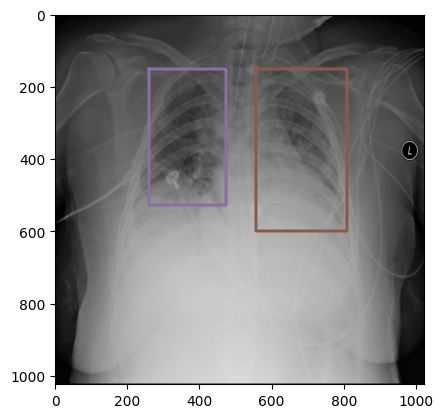

In [18]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

2 textfiles for training images and validation images.

In [19]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [20]:
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))


write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)

write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)


The # of train set: 5410, The # of validation set: 602


Test image and labels for YOLOv3

In [21]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [22]:
cd input

/home/vinnyfet/finalproj2/input


In [23]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

Sample test Image

In [24]:
pwd

'/home/vinnyfet/finalproj2/input'

In [25]:
cd ..

/home/vinnyfet/finalproj2


In [26]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [27]:
img_dir

'/home/vinnyfet/finalproj2/images'

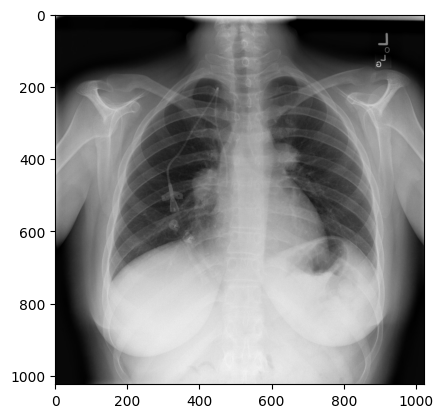

In [28]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))
#00436515-870c-4b36-a041-de91049b9ab4.jpg

Config files

In [20]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [30]:
pwd

'/home/vinnyfet/finalproj2/darknet'

In [31]:
cd ..

/home/vinnyfet/finalproj2


In [32]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [33]:
!cat cfg/rsna.data

classes= 1
train  = /home/vinnyfet/finalproj2/darknet/metadata/tr_list.txt
valid  = /home/vinnyfet/finalproj2/darknet/metadata/val_list.txt
names  = /home/vinnyfet/finalproj2/darknet/cfg/rsna.names
backup = /home/vinnyfet/finalproj2/darknet/backup
    

In [34]:
!echo "pneumonia" > cfg/rsna.names

In [35]:
#!wget -q https://pjreddie.com/media/files/darknet53.conv.74

Train YOLOv3

In [38]:
#!sudo apt-get update

In [39]:
#!sudo apt-get install -y make

In [40]:
#!sudo apt install build-essential

In [41]:
pwd

'/home/vinnyfet/finalproj2/darknet'

In [42]:
#cd darknet

In [43]:
#!sudo apt install libopencv-dev -y

In [44]:
#!export PATH=/usr/local/cuda/bin${PATH:+:${PATH}}

In [45]:
#!python -c "import cv2; print(cv2.__version__)


In [46]:
#!nvcc --version


In [47]:
#!sudo apt install libopencv-dev

In [48]:
pwd

'/home/vinnyfet/finalproj2/darknet'

In [49]:
#cd darknet

In [50]:
!make

make: Nothing to be done for 'all'.


darknet53.conv.74  (Download Pre-trained Model)

In [51]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-12-16 08:12:14--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.33’

darknet53.conv.74.3 100%[===================>] 154.96M  20.9MB/s    in 8.3s    

2022-12-16 08:12:23 (18.6 MB/s) - ‘darknet53.conv.74.33’ saved [162482580/162482580]



In [57]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [61]:
%%time
!./darknet detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt 

subdivisions: Using default '1'
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11

In [62]:
pwd

'/home/vinnyfet/finalproj2/darknet'

Training loss plot

(0.0, 4.05)

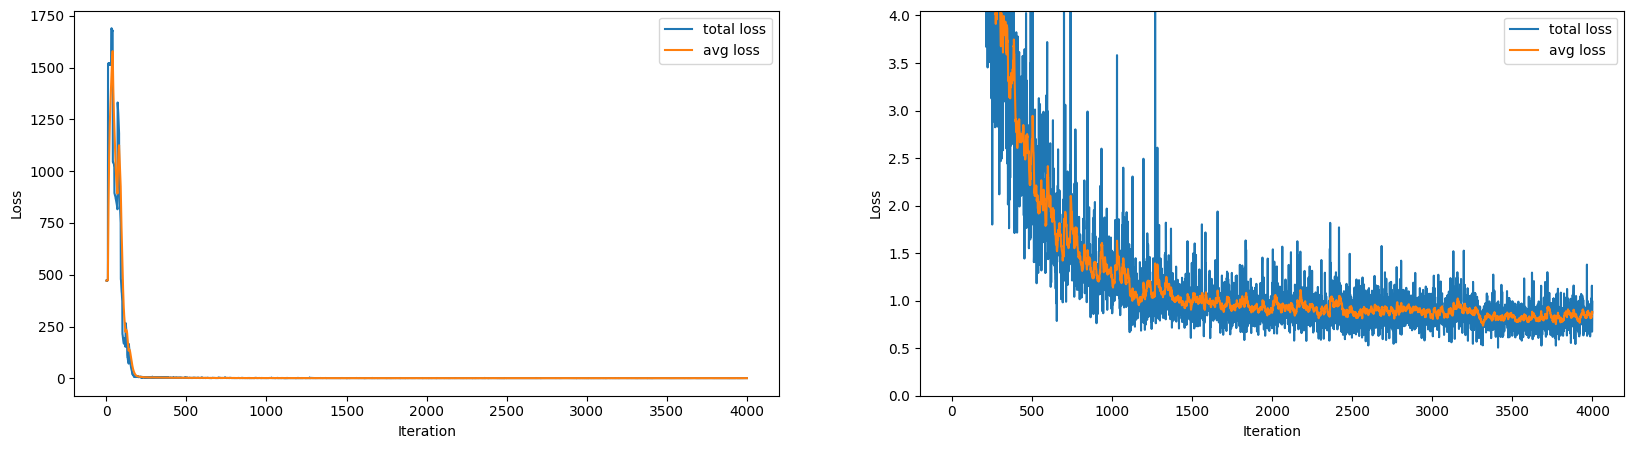

In [65]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(x=iters, y=total_losses, label="total loss")
sns.lineplot(x=iters, y=losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(x=iters, y=total_losses, label="total loss")
sns.lineplot(x=iters, y=losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])

Trained YOLOv3 for test images

In [66]:
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


In [23]:
ls '/home/vinnyfet/finalproj2/darknet/images' | wc

   9012    9012  477640


In [1]:
pwd

'/home/vinnyfet/finalproj2'

In [2]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [33]:
!./darknet detector test cfg/rsna.data cfg/rsna_yolov3.cfg_test backup/rsna_yolov3_final.weights 0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg -thresh 0.005

subdivisions: Using default '1'
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11

In [25]:
# #0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg
# #0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg
# !cp '/home/vinnyfet/finalproj2/darknet/images/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg' '/home/vinnyfet/finalproj2/darknet/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg'
# !cp '/home/vinnyfet/finalproj2/darknet/images/0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg' '/home/vinnyfet/finalproj2/darknet/0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg'


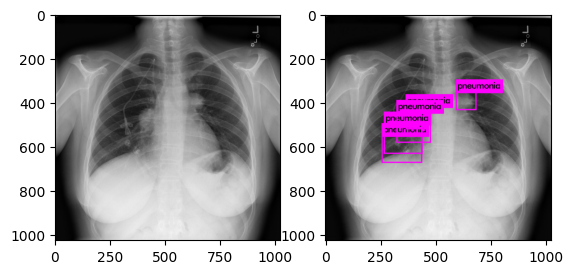

In [19]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread("test.jpg"))
axarr[1].imshow(cv2.imread("predictions.jpg"))

In [27]:
pwd

'/home/vinnyfet/finalproj2/darknet'

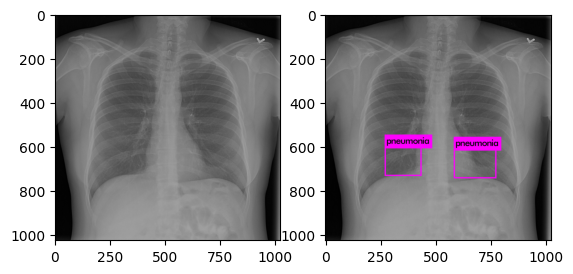

In [32]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread("0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg"))
axarr[1].imshow(cv2.imread("predictions.jpg"))

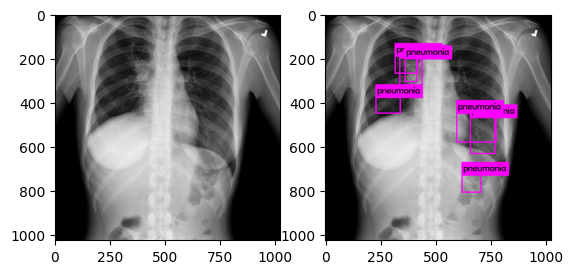

In [34]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread("0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg"))
axarr[1].imshow(cv2.imread("predictions.jpg"))
#0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg

In [24]:
pwd

'/home/vinnyfet/finalproj2/darknet'

Inference - Generate submission file

In [8]:
cd ..

/home/vinnyfet/finalproj2


In [4]:
pwd

'/home/vinnyfet/finalproj2'

using darknet.py from https://github.com/pjreddie/darknet.git

In [5]:
from darknet import *

In [6]:
threshold = 0.2 #0.3

In [10]:
submit_file_path = "submission.csv"
cfg_path = os.path.join(cfg_dir, "rsna_yolov3.cfg_test")
weight_path = os.path.join(backup_dir, "rsna_yolov3_final.weights") 

test_img_list_path = os.path.join(metadata_dir, "te_list.txt")

In [11]:
print(cfg_path)
print(weight_path)
print(test_img_list_path)

/home/vinnyfet/finalproj2/cfg/rsna_yolov3.cfg_test
/home/vinnyfet/finalproj2/backup/rsna_yolov3_final.weights
/home/vinnyfet/finalproj2/metadata/te_list.txt


In [12]:
cd darknet

/home/vinnyfet/finalproj2/darknet


In [13]:
#pwd

In [14]:
#!cp /home/vinnyfet/finalproj2/darknet/cfg/rsna_yolov3.cfg_test /home/vinnyfet/finalproj2/cfg/rsna_yolov3.cfg_test


In [16]:
!cp /home/vinnyfet/finalproj2/darknet/backup/rsna_yolov3_final.weights  /home/vinnyfet/finalproj2/backup/rsna_yolov3_final.weights

In [17]:
# !ls /home/vinnyfet/finalproj2/cfg/rsna_yolov3.cfg_test
# !ls /home/vinnyfet/finalproj2/metadata/te_list.txt

In [18]:
gpu_index = 0
net = load_net(cfg_path.encode(),
               weight_path.encode(), 
               gpu_index)

subdivisions: Using default '1'
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11

In [21]:
meta = load_meta(data_extention_file_path.encode())

In [22]:
pwd

'/home/vinnyfet/finalproj2/darknet'

In [25]:
submit_dict = {"patientId": [], "PredictionString": []}

with open(test_img_list_path, "r") as test_img_list_f:
    #print(tqdm(test_img_list_f))
# tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        #print(line)
        
        patient_id = line.strip().split('/')[-1].strip().split('.')[0]
        

        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)

        submit_line = ""
        for e in infer_result:
            confi = e[1]
            w = e[2][2]
            h = e[2][3]
            x = e[2][0]-w/2
            y = e[2][1]-h/2
            submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)
    
        print(patient_id, submit_line)



        submit_dict["patientId"].append(patient_id)
        submit_dict["PredictionString"].append(submit_line)

pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)

1it [00:03,  3.41s/it]

04df7618-aaf9-4979-94d4-2964151de11f 


2it [00:06,  3.39s/it]

2e600572-801d-40be-a6aa-627baad344dd 0.212164968252182 205.57286834716797 548.4803848266602 186.3280792236328 160.5684051513672 


3it [00:10,  3.37s/it]

1290a3a2-1908-4aa4-9ec9-60eb79efac1e 0.20052911341190338 131.27678680419922 511.5660705566406 239.91368103027344 314.89227294921875 


4it [00:13,  3.35s/it]

1e7c5923-3979-49d6-b08a-35b8d201d3da 


5it [00:16,  3.34s/it]

30875d7d-8fb0-4055-9df6-700d9c579452 


6it [00:20,  3.34s/it]

2f66dd10-b3f9-4efe-b6f1-25daa01b0668 


7it [00:23,  3.35s/it]

10c7dc33-2d86-4522-92bf-044ad1da5260 0.23029078543186188 581.8641815185547 433.1778030395508 198.34548950195312 172.97813415527344 


8it [00:26,  3.33s/it]

05b2cc6d-8a25-47c8-a191-bbaaadf0bf64 


9it [00:30,  3.33s/it]

133f1124-15d1-406f-aa63-2975f8a3cb90 


10it [00:33,  3.34s/it]

00786b27-31a0-4aeb-8513-9528fffe7b87 0.551992654800415 514.2790603637695 298.73797607421875 224.00022888183594 417.8560791015625 


11it [00:36,  3.33s/it]

118e2eda-ca5c-467a-8f27-5cab723c3f46 


12it [00:40,  3.32s/it]

11463b21-b97a-4b0b-97e1-13ab4033dd22 0.3277236521244049 322.61798095703125 580.8638610839844 159.6700439453125 160.17022705078125 


13it [00:43,  3.33s/it]

1c8d5876-4253-4d03-ae2c-7809182b0ec6 0.2896634042263031 171.5384063720703 307.1993103027344 256.9693298339844 293.6680908203125 0.26589787006378174 574.0226898193359 293.50413513183594 201.02810668945312 437.4094543457031 


14it [00:46,  3.34s/it]

c0f4c0b1-da34-464e-ad29-c8f7f309a30e 


15it [00:50,  3.39s/it]

2f646733-0892-48e4-a5d3-1bf84c892052 


16it [00:54,  3.51s/it]

0140cefe-d9c1-4de5-a59b-1aad98e4b62a 


17it [00:57,  3.45s/it]

253a2ef9-6cd7-423f-a7b4-ed5dedffb8cd 0.42470186948776245 176.58614349365234 277.53929138183594 230.2488555908203 357.9582214355469 0.20852996408939362 553.7091598510742 161.01168823242188 237.81056213378906 377.002197265625 


18it [01:00,  3.41s/it]

28cdfffc-0cda-4f89-9d11-c3705ee51f75 


19it [01:04,  3.38s/it]

29380429-cf24-49e6-aa64-dfc411204694 


20it [01:07,  3.38s/it]

0e3fcb29-79d1-43ff-a5e3-25d4e7c688cb 


21it [01:10,  3.36s/it]

04644a8f-bd70-484a-a4db-7ea330c6177c 


22it [01:14,  3.36s/it]

0d4ee901-841b-4693-8200-76d4cb1b2482 0.4328674376010895 182.2112579345703 157.472900390625 253.07968139648438 392.97308349609375 0.2797166109085083 604.0592498779297 185.2662353515625 223.95730590820312 540.818359375 


23it [01:17,  3.35s/it]

312dead9-f2a0-42c6-beea-9d0ce85de61a 0.3804091215133667 237.6713104248047 296.81695556640625 234.57614135742188 427.45037841796875 0.2839812636375427 624.1790008544922 358.94715881347656 227.72793579101562 410.0287780761719 


24it [01:20,  3.36s/it]

25b057bc-7363-4904-81f3-92c50d94486f 


25it [01:24,  3.36s/it]

2f3f043d-d8f2-40f2-a163-aa0f499804e8 0.3371022045612335 593.6228637695312 287.35821533203125 251.0469970703125 463.826171875 


26it [01:27,  3.36s/it]

2ac2f354-ae86-4c87-9ed7-38c842c6e604 


27it [01:30,  3.36s/it]

2d3442b4-85fb-42b5-a095-9b1fe2c4d371 0.2159062922000885 195.27490997314453 606.2166366577148 200.52561950683594 141.6836700439453 


28it [01:34,  3.36s/it]

14c691a4-e50b-4780-8511-a45510f5d6e7 0.4033677279949188 560.3176651000977 304.1234893798828 199.9263153076172 415.5406188964844 0.3798055052757263 237.26882934570312 322.2200012207031 209.18939208984375 370.599365234375 


29it [01:37,  3.34s/it]

1e96e601-f506-4825-b2fd-2c7ccf1603af 


30it [01:40,  3.35s/it]

124cea62-1b6c-445b-b34c-99e6979d0316 


31it [01:44,  3.34s/it]

1540ef53-d234-4110-9db9-c9cc21cf7010 


32it [01:47,  3.35s/it]

03b16b8f-a03c-409c-8740-7e694b7d58e5 


33it [01:51,  3.44s/it]

2ff9e61f-1666-4ea2-b649-66ba3d71377e 


34it [01:54,  3.53s/it]

2a27aad6-fdc7-491f-885d-44d5619a6cf5 


35it [01:58,  3.47s/it]

0444a749-4fde-46be-8202-bc2ddb71d5d9 


36it [02:01,  3.43s/it]

0254cbc4-8fb8-4e07-8bc6-430d337e66a7 


37it [02:05,  3.42s/it]

c1f55e7e-4065-4dc0-993e-a7c1704c6036 


38it [02:08,  3.40s/it]

1fe97b7f-62e1-4b0c-84b4-d41486039f01 


39it [02:11,  3.38s/it]

c1e202a1-431c-458f-8aa2-c237c7c69647 


40it [02:15,  3.37s/it]

02693444-dc0d-4ac0-8cd0-cbaed1844da3 


41it [02:18,  3.36s/it]

0fcb8bee-5859-4cea-8320-7afdb6b8e293 


42it [02:21,  3.35s/it]

2e08f9cb-6e35-45bd-9f8c-ff85f76c70b7 


43it [02:25,  3.34s/it]

033af663-f044-43ab-a569-298cc4bf37bc 


44it [02:28,  3.35s/it]

0fe81742-9643-47f1-9c77-7186610b1748 


45it [02:31,  3.34s/it]

134cd460-818b-4ea3-9861-0bdc82b1226c 


46it [02:35,  3.35s/it]

c1526e12-28a6-429b-98e7-8c6d634a9818 0.26316314935684204 770.0231018066406 281.1106262207031 229.91925048828125 573.3401489257812 


47it [02:38,  3.36s/it]

00a221ac-da8f-4f61-8d4f-fc195143491d 


48it [02:41,  3.36s/it]

04420ae7-2c04-4c42-a0a9-58f12e211a50 0.277320921421051 626.3392562866211 182.43324279785156 222.9621124267578 443.2373352050781 


49it [02:45,  3.37s/it]

037f16ff-46b6-45bf-b737-74072c46fab7 


50it [02:48,  3.37s/it]

206bdd43-542c-4888-a7e5-4e1932638b0d 


51it [02:52,  3.48s/it]

3121b0e5-ba65-46b8-ab40-49f94fba7078 


52it [02:55,  3.53s/it]

2086d3cc-021d-42d9-ad29-119b86f0b29c 


53it [02:59,  3.48s/it]

275e46bb-1b6e-4186-9486-6b5e1b5a1446 


54it [03:02,  3.45s/it]

144b6550-ebe7-4241-a467-932d53e8f9b8 


55it [03:06,  3.42s/it]

2170fcb3-ac43-4128-a256-dc58c3f7381b 


56it [03:09,  3.41s/it]

0cef4200-5aa7-4cef-969c-ac9c0d855cc9 


57it [03:12,  3.40s/it]

1a6143c0-f2ea-4858-9983-87fb497307ed 0.2070707082748413 586.2653503417969 405.2867736816406 252.36505126953125 540.6913452148438 


58it [03:16,  3.36s/it]

29597a3d-9fea-4da5-ac6f-8b8be9e84e8e 


59it [03:19,  3.36s/it]

20e75ed8-6388-4d51-87f6-eaf92eddca29 


60it [03:22,  3.36s/it]

2c5ee3d3-cc8b-4d90-8c50-d55b9ce39d6e 0.30237695574760437 309.84661865234375 375.1771697998047 191.5250244140625 186.51675415039062 


61it [03:26,  3.34s/it]

00edcd2d-d727-486d-b15a-675855e4dca3 


62it [03:29,  3.33s/it]

1eda3687-bdf5-469f-8fba-5000c559f48b 


63it [03:32,  3.34s/it]

2745b4cf-67c8-4f50-b4d5-9b44c073ea61 0.2527085542678833 225.5315399169922 303.4562683105469 236.44363403320312 299.71234130859375 0.23590466380119324 651.0476913452148 195.61793518066406 229.5158233642578 416.2544860839844 


64it [03:36,  3.35s/it]

2696d094-0bf0-47b5-bf0a-13bbb16a03be 0.274278461933136 618.4909133911133 298.03038024902344 243.64463806152344 324.9401550292969 0.24739550054073334 229.7572021484375 297.1250457763672 230.472412109375 317.0841979980469 


65it [03:39,  3.35s/it]

0105b36d-2d7c-4431-9b5b-fa6acb31ee1d 


66it [03:42,  3.35s/it]

2b54e5d2-8c8e-4b8f-8128-ab0fa4a7744d 


67it [03:46,  3.34s/it]

0e097143-6cc3-4a55-ba45-0f60075a42e5 


68it [03:49,  3.40s/it]

2928bb0e-4840-4399-aeb7-6240de938d84 0.4235844314098358 296.30301666259766 531.5766906738281 208.71824645996094 396.83795166015625 0.27243149280548096 670.9082794189453 388.1352844238281 219.22372436523438 460.18756103515625 


69it [03:53,  3.53s/it]

2e1de52d-7796-4c25-b972-e2712fca6e7e 


70it [03:56,  3.47s/it]

0022bb50-bf6c-4185-843e-403a9cc1ea80 0.3342131972312927 587.3314514160156 286.57421112060547 177.98602294921875 137.2842559814453 


71it [04:00,  3.43s/it]

1dd0b293-1563-4cf3-ae1e-fcd4232f852c 


72it [04:03,  3.40s/it]

1de2a7d7-2601-4d9d-90db-484bd3f41f7f 


73it [04:06,  3.40s/it]

114bf6af-d3ef-489c-a6fe-304f7ef36fd0 


74it [04:10,  3.39s/it]

260b87ff-df13-4177-90bb-53fb0618b1db 


75it [04:13,  3.37s/it]

245a6216-ef95-49ed-870e-fc415d3b96cb 


76it [04:16,  3.36s/it]

117061eb-6454-4f19-8730-95c65a4029bb 


77it [04:20,  3.36s/it]

2a545588-c287-4124-88d1-7a17032d5cb3 0.2239118218421936 538.1644134521484 448.9270324707031 258.3874816894531 340.15692138671875 


78it [04:23,  3.34s/it]

2d6e1a91-60f1-424e-9512-60f7f12b4f3b 


79it [04:26,  3.33s/it]

00722cea-8cb4-488c-91a1-402d3cfab7a3 


80it [04:30,  3.34s/it]

27016559-e694-413a-bc72-ec9fdb9c8bee 


81it [04:33,  3.33s/it]

0dc2a698-4e8d-47cc-9d05-91be01fbe7b2 


82it [04:36,  3.33s/it]

1e1ce192-3106-4922-a0d3-3d81b8eececf 


83it [04:40,  3.33s/it]

1a27e565-b0f5-4419-84b3-744712cb705d 0.22584518790245056 569.2118072509766 351.694580078125 221.36141967773438 540.955810546875 


84it [04:43,  3.33s/it]

04269ea9-d43c-4f01-a72a-d340fb49ff27 


85it [04:46,  3.34s/it]

1dc3dc9e-6ba7-4e2e-9323-b81ec65ba210 


86it [04:50,  3.41s/it]

26aff776-ff9d-40f2-b899-6b88f1355506 


87it [04:54,  3.51s/it]

104c0c31-7fd6-4529-a126-2832f343db46 0.3579005002975464 651.4062652587891 219.30596923828125 223.98837280273438 485.3204345703125 0.20651496946811676 277.7288513183594 363.71331787109375 244.50811767578125 404.4490966796875 


88it [04:57,  3.47s/it]

230422fe-3a39-4bdd-ac65-70572f14451c 


89it [05:00,  3.43s/it]

28a903f0-ca6b-4e7f-9587-7812b25e794f 


90it [05:04,  3.40s/it]

2c11a41d-b819-4a69-9c77-829045dcda07 


91it [05:07,  3.39s/it]

223adc8b-4ded-481f-85ba-f4b8ce619d7a 


92it [05:11,  3.38s/it]

2eaaa116-9983-46e9-bb80-a5f8dd3727f3 


93it [05:14,  3.37s/it]

058240c8-1e00-4f7f-8a13-006aafd538eb 


94it [05:17,  3.36s/it]

2cc95db5-41a8-47d6-9bee-de5c9490b623 0.20249468088150024 537.6372833251953 348.2110900878906 192.43624877929688 434.86688232421875 


95it [05:21,  3.36s/it]

1f2faab3-bcdc-4f7f-a8a2-d4e65b93da3e 0.3369601368904114 578.9850311279297 493.8552932739258 193.05044555664062 167.38560485839844 


96it [05:24,  3.36s/it]

302e7d89-c44d-49b1-805f-39e111755975 0.34795302152633667 184.73699188232422 545.9580459594727 220.7936553955078 130.1669158935547 


97it [05:27,  3.35s/it]

02500219-bcb2-462d-8c02-857a53a2f969 


98it [05:31,  3.35s/it]

12b35131-8b22-4d87-9c36-ecf05e265952 


99it [05:34,  3.36s/it]

290b2fca-1aee-4058-a615-08dbe5d697b8 


100it [05:37,  3.35s/it]

02bc74a8-2ea2-4d73-a7b4-d2ae9c1ddfd7 0.2915947735309601 139.52019500732422 599.7902450561523 201.5064239501953 143.6276397705078 


101it [05:41,  3.35s/it]

1539e414-553f-48c1-9ce4-7c452176e1e1 0.41263383626937866 612.9547882080078 455.1042022705078 236.42770385742188 430.5199890136719 


102it [05:44,  3.36s/it]

1c11b14e-23df-419b-9a6b-e16372754c2f 


103it [05:47,  3.36s/it]

2cbe226e-abd7-4c75-94ab-a4c048c253d2 


104it [05:51,  3.45s/it]

215700ac-5dcf-4d9f-8124-4e7cde3788d2 0.39244958758354187 171.50287628173828 385.7127990722656 234.3318328857422 361.04559326171875 


105it [05:55,  3.53s/it]

14d4b142-29d6-4656-ab1d-17b84816b2c6 0.3800824284553528 202.10275268554688 170.4518051147461 195.6553955078125 151.37147521972656 


106it [05:58,  3.47s/it]

0db01d52-c8d4-490d-bf26-611a5a7616f4 


107it [06:02,  3.45s/it]

313a472a-b7c6-4e89-9bc4-ea83f4633d25 


108it [06:05,  3.41s/it]

2111488b-6c55-4f89-9ec4-35b265b36b46 


109it [06:08,  3.38s/it]

2316b90f-0098-471d-95e8-dd71c7e9cbda 


110it [06:11,  3.36s/it]

138ff8b1-a35f-4187-a76b-3eaa01407591 0.23018062114715576 197.7496795654297 543.5087585449219 205.32559204101562 139.69622802734375 


111it [06:15,  3.36s/it]

10d00463-dfa9-45b6-8869-9674a7773069 0.21671424806118011 634.3756866455078 440.20574951171875 191.82821655273438 137.32330322265625 


112it [06:18,  3.36s/it]

19dc5cde-ea71-477b-8ab6-048a428c6a82 


113it [06:22,  3.37s/it]

266490ca-ce52-4f5b-92ff-082dae7967c0 


114it [06:25,  3.36s/it]

0470a3c3-5ae2-4324-9460-5720aa55a2e6 


115it [06:28,  3.36s/it]

12934bb0-bf43-4ba0-ab27-718c338f2c63 


116it [06:32,  3.36s/it]

1f0374aa-9366-4a24-8646-0b7656698026 


117it [06:35,  3.36s/it]

1c250181-32e8-4879-a115-978eb7285255 


118it [06:38,  3.35s/it]

231e06ec-050a-4514-8241-431aa1ec5fa4 0.2577644884586334 599.2556076049805 161.92811584472656 231.67860412597656 385.6548767089844 


119it [06:42,  3.36s/it]

0de33fbf-998c-4c91-9561-df7343873bc2 0.5075488686561584 619.3371505737305 547.4058074951172 204.10401916503906 159.20510864257812 


120it [06:45,  3.36s/it]

2dd0b928-c0b6-47f3-a1a1-b538e058ed13 


121it [06:48,  3.35s/it]

0f96b5e6-6714-4613-af33-edfbdbc1e0bd 0.4987344443798065 516.9627914428711 355.1334533691406 228.1260528564453 413.76849365234375 


122it [06:52,  3.46s/it]

251ecdcd-70e7-4aa2-91f6-208d61a6b41e 


123it [06:56,  3.51s/it]

1bf11636-a3b7-46a3-b219-389ede8b09cc 


124it [06:59,  3.47s/it]

0d8606bf-1f0c-4f8f-a271-dd40ed0ecf45 


125it [07:02,  3.42s/it]

01789dfc-da09-4460-8326-32c143e767be 


126it [07:06,  3.41s/it]

2c267bbb-7bff-40e9-97c1-b102e9d1fb73 


127it [07:09,  3.39s/it]

21109de5-475a-48ac-9727-0b2bf8867331 


128it [07:12,  3.37s/it]

21ea97d1-c6f8-460a-8487-8530b4fcef02 


129it [07:16,  3.37s/it]

23d956be-3b4d-4e1c-abce-a0e10b5b4962 0.48684900999069214 231.31359100341797 174.18946838378906 218.75624084472656 461.5388488769531 0.41523277759552 592.3076477050781 237.73817443847656 265.57794189453125 340.2478942871094 


130it [07:19,  3.36s/it]

30dbf3fd-feab-4a36-b42c-c044ec13a9a9 0.21300436556339264 611.6287155151367 369.7121276855469 255.63075256347656 389.28497314453125 


131it [07:22,  3.34s/it]

05a96e6a-86a0-4163-a4de-388833f2dc75 0.22914545238018036 218.82625579833984 436.50157165527344 163.8694610595703 169.98587036132812 


132it [07:26,  3.33s/it]

3036896f-9a42-4e66-a745-4fa2a428ef7d 


133it [07:29,  3.33s/it]

c0808f4b-2487-4786-a204-3b76b8ec3313 0.2452830672264099 249.7893829345703 424.5188293457031 201.04312133789062 152.073974609375 


134it [07:32,  3.34s/it]

c06462ab-7889-4876-95b5-a20fd2a71408 


135it [07:36,  3.35s/it]

1410b58f-f5df-40e2-a0c5-09c53760006c 


136it [07:39,  3.35s/it]

2b9990c6-dd10-44e4-9d5a-5701a964a57d 


137it [07:42,  3.34s/it]

2608ca32-b4b9-426b-ba16-c6eb19f88450 0.24874486029148102 175.61957550048828 252.2752685546875 245.7297821044922 410.4619140625 


138it [07:46,  3.34s/it]

2d1c672f-5583-4dea-aa29-fd0f79d579d2 


139it [07:49,  3.37s/it]

1c0cee97-fb9c-4921-979f-e17a323f6d6f 


140it [07:53,  3.49s/it]

1c54b11d-abf4-491b-bfe4-2ace6abc5458 0.22909937798976898 181.8893280029297 377.5730285644531 221.89425659179688 477.76324462890625 


141it [07:56,  3.46s/it]

1d0ce799-81bb-40be-8e92-4b1783906cc9 


142it [08:00,  3.43s/it]

03bc2ba2-2617-4c8b-a0fe-81b0a915d066 


143it [08:03,  3.41s/it]

1d0de7b7-c3db-424c-bfd1-fe63c121b668 


144it [08:07,  3.39s/it]

1c649fed-f0d1-448e-89cf-543708c35076 


145it [08:10,  3.38s/it]

2ddf7620-8dbf-463f-a485-629c5fbfa5af 0.38864797353744507 133.08203125 243.84732055664062 226.97943115234375 322.7425537109375 0.28805795311927795 511.41351318359375 256.3506164550781 236.0919189453125 411.2197265625 


146it [08:13,  3.36s/it]

11fc3649-c448-488a-8bf2-412ef14971d4 


147it [08:17,  3.37s/it]

c0975b54-8922-449b-950a-70308820b56e 0.5058420896530151 245.27342224121094 189.11000061035156 226.04183959960938 442.5521545410156 


148it [08:20,  3.35s/it]

131224d5-2c75-4cf6-aeda-b2dce902291a 0.413899302482605 611.1469345092773 393.1610107421875 238.9942169189453 449.524169921875 0.29850274324417114 262.29312896728516 366.5712127685547 210.23326110839844 392.0228576660156 


149it [08:23,  3.34s/it]

1b4511a5-9af4-411e-aad9-f005d318cf66 


150it [08:27,  3.34s/it]

276a4c77-21cd-4b77-b94d-5172a2ab427f 0.38142091035842896 231.27904510498047 252.9164276123047 233.5808868408203 411.4138488769531 


151it [08:30,  3.35s/it]

200035d6-f2fa-4281-b1be-781fa95e015e 


152it [08:33,  3.36s/it]

11d313d4-1d96-4da8-8fe0-8a0db9910d04 


153it [08:37,  3.36s/it]

1a90ed6e-a6ab-4a9b-84a7-ac57e76fad42 


154it [08:40,  3.35s/it]

2e929adc-551d-426c-a25d-2d767ccb0c18 


155it [08:43,  3.36s/it]

2b98d69d-6e7c-4d51-af53-c3fb16301c08 


156it [08:47,  3.37s/it]

21a7dbab-2bdc-4656-b51b-7f9dba14e39c 


157it [08:50,  3.42s/it]

31427b8c-af64-4bf1-91b0-32768c847536 


158it [08:54,  3.52s/it]

25d088e7-8415-4028-ab4e-bf20f27a81d4 


159it [08:57,  3.49s/it]

02b7f2f0-b8e0-41c8-9cfc-83c69d202c67 0.25498783588409424 195.54622650146484 441.80944061279297 206.1659698486328 142.73536682128906 


160it [09:01,  3.47s/it]

04892909-51b5-475c-9234-e7e97fb77c83 


161it [09:04,  3.44s/it]

24e16db4-65a9-4e5e-81d1-701c8fae06ba 


162it [09:08,  3.41s/it]

0e586366-2ff8-443d-b09d-341467680c12 0.417059987783432 492.1737823486328 263.26805114746094 263.2498474121094 380.5609436035156 0.3056912124156952 131.3192367553711 341.2994842529297 212.03514099121094 336.8362731933594 


163it [09:11,  3.39s/it]

1b435cbd-9ef2-4f8e-b2a0-39cad1fd1962 


164it [09:14,  3.38s/it]

280933e5-47d7-4015-ab8f-d6c12a846b9a 0.28866046667099 186.6052017211914 369.6925354003906 214.99058532714844 389.68658447265625 


165it [09:18,  3.37s/it]

241a8008-8f3c-42fb-a4f4-4041fe0a14d4 0.29343292117118835 628.4299087524414 257.12982177734375 197.4877166748047 515.4193115234375 0.26148533821105957 294.72608947753906 335.2437744140625 208.06515502929688 358.696533203125 


166it [09:21,  3.36s/it]

2b419ca4-0ce1-4eba-a59f-dfc24b74aabf 


167it [09:24,  3.34s/it]

2b64c32b-7575-45df-844d-dd466c698eef 


168it [09:28,  3.35s/it]

2c106e49-84cd-4824-a12c-c2e737f31fd7 


169it [09:31,  3.36s/it]

2348e7cb-e24f-4b47-9e3a-945d1942ab5e 


170it [09:34,  3.35s/it]

126d9f1a-7dfe-4616-a917-57499b15d9bf 


171it [09:38,  3.36s/it]

15212951-d7a3-4332-8fc9-51ef843a6ade 


172it [09:41,  3.35s/it]

28d83d57-c9c7-4c15-96e9-fe00092c999c 


173it [09:44,  3.35s/it]

1bebe474-0785-4c45-8546-8c3f9203ed17 


174it [09:48,  3.36s/it]

25f1a1b5-e9d1-4f0c-a3c4-04093cf99a23 


175it [09:51,  3.46s/it]

2aced5e8-cf72-4f1f-a8cf-707de0a1ddca 


176it [09:55,  3.50s/it]

0e917a81-5107-47f5-b67d-c3f2f84700fc 


177it [09:58,  3.46s/it]

2578fa2d-6cf3-41d1-b233-89587b1126d8 


178it [10:02,  3.42s/it]

0e8e07c6-ce6f-4bde-a85f-d437f0debd43 0.3237813711166382 120.97830200195312 357.61985778808594 247.48553466796875 313.2246398925781 0.22945916652679443 600.5473175048828 376.0159606933594 230.06710815429688 387.14874267578125 


179it [10:05,  3.42s/it]

12d84104-ce46-484e-9440-70f51b908923 


180it [10:09,  3.40s/it]

2c4d9d50-bb03-4d73-b972-4f9ca8b90661 0.30926766991615295 108.04669189453125 289.2074890136719 280.798828125 453.73773193359375 


181it [10:12,  3.40s/it]

c0d73fbe-80c5-44dc-94f8-85f757be171b 0.23435363173484802 197.46013641357422 445.23789978027344 206.5429229736328 145.22451782226562 


182it [10:15,  3.38s/it]

2d9e909c-bfb6-4360-b65e-d69a3fbd0ba6 0.34499692916870117 647.7710418701172 368.6161651611328 270.3645324707031 385.8399353027344 


183it [10:19,  3.38s/it]

20d9afc7-a8aa-414d-9e44-fce8775b0dbb 


184it [10:22,  3.38s/it]

20fca1d7-2960-40c8-8752-abb56f960d41 


185it [10:25,  3.36s/it]

26a937bc-a3e4-41a1-9a1a-a63506d4b49d 0.2266143262386322 319.6585998535156 450.90318298339844 199.10943603515625 336.0238342285156 0.221883624792099 625.6493072509766 374.7952423095703 191.59884643554688 495.8720397949219 


186it [10:29,  3.36s/it]

019a638a-305f-422d-aec7-f1081f510046 


187it [10:32,  3.37s/it]

1f1bf83e-6cb7-473b-9f27-f1a91cc8d116 0.21577483415603638 190.64413452148438 646.1792678833008 200.0894775390625 164.44224548339844 


188it [10:35,  3.37s/it]

21a6488b-80dc-4caf-8d7b-a375011d70dc 0.27306270599365234 269.20870208740234 539.9562301635742 176.27967834472656 147.44532775878906 


189it [10:39,  3.36s/it]

252437ed-a4e2-4743-995c-65a4bb133996 


190it [10:42,  3.36s/it]

1d67198f-a438-40d2-9d49-9e36a43dfb03 


191it [10:46,  3.38s/it]

12e4ed21-07e3-471c-9b2d-e71b128d3fde 


192it [10:49,  3.41s/it]

bffff3da-0b19-40a7-af3b-e832bf9b45ec 0.2806788980960846 657.0669860839844 191.91024780273438 223.80584716796875 532.6456909179688 


193it [10:53,  3.53s/it]

22d3ebb7-eaf1-4b93-aea5-6dc714e3dacc 0.5163470506668091 244.3103485107422 365.8251266479492 195.73837280273438 196.46180725097656 


194it [10:56,  3.47s/it]

2950b52f-0d4e-4c6b-ad7e-7052b750bf9b 0.39636948704719543 211.83876037597656 505.0358428955078 184.75479125976562 132.21859741210938 


195it [11:00,  3.44s/it]

138e2c27-17d0-4a32-9ceb-ee3401c12613 0.22540739178657532 537.4486999511719 431.08746337890625 189.52581787109375 167.345458984375 


196it [11:03,  3.40s/it]

138ccb35-b073-4f73-9e53-9b4f1f463e9c 0.28381380438804626 194.08385467529297 439.23890686035156 209.7102813720703 145.09268188476562 


197it [11:06,  3.39s/it]

00c67fbc-35f6-4058-88b4-4bfad19014ec 0.42062562704086304 628.2949600219727 475.0204086303711 205.2804412841797 169.3332061767578 


198it [11:10,  3.37s/it]

2d4a621e-f58b-4a3c-876b-69ddc1c20167 


199it [11:13,  3.36s/it]

1b66ef47-b795-418f-bc18-1339bc980b8b 0.5292127132415771 261.9957962036133 585.7053375244141 183.7399139404297 183.45822143554688 0.21166133880615234 616.3177795410156 402.3312072753906 233.01751708984375 436.56243896484375 


200it [11:16,  3.36s/it]

298c9dbf-f493-4991-9f9e-1eeb3c570bed 


201it [11:20,  3.36s/it]

c1ec035b-377b-416c-a281-f868b7c9b6c3 


202it [11:23,  3.35s/it]

0f7c5eb5-3cd5-4495-a5d9-9a2b4eff6165 0.2982816696166992 170.63047790527344 192.43402099609375 234.27365112304688 527.99267578125 0.23461614549160004 564.950439453125 210.98577880859375 223.6600341796875 388.697509765625 


203it [11:26,  3.33s/it]

2fed6de4-af54-4b45-a188-17ac855a7360 0.21379928290843964 615.8732757568359 422.29876708984375 204.88308715820312 171.40460205078125 


204it [11:30,  3.34s/it]

29420883-e102-44a6-95d9-389ee31d2be1 


205it [11:33,  3.34s/it]

1f164d6c-eb0b-45f1-97d9-bd261ccb52b2 0.21111257374286652 581.3046798706055 490.0804748535156 195.12318420410156 175.51068115234375 


206it [11:36,  3.34s/it]

2e93fff9-dab8-410b-9c44-48e023b0f686 


207it [11:40,  3.35s/it]

c141f676-7ac5-4231-bdb2-aea92772eb7f 0.3450983166694641 206.453369140625 372.17887115478516 194.13824462890625 193.7302703857422 


208it [11:43,  3.35s/it]

0f2454e6-2e7d-46b2-886e-70aaee4a2d0b 


209it [11:46,  3.36s/it]

0497418b-3302-443f-aa7e-360cce158a8e 0.2125411331653595 677.2635650634766 179.62533569335938 219.10324096679688 558.1824951171875 


210it [11:50,  3.40s/it]

c07ea5c4-ce0a-4f94-bcfe-64c7399adb9c 


211it [11:54,  3.51s/it]

c1a2fb00-a536-4e07-b462-2220a17968a2 


212it [11:57,  3.47s/it]

c1507764-540b-4036-ae74-8271effd56c5 


213it [12:00,  3.44s/it]

c1281ecd-6406-420a-960a-f60c0a2be14e 


214it [12:04,  3.41s/it]

03866050-4736-47c1-ab69-d084d6561b9e 


215it [12:07,  3.38s/it]

0524e490-8eee-4342-8813-870acac6b222 


216it [12:10,  3.37s/it]

2e4e7205-8ffc-4b26-bf0d-8e5864b7238c 0.31324782967567444 279.14295196533203 225.80191040039062 239.4728240966797 462.035888671875 0.247252956032753 659.4822006225586 241.66224670410156 219.2685089111328 435.8938293457031 


217it [12:14,  3.37s/it]

30ef1119-d75f-4504-b472-a8fd612388aa 


218it [12:17,  3.37s/it]

0521179f-8de0-4ec9-80c4-2f6e36f157cb 


219it [12:21,  3.37s/it]

2bc0753f-a2c9-41c0-a251-a7c8ae3f9292 


220it [12:24,  3.37s/it]

22c7b69b-d9a2-4b64-95f5-3cfb86bdec22 0.21511706709861755 195.6200942993164 459.31072998046875 199.1401824951172 326.25390625 


221it [12:27,  3.37s/it]

1ead85b0-dada-4d3e-8a39-3989aaba75c2 


222it [12:31,  3.36s/it]

1c3f2cc0-4c64-43bf-828f-8d52f7c5a442 


223it [12:34,  3.37s/it]

0094c2b8-5da2-4e25-a177-b4eea16bd671 


224it [12:37,  3.37s/it]

25840be8-f6cf-4df1-893b-80412b99a417 0.23984402418136597 248.4773941040039 440.6822052001953 193.79222106933594 356.7332458496094 


225it [12:41,  3.36s/it]

10018c2f-3283-458b-9f0a-55b39e8c29a6 


226it [12:44,  3.35s/it]

c1bea7c6-14cb-483c-b2ee-e958901f0667 0.46125492453575134 132.0559844970703 342.7254943847656 229.06259155273438 453.35272216796875 0.22944435477256775 549.1862106323242 431.17396545410156 221.56324768066406 379.9694519042969 


227it [12:47,  3.36s/it]

22569e21-9b6e-4ec7-aef1-359ff0cfd4e1 0.3252752721309662 193.4185028076172 605.9380035400391 191.94937133789062 148.18612670898438 


228it [12:51,  3.46s/it]

00860e86-5b18-4694-a20a-0b47e842a453 


229it [12:55,  3.52s/it]

1cd3a288-dc8e-4591-9667-d4f1f5b48c79 


230it [12:58,  3.47s/it]

2dcb24a1-d06f-40de-80ba-20e44f233395 


231it [13:01,  3.43s/it]

c0f282b0-d5d9-411b-899d-b6174992b0f1 


232it [13:05,  3.42s/it]

02347c05-a319-41a9-88b4-59ef119221b3 


233it [13:08,  3.39s/it]

23262e9c-3767-4beb-8e3d-0d1d50df6d8f 


234it [13:11,  3.36s/it]

03858c3a-5c32-4503-8888-58f2f601c1df 


235it [13:15,  3.34s/it]

02d4d116-415d-49cb-91bc-98b97c973ad3 0.3647729456424713 542.6747207641602 407.6736297607422 247.8221893310547 423.6975402832031 0.30139079689979553 120.03341674804688 369.1299743652344 236.51812744140625 509.27728271484375 


236it [13:18,  3.34s/it]

1bfdab1f-e19d-495c-aaaf-f64872a99c5a 0.2626451849937439 147.08806610107422 536.5533752441406 200.24745178222656 170.86688232421875 


237it [13:21,  3.35s/it]

23fef1ae-6472-4def-948b-5594056f2b79 0.27925243973731995 301.7186584472656 591.0132293701172 200.1685791015625 168.31692504882812 


238it [13:25,  3.35s/it]

03fcfa7a-8d70-437a-ad1e-7172023cbdeb 


239it [13:28,  3.35s/it]

2971548b-c2b1-4b9b-bf50-00d7cc78f096 


240it [13:32,  3.35s/it]

21ab7839-a62c-4829-bde0-378d0ca4cc21 


241it [13:35,  3.35s/it]

11e9a762-f214-48c5-8f56-ebc96607cf70 0.2205350697040558 200.08422088623047 542.6115264892578 200.16835021972656 143.95700073242188 


242it [13:38,  3.33s/it]

1afcf486-18db-4ffb-93e4-3a3d6a943110 


243it [13:42,  3.34s/it]

2d74db0e-9a5a-4763-8451-ad653405c3ab 


244it [13:45,  3.34s/it]

259cc0a9-5cab-4520-b7df-96000477e3d8 0.312929630279541 580.7827606201172 243.26266479492188 216.59793090820312 425.17181396484375 0.2724936902523041 239.37709045410156 201.72344970703125 235.52139282226562 407.58331298828125 


245it [13:48,  3.36s/it]

14b22d6c-7cb3-4331-bdfe-b67a20a623d4 


246it [13:52,  3.46s/it]

1d83e053-34b9-4937-a402-6794429f6d1b 0.6576940417289734 242.7158432006836 229.5120849609375 218.31629943847656 459.0987548828125 0.22738045454025269 660.6081161499023 373.08544921875 217.8694610595703 273.65313720703125 


247it [13:56,  3.51s/it]

2abcf934-facd-40fc-a75e-0062441fd206 0.5384812355041504 185.40463256835938 241.99046325683594 226.3109130859375 433.9198913574219 0.3827231824398041 530.2520217895508 238.1207733154297 209.28343200683594 437.4510192871094 


248it [13:59,  3.46s/it]

127bb3ff-0c96-4c4a-9658-918ae798ee7b 


249it [14:02,  3.44s/it]

1eb459ff-72ac-45d5-8ad0-a777456c5781 


250it [14:06,  3.39s/it]

2e164bb0-2b22-4ef4-954a-8e748a2ef263 


251it [14:09,  3.38s/it]

1d78c3f0-7511-4ee1-9081-1d101aaf751e 


252it [14:12,  3.37s/it]

28209e9c-6bbe-4832-842e-a5b040ce6364 


253it [14:16,  3.35s/it]

2ea1ed2d-6423-4948-9a11-ed9f2132b881 


254it [14:19,  3.34s/it]

1fc91f5d-b495-4326-911b-18d0383f25ea 0.4329698085784912 222.5112075805664 331.5088806152344 245.79527282714844 584.3480834960938 0.2958565056324005 563.6983413696289 247.02569580078125 231.7043914794922 532.965576171875 


255it [14:22,  3.35s/it]

0dcf2fda-af28-4473-8ac3-47bb30d332a8 


256it [14:26,  3.36s/it]

2180885a-f469-4512-845e-deb6f1ec9317 


257it [14:29,  3.37s/it]

c1df4324-58ef-4f0c-b5a2-88faaf28955f 


258it [14:32,  3.38s/it]

14aac35d-3205-4861-8bc5-eb37d90f8298 0.24970759451389313 227.16928100585938 338.2432556152344 226.40673828125 452.66424560546875 


259it [14:36,  3.37s/it]

25e3c135-1274-407c-b34d-643460fbf617 


260it [14:39,  3.37s/it]

c031834b-2296-4991-ac96-8495ee9a1231 0.3005414605140686 188.48602294921875 438.09378814697266 193.66351318359375 152.5320281982422 


261it [14:43,  3.38s/it]

2c97b392-6cc9-489c-a379-92ab76e0df97 


262it [14:46,  3.38s/it]

2e34e10c-62b2-48b0-bd44-ccb690b3f461 


263it [14:49,  3.42s/it]

30f09a8d-c8d2-416f-86cf-b56f5c99ea07 


264it [14:53,  3.54s/it]

1d97ff50-d3f6-4425-ae93-506c6168e704 


265it [14:57,  3.50s/it]

2704fcb3-7b66-49ed-a5ba-ea20386c824a 


266it [15:00,  3.46s/it]

2ce66821-8300-435e-9d63-5f5aad217c3d 


267it [15:03,  3.43s/it]

0d53594f-65b0-4d99-a5d3-c9568c8c6b56 


268it [15:07,  3.40s/it]

208c6592-2055-4cde-98c3-dd48419088e9 


269it [15:10,  3.39s/it]

11978f36-7caa-426b-8dd9-1bf9a6acc522 0.3001527786254883 664.6615295410156 436.2019348144531 230.83416748046875 372.41033935546875 0.2642407715320587 253.05025482177734 374.10028076171875 221.43263244628906 395.916259765625 


270it [15:13,  3.38s/it]

04ba9dc3-9cf1-41f5-9e4d-939bd69c97f6 


271it [15:17,  3.37s/it]

28805c82-2a63-4790-9db3-b36f6576b8e4 


272it [15:20,  3.37s/it]

03055987-3303-429f-8979-cecf701707e5 


273it [15:24,  3.38s/it]

262aefb6-740e-4af6-9ed1-e2f0a11a5aa6 


274it [15:27,  3.35s/it]

1c4b74c7-3a48-453f-8f79-2f58cdccedfa 0.23098710179328918 580.8203811645508 482.2063217163086 196.26316833496094 179.0926055908203 


275it [15:30,  3.34s/it]

1d997b6b-b9f1-4dd6-ae12-7a5771e6e873 


276it [15:34,  3.34s/it]

0389a598-b5f0-43a5-9a98-7dfdd08e0b9f 


277it [15:37,  3.34s/it]

2c18260b-22c7-4f05-9f43-9867ba93b519 


278it [15:40,  3.35s/it]

27522054-1b91-4f9c-9ab6-15aab6cca1cd 


279it [15:44,  3.34s/it]

2bb2c31d-af87-45e3-961d-5cd6f2639119 0.5095883011817932 608.6747665405273 286.9833068847656 230.1831817626953 455.32464599609375 0.3399062752723694 168.94993591308594 260.6696319580078 242.58901977539062 510.4790954589844 


280it [15:47,  3.35s/it]

1ebf816d-3d54-4354-b6bd-9b84894f008e 


281it [15:51,  3.41s/it]

24ab4146-c63f-4a81-b996-5b9295e2185b 


282it [15:54,  3.49s/it]

0de0ccbf-7a9b-4eea-a9a1-038dc249e6eb 


283it [15:58,  3.45s/it]

13be9ccd-fa89-4c43-84b0-069b1eba6c28 0.42817726731300354 253.24838256835938 299.29486083984375 211.7496337890625 309.92279052734375 0.27868038415908813 627.6268463134766 652.2465744018555 191.69906616210938 154.57557678222656 


284it [16:01,  3.42s/it]

1da29452-a122-4a5b-b10a-3c43ce5f4dd6 


285it [16:04,  3.41s/it]

2c929ddf-362a-4701-8501-2ee7f6abed22 


286it [16:08,  3.39s/it]

1b65bd85-e390-4b30-9f0e-f2f2a3d35710 


287it [16:11,  3.38s/it]

28e7948f-0d76-4616-80e0-7e54f8691d43 


288it [16:14,  3.36s/it]

128b0c29-842f-4eaa-bdd3-b36102d2062c 


289it [16:18,  3.35s/it]

28fb9812-830e-4f7a-8750-02005a3a68c4 


290it [16:21,  3.35s/it]

0050f8bb-36a4-4a1a-8de5-2d73154c2571 


291it [16:24,  3.35s/it]

034e908e-6cef-4ecb-82b3-d9c8a243a60e 


292it [16:28,  3.36s/it]

011df306-5ca7-442e-bd54-f05820d84396 0.21941764652729034 184.417724609375 449.67259216308594 226.3306884765625 128.23489379882812 


293it [16:31,  3.35s/it]

20cf7cea-879e-47fe-937c-15a258dff0e3 


294it [16:34,  3.35s/it]

2f4dcc33-3ccc-41ca-8b33-9db707891518 0.33087268471717834 563.6661834716797 323.865478515625 214.76882934570312 488.46728515625 


295it [16:38,  3.35s/it]

1c806439-d6a9-40ff-a969-7f6cd116ac2d 0.4848923981189728 656.0681304931641 179.50070190429688 226.95321655273438 450.69921875 0.3346591591835022 209.22930908203125 235.20785522460938 278.94903564453125 327.20062255859375 


296it [16:41,  3.35s/it]

1b06bd36-85c7-4495-b0a8-a9aacc29be17 


297it [16:44,  3.35s/it]

265c655e-b97d-49b0-8b5c-83be37c0b80e 0.21034640073776245 603.8421936035156 482.42047119140625 255.82745361328125 379.7025146484375 


298it [16:48,  3.36s/it]

1e9bcf63-ad62-4f1b-a2ef-4f3449c1d1a2 


299it [16:51,  3.46s/it]

00d61d6f-d150-46e1-bab7-0a7a36a0cc80 


300it [16:55,  3.53s/it]

1a75516e-b987-480d-b4df-61505f384506 


301it [16:59,  3.47s/it]

139175e9-b5b9-4dc4-8043-eba3e528af2e 


302it [17:02,  3.43s/it]

1f33f831-62fa-432f-9836-b5b18624ff4b 


303it [17:05,  3.39s/it]

313f7f44-f566-40f2-bfec-54cc571b7344 0.35879454016685486 572.9731063842773 492.1924743652344 208.0938262939453 136.27691650390625 


304it [17:08,  3.37s/it]

2f5a23ae-f66e-4205-8c60-8da654adbab5 


305it [17:12,  3.38s/it]

13264410-8b62-4fc3-8e95-eb0088863a24 


306it [17:15,  3.38s/it]

208db98a-049c-48ed-815a-5bd6f6d2b8af 


307it [17:19,  3.36s/it]

00f376d8-24a0-45b4-a2fa-fef47e2f9f9e 


308it [17:22,  3.35s/it]

0094bcae-2cdd-48ca-9630-7d4157f78415 


309it [17:25,  3.35s/it]

10e2ab61-a66b-4f5f-a104-13b449d7db55 


310it [17:29,  3.35s/it]

1a91292f-35b9-44cc-93c7-fbab142c5a4a 


311it [17:32,  3.35s/it]

153222cd-6029-4b8b-9171-5d85e0e9bb46 


312it [17:35,  3.37s/it]

0e93cd46-cdc6-47ae-897d-feeae8be5ddb 


313it [17:39,  3.35s/it]

02c19fee-bf32-4969-8ba4-7e996f1f9f3a 


314it [17:42,  3.35s/it]

0dbfe0c3-ec45-404f-ad6e-54683f28b52c 


315it [17:45,  3.35s/it]

23b9018f-cd9c-4a09-9ba2-5ac887639a7a 


316it [17:49,  3.36s/it]

22855945-01f8-4bde-bf70-23fcf73c6ef1 0.2484894096851349 179.75038146972656 384.31370544433594 244.72598266601562 373.7901916503906 


317it [17:53,  3.50s/it]

205f6d99-0870-499f-9644-92b98d985d62 


318it [17:56,  3.48s/it]

23b839c3-ece6-4daf-9b58-c347c598d42f 0.4662247896194458 182.95630645751953 196.49261474609375 209.2230682373047 426.79095458984375 0.43722379207611084 504.2238540649414 178.2304229736328 227.7600555419922 456.6012878417969 


319it [17:59,  3.45s/it]

27d28bee-7a75-4698-a1ce-2950ade2bb6b 


320it [18:03,  3.42s/it]

2fb08ec8-48b2-4a8a-bfba-834fcc728451 0.3087847828865051 259.41981506347656 551.9248428344727 183.57876586914062 156.6338348388672 


321it [18:06,  3.40s/it]

255f3ba9-89bc-4ce4-840d-43267635124e 


322it [18:09,  3.39s/it]

2b1aa227-cecf-4845-9743-a2214c911975 0.2812247574329376 574.3711776733398 255.04379272460938 216.3882598876953 404.4510498046875 0.23299898207187653 191.28319549560547 201.83116149902344 236.32093811035156 406.9608459472656 


323it [18:13,  3.38s/it]

1ad688bf-adab-4e1b-9144-1f456b896726 


324it [18:16,  3.38s/it]

1c7dda21-aa7e-4db4-84b3-7a039779ce27 


325it [18:20,  3.37s/it]

2d682b94-2c9d-4bd3-8b59-bbf22616beab 


326it [18:23,  3.37s/it]

0d2e49e0-8fae-480b-aaa7-eede76cf9d5a 


327it [18:26,  3.37s/it]

1ba51181-8b66-457a-9cc5-e7895367e175 


328it [18:30,  3.37s/it]

11433605-429a-49c9-bd20-c0b6c4b528a7 


329it [18:33,  3.37s/it]

244b8582-b2dc-4873-a03d-582656bf6fa4 


330it [18:36,  3.36s/it]

0df38bf0-24eb-4e29-947f-02d95fd984c9 


331it [18:40,  3.34s/it]

110b101c-2cb9-48ba-b0da-1a3b375dbc55 


332it [18:43,  3.34s/it]

11c194f2-c78e-4a1d-aed4-e1fdb7cfba3f 


333it [18:46,  3.36s/it]

2aec6d89-6abc-4fd5-9ed2-a5126b7becf6 


334it [18:50,  3.40s/it]

19c0c43e-a9f5-463d-a3f0-d392d8b8ef32 


335it [18:54,  3.52s/it]

2b96d291-2dbe-4756-9d6c-d23efcd863b8 


336it [18:57,  3.46s/it]

c03b0ef6-cea0-48c9-94ab-cd028740b31f 


337it [19:00,  3.42s/it]

1257b878-e99c-42ff-a4cb-137a369afa8f 


338it [19:04,  3.40s/it]

1dba90ae-6022-4c9a-865c-323be484f911 


339it [19:07,  3.39s/it]

0dd973cd-f375-447c-8c64-bc61a11ad0f7 0.30442556738853455 653.5912170410156 150.8005828857422 238.13018798828125 509.5269470214844 0.2897217571735382 246.52059173583984 298.81724548339844 230.4152374267578 422.3298645019531 


340it [19:10,  3.39s/it]

270e6509-5f4c-448d-bb55-822343311cb8 


341it [19:14,  3.37s/it]

2c392528-045f-4ff7-a10a-1a71487f3f17 0.31077349185943604 188.1979217529297 644.4828872680664 207.88351440429688 144.1970672607422 


342it [19:17,  3.36s/it]

2cf1426e-9663-4c08-b37e-960e53f1225f 0.35910093784332275 543.0769348144531 209.47531127929688 269.64569091796875 382.07611083984375 


343it [19:20,  3.36s/it]

04fa2f57-3f81-4630-adda-b3d7529adb49 0.2391766607761383 561.8206329345703 396.4444580078125 220.99899291992188 446.8087158203125 


344it [19:24,  3.36s/it]

21cc46d4-b5a8-4296-93ba-0f16bf88b30b 0.3243129551410675 614.6785507202148 326.11810302734375 213.5760040283203 483.54833984375 


345it [19:27,  3.36s/it]

248bc147-a52f-4b86-b7ed-2fffa2ec3912 0.22195793688297272 126.83454895019531 387.95513916015625 215.02853393554688 467.529296875 


346it [19:31,  3.35s/it]

1bcfac7c-1aff-4643-b0b0-627f5452bc4e 


347it [19:34,  3.35s/it]

0e064c00-ba9b-49ba-af5b-cf52d819604c 


348it [19:37,  3.35s/it]

2e4a1318-c21b-462e-a387-6d77222b99af 


349it [19:41,  3.35s/it]

1130022a-5b49-4d2d-89d4-0886343b5bad 0.24686825275421143 571.3987045288086 164.85902404785156 193.1247100830078 171.0279541015625 


350it [19:44,  3.35s/it]

bfff5d71-87ab-4530-beb9-ff017b6160a7 


351it [19:47,  3.35s/it]

1e493a0c-8faa-4901-9e17-8598a0380ed4 


352it [19:51,  3.43s/it]

2a3fc253-6d7f-48ea-ab20-377272cd1bda 0.5142446756362915 148.0588150024414 446.4220962524414 194.1945037841797 139.9633026123047 


353it [19:55,  3.51s/it]

048db597-2cab-4d93-83f6-eec6594760c8 


354it [19:58,  3.47s/it]

1b5d4e8a-f205-473b-80b5-abe2ad83d715 0.3705366849899292 198.56946563720703 497.95281982421875 190.73399353027344 138.0601806640625 


355it [20:01,  3.44s/it]

2314c2d4-5cce-40c0-8a26-d3e85f0d859b 


356it [20:05,  3.42s/it]

20066f13-419b-408a-bc34-d8be58df5708 


357it [20:08,  3.39s/it]

28e124e0-e71c-4444-ab34-3db1a5f7d1fc 0.30712008476257324 625.5917434692383 331.3145294189453 217.09312438964844 464.6855163574219 


358it [20:11,  3.38s/it]

1407f44f-f5b0-4f3d-89f6-7f77023b5114 


359it [20:15,  3.38s/it]

1b90407a-e937-47f8-8cf1-8f801733b78b 


360it [20:18,  3.39s/it]

26cd4988-ff71-4d30-b36a-99645c022f90 


361it [20:22,  3.39s/it]

247ad4c7-6363-46aa-8ec6-936f0c751321 


362it [20:25,  3.39s/it]

30451f0f-6692-4633-b234-94ae2b5960de 0.3095730245113373 549.0455627441406 170.01626586914062 254.13555908203125 358.71551513671875 0.20249085128307343 171.4227294921875 580.5476989746094 235.176513671875 296.51519775390625 


363it [20:28,  3.37s/it]

1de7a597-8d42-4eba-951c-f046343b1e99 0.35862937569618225 243.88558959960938 425.6377944946289 195.087890625 156.14219665527344 


364it [20:32,  3.36s/it]

2c64542c-4e31-4d4a-8a31-a8947996ca98 0.5952544212341309 556.3434677124023 151.50970458984375 244.4585723876953 392.593017578125 0.4676458537578583 165.3426055908203 183.10975646972656 252.92764282226562 328.1757507324219 


365it [20:35,  3.35s/it]

2b4e2c18-847d-45e7-a00b-6c972393631e 


366it [20:38,  3.35s/it]

2db2a370-977a-4f87-ad51-cca37e5e5b3d 


367it [20:42,  3.35s/it]

1c14f305-1d44-498b-8cf8-cb760ab6a633 


368it [20:45,  3.36s/it]

268dd16f-f9d4-4626-897c-2a8939a73ab0 


369it [20:48,  3.36s/it]

245beb7f-d20b-49eb-8403-09360ec9f163 


370it [20:52,  3.51s/it]

27fce610-8145-4fb1-85dd-927e89c6cb53 0.21669255197048187 150.25997161865234 651.7058258056641 197.90428161621094 161.41146850585938 


371it [20:56,  3.51s/it]

0d1cf468-3791-40a7-8597-e0abb8b2d142 0.21817411482334137 173.69646453857422 175.7825927734375 232.42982482910156 566.9443969726562 0.20819853246212006 627.5739974975586 656.4076843261719 209.7019805908203 142.29266357421875 0.20083287358283997 598.6944732666016 227.2664031982422 237.05746459960938 354.4940490722656 


372it [20:59,  3.45s/it]

10aea5ae-b0be-48e1-87cd-477c15a85772 


373it [21:02,  3.43s/it]

25f09d92-e440-4e16-aca2-5baca1a76c89 0.34374770522117615 603.9888610839844 451.9665069580078 243.94000244140625 447.7135925292969 0.25693875551223755 153.8406219482422 616.0664215087891 278.3938903808594 321.8090515136719 


374it [21:06,  3.41s/it]

14d24e04-ff6e-458c-b26d-9c87f5789a60 0.3697894215583801 718.7687149047852 302.0978546142578 227.2565155029297 426.2023620605469 0.36904576420783997 285.24986267089844 249.32508850097656 224.63668823242188 423.7819519042969 


375it [21:09,  3.38s/it]

14af3bf7-619a-4244-aca1-4bb510fda544 0.22776168584823608 679.0451126098633 267.60887145996094 217.38450622558594 484.7853698730469 


376it [21:12,  3.37s/it]

2ee770a4-6c15-42ab-9c14-ad37ac54e983 


377it [21:16,  3.37s/it]

2b20c1cd-d62d-49d5-a5c9-43780436c308 


378it [21:19,  3.36s/it]

264c657e-941b-484f-a392-476091d70c5b 


379it [21:22,  3.36s/it]

0f0f6887-ec83-44a1-a49d-7c7e127d51c0 


380it [21:26,  3.36s/it]

28e03bc2-1c2e-4c4d-ad70-1f0d6b74bc3d 0.2171945720911026 235.08020782470703 213.7910614013672 230.3982391357422 371.0313415527344 


381it [21:29,  3.37s/it]

1c682991-b914-4b6f-b592-9ff8dba1b6c6 


382it [21:33,  3.36s/it]

23efc2ad-684a-4f0b-910c-645a58bcbd7e 


383it [21:36,  3.36s/it]

01119341-8004-44c4-9537-0e47c4b67689 0.2195783406496048 571.4855651855469 441.5037384033203 189.78570556640625 154.93685913085938 


384it [21:39,  3.33s/it]

0f08ceaf-0815-4e90-bbf0-5252bdd05d29 0.21720346808433533 573.3409881591797 383.5521545410156 228.14065551757812 465.27142333984375 


385it [21:43,  3.33s/it]

1c54a904-21a0-4cf0-8bcb-5446fb4f4c6c 


386it [21:46,  3.35s/it]

2acddcaf-1121-4c5a-8891-b70a7b5b3648 


387it [21:49,  3.38s/it]

24a968f6-bd26-4ef1-90b7-ca75df777e56 


388it [21:53,  3.52s/it]

14b8f48d-f637-47dc-8d93-5ffb65ca2e18 


389it [21:57,  3.48s/it]

2408fba1-6704-44c7-b598-4e62504df533 0.2322867065668106 131.1240005493164 509.1124267578125 212.7445526123047 131.216552734375 


390it [22:00,  3.45s/it]

0e1d3610-9f6c-43ea-861f-feb86643987a 


391it [22:03,  3.40s/it]

0092f442-ccb5-49a2-81cf-b6ca3f829a53 


392it [22:07,  3.39s/it]

1d2ed7a9-979d-4508-bc79-1b0c77693111 


393it [22:10,  3.40s/it]

1ff48706-9186-4d26-a805-02c46e219833 0.279281884431839 588.360237121582 485.64701080322266 174.96873474121094 174.0330047607422 


394it [22:13,  3.39s/it]

1dffd62a-7f72-40ac-9f2b-6ad081735b5e 0.21656905114650726 188.22714233398438 456.53880310058594 218.9169921875 439.8592834472656 


395it [22:17,  3.39s/it]

034ac9cb-fdc9-4e20-b39c-f4d9eaf8df91 


396it [22:20,  3.39s/it]

0ed5e143-7932-4179-8625-c66ab06aea09 0.22187843918800354 199.6326446533203 503.5503463745117 202.64450073242188 136.01893615722656 


397it [22:24,  3.38s/it]

05aea639-1039-47fa-b497-e071d0f6cb17 


398it [22:27,  3.36s/it]

0d55280e-edd7-48dd-bfce-7cd44ecfb3f7 


399it [22:30,  3.34s/it]

2e463db6-45b1-4670-b207-78ddbf96e7aa 


400it [22:34,  3.35s/it]

2470255f-acf9-4842-97e9-37f7937c92f9 


401it [22:37,  3.35s/it]

c0db5d9d-74f1-43f4-9181-18de6ea1d862 0.31287845969200134 134.95016479492188 502.67877197265625 213.73843383789062 140.8270263671875 


402it [22:40,  3.35s/it]

1401bb3e-566f-4407-a1ee-7ca6db789ae4 


403it [22:44,  3.36s/it]

11c88925-9d98-47bb-ac8d-2522fae2c565 0.3639976382255554 617.7795562744141 490.0485610961914 206.43844604492188 150.5552215576172 


404it [22:47,  3.35s/it]

13f88b38-b66b-41d3-8d62-d4a2a72c76bb 0.2617974281311035 172.0038833618164 221.7495574951172 228.9194793701172 467.0425109863281 


405it [22:51,  3.41s/it]

c189e228-37c8-4def-b35b-1938a92f4f68 


406it [22:54,  3.53s/it]

0f4cce56-c99d-47db-b9f6-2c95f4555c7d 


407it [22:58,  3.46s/it]

04273d76-c04b-44e0-b9bf-561e30c837f0 


408it [23:01,  3.43s/it]

13b640cc-e353-4d28-9ff7-a33bc7836eef 


409it [23:04,  3.41s/it]

1189ff25-fae8-43e1-aefe-a2a67052c52e 


410it [23:08,  3.39s/it]

2f27d72f-4e93-482c-b52e-d15db6e66d9a 0.21130158007144928 140.09738159179688 539.5134582519531 205.66339111328125 142.53472900390625 


411it [23:11,  3.36s/it]

1114eeb8-c035-42f4-a038-13a806a568ad 


412it [23:14,  3.35s/it]

29f4ade7-a785-419f-8d39-9c7d57f3a296 0.5110169053077698 636.7272109985352 521.2143936157227 188.8563690185547 201.9895477294922 


413it [23:18,  3.35s/it]

04c755a9-47f5-47ac-ad3d-78534aecf983 0.4240221679210663 194.47799682617188 276.873779296875 222.51678466796875 361.62982177734375 0.28951314091682434 601.2080230712891 301.96412658691406 229.05953979492188 414.1046447753906 


414it [23:21,  3.33s/it]

05aa63ed-15bb-43eb-ba2a-08ebe2029c12 


415it [23:24,  3.34s/it]

1e367b6c-f5e6-43dc-8992-d97554c7f2fb 


416it [23:28,  3.36s/it]

2644da41-6eec-40db-8e85-0bf261de690d 


417it [23:31,  3.35s/it]

2037ee0c-2b69-43fc-b155-efbd79c0d644 


418it [23:34,  3.34s/it]

23737a3d-f39e-4c71-96d9-37cac3c72004 


419it [23:38,  3.35s/it]

0106724a-2379-4897-8504-dfaa6db072de 


420it [23:41,  3.35s/it]

22c2a3d1-252f-42bf-bf1c-f51427ab5640 


421it [23:44,  3.36s/it]

25807932-ae56-4b41-8d11-6c7eaf18b81a 


422it [23:48,  3.36s/it]

00991acc-85b3-41c7-a397-bdf925c3697a 0.48819708824157715 602.2319183349609 175.883056640625 249.35635375976562 566.0418701171875 0.3398997187614441 256.02034759521484 184.5460205078125 213.6389923095703 542.2240600585938 


423it [23:52,  3.47s/it]

2d5d8ecc-3ee3-4c9b-bb86-3f614a079585 


424it [23:55,  3.50s/it]

0597c805-8002-459d-a02a-24240a5c18cf 


425it [23:58,  3.45s/it]

1e9192f7-a68d-413b-ae3d-fa840872f1ea 


426it [24:02,  3.41s/it]

053becf8-f9a2-449a-8260-a1480a45b1da 


427it [24:05,  3.38s/it]

14fbeb03-cd8b-4d53-bb2a-40e08aced390 0.29446256160736084 255.8900375366211 417.2969436645508 190.39210510253906 211.40184020996094 


428it [24:08,  3.35s/it]

1c8ddf66-81c8-4696-a02d-fbe18c19f50e 


429it [24:12,  3.36s/it]

22bc8cc0-b7eb-487e-94ec-cdec71aff3f3 


430it [24:15,  3.35s/it]

29731a00-7f71-4bf2-b44b-1fc6e531dead 


431it [24:18,  3.35s/it]

0076e39f-5189-4751-8274-da6df4d5e429 


432it [24:22,  3.35s/it]

27de550e-028c-4e17-b504-a62305551aee 0.30467087030410767 605.6117630004883 161.3839569091797 212.04563903808594 494.1521911621094 


433it [24:25,  3.36s/it]

276f3471-858d-4856-a0e2-1106a92175c0 0.49093008041381836 573.745735168457 158.6436004638672 212.32371520996094 491.5262756347656 0.45805221796035767 182.08158111572266 163.36123657226562 242.03025817871094 490.7779541015625 


434it [24:28,  3.34s/it]

1ef27e91-b8c6-4f53-bb83-1bb7f0b9b933 


435it [24:32,  3.34s/it]

c010c077-36e0-4e44-ae67-c53d1a5992cc 


436it [24:35,  3.35s/it]

234add61-53f4-4780-9fb3-10bfcf22e84a 0.641823947429657 171.76280212402344 235.78610229492188 251.59652709960938 344.61041259765625 0.2847788333892822 558.157470703125 273.9154968261719 257.8350830078125 363.156494140625 


437it [24:38,  3.33s/it]

21f523b0-7213-4d04-94d7-4ca690ecb69d 


438it [24:42,  3.34s/it]

215bbba8-f33b-49f1-a539-aae38cb82f12 


439it [24:45,  3.35s/it]

2e0ad52f-7fd0-49d2-b320-f89198f19823 0.20410262048244476 588.6159896850586 429.3931884765625 197.8227081298828 387.708740234375 


440it [24:49,  3.37s/it]

027301a0-cb61-4431-8736-503d0c23cd48 


441it [24:52,  3.50s/it]

2ed254c5-9431-47d8-b10d-3b5f4593e65d 


442it [24:56,  3.49s/it]

1c816e73-2729-4c33-8f2b-54536c4402ee 


443it [24:59,  3.46s/it]

0ea07d0e-43cd-485c-b205-0da9897cd3f5 


444it [25:03,  3.44s/it]

2aa0b0ed-814a-4d5f-8d13-38fb3e74fd7b 


445it [25:06,  3.42s/it]

0e6ca7b6-3d33-4d09-8c1e-6c1d0ffaa844 


446it [25:09,  3.39s/it]

2c0009ad-af3a-47e9-afc8-ccf64caa6597 0.31172776222229004 292.1088562011719 278.3164825439453 206.48468017578125 462.9872131347656 0.21940989792346954 627.6690139770508 255.17640686035156 225.59642028808594 415.0284729003906 


447it [25:13,  3.36s/it]

00475531-1036-4ab4-8c12-1eac7e9ddfd1 


448it [25:16,  3.34s/it]

1ffb8eee-5a79-48a8-9f14-eada75c26c19 


449it [25:19,  3.35s/it]

2d37e84a-0e82-4fc4-b20a-de306a63ca67 


450it [25:23,  3.35s/it]

1e505e44-d8e9-4fbe-bc3c-613c3671bbb8 


451it [25:26,  3.35s/it]

145fe573-db6c-4b16-bbd6-9b34f2ce4c1c 


452it [25:29,  3.34s/it]

1f6f5cb0-c537-4346-9300-98cf782d434f 


453it [25:33,  3.35s/it]

05b1fb97-b4f8-4bb9-b154-27505856cf0d 


454it [25:36,  3.34s/it]

045fad52-8652-4827-b725-cb616b4c482c 


455it [25:39,  3.35s/it]

19e2549b-6ff0-498e-98a1-115e87b900a9 


456it [25:43,  3.34s/it]

20770b3a-be8b-47a8-beb0-9254fab636c5 0.2787160873413086 206.04684448242188 544.8544158935547 183.36676025390625 159.34048461914062 


457it [25:46,  3.36s/it]

1a37de22-589c-4773-b97d-8334a2d674c4 


458it [25:50,  3.39s/it]

26b4e5ff-cfa6-4b2a-b0cb-a431dd02ddd9 


459it [25:53,  3.52s/it]

1f80360d-cc72-4e06-bdea-8a1afc14b4fa 0.40206605195999146 661.8116226196289 424.94395446777344 229.1016082763672 393.3825988769531 


460it [25:57,  3.49s/it]

20cb687a-8d15-447f-8546-bff2f8f12f7d 


461it [26:00,  3.44s/it]

2c803f00-663c-483e-beee-4b8f1f710f9b 0.3712520897388458 577.6726913452148 370.63426208496094 186.7813262939453 163.75234985351562 


462it [26:04,  3.43s/it]

0fa36b70-6eb6-48fc-8f6b-4c3b74a4286d 


463it [26:07,  3.41s/it]

1e89e0b1-c083-460a-9173-ae14c7a7d55f 


464it [26:10,  3.39s/it]

296939fd-29fe-495d-a7dc-f7127240a9c8 


465it [26:14,  3.38s/it]

2de0740f-d701-4f3b-b91e-abc4ae59baf3 


466it [26:17,  3.38s/it]

2ce59fc7-dba9-4d07-affc-ba7c3bcf6aa3 


467it [26:20,  3.37s/it]

2b91bd91-7e7f-4d19-b0c0-5bae62ae1978 


468it [26:24,  3.35s/it]

01137316-5474-4e6e-ad95-46e50916da83 


469it [26:27,  3.35s/it]

24c58628-ca25-4f93-a67b-259ea25c0bf2 0.43720000982284546 683.9512481689453 162.22723388671875 217.39218139648438 492.09002685546875 


470it [26:30,  3.35s/it]

1e0df780-c746-4ee6-9e4e-abafc5fc5627 


471it [26:34,  3.35s/it]

c00d549b-7fef-49c1-a400-39e4724496f4 


472it [26:37,  3.36s/it]

2a41d17f-89e2-4155-8588-81fc046d75e3 


473it [26:40,  3.36s/it]

0f4962d2-c127-4a9e-be16-68b8a44c7810 


474it [26:44,  3.37s/it]

3138294b-6fbd-49da-b606-f0c4f765d9d8 


475it [26:47,  3.38s/it]

23e28b99-87b1-4f7e-a519-a5f14ff0a2c6 


476it [26:51,  3.47s/it]

25cff4d1-9a18-41f3-a171-6a1e7087a1d9 


477it [26:55,  3.54s/it]

1e0c4ae9-52f0-4bec-827a-2824d13a1680 


478it [26:58,  3.48s/it]

106db102-2a51-4785-aab1-9ab08588bc93 0.2773579955101013 662.4940567016602 385.3913116455078 243.6256561279297 462.2676696777344 


479it [27:01,  3.44s/it]

21111847-5b1d-416c-8561-5863463d214b 


480it [27:05,  3.42s/it]

c0662eac-8a07-4ba1-9c8a-e4d15c3ac067 


481it [27:08,  3.40s/it]

1f503a18-442d-44aa-894a-6f4eb9d16c48 


482it [27:11,  3.37s/it]

14291892-506f-4f4d-8dca-57f456d2ba57 


483it [27:15,  3.36s/it]

2b427775-da63-4fc0-a2cf-d1dec1aa19f5 0.2414417713880539 97.85533905029297 432.2969207763672 183.9560089111328 145.22811889648438 


484it [27:18,  3.35s/it]

14411c90-6935-403e-9191-ae1c51abee67 


485it [27:21,  3.35s/it]

030cf802-d118-431e-ba63-43726072a919 


486it [27:25,  3.35s/it]

2c0aad4a-7618-4254-933f-17c5d64331e3 


487it [27:28,  3.35s/it]

11070900-23ad-491a-9c16-fb4dce0091ee 


488it [27:31,  3.37s/it]

107e772a-3ad0-4187-a01a-3d209c1434c1 0.2713860869407654 192.69766998291016 496.9156799316406 200.93101501464844 150.43243408203125 


489it [27:35,  3.35s/it]

19d5f84e-17fc-482b-8bc9-8d35c6fd3f57 0.3205583691596985 230.3632354736328 355.2693786621094 235.87509155273438 408.95050048828125 0.21786977350711823 629.014274597168 422.8596649169922 206.66835021972656 391.5765686035156 


490it [27:38,  3.34s/it]

1c9bb237-596f-44c5-b756-4bf50b1d170b 0.21671102941036224 550.920768737793 382.19871520996094 247.49195861816406 373.6145324707031 


491it [27:41,  3.34s/it]

0ef98861-e289-4e54-81b2-68f2812bf7f3 


492it [27:45,  3.34s/it]

284e03e6-1cd7-46bf-aee4-da994c42cfc8 


493it [27:48,  3.35s/it]

23ca0b17-47b6-42b5-81e4-980e2bedc996 0.2811305522918701 239.71017456054688 153.04867553710938 236.691650390625 407.41668701171875 


494it [27:52,  3.49s/it]

1f24d017-75bc-4914-9dc0-2b72f931092e 


495it [27:55,  3.51s/it]

0e863460-f754-4139-8ffe-8742cb4ba145 


496it [27:59,  3.46s/it]

2a71e8d0-6da9-4cb8-b31e-1dc8a530ea91 


497it [28:02,  3.43s/it]

2de21def-1d19-4204-8189-6c4ce33a5aec 


498it [28:06,  3.40s/it]

0f87b598-ec56-4d40-96df-8ff204db814e 


499it [28:09,  3.37s/it]

01594bc6-16eb-4214-b2b2-4cf2154dbab9 


500it [28:12,  3.37s/it]

c1db263b-5d0e-47f7-9093-b7ad5b2a4d2a 


501it [28:15,  3.34s/it]

11d11501-2a76-42a4-8d9b-48e662ee4ece 0.20348960161209106 258.1959533691406 488.5365447998047 190.2862548828125 155.95132446289062 


502it [28:19,  3.33s/it]

1d3b34c0-c57f-42ae-b2c4-852195404c74 0.2280944138765335 643.5168762207031 260.6831817626953 265.26519775390625 390.4706115722656 


503it [28:22,  3.35s/it]

10a59d8f-d790-44b2-8007-b9f34bdf482a 


504it [28:26,  3.35s/it]

2927f7c8-4046-4df0-a5fa-7444cf69fb57 


505it [28:29,  3.35s/it]

27f321f6-9d3b-48da-84aa-02174c664582 0.49163737893104553 561.8188705444336 304.7904357910156 219.2328643798828 521.5592651367188 0.29256123304367065 176.53952026367188 296.87318420410156 259.69964599609375 436.6656188964844 


506it [28:32,  3.34s/it]

044702b8-5ad7-493c-ac3b-1fe5292a62b2 


507it [28:36,  3.34s/it]

025375ff-f79d-42ab-a443-b0d5671eaffc 0.3592599034309387 617.653923034668 325.81727600097656 222.30030822753906 478.8390808105469 0.20867866277694702 165.72402954101562 310.5699462890625 256.328125 409.275146484375 


508it [28:39,  3.34s/it]

0e57842a-77a3-4eeb-9261-9818c2707da1 


509it [28:42,  3.35s/it]

27c398ca-1fa3-4484-b3d5-1becd99f6105 0.3502591848373413 180.78294372558594 397.9852752685547 242.65988159179688 331.5475158691406 


510it [28:46,  3.34s/it]

204d03dd-3faf-4c16-a432-a139493c2928 0.2532920837402344 185.06936645507812 261.1249237060547 235.9097900390625 385.2900085449219 


511it [28:49,  3.36s/it]

1214d5d3-879d-4002-895f-413b03be4289 0.3070116937160492 549.6505355834961 388.46441650390625 241.2801055908203 361.336181640625 0.2864494025707245 172.57656860351562 376.7235870361328 226.79150390625 479.1938171386719 


512it [28:53,  3.48s/it]

1e62c8e9-ce2f-4958-b8a0-f426e09c1381 


513it [28:56,  3.46s/it]

1b8b82ad-d820-4400-96ae-6da8eb78e90f 


514it [29:00,  3.44s/it]

c179ad70-56f9-4739-8a29-17c71be7f2cb 0.30150774121284485 658.8770980834961 477.14764404296875 242.2698516845703 387.693115234375 0.2125871628522873 241.24906158447266 462.8866882324219 213.89463806152344 419.28546142578125 


515it [29:03,  3.42s/it]

13060344-a70e-478a-8754-378e72ba00c3 0.339268296957016 259.5680618286133 594.1118927001953 189.51243591308594 173.42025756835938 


516it [29:06,  3.41s/it]

04bcc451-d63c-4845-a1d9-68539a4b4f3e 


517it [29:10,  3.39s/it]

1dd44ba2-d479-4f24-a7b0-e1e934aaea65 0.528903067111969 250.27023315429688 485.59595489501953 200.0335693359375 161.52476501464844 


518it [29:13,  3.38s/it]

2a9124dc-a484-4423-a61a-c7ac12d131d7 


519it [29:16,  3.36s/it]

1b42362a-0fec-4327-a3ea-f11b6a05efff 0.2078801691532135 241.8062744140625 373.46214294433594 239.41363525390625 383.5111389160156 


520it [29:20,  3.36s/it]

271b51e1-bc44-4bd8-a130-e211b716a201 


521it [29:23,  3.36s/it]

2d5d0fc8-314d-41bd-adfd-52f1a1e3cc5c 0.3449585735797882 182.888916015625 308.48492431640625 219.8692626953125 315.4110107421875 


522it [29:26,  3.36s/it]

0efd119a-5eba-4c61-8d9e-56380651b4d9 0.321681410074234 237.7213897705078 400.0387954711914 218.50204467773438 143.6608123779297 


523it [29:30,  3.36s/it]

012469b7-1b4b-4407-8c1b-7236861d49a3 


524it [29:33,  3.36s/it]

1aac71f9-fc15-4a9c-9b0f-b432f79ab2ef 0.34065040946006775 611.25 417.3727722167969 214.0948486328125 417.33111572265625 


525it [29:36,  3.36s/it]

134579da-ee59-40a1-a6c1-3d84b9dbbd31 0.31700581312179565 676.9531936645508 301.42311096191406 232.08482360839844 428.8739929199219 0.314116507768631 269.4205780029297 396.1219787597656 259.0248107910156 328.27227783203125 


526it [29:40,  3.37s/it]

1d85d9cf-0cf6-42aa-9e18-192a5b295b10 


527it [29:43,  3.36s/it]

1a0a8e16-16fe-4940-83cd-2917f5706b7c 0.22803853452205658 217.5985565185547 546.2658233642578 171.39730834960938 156.34823608398438 


528it [29:47,  3.36s/it]

2decd097-e919-4dad-a2cc-a3a6e4062efd 


529it [29:50,  3.40s/it]

1fbb1bca-4e41-4758-8ed8-cc4cbde7dffe 0.37718120217323303 229.95929718017578 376.8479309082031 249.21641540527344 366.46026611328125 0.2717752456665039 642.3276214599609 292.072998046875 253.55410766601562 441.9063720703125 


530it [29:54,  3.53s/it]

2f9ffa0e-5c1d-4d36-beb8-8e6d0b6a817a 


531it [29:57,  3.49s/it]

0537a83a-46eb-4b64-b8e3-43ede726cebd 


532it [30:01,  3.46s/it]

23a26c71-73e0-4cb2-b2ae-661a04c696dc 0.3281209468841553 605.9956588745117 411.8050842285156 240.55067443847656 527.8235473632812 


533it [30:04,  3.43s/it]

021fe6f6-dc70-463a-a2fa-bff41f74af6a 0.446912944316864 668.3979873657227 371.58221435546875 214.3345184326172 493.421630859375 0.4232873320579529 287.8710403442383 340.1337432861328 223.2030487060547 460.6517028808594 


534it [30:07,  3.41s/it]

1016f480-01f3-41ca-8b3d-5f6d76b28db7 


535it [30:11,  3.39s/it]

0e4b53e0-0f1e-4005-9aae-97dc9717409f 


536it [30:14,  3.38s/it]

208e3daf-18cb-4bf7-8325-0acf318ed62c 


537it [30:17,  3.36s/it]

1a926cbe-1654-43dd-949f-47bd7ca95bb1 


538it [30:21,  3.36s/it]

24a4a55d-627f-4fa0-a894-555ce05dae0a 


539it [30:24,  3.34s/it]

03226a3c-7341-479d-8188-ebd0e52593a7 


540it [30:27,  3.35s/it]

107c7217-0346-4614-9b31-f6649b87ff54 


541it [30:31,  3.36s/it]

1f1505eb-31b8-49ad-a6ef-aa0e94eba496 0.23545897006988525 226.67391204833984 328.4653015136719 241.62171936035156 373.00140380859375 


542it [30:34,  3.37s/it]

299151d6-ec2d-48ba-aaed-880503b013b8 0.327281653881073 564.3202209472656 278.80133056640625 208.53375244140625 365.20965576171875 


543it [30:38,  3.37s/it]

03cc6b7a-4eef-46e3-98e0-fe3990325b36 


544it [30:41,  3.36s/it]

2da5f2e1-c85d-4a26-bf2b-cbe8fe8e3594 0.5009271502494812 245.83086395263672 485.9056091308594 204.54774475097656 365.87310791015625 0.22781884670257568 580.5411605834961 390.5159912109375 218.1129913330078 461.9461669921875 


545it [30:44,  3.37s/it]

22585477-ba03-49d6-b16a-9cddf05e6b66 0.2370941936969757 195.29898834228516 371.9183807373047 214.8232879638672 377.3523254394531 0.21265628933906555 602.8787689208984 365.99285888671875 254.58389282226562 299.87158203125 


546it [30:48,  3.37s/it]

3140ad27-ac31-4bf5-b74a-e2742ba630ef 


547it [30:51,  3.47s/it]

14dab443-4e8a-40cb-8992-90b2d593be11 


548it [30:55,  3.52s/it]

1a0f4b00-5083-4a0c-a1e2-89e27468c9db 


549it [30:58,  3.48s/it]

1c0af194-eab2-4f27-9e00-03d7b9575ff6 0.5283718109130859 466.84131622314453 294.9969482421875 221.93260192871094 435.145263671875 0.2931007444858551 88.20845794677734 279.9656066894531 224.2859649658203 459.4493408203125 


550it [31:02,  3.45s/it]

12848ba9-abb4-47cd-8168-469d5455e9e5 


551it [31:05,  3.42s/it]

258e3a11-ea93-4312-8efe-8cd0e34023c4 0.24338944256305695 623.7545623779297 455.81768798828125 225.41250610351562 434.7373046875 


552it [31:08,  3.41s/it]

13780fd9-39d8-4758-81cb-2e05c4cbd91e 0.27666395902633667 570.8453216552734 391.21861267089844 226.64077758789062 453.1506652832031 0.23684056103229523 71.4263687133789 449.8446044921875 251.8209991455078 332.4443359375 


553it [31:12,  3.38s/it]

00632296-ea6d-438e-982d-370b771a6059 


554it [31:15,  3.37s/it]

2b49fd25-ddc6-4e8c-b04b-5e61402caeb4 


555it [31:18,  3.36s/it]

1ed99207-1a38-4fc3-87f7-a4582fd4a8d8 


556it [31:22,  3.34s/it]

1213e7da-85a7-4407-96be-3852195cbf0a 0.27762696146965027 665.9254302978516 381.611328125 227.27755737304688 477.1749267578125 0.27349358797073364 224.93341064453125 348.40936279296875 253.89306640625 438.2841796875 


557it [31:25,  3.34s/it]

19ea225e-684f-494a-aaf0-acdb2d618aa3 0.401396781206131 244.87812042236328 89.52781677246094 226.8718719482422 425.7641906738281 0.3455008864402771 622.8915252685547 151.0301513671875 212.25564575195312 389.0849609375 


558it [31:28,  3.35s/it]

2d9fef3e-7129-469a-97e2-b2637fff3124 


559it [31:32,  3.35s/it]

0dfce29d-5d4b-4b2f-a248-b5db56f5a072 


560it [31:35,  3.35s/it]

c09ebc4a-9c22-4a8a-b584-0f90d3fe92f2 


561it [31:39,  3.35s/it]

0f45f625-9c2f-4c89-87d6-4131ed0b67a0 


562it [31:42,  3.33s/it]

0ebee16a-b447-4679-ad2f-9eacd23f7901 


563it [31:45,  3.33s/it]

2ef5f49e-a679-4504-95ae-4499868bd5d4 0.2233317643404007 284.9779968261719 208.3863983154297 249.28009033203125 388.1801452636719 0.2139607071876526 661.2237930297852 282.3873748779297 232.9541473388672 355.5395202636719 


564it [31:48,  3.33s/it]

13783bf0-0c87-4434-a063-662b1a15d428 0.3570868968963623 241.03001403808594 216.0053253173828 201.03726196289062 481.0577087402344 


565it [31:52,  3.46s/it]

2f74b11c-e4b0-4142-b150-dec87d0bfaef 0.33096545934677124 116.56674194335938 409.82118225097656 240.44967651367188 305.7004089355469 0.21132433414459229 559.6636352539062 421.17543029785156 230.680908203125 402.4445495605469 


566it [31:56,  3.47s/it]

27d281c6-ee2b-4ca3-b5a0-96622436b397 0.20995916426181793 189.34840393066406 582.3539123535156 208.97799682617188 396.10015869140625 


567it [31:59,  3.42s/it]

211702c1-a91e-46b5-b3d9-6669212a7fd0 0.22059307992458344 198.50432586669922 752.2285385131836 192.62391662597656 158.2693634033203 


568it [32:02,  3.39s/it]

19c61430-be79-4a2b-a888-23f7ef47e5f2 


569it [32:06,  3.37s/it]

235ed51f-2494-47fe-97a4-fdbefc03cb07 


570it [32:09,  3.34s/it]

22cad83b-6e0b-47c2-af97-667916d3a51a 0.29647180438041687 629.1222915649414 377.1473846435547 211.8516082763672 379.5998840332031 


571it [32:12,  3.36s/it]

0428151f-e4fe-436c-bc09-12e3bd84f4df 0.31417790055274963 554.668083190918 495.53590393066406 248.20448303222656 352.1698913574219 


572it [32:16,  3.37s/it]

2185b766-f19c-43b0-b91c-e31e0589dc4d 0.35464656352996826 669.9907302856445 455.76654052734375 229.25669860839844 432.633056640625 0.26857349276542664 295.21692657470703 493.3191375732422 232.7970428466797 465.9167785644531 


573it [32:19,  3.34s/it]

035a2dce-5d55-401c-9038-3fc93f291a97 


574it [32:22,  3.33s/it]

2f9119ab-038b-4657-a4aa-d6e83dcb6800 0.20404848456382751 518.4341888427734 341.29852294921875 209.48452758789062 446.9141845703125 


575it [32:26,  3.32s/it]

012e4288-deac-438d-af9e-a3cb7478ed7f 


576it [32:29,  3.33s/it]

0e7e1804-ef73-43db-9c3f-020464d7bb1f 


577it [32:32,  3.31s/it]

1f7fe736-3806-4995-938b-46b86b764c2e 0.23426836729049683 169.6854248046875 365.97491455078125 253.35333251953125 415.3468017578125 


578it [32:36,  3.32s/it]

255354f6-9379-493a-90d1-5dd36ac660bc 0.3650267422199249 656.1637954711914 473.1119842529297 251.1411590576172 284.4007873535156 


579it [32:39,  3.35s/it]

28d9e106-c5b7-4f30-ad0c-dccf0f8ba09e 


580it [32:42,  3.34s/it]

0dfede2e-48be-42ec-aa22-d81d01df0e37 


581it [32:46,  3.34s/it]

009ac78b-6b5c-45ef-b73b-855116887af4 


582it [32:49,  3.35s/it]

2737456c-aa47-4bff-a3ce-389f076dd8a5 0.2334209680557251 241.2501678466797 581.6105270385742 186.74783325195312 162.77491760253906 


583it [32:53,  3.49s/it]

265ef9f1-3a21-4c9e-a8fe-740d8fae99f5 0.2007385641336441 581.4956970214844 426.7997741699219 193.11175537109375 186.88568115234375 


584it [32:56,  3.47s/it]

0e133eeb-8b1f-491f-b9f2-9c2dcb393e82 0.5687717795372009 126.64842987060547 256.5249786376953 230.61973571777344 405.7767028808594 0.2635914981365204 465.50877380371094 303.4626922607422 219.63418579101562 416.9377136230469 


585it [33:00,  3.42s/it]

2d23e774-78fc-4c4c-beb5-5504f915dc27 0.31923946738243103 632.0154647827148 472.63633728027344 184.3554229736328 197.19876098632812 0.20942510664463043 244.10049438476562 423.70980072021484 191.63525390625 185.2423858642578 


586it [33:03,  3.41s/it]

0cf2d6d5-6124-47f7-94ed-78f1aefea44b 0.21886928379535675 192.2040023803711 438.7632293701172 232.76344299316406 359.8554992675781 


587it [33:06,  3.39s/it]

11344a9a-430f-46c8-a783-0eabcbfd88fd 


588it [33:10,  3.38s/it]

30bfb4b0-f852-4ae8-9aff-d89a6987facb 


589it [33:13,  3.37s/it]

028b7794-c17e-4bef-ba97-3b9523bc1333 


590it [33:16,  3.37s/it]

1db1d9fe-551a-4aaa-abd2-a8353eb82ced 0.22561907768249512 726.6258697509766 597.0751190185547 195.28573608398438 134.95144653320312 


591it [33:20,  3.37s/it]

2a4d3884-debb-4f90-88d5-3f998681d8df 0.25674736499786377 665.6181030273438 412.6617889404297 253.82275390625 411.6380920410156 0.22120524942874908 306.4109420776367 443.55125427246094 208.6243438720703 138.78738403320312 


592it [33:23,  3.34s/it]

233f61aa-636d-47af-aada-db52a93dc9f6 


593it [33:26,  3.34s/it]

26636455-c98d-49a1-8b48-7025f535f982 


594it [33:30,  3.32s/it]

048a59f8-9022-4598-8424-f8b0250a2e2a 


595it [33:33,  3.33s/it]

206c3b5d-8229-4a9f-b00f-3f62c5949de9 


596it [33:36,  3.33s/it]

1471470c-9ec3-4b3b-adb9-dbaab18db5cb 


597it [33:40,  3.32s/it]

c13c5000-25a2-46a3-8dfe-469ac9e706a8 


598it [33:43,  3.31s/it]

27d3a0fe-120f-488e-8cb1-4dd73afa755c 


599it [33:46,  3.31s/it]

13c01189-82f2-4567-98c5-f0fb9ac3c80d 


600it [33:50,  3.38s/it]

258163c6-f895-423c-83e9-d51c0063619d 


601it [33:54,  3.50s/it]

10a58805-abdf-4bd1-80bd-b76f8dd5c4f9 


602it [33:57,  3.45s/it]

10fc0af7-85b4-48e9-b632-534c7a0d53ba 


603it [34:00,  3.40s/it]

2f5e84c1-2060-433a-8184-493e8d1f22b7 


604it [34:04,  3.39s/it]

1ec0543e-a664-4fdb-8cc9-c96d20e975be 


605it [34:07,  3.37s/it]

222b5868-4ffe-480d-9441-2e7d793b5049 0.2604081928730011 550.4659576416016 390.9923858642578 261.3582458496094 343.3157653808594 


606it [34:10,  3.36s/it]

2ffe2cf7-5d2d-47cf-b5ec-399afe023b0f 


607it [34:14,  3.37s/it]

2badcdd6-4733-47ae-bdfc-412bb853e9a1 


608it [34:17,  3.36s/it]

0ea2a295-d334-4620-a993-28d72da2f094 


609it [34:20,  3.35s/it]

1e1d1753-4ce2-459a-8e39-923c0e61d0be 


610it [34:24,  3.34s/it]

c036f4b6-e060-430c-8ded-55b7f09ae43d 


611it [34:27,  3.33s/it]

2424527c-3327-4d30-bdda-4df08ba49679 


612it [34:30,  3.35s/it]

21346b75-7877-4ac4-9c07-3ab45c2c4a7d 0.20917433500289917 620.8505020141602 281.13182067871094 204.8003387451172 354.3475646972656 


613it [34:34,  3.36s/it]

0ff9da5a-f294-4566-87e2-924899770072 


614it [34:37,  3.34s/it]

04b5819e-f756-48ae-824e-ca9c92520bbc 


615it [34:40,  3.34s/it]

278d3470-9e21-4a07-a946-f6b684beb751 0.33826571702957153 603.3339462280273 345.196533203125 229.3009796142578 439.24853515625 0.266954630613327 181.25479888916016 302.97027587890625 234.70103454589844 424.632568359375 


616it [34:44,  3.35s/it]

1369f719-69c9-40d8-9ce5-a54a3773cdfa 


617it [34:47,  3.34s/it]

1f0dd281-9888-461e-9b45-cdb01eac4a49 


618it [34:51,  3.41s/it]

28d1dd60-8594-4f78-b627-7bec5cc238f3 


619it [34:54,  3.48s/it]

0ffc8b2e-bd55-4b3d-94b1-306e0e20a3dd 


620it [34:58,  3.44s/it]

220636b9-b401-438a-a894-529918d12af9 


621it [35:01,  3.41s/it]

255952dd-d7d1-4329-a713-43039c15e2f3 


622it [35:04,  3.40s/it]

19da409c-2666-4b0c-b088-061f81ffedc8 


623it [35:08,  3.39s/it]

25e3ffb5-bfdb-4475-81ae-f24de5e400d4 


624it [35:11,  3.39s/it]

30b58949-65e7-425c-8fd6-ddf3f8e5e055 


625it [35:14,  3.37s/it]

14138a9d-0919-465d-9030-948442b4f81f 0.412528932094574 307.97037506103516 245.73568725585938 190.34495544433594 316.21002197265625 


626it [35:18,  3.37s/it]

30e28d63-56f1-46c9-8cd5-42f821342cf1 


627it [35:21,  3.36s/it]

239801a0-406e-478a-b289-794a895fd23a 0.32206302881240845 566.4888381958008 219.22438049316406 225.53038024902344 476.7190856933594 


628it [35:24,  3.36s/it]

28debac6-3823-4e02-bc83-3fbb9ded1718 0.2132728546857834 596.8845138549805 218.50950622558594 243.72865295410156 474.9211730957031 


629it [35:28,  3.37s/it]

2c477c64-f775-4edb-a72b-336aba4cef59 


630it [35:31,  3.37s/it]

0cfb46bb-a283-452f-80eb-1ed0404c9eda 0.3673039972782135 194.1397933959961 605.2519912719727 202.3858184814453 150.0122528076172 


631it [35:35,  3.36s/it]

02a54bea-8b9b-4572-9f7b-bccda112e6b8 


632it [35:38,  3.35s/it]

2010152a-88a2-4d63-9349-6fda8db0800b 


633it [35:41,  3.34s/it]

23ebfb85-2312-4a8b-8879-3cf48a1e8920 0.2177952080965042 616.0615768432617 222.70452880859375 232.34474182128906 469.05743408203125 


634it [35:45,  3.36s/it]

0340ffe8-feef-4b08-a1fa-328bb093361c 


635it [35:48,  3.34s/it]

1329a445-b597-4565-bce3-3af1e5866df2 0.25477373600006104 233.1838607788086 402.7343444824219 236.49220275878906 544.6205444335938 


636it [35:52,  3.46s/it]

0fd95a7c-354c-4d5a-a950-af113d04c15d 


637it [35:55,  3.50s/it]

1ae8be61-41d5-4197-b733-21701ec45a6f 0.4366663992404938 521.4533386230469 274.10850524902344 199.74871826171875 472.0842590332031 0.27057141065597534 159.90392303466797 211.83526611328125 247.3593292236328 501.43865966796875 


638it [35:59,  3.45s/it]

26095953-c59e-47ad-b256-290063137289 


639it [36:02,  3.41s/it]

21559d4a-04ce-4590-b890-6e8873253d97 0.21978525817394257 316.9217529296875 314.01768493652344 198.87860107421875 399.0614318847656 


640it [36:05,  3.39s/it]

132e730c-0773-4adf-bd29-572c1298d699 0.2895070016384125 684.1320419311523 420.96990966796875 192.2677764892578 183.6224365234375 


641it [36:09,  3.38s/it]

13233462-867a-425a-9857-636482a85e07 


642it [36:12,  3.37s/it]

c1868de8-4f38-4bcb-8c58-d647cfbe1bc6 


643it [36:15,  3.36s/it]

2efce836-c584-4c12-99ef-399c4b08a894 


644it [36:19,  3.36s/it]

04a6a155-afbe-4ba6-88b2-d2f182d22f89 


645it [36:22,  3.36s/it]

12529311-6e33-42f7-a76a-c3b05a7260ff 0.4222472012042999 248.0794906616211 481.1237030029297 192.82289123535156 162.20681762695312 0.34563907980918884 615.7624969482422 182.96240234375 225.78616333007812 549.6573486328125 


646it [36:25,  3.35s/it]

1f0d63fb-3a49-4068-8330-c446f1db22eb 0.33862438797950745 226.63518524169922 451.1487274169922 239.2378692626953 336.2556457519531 


647it [36:29,  3.34s/it]

2da4d7c9-ab43-481a-af25-ec20ca66e746 


648it [36:32,  3.34s/it]

05904708-a1b1-42bc-996c-b384d06c3efd 0.22846919298171997 206.7748565673828 534.2983093261719 185.32662963867188 176.95391845703125 


649it [36:35,  3.34s/it]

19deb1ca-cc39-47cd-8a26-762cc5fbeff2 


650it [36:39,  3.35s/it]

2e34f8a5-9ac6-4ecd-adc2-8bc821c7560d 0.2556101679801941 205.76346588134766 543.738151550293 190.9586639404297 135.24354553222656 


651it [36:42,  3.35s/it]

268116a6-2304-4316-b5b3-3073fc5467b1 


652it [36:45,  3.35s/it]

230a141e-7c8f-4afb-bda0-a54d08baeb16 


653it [36:49,  3.35s/it]

21dfd5ca-35cf-4159-989f-734ba8c37ebb 0.35090261697769165 283.34315490722656 239.2293243408203 238.13168334960938 447.2837219238281 0.2619364559650421 715.4406280517578 150.6811981201172 226.34494018554688 508.4887390136719 


654it [36:52,  3.46s/it]

2d939ac2-7fa6-4016-a1d6-742ff9fb6bbe 0.26699069142341614 233.7199935913086 536.2911682128906 227.6015167236328 385.18658447265625 0.21576374769210815 657.097900390625 453.3564147949219 236.9620361328125 338.67047119140625 


655it [36:56,  3.50s/it]

2f6d1947-0c1d-43fd-8c32-809f8d7da390 0.2559477984905243 667.5151214599609 389.2577362060547 226.75601196289062 466.1946105957031 


656it [36:59,  3.45s/it]

28d19b28-4b09-4071-a848-8ae64007b671 0.2853523790836334 203.88235473632812 413.2257385253906 281.9500732421875 315.99676513671875 


657it [37:03,  3.42s/it]

136a0515-1b82-4854-b28f-68c574877bf8 


658it [37:06,  3.40s/it]

29923e51-773c-46b9-81a2-ac44e8bdf8f8 


659it [37:09,  3.37s/it]

1f9acf4c-b60a-4e3c-8ceb-61b73fc36e1d 


660it [37:13,  3.35s/it]

2705bbd9-4563-4bea-8d96-cc69a7f45ddb 


661it [37:16,  3.35s/it]

0e33ac1b-a76c-4e1a-b404-9bec63c25528 


662it [37:19,  3.34s/it]

10ba1ebd-cdd9-4748-9183-4414f09de172 0.3319694697856903 662.4202270507812 144.29148864746094 256.177490234375 405.3999328613281 0.24614542722702026 260.4108428955078 168.9573211669922 265.8150329589844 469.0117492675781 


663it [37:23,  3.34s/it]

043d020e-c61b-40ac-8704-be5ed7ded293 


664it [37:26,  3.34s/it]

1d373fad-c8a1-4e3d-8d88-b87d72188aba 


665it [37:29,  3.34s/it]

010763a7-7394-49da-8fe2-6588a805062a 


666it [37:33,  3.33s/it]

1f66deb5-d400-4f1c-a848-8610a00bf272 0.23876363039016724 138.6006317138672 258.90726470947266 211.98013305664062 181.44151306152344 0.21580584347248077 601.2775802612305 145.5661163330078 226.49623107910156 406.8194274902344 


667it [37:36,  3.32s/it]

11e44a67-9076-4adb-8ba7-497c39c1ac85 0.2890298366546631 686.8796539306641 399.23374938964844 191.82626342773438 134.57138061523438 


668it [37:39,  3.33s/it]

1f68a1f7-8f1a-4ff1-ae74-c85ff1567ad6 


669it [37:43,  3.34s/it]

1bbfe45d-ebbe-4786-9cfd-463ca7578521 0.27485427260398865 607.9286193847656 293.49855041503906 215.75018310546875 327.7739562988281 0.2407410889863968 632.2709884643555 422.56896209716797 186.41493225097656 166.9607696533203 


670it [37:46,  3.34s/it]

0580d4c0-6700-467a-a81b-f39d3d037884 


671it [37:49,  3.38s/it]

21f097aa-37d0-4340-a132-85e80880f5d0 


672it [37:53,  3.51s/it]

1ce56b7e-3a64-4014-9cdb-694592f7db5a 0.4324691593647003 638.6452407836914 435.8110809326172 191.8988494873047 137.00241088867188 0.22182044386863708 689.5116271972656 456.6946449279785 106.93280029296875 80.71269989013672 


673it [37:57,  3.46s/it]

0483d8c8-2d15-4ae0-8034-4dca932e8ddd 0.25965645909309387 603.2603454589844 216.89341735839844 241.36126708984375 482.0741882324219 


674it [38:00,  3.42s/it]

219e8604-5624-4059-92c2-401e528484e2 


675it [38:03,  3.39s/it]

2363330b-a7d8-4f19-bbfa-f09b15dfef0a 


676it [38:07,  3.39s/it]

2a5b26fd-61c3-42e9-a26c-cf2331b523ef 


677it [38:10,  3.37s/it]

1382da13-c9ae-49a3-8919-2ae412553fa7 


678it [38:13,  3.37s/it]

03900c12-0a25-4a24-a3b6-38992cd7e050 


679it [38:17,  3.35s/it]

11d66121-49b9-4365-8c43-f9d3474e7c52 


680it [38:20,  3.35s/it]

271dac12-ff4f-40a2-8d25-f89daba97f8b 


681it [38:23,  3.36s/it]

2724a1d4-4297-4df3-9b50-b8b9732c13c7 


682it [38:27,  3.33s/it]

1b039597-aeb2-4409-b39d-df8729c46c56 


683it [38:30,  3.35s/it]

c0c0b012-30fe-40d2-b9ee-cf2004950558 


684it [38:33,  3.36s/it]

2e00f7b7-ea1d-4da8-baa1-ffcbcc60be8d 


685it [38:37,  3.37s/it]

2082f53e-fb13-4401-9c23-476582bc5b19 0.2749266028404236 249.2120361328125 432.7175979614258 196.68377685546875 177.62046813964844 


686it [38:40,  3.37s/it]

2a31df3c-5131-4622-b63a-be9a058837bd 0.26394736766815186 191.26856231689453 703.3765869140625 206.0691375732422 167.611083984375 


687it [38:44,  3.36s/it]

04eaa6de-99d9-4a90-bd0f-3fb9f486171b 0.5085879564285278 176.68527221679688 292.20350646972656 248.27691650390625 447.7708435058594 0.284901887178421 579.1013031005859 270.76792907714844 218.17532348632812 484.8948059082031 


688it [38:47,  3.34s/it]

0ef5e498-d7e4-438e-a957-3acb44e05372 


689it [38:50,  3.40s/it]

12659873-934f-4fa0-b1cd-1ca664ff536d 0.30206361413002014 185.6350326538086 346.7667999267578 229.47914123535156 332.7140808105469 0.25700244307518005 201.4842987060547 477.40313720703125 192.16781616210938 173.417724609375 


690it [38:54,  3.51s/it]

2463ccff-9423-4c71-9eab-d23b2aeccdb2 


691it [38:57,  3.45s/it]

1de362d4-8e6f-4d76-9c4e-9436728add4f 


692it [39:01,  3.41s/it]

0f9f2b0c-bbd1-4afd-b0ba-ab3d84fab4c4 


693it [39:04,  3.41s/it]

264e5191-d134-4edb-aac8-01904903e7d0 


694it [39:08,  3.39s/it]

2d65f02d-cb6f-492c-a2fb-6cdb9d562824 


695it [39:11,  3.39s/it]

283db915-2d46-4477-8cba-7345743efb40 


696it [39:14,  3.39s/it]

1a583cd3-23d3-4789-a24f-bc7ae6fde815 0.30750468373298645 675.8644180297852 279.78456115722656 220.9452362060547 459.5880432128906 0.2845415472984314 293.55213165283203 287.1559143066406 226.38096618652344 333.31195068359375 


697it [39:18,  3.38s/it]

12564587-f259-4659-8aac-2c5cd7e48a89 


698it [39:21,  3.38s/it]

0d5b9d41-4d7b-4539-8f63-0bcbb56d3d59 


699it [39:24,  3.34s/it]

c0a4d39d-2848-4827-8d32-a21cb6f4e05e 


700it [39:28,  3.34s/it]

05069fa5-b964-4141-bb25-4f4b7307708c 


701it [39:31,  3.33s/it]

2e0b62fd-fdff-4038-a06a-188d2a3aa8e3 0.2074381709098816 621.6016006469727 497.9541931152344 231.3920135498047 464.21075439453125 


702it [39:34,  3.33s/it]

301bce09-ee2c-45a0-9e33-89763a7bdc61 0.23100119829177856 571.6736907958984 191.2113037109375 228.13150024414062 429.78302001953125 


703it [39:38,  3.34s/it]

1d53e889-3c84-40b3-a52d-e6e6be105dc6 


704it [39:41,  3.34s/it]

0e972c53-45ac-4313-a3c9-ffd5656b9619 0.28169161081314087 575.7154006958008 543.1584014892578 187.76109313964844 173.75668334960938 


705it [39:44,  3.33s/it]

1d8ecb46-de17-4a5f-9608-fffb14f695d0 0.22813525795936584 192.587646484375 706.0064392089844 211.02764892578125 157.80584716796875 


706it [39:48,  3.32s/it]

2efdecc5-1b2a-48cf-8cf7-1f736bbbfd75 


707it [39:51,  3.42s/it]

037eff4a-1840-47bf-92d3-98898b91165d 0.2658388614654541 294.96508026123047 420.39969635009766 202.8852081298828 179.6786346435547 


708it [39:55,  3.50s/it]

2fe24433-b547-4f79-819c-a0afa5cd2409 


709it [39:58,  3.46s/it]

20003c7c-3308-4df2-9da3-ac104f8e50b7 


710it [40:02,  3.42s/it]

04384b80-0b9e-4744-85e4-f5184fc073e9 


711it [40:05,  3.40s/it]

0e1664f0-f707-4bf0-9a33-4cc849e25284 0.3111415505409241 598.0086822509766 376.72315979003906 170.42343139648438 173.11697387695312 


712it [40:08,  3.39s/it]

1a0203a7-b56f-40bf-9cce-cba5163eb737 


713it [40:12,  3.38s/it]

1a966ab3-4029-4cd3-aa38-70a2f5f8e6ca 0.3148006796836853 181.1595230102539 441.35411071777344 225.9427947998047 368.0786437988281 


714it [40:15,  3.36s/it]

25a9c27c-9351-4821-bd8d-6582ef859472 0.20338472723960876 160.35638427734375 397.0858917236328 264.495361328125 442.7391052246094 


715it [40:18,  3.36s/it]

11c0bbb9-f826-4473-af85-d976cfe8342b 


716it [40:22,  3.37s/it]

3100902c-f278-4730-8edf-1c1d6fc2f491 


717it [40:25,  3.37s/it]

2f74122a-a4be-4e22-a8bc-ea8e693dff4a 


718it [40:28,  3.35s/it]

13a5786c-a5fa-4626-9dff-bb552b82bccd 


719it [40:32,  3.34s/it]

2b1135f1-c115-45d7-9e92-c2c9779e92b1 


720it [40:35,  3.35s/it]

1bbd9bf6-9238-4399-9280-b8ce09fb40dc 


721it [40:38,  3.34s/it]

0cfcd755-5c79-4fcd-9562-0b983f77d0c0 


722it [40:42,  3.34s/it]

131f718e-66b8-4094-a0fa-d34795732239 


723it [40:45,  3.35s/it]

1c2f6767-c979-4bf8-9905-bd219c7cde59 0.3496769368648529 568.0778121948242 254.84169006347656 224.35914611816406 406.1157531738281 0.22247111797332764 187.6391372680664 414.1257095336914 195.1431121826172 193.3735809326172 


724it [40:48,  3.35s/it]

c1e3615c-cf3a-48e7-a20e-05244bba5292 


725it [40:52,  3.49s/it]

014ae099-4762-46d3-a3b9-7fd25e3337c0 


726it [40:56,  3.47s/it]

1c055f61-16ca-4895-ad62-d6fc946c9061 0.22196196019649506 144.87741088867188 471.4119567871094 184.19891357421875 200.47027587890625 0.21031144261360168 584.7461547851562 429.1782531738281 266.8592529296875 375.81463623046875 0.2096724808216095 120.5501480102539 330.10003662109375 238.5596466064453 370.797607421875 


727it [40:59,  3.44s/it]

2c543fc5-9506-4853-8643-d9f9b5e8b318 


728it [41:02,  3.41s/it]

2a37006f-16a5-4834-8d0e-548dee597471 


729it [41:06,  3.39s/it]

032f8386-fd1d-4ffd-b12a-263a4ce113ae 


730it [41:09,  3.38s/it]

1b8d026f-3989-4cd6-a4c7-4ed8fb8887d0 0.6185251474380493 621.077278137207 386.6845474243164 197.03648376464844 162.30979919433594 


731it [41:12,  3.36s/it]

2289399a-783c-404b-ab3b-88345c3dd952 


732it [41:16,  3.35s/it]

2a89b8bf-72ac-4f52-8e8e-ddb451b33a3e 0.22691376507282257 184.32339477539062 306.2858428955078 240.63909912109375 298.4532165527344 


733it [41:19,  3.36s/it]

31102373-7949-462d-bb5c-58d2ba6afed4 


734it [41:22,  3.35s/it]

1aefa92d-c179-4ced-8006-0df6892abf17 


735it [41:26,  3.35s/it]

1feb318a-20e7-4fc8-8e6a-145416f972b4 


736it [41:29,  3.36s/it]

2abd6efc-20df-4dd9-ae53-2c5f7c5a52eb 


737it [41:33,  3.35s/it]

0181dc21-34be-4d57-87d9-74d91afc2458 


738it [41:36,  3.35s/it]

206955df-8dba-4529-b71c-46daba6ddd00 0.2587718069553375 562.1348190307617 285.03147888183594 201.02381896972656 456.8932189941406 


739it [41:39,  3.34s/it]

057a8a94-42b3-4f8f-b1c6-1ea47715fda8 0.4135127067565918 603.5976638793945 406.7805938720703 239.38633728027344 432.5326843261719 


740it [41:43,  3.35s/it]

2c61626f-bbbc-4081-950a-e11463990eca 


741it [41:46,  3.36s/it]

0f19e860-3c16-45ee-a439-2af97f902e35 


742it [41:49,  3.40s/it]

c002e66e-aaf3-46ad-b1ce-1ab12f795c80 0.21771082282066345 147.28339385986328 504.06893157958984 192.03453063964844 143.0756378173828 


743it [41:53,  3.52s/it]

1e3d0587-13a7-4f6a-99b5-f6551c071bb2 


744it [41:57,  3.46s/it]

00525b72-7c03-4328-9c02-6393704810d8 0.3438205122947693 609.162971496582 410.6940460205078 246.88475036621094 405.1900329589844 


745it [42:00,  3.42s/it]

30a5ec6a-ca1d-4125-acad-92d3474dc5bd 


746it [42:03,  3.39s/it]

c0de9cd1-1d0c-49bd-a3c1-f0f62e64414e 


747it [42:07,  3.37s/it]

2fcba0c2-b470-4d23-8701-f4d2fdfd700f 0.23147539794445038 494.82743072509766 340.06321716308594 240.2822723388672 335.5664367675781 


748it [42:10,  3.36s/it]

0028450f-5b8e-4695-9416-8340b6f686b0 


749it [42:13,  3.36s/it]

0e8640ab-2f0b-461d-976a-7d86f128b57a 0.20982719957828522 549.4263000488281 475.67344665527344 264.49468994140625 297.2557678222656 


750it [42:17,  3.36s/it]

1ab2d197-9431-4eef-869c-8cb8e41659dc 0.3810825049877167 230.26283264160156 404.19740295410156 238.19320678710938 427.2647399902344 0.21612505614757538 652.2306900024414 382.7940368652344 242.4452362060547 363.56658935546875 


751it [42:20,  3.35s/it]

213afd14-1f46-47f8-9ffd-da8350be7b04 0.2563211917877197 603.5369338989258 287.23045349121094 155.68345642089844 136.48300170898438 


752it [42:23,  3.34s/it]

12aebd0f-4ff9-41d0-8e99-00dd3cb8911d 


753it [42:27,  3.36s/it]

2f51fab1-8b63-4620-a888-fdb75f3e5388 0.2109096199274063 664.9639663696289 440.87367248535156 219.6407928466797 353.1375427246094 


754it [42:30,  3.38s/it]

24a4f617-41fc-4abe-bdd7-ea28778a0f36 


755it [42:33,  3.37s/it]

10712214-9adc-4f44-98d6-603aed45f496 


756it [42:37,  3.36s/it]

13c66d0d-32ab-4a06-8c35-5abd5d1e4bd1 


757it [42:40,  3.37s/it]

2c8e073e-7fcf-4f85-bc54-5b8e03cbf6e1 


758it [42:43,  3.36s/it]

1b7ce0fc-9efb-4960-a207-023bf6039352 


759it [42:47,  3.35s/it]

2cd87e35-29b6-42cf-99c7-0b6815cce40b 


760it [42:50,  3.40s/it]

2ce75763-641d-4901-810b-a7e09580574d 


761it [42:54,  3.52s/it]

02a378a0-0229-4f11-9a1c-bf32332645da 


762it [42:57,  3.47s/it]

1189f742-0450-455c-8311-192da30f23b8 


763it [43:01,  3.44s/it]

2745d0fe-c25e-46fc-b9c6-05ec96f9346a 0.28992971777915955 709.0812377929688 296.9904479980469 262.0616455078125 431.41107177734375 


764it [43:04,  3.39s/it]

05ae73a4-cf3d-436b-b5f5-05cc25c6e9e3 


765it [43:07,  3.36s/it]

2d969212-d171-4fd9-9a7d-0109a72962c6 


766it [43:11,  3.37s/it]

000e3a7d-c0ca-4349-bb26-5af2d8993c3d 


767it [43:14,  3.35s/it]

00ca48ec-39b3-4650-80ed-1fab342aba0e 


768it [43:17,  3.35s/it]

1f1136f7-3b32-49c3-bc9e-1b34be1b330b 0.21430246531963348 578.2283477783203 319.14752197265625 184.77670288085938 176.58746337890625 


769it [43:21,  3.34s/it]

206f38dc-9b8a-4559-aaf7-b612fbd06ede 


770it [43:24,  3.35s/it]

037baafe-07de-49e7-ae6b-2fac90640f0b 


771it [43:27,  3.35s/it]

02462e7b-800c-4b19-904b-0a1fb80f4fc4 0.41487693786621094 232.35794830322266 296.8251037597656 243.1334686279297 434.14337158203125 


772it [43:31,  3.33s/it]

2ab60eb1-862d-442c-b25d-6aafbe253571 0.2358952760696411 524.1688003540039 409.9379119873047 201.1598358154297 419.6665344238281 


773it [43:34,  3.35s/it]

2a7f6cf4-8c1f-4960-b678-1fd44b1d89f9 


774it [43:38,  3.35s/it]

2b07bf92-761f-409c-9f56-d85fd0b33a43 


775it [43:41,  3.35s/it]

10c6f9ca-4e9f-48f3-848d-4a5c2b8daf89 0.21521340310573578 553.1999588012695 189.01800537109375 229.54685974121094 538.5362548828125 


776it [43:44,  3.37s/it]

11a04d2d-4f12-4876-abd3-baff3797e66e 


777it [43:48,  3.37s/it]

1da66526-8236-4948-884d-ee55f117bff5 0.39287030696868896 232.11602783203125 245.92811584472656 226.91815185546875 432.0140686035156 0.3551499545574188 578.7621612548828 275.56695556640625 205.41366577148438 469.16387939453125 


778it [43:51,  3.44s/it]

2f612e6c-474d-474a-875d-f227a78911cc 


779it [43:55,  3.52s/it]

1ff240ca-a693-4a0e-926f-cc1e322e1569 0.24124543368816376 548.5698852539062 442.1952819824219 257.6396484375 353.60784912109375 


780it [43:58,  3.47s/it]

141fe03a-61be-4ada-b0d3-8699f729d2ec 


781it [44:02,  3.42s/it]

2bcc5188-113c-4c20-a0bd-f1c19f985a45 


782it [44:05,  3.38s/it]

1a4d2d2f-34c8-42cb-a432-9c46bb7a8988 


783it [44:08,  3.36s/it]

05b0b6e5-e66c-4bcf-8516-4f7c052651d3 


784it [44:12,  3.38s/it]

2b6df336-4ab2-48d9-8f10-120c6120bf98 0.2772597670555115 138.72947692871094 311.01922607421875 190.48095703125 401.6700439453125 0.20311740040779114 415.84566497802734 365.9596405029297 200.6251983642578 399.2532043457031 


785it [44:15,  3.37s/it]

19ec8e70-0d6e-4912-930a-d16c280decec 


786it [44:18,  3.38s/it]

28b36eb9-398c-4e2d-8994-73c64519b7ec 


787it [44:22,  3.37s/it]

149e0d38-8887-43d8-97e4-f38f72353350 


788it [44:25,  3.36s/it]

229ce52f-9e0b-4b6d-abd5-60fc9c3a024a 


789it [44:28,  3.35s/it]

29c237f5-8fba-454d-a832-d77fba372312 0.28046438097953796 198.9700927734375 545.1658096313477 192.980224609375 153.1001434326172 


790it [44:32,  3.36s/it]

1d73dd5c-4fb7-4684-a64e-14f1bdbec9dc 


791it [44:35,  3.35s/it]

273a038b-faa3-4d39-a818-3a565489f744 0.22657860815525055 588.2636871337891 522.6466064453125 285.5157165527344 290.1915283203125 


792it [44:39,  3.36s/it]

2dda43f4-d50a-459a-9a66-d4639af5416f 


793it [44:42,  3.37s/it]

241b5fc6-2e5e-4b62-a433-a15e16e44627 0.49408426880836487 582.2135467529297 387.3543167114258 192.32608032226562 153.21775817871094 


794it [44:45,  3.37s/it]

1f9718e5-6d11-492e-83f5-c924986b0bb6 


795it [44:49,  3.39s/it]

1429fe63-8d51-4017-9d9b-c7030da74621 0.22108431160449982 169.95184326171875 617.6857604980469 238.900146484375 329.65728759765625 


796it [44:52,  3.50s/it]

1feb1e8f-4262-4a93-b104-262ecafeaffc 0.23956213891506195 212.44110107421875 406.5272102355957 96.5203857421875 65.37447357177734 


797it [44:56,  3.51s/it]

1ef1ca84-8256-475f-9753-a32b5b17245d 


798it [44:59,  3.45s/it]

c05576db-505d-422a-a41b-52029015cab8 


799it [45:03,  3.41s/it]

21b094d6-593d-4dc2-a53f-c8edf0ce4f59 


800it [45:06,  3.39s/it]

1378e3e1-496c-47bd-a79e-787ba14b56f1 


801it [45:09,  3.36s/it]

04596200-fe71-4b08-8184-431a24a6c8b2 


802it [45:13,  3.35s/it]

14cf8563-6ed2-4458-8659-cd2618a74f7e 0.277241051197052 658.7313461303711 304.2762451171875 247.4779815673828 527.722412109375 


803it [45:16,  3.36s/it]

104d7ee9-0ff7-48fa-a911-c8b3343e3459 


804it [45:19,  3.37s/it]

1c62970d-e0df-4078-b95c-cd3a29fe0a05 


805it [45:23,  3.37s/it]

19e60907-948c-4a82-9a18-4c45440723ad 0.22953368723392487 577.1166305541992 283.99810791015625 210.15333557128906 449.4068603515625 


806it [45:26,  3.38s/it]

26cb0d8a-d50a-4de8-92af-78d46355725c 


807it [45:30,  3.37s/it]

258b9d9a-79c8-40eb-a502-d4c07648ed2e 


808it [45:33,  3.38s/it]

1b9bd672-e17b-413d-88ad-3abc090e5883 0.266634076833725 243.9388885498047 541.4730453491211 202.53457641601562 161.2657012939453 


809it [45:36,  3.35s/it]

28cea9d9-0b70-4a9c-945d-d321bf809c8d 


810it [45:40,  3.34s/it]

311107a4-d6d8-495a-bf9a-5bb83cb0ea56 


811it [45:43,  3.33s/it]

1fad54d3-e697-4009-84ad-24c5bd09b36a 0.6029815673828125 234.8377456665039 258.7903747558594 246.59141540527344 407.0074462890625 0.5695852637290955 609.8813934326172 203.7645721435547 240.14151000976562 413.0666809082031 


812it [45:46,  3.34s/it]

2228940d-d9f1-4f96-820d-baae56f766d4 0.37141287326812744 127.44221496582031 370.1899719238281 241.84432983398438 396.46173095703125 


813it [45:50,  3.38s/it]

26d3b1ef-f18b-46b8-8feb-9eb3fcd1abb1 


814it [45:53,  3.49s/it]

26043389-a07d-4fef-a699-079b4692f5c2 0.4716711640357971 618.7157211303711 216.81224060058594 225.8772735595703 479.6592102050781 0.27198952436447144 270.33448791503906 244.71231079101562 243.44497680664062 533.4017333984375 


815it [45:57,  3.46s/it]

287ace28-6719-4027-8d17-c41e0419cc88 


816it [46:00,  3.43s/it]

2742d025-e576-4659-b3a3-3c9e8ca06136 0.2207423597574234 193.8219757080078 452.5921096801758 208.27713012695312 142.84019470214844 


817it [46:04,  3.42s/it]

2db3f026-9b97-482b-bc8e-35cb490709fb 


818it [46:07,  3.40s/it]

2c8a875e-7e0e-4137-848c-c39fc7677db5 


819it [46:10,  3.39s/it]

2e1d6a10-2b80-4912-82aa-1f97bec211ff 0.21471333503723145 528.5969619750977 436.3700408935547 189.2819061279297 359.6827697753906 


820it [46:14,  3.39s/it]

c15132d6-6486-407e-b07a-2077eae209ce 


821it [46:17,  3.38s/it]

1f4fbede-6f84-4ee8-a363-31fc39ddc6cb 0.2222415953874588 239.98711395263672 443.08712005615234 200.3029327392578 161.1431427001953 


822it [46:20,  3.38s/it]

0f29db26-5ee0-4f6b-a03e-0da08fdb0a3e 0.4520457684993744 526.5706253051758 494.4264907836914 173.84532165527344 164.9905242919922 0.2215753048658371 175.31983947753906 298.7601623535156 228.74075317382812 434.64471435546875 


823it [46:24,  3.35s/it]

048a68fe-87f7-44a2-953d-d00651cc2605 


824it [46:27,  3.36s/it]

01036427-2c3e-4a79-b472-2c7bca1efa86 0.33126217126846313 718.0341949462891 277.42918395996094 228.23080444335938 356.5685729980469 0.25802376866340637 309.48355865478516 291.8729553222656 220.5134735107422 318.2991943359375 


825it [46:30,  3.37s/it]

2cfc1c2d-5de1-45f5-b7a0-d225a6bf186a 0.3190893530845642 247.74344635009766 458.4677734375 206.47227478027344 131.7685546875 


826it [46:34,  3.35s/it]

0cef9e32-622e-4703-80e1-c14460e9f716 0.2212735116481781 222.9431381225586 338.58819580078125 231.13441467285156 460.4559326171875 


827it [46:37,  3.35s/it]

2c6c9370-cb38-4745-83bf-12fe68142e20 


828it [46:40,  3.36s/it]

1fcbe192-08ca-4ec9-b80a-fbde810c24a8 


829it [46:44,  3.35s/it]

271f9a5f-127f-4f94-9d05-ace8f48c0f41 


830it [46:47,  3.36s/it]

3090e21b-706b-4ddb-b730-a5276b953bd7 0.3681299686431885 180.82852172851562 174.1521453857422 255.423583984375 469.7306823730469 0.3308422863483429 599.1608963012695 198.07281494140625 241.94883728027344 404.937255859375 


831it [46:51,  3.44s/it]

30384474-2ef9-4cd9-813f-4c5559c18e1a 


832it [46:55,  3.52s/it]

1fc96ff0-860f-4fe6-8743-979a78eff9d6 


833it [46:58,  3.47s/it]

1a33c6eb-c153-4f8d-8742-2184f9860ac2 


834it [47:01,  3.44s/it]

2d697b2f-ce2e-403c-88c2-3759da1fe620 0.31231120228767395 456.4048767089844 270.6808624267578 216.55450439453125 366.0183410644531 


835it [47:05,  3.41s/it]

007d9048-a1f4-49ea-8fb1-f228dc4b6cda 


836it [47:08,  3.40s/it]

0175314a-05e7-4ada-9f27-7b874f29842a 


837it [47:11,  3.39s/it]

28072866-534c-468f-92e0-ea14b79b9421 0.40778353810310364 518.4066696166992 226.0915069580078 222.32276916503906 459.0944519042969 


838it [47:15,  3.37s/it]

0cf65c37-b3c5-4b10-a252-2808d80b2a0b 


839it [47:18,  3.36s/it]

14ba4cea-0fd8-40a9-aa01-4e6c05da9fa5 


840it [47:21,  3.36s/it]

22f41c81-aad0-4bbc-aa2f-60897f6de3c8 


841it [47:25,  3.35s/it]

02186c9c-2598-4b9f-9752-b0c9e7c9128c 


842it [47:28,  3.35s/it]

0491ed4f-43cd-4fc2-93c7-dec9ce25590a 0.300258606672287 147.6407699584961 651.0240631103516 203.86277770996094 164.81723022460938 


843it [47:31,  3.35s/it]

0dd5e84e-f64b-4226-abea-b7e11088eb05 


844it [47:35,  3.35s/it]

1a116cc4-dbdc-4f15-b5b4-9fd96c17392e 


845it [47:38,  3.36s/it]

250d9e6f-afbb-4188-b61c-50e669ded9d2 


846it [47:41,  3.36s/it]

27c99065-7882-4b2c-a856-23d027a96559 


847it [47:45,  3.35s/it]

036a4964-81d7-4d80-8511-5ad2d77f479e 


848it [47:48,  3.35s/it]

1ac04f0b-2f0d-4179-bcc9-04bcd6ed8f76 0.20386193692684174 202.97262573242188 381.65699768066406 279.676513671875 487.3255310058594 


849it [47:52,  3.45s/it]

2dbb9a07-6add-43f3-a58b-4f607789b235 


850it [47:56,  3.53s/it]

2020cce9-96e5-4e02-a806-c2350a25c430 


851it [47:59,  3.48s/it]

113b23a5-950e-49ee-ad17-c9dcdc2962b0 


852it [48:02,  3.45s/it]

0343df14-527e-4f73-9a56-3fef4b0104de 


853it [48:06,  3.42s/it]

21e42e94-8d99-43d6-8e06-e795cd00f69d 


854it [48:09,  3.39s/it]

22d4c0ce-db48-4a4d-9653-a9e362c1f812 


855it [48:12,  3.39s/it]

03772765-8195-404c-8bba-fd6dd5563213 0.20634351670742035 221.32118225097656 136.53175354003906 242.84957885742188 424.8840637207031 


856it [48:16,  3.38s/it]

26ea7ee4-a364-4269-91f9-0fdb782616b9 


857it [48:19,  3.38s/it]

12e96e90-f62c-4b4e-8c3e-2680d75a5afe 0.21771547198295593 190.84242248535156 453.70111083984375 221.08004760742188 324.0777587890625 


858it [48:22,  3.38s/it]

c06dcfa7-3dca-49e2-a94a-28c354e0f876 


859it [48:26,  3.37s/it]

2824b990-3060-414b-93b6-40e2ca9067ef 


860it [48:29,  3.36s/it]

2115a65e-319c-4ace-af8b-0617af31646a 0.29537078738212585 228.65435028076172 252.9158935546875 237.9151153564453 527.1942138671875 0.20985285937786102 626.5491485595703 352.56134033203125 209.43368530273438 423.858154296875 


861it [48:32,  3.35s/it]

24f93f6c-5d66-487a-a9a6-3bb4ebf749bc 


862it [48:36,  3.35s/it]

1e2be23a-9aab-49a1-97b1-b2cb0062e6fb 0.33554741740226746 546.4627227783203 167.21751403808594 261.6980895996094 375.2335510253906 


863it [48:39,  3.36s/it]

2f3d1b45-e5fd-462e-b52c-502926a00839 0.22773109376430511 187.2339630126953 532.627326965332 198.86074829101562 162.08238220214844 


864it [48:43,  3.36s/it]

108adcb0-0301-4db1-ac26-3c38e8fd388a 


865it [48:46,  3.35s/it]

2ff95f9e-bada-492a-8e17-ccec1781b9e7 


866it [48:49,  3.40s/it]

c01261ad-12bf-4ac1-8621-96881a939fd6 0.2185695618391037 631.2968521118164 480.4703063964844 188.0026092529297 152.56109619140625 


867it [48:53,  3.51s/it]

10d51e48-d4c4-4a73-993d-0de2fd798444 0.25352561473846436 561.3835144042969 396.20042419433594 216.52850341796875 348.4574279785156 0.20876950025558472 205.50975799560547 329.01463317871094 208.37184143066406 369.7932434082031 


868it [48:57,  3.47s/it]

10783fc2-79af-43bd-b5d9-dad212d58976 


869it [49:00,  3.43s/it]

23423315-2a2d-412e-8c45-ed9cc8d589f6 


870it [49:03,  3.41s/it]

0f1f2c60-536e-4e50-b9f4-b90cc8c4cc2b 


871it [49:07,  3.40s/it]

13aad543-dcc2-4083-bcc6-60a2bfe5c9fb 


872it [49:10,  3.39s/it]

1ede87d3-9d0a-4244-84b4-1d8faece7a9c 0.5743246674537659 530.3496170043945 329.1129913330078 201.40794372558594 369.9402770996094 0.34839093685150146 261.36096954345703 337.9233856201172 195.0237274169922 344.5143737792969 


873it [49:13,  3.38s/it]

05a8f337-2b64-4355-aa35-b63289f3c911 0.3157738745212555 194.8613510131836 594.9595718383789 203.74244689941406 146.1593475341797 


874it [49:17,  3.37s/it]

c121b434-a3cf-415b-9229-0ec10a66d6be 


875it [49:20,  3.36s/it]

002bcde0-d8da-4931-ab04-5d724e30261b 0.2951267957687378 604.120231628418 406.8338928222656 251.11647033691406 431.17828369140625 


876it [49:23,  3.36s/it]

008efe9c-946b-4f43-ae07-942f8d73dcc1 


877it [49:27,  3.35s/it]

2ddba8d4-f2d5-400a-90c1-56bc987363c9 0.3194144368171692 201.33515167236328 550.1380386352539 197.60386657714844 143.9681854248047 


878it [49:30,  3.34s/it]

2598af1b-4bfa-470c-95d5-3ba472f033b6 


879it [49:33,  3.35s/it]

0d018344-f3a3-4ec9-9359-38187eea4a6d 


880it [49:37,  3.35s/it]

271afcc2-a753-43cc-8560-2e4d246b1502 


881it [49:40,  3.36s/it]

2b66662b-5184-4b18-b7f4-b18664527d8d 


882it [49:43,  3.35s/it]

0fc71688-34a8-4b14-8d21-896e1eecdfc5 


883it [49:47,  3.33s/it]

26ff7bee-7cc6-43d7-936c-ce3f27cb167d 


884it [49:50,  3.39s/it]

2698f88a-e222-48fe-9488-99a08e517b7b 


885it [49:54,  3.51s/it]

19fe1b8d-e93e-4810-b8cb-19c59141c90c 


886it [49:57,  3.47s/it]

21bd7ee7-584f-4b18-98ce-38a7b76b644d 


887it [50:01,  3.45s/it]

1ad85dcd-d179-4e98-b9b8-a44d8d10165b 0.22069746255874634 605.8568572998047 251.45376586914062 236.08279418945312 417.7645263671875 


888it [50:04,  3.41s/it]

30805bae-d556-49aa-822c-89b93b919f47 


889it [50:07,  3.39s/it]

03bbf8a4-f4a1-46a0-a64a-6613d875f80b 


890it [50:11,  3.38s/it]

2c6b6907-5c4d-491b-87ec-6814ec4b751b 


891it [50:14,  3.39s/it]

2ecabfca-75b9-4874-9b30-3a5b1b42b2cd 


892it [50:18,  3.38s/it]

2d70844f-b516-43f7-8bdc-a6d56b5c81de 


893it [50:21,  3.37s/it]

0db02017-96d4-4aa5-ae23-4af0587cafbd 0.21161851286888123 254.78545379638672 489.9126968383789 192.3256378173828 137.0361785888672 


894it [50:24,  3.36s/it]

03727d3c-2f77-4bd8-ae6f-002b30fda71c 


895it [50:28,  3.38s/it]

22669933-5680-4544-a22d-08f7875d2d3f 0.22162453830242157 204.46299743652344 536.5382843017578 187.58438110351562 166.93502807617188 


896it [50:31,  3.36s/it]

043f1056-2a3c-4301-864c-6b2720350496 0.2629006803035736 686.4673385620117 539.0149459838867 194.50245666503906 146.09938049316406 0.24096594750881195 207.8102798461914 485.6882629394531 190.6150360107422 173.47283935546875 


897it [50:34,  3.35s/it]

2c2352b7-a303-45cf-b085-3ac46b1e02ff 


898it [50:38,  3.35s/it]

24a8d719-408b-4ce5-bb1b-7dc143c7338e 


899it [50:41,  3.35s/it]

c00a132f-6108-46e7-a67a-77efd3d2d0ef 


900it [50:44,  3.36s/it]

2a91d7cf-831f-4691-b25d-23b6fad483ea 0.2699402868747711 241.79895782470703 430.6434631347656 194.9432830810547 157.1708984375 


901it [50:48,  3.35s/it]

10ef40b9-f61e-4eab-98b6-759754cd6e00 


902it [50:51,  3.44s/it]

282c7cf6-713a-45d3-921f-0a15c9e5ec1f 


903it [50:55,  3.52s/it]

1f042317-fe9a-4ac4-b5af-6771e6be78f0 


904it [50:58,  3.47s/it]

11cc923f-ec9a-49c5-b4a3-ceb3c6da3273 


905it [51:02,  3.42s/it]

24f7c131-9d07-4251-83fc-20ab9079e326 


906it [51:05,  3.40s/it]

142126cc-d94d-4df6-85bc-a980c18013b3 


907it [51:09,  3.39s/it]

2f6ca235-d1f3-4a84-9f4a-645f9b536672 0.3544192910194397 612.5874099731445 339.06031799316406 226.94944763183594 456.2771911621094 0.2785254716873169 170.4242706298828 554.2364654541016 241.01510620117188 348.5434265136719 


908it [51:12,  3.38s/it]

22eae506-4f84-469d-85f1-b2e96eee30e3 0.30676156282424927 293.65071868896484 527.8652801513672 203.46730041503906 175.91836547851562 


909it [51:15,  3.37s/it]

2db9ca27-e965-4bcb-bbbd-708eb66625a6 


910it [51:19,  3.35s/it]

283d9a75-b0da-4ce6-960d-8ab696300151 


911it [51:22,  3.36s/it]

268c4efc-36b5-467d-a63c-b334e482fa05 


912it [51:25,  3.35s/it]

229e6cb4-e8fd-43ce-9ab9-5ddd95e28d2b 


913it [51:29,  3.36s/it]

042d37c9-b83f-40f6-8d8e-85022c7f3a14 0.23726651072502136 597.298828125 286.8806915283203 263.2620849609375 341.4703063964844 


914it [51:32,  3.38s/it]

2d0f4ad5-a180-4eb9-841b-4a67224c08f7 


915it [51:35,  3.38s/it]

01960630-c20f-412b-b5c6-9ab2e06d64a3 


916it [51:39,  3.37s/it]

1e6908c9-dfd6-4394-a886-40ede98af0a9 


917it [51:42,  3.37s/it]

1c36091c-041b-4a57-b833-046c6eec605c 0.3116613030433655 556.7480087280273 298.56105041503906 226.5945587158203 425.6367492675781 0.254152774810791 224.59986114501953 207.1764373779297 224.6008758544922 407.8592834472656 


918it [51:45,  3.36s/it]

2094874f-2524-44ca-b3c5-6c4fc574625c 0.2632712423801422 561.5126113891602 123.055908203125 216.4309539794922 352.1552734375 


919it [51:49,  3.39s/it]

2f9fc03f-4ee7-41f8-b072-3c5f3f4e90e2 


920it [51:53,  3.52s/it]

0d28dd97-ed8b-4635-82b6-61ec6dbd1224 


921it [51:56,  3.49s/it]

1065459b-6495-4341-9e2d-b471488c3256 


922it [52:00,  3.45s/it]

c0996b19-8cdf-49b9-9865-d906fac2a434 0.3006063401699066 256.68421173095703 491.1461944580078 183.7612762451172 165.09921264648438 


923it [52:03,  3.42s/it]

0d2ed055-884d-42c9-b140-c5c3e4d74fdf 


924it [52:06,  3.39s/it]

03c9f53b-f5f8-4c9f-b69c-0986ab3fec68 


925it [52:10,  3.37s/it]

308d1be1-7a4a-460f-8429-0e02f1ca51fd 


926it [52:13,  3.37s/it]

26902670-d4e8-44e4-b750-5e95cf9dd3d6 


927it [52:16,  3.36s/it]

201e5036-cbcd-47bc-8fd0-5558eaeda272 


928it [52:20,  3.36s/it]

261e52e1-5c56-4d95-84a2-26841f98ed70 


929it [52:23,  3.34s/it]

13ece116-aee5-48ab-abce-71b194f1a5cc 0.2790960967540741 179.67423248291016 646.5742111206055 224.43687438964844 146.78358459472656 


930it [52:26,  3.35s/it]

2a9a0416-70f6-4a7f-b441-284c2604d335 


931it [52:30,  3.34s/it]

1f14fadb-ed1c-4b2e-88e7-9dd525c53542 


932it [52:33,  3.33s/it]

19e76f7c-b673-4b33-a385-49f0bb8e4558 


933it [52:36,  3.35s/it]

2ea6243d-2c01-4efc-8111-e197b8e0ab8f 


934it [52:40,  3.35s/it]

265c35a1-80f3-4db1-9a44-feb577aaac27 


935it [52:43,  3.36s/it]

2b06329c-fae8-4a2a-b8e0-c59de0bb43db 


936it [52:46,  3.36s/it]

310cda77-3c07-4630-b4be-663fde5a6db5 


937it [52:50,  3.41s/it]

0f27b2f6-0744-492f-b56d-82fdc7596725 


938it [52:54,  3.53s/it]

1f0ea61e-f034-4e86-a968-b87f4743afe1 


939it [52:57,  3.49s/it]

280181dd-e918-4818-98ac-dca13221d9f2 


940it [53:00,  3.45s/it]

1346adba-99b1-4880-bc3f-8d6e9aabe814 


941it [53:04,  3.42s/it]

02256e17-eef9-412c-a03c-39e2eb2e6392 


942it [53:07,  3.41s/it]

10276fad-8690-4e43-8221-dd01bd77ce7f 


943it [53:10,  3.38s/it]

13da3cfc-5052-486f-81e8-0aec722a0759 


944it [53:14,  3.37s/it]

2e194355-bbe5-4755-a828-bf4e3710d5de 


945it [53:17,  3.37s/it]

2139df25-6c09-4136-b987-4c2d7e71e200 


946it [53:20,  3.34s/it]

028fad21-f2a0-4778-8ad2-fcee826331d0 


947it [53:24,  3.34s/it]

12d00691-389c-42bd-a945-62fdc69edb2f 


948it [53:27,  3.35s/it]

235b24d7-70d6-4616-bd61-70379a2bbf68 0.43054208159446716 601.0782775878906 142.01089477539062 248.04364013671875 410.12445068359375 0.21149832010269165 161.5415496826172 334.51902770996094 262.3148498535156 346.2600402832031 


949it [53:31,  3.34s/it]

c0eabd79-0f88-4db8-b515-83a4c5a9ffde 


950it [53:34,  3.33s/it]

2bfc6b06-b180-4b11-85b0-e349e470e9ea 


951it [53:37,  3.34s/it]

2b40b6f0-9d7e-4f20-bc5f-3086d1eec7c1 


952it [53:41,  3.33s/it]

207108d9-45b6-42a0-a967-d15cc7c3bf73 


953it [53:44,  3.34s/it]

257f3de7-2f8f-4dba-a0e7-37fc3e6cc018 


954it [53:47,  3.34s/it]

01767b2b-8915-47ee-9bb8-3511492f7df5 


955it [53:51,  3.41s/it]

11654d37-ddc6-47f6-8464-0b442afc0e13 0.3439350724220276 628.8760223388672 357.7832794189453 214.84439086914062 416.1601257324219 


956it [53:55,  3.53s/it]

290c3c3c-8864-43a7-894b-52edb4b21957 


957it [53:58,  3.47s/it]

263db843-751f-4cd1-b392-548fe40d2636 0.40978237986564636 220.84691619873047 273.47544860839844 240.88014221191406 474.7351379394531 0.37677720189094543 612.0808715820312 183.49273681640625 238.9207763671875 558.1143188476562 


958it [54:01,  3.44s/it]

2d3cfc9f-d0b7-4c6b-882e-cdde29b92bcf 0.3850528299808502 247.95069885253906 437.11219787597656 191.15103149414062 161.02719116210938 


959it [54:05,  3.42s/it]

24a4330d-1ea1-484e-8e59-6502524a5c51 0.21644581854343414 162.6806411743164 489.8003387451172 185.19273376464844 147.75051879882812 


960it [54:08,  3.39s/it]

11d8e7ba-de96-4640-8785-99b37b1ec264 


961it [54:11,  3.37s/it]

19b00444-7cea-4504-a557-bd207e023377 0.34568995237350464 198.7643814086914 486.4166259765625 197.5076141357422 157.102783203125 


962it [54:15,  3.37s/it]

1a960408-21c0-4b5f-a093-2ea4a94a2258 


963it [54:18,  3.38s/it]

1aa20b52-2de4-4e86-a724-81c777afe247 0.346870094537735 721.344482421875 317.995849609375 222.8057861328125 501.927490234375 


964it [54:21,  3.39s/it]

1b134dac-2562-4ecd-872c-71c7c07e83f0 0.31438982486724854 283.2497329711914 326.0224304199219 238.1847381591797 485.43414306640625 


965it [54:25,  3.39s/it]

2f7a2252-615c-46e3-b800-2f300ade9916 0.2353435754776001 575.016960144043 327.7802276611328 200.36329650878906 365.0971374511719 


966it [54:28,  3.38s/it]

30daead5-b84a-47ad-b055-41d887b2ea38 


967it [54:32,  3.39s/it]

13fcd1dd-4314-4c91-be62-292a1695b8ef 0.23878918588161469 624.6403884887695 391.4516258239746 200.50181579589844 124.73883819580078 


968it [54:35,  3.37s/it]

0e6f8c38-40cc-4e14-b6a4-644b792362a9 0.2996320128440857 237.5392074584961 244.90744018554688 238.10023498535156 318.496826171875 0.23891587555408478 632.9006881713867 195.04493713378906 219.23146057128906 424.3728332519531 


969it [54:38,  3.37s/it]

24fe325a-be98-405e-bbf5-cbe64aa82e5c 


970it [54:42,  3.37s/it]

0f3b2f60-d088-4e3e-b4fe-215bb5602926 0.234071284532547 216.31688690185547 585.0267639160156 244.0554962158203 275.20440673828125 0.23358768224716187 624.4860687255859 589.5859527587891 216.82510375976562 164.85641479492188 


971it [54:45,  3.36s/it]

1341ac17-b441-47ce-b396-65491fcc6e07 


972it [54:48,  3.37s/it]

1114d11a-201b-4105-8d7f-032dc2143e61 0.398023784160614 249.5917739868164 394.3032989501953 185.32737731933594 152.08078002929688 


973it [54:52,  3.50s/it]

23e99d2f-b0c5-4191-a5fe-8bcece4edd5b 


974it [54:56,  3.50s/it]

1d88d652-4e0d-464c-b314-3387e45580e9 


975it [54:59,  3.46s/it]

2f8774be-65d0-4583-b51b-3542b040ad30 


976it [55:02,  3.42s/it]

223e7914-1cdb-4fe4-a086-0969efed0ee5 


977it [55:06,  3.42s/it]

00748fc6-3e87-482a-a0b4-ca2b0a7686a3 


978it [55:09,  3.41s/it]

2975cc3d-94de-47cf-b506-f91d0514d6ba 


979it [55:13,  3.40s/it]

110745d6-b723-471c-8d12-5a25324e1acb 0.23670586943626404 555.6828994750977 368.30686950683594 250.6168670654297 501.8985900878906 


980it [55:16,  3.38s/it]

c13837b3-8a12-4cb3-98fd-4ff007df6aba 


981it [55:19,  3.37s/it]

0d7f141d-0954-4811-8c56-ba138b74da0c 0.3620833158493042 319.3207473754883 499.6294708251953 172.8706512451172 156.58993530273438 0.26843446493148804 680.5644454956055 532.9960632324219 190.84608459472656 178.92254638671875 


982it [55:23,  3.37s/it]

21cfe0df-22f3-44c5-98d1-3f807433d26b 


983it [55:26,  3.35s/it]

01478a83-71ad-4319-83b8-d0093bd22dfb 


984it [55:29,  3.34s/it]

2ba6e94e-5020-4bc7-9d9c-eddb49f496af 


985it [55:33,  3.33s/it]

2f9bfecb-2f3d-4a23-b112-060db48248a8 


986it [55:36,  3.33s/it]

0dc83f2c-c930-49aa-83f0-e9ed0aadd976 


987it [55:39,  3.33s/it]

02c3e45e-a066-4f4d-9dfe-c21c30df579b 


988it [55:43,  3.34s/it]

03b045bf-4b5e-4530-817d-64c5973a57c4 


989it [55:46,  3.35s/it]

2a157a24-21e4-4d8a-ba56-6b03d0651035 


990it [55:49,  3.38s/it]

30ec2070-83bc-4698-8913-9ec89516940e 0.20036067068576813 653.1820831298828 326.470703125 265.6469421386719 363.02886962890625 


991it [55:53,  3.50s/it]

13d09f58-c52d-47bd-bfdc-c72321fdeb3d 


992it [55:57,  3.46s/it]

1aeeb847-2843-4d5b-bce4-663a4184a71b 0.23970335721969604 247.30245208740234 588.2092742919922 204.42982482910156 176.98403930664062 


993it [56:00,  3.43s/it]

c172bbde-f7f7-4e65-aeb9-98684feddbbd 0.3247193396091461 146.67282104492188 378.40955352783203 202.11026000976562 171.12571716308594 0.22729021310806274 109.04290771484375 352.3560028076172 273.12939453125 314.5052185058594 


994it [56:03,  3.40s/it]

27a589e8-146b-4a85-91fb-8c27f529bb1a 


995it [56:07,  3.38s/it]

2140f05c-c1df-4535-ab25-2792522ad89d 0.49798762798309326 191.89317321777344 397.8053970336914 203.71243286132812 124.64207458496094 0.2692679166793823 577.5046997070312 371.77061462402344 196.2176513671875 174.58602905273438 


996it [56:10,  3.37s/it]

24769263-7a02-47f7-b514-88ece09802bb 


997it [56:13,  3.37s/it]

027a5fac-783a-4dd8-b032-06a8b8d05546 


998it [56:17,  3.36s/it]

11db91ba-17eb-4676-aae0-82d4588d1d2f 


999it [56:20,  3.35s/it]

11a4b83b-8aa4-44af-a286-d15b40363e40 


1000it [56:23,  3.34s/it]

1f9d65d3-5b6b-4abb-856f-791692e229d0 


1001it [56:27,  3.35s/it]

21e738e1-8847-4c7e-9f80-62212d3461f5 


1002it [56:30,  3.36s/it]

2b554342-6224-4d4c-822c-48a56a522c3e 


1003it [56:33,  3.35s/it]

2c3127dd-1cd3-4bf6-99fb-08dd4fa7b852 0.2548774778842926 153.9136199951172 531.4703979492188 201.419677734375 385.362060546875 0.20238862931728363 473.30116271972656 431.4718780517578 215.27731323242188 473.2316589355469 


1004it [56:37,  3.34s/it]

29e30dfe-0f9c-4300-89a7-cf3693839880 0.22258786857128143 689.3404006958008 445.25933837890625 190.71678161621094 141.9248046875 


1005it [56:40,  3.36s/it]

22cd53c9-4ab4-4ba2-85b2-8eeb83811ced 


1006it [56:43,  3.35s/it]

2a2cae39-a625-41b9-a817-8389fdb07799 0.21149389445781708 115.22036743164062 519.3773345947266 254.00164794921875 303.8880310058594 


1007it [56:47,  3.36s/it]

c18ad1f9-b19f-4a34-aac2-853fe2ec6946 


1008it [56:50,  3.43s/it]

0feace69-7c67-461f-9243-63cab77dcc18 


1009it [56:54,  3.56s/it]

2fb162af-ea85-446e-bdf9-c84d49a78f6f 


1010it [56:58,  3.48s/it]

03beea3b-3d59-4f8d-a5f8-a02ae3bda6a2 0.2617475092411041 569.9704818725586 440.5672607421875 208.2807159423828 139.590087890625 


1011it [57:01,  3.45s/it]

0068492c-2cc4-46b3-9ac5-ccb80fc10c96 


1012it [57:04,  3.40s/it]

bffaba0b-e40b-4a7c-acc0-694c015a905b 


1013it [57:08,  3.37s/it]

2d75812d-0a61-4e29-854c-e0ebbb6ff1e0 


1014it [57:11,  3.35s/it]

13b9ae14-0b10-4323-aa31-b6c0b4f5e497 


1015it [57:14,  3.36s/it]

2a19dc42-c7ed-486a-9bf0-8ab60b297326 0.45863771438598633 247.63514709472656 465.66075134277344 199.76712036132812 412.6959533691406 0.3147435188293457 672.9745635986328 429.96461486816406 223.58724975585938 487.4551696777344 


1016it [57:17,  3.33s/it]

2392af63-9496-4e72-b348-9276432fd797 


1017it [57:21,  3.33s/it]

2b0652d1-2313-49a8-8758-18ebadadb620 


1018it [57:24,  3.33s/it]

10090118-fe34-4225-bf51-62894ecb4994 


1019it [57:28,  3.34s/it]

130ecb79-9e58-462a-9bb8-c3ebeeade06a 


1020it [57:31,  3.35s/it]

2f235782-b322-4685-b644-e96dc480f0d7 


1021it [57:34,  3.36s/it]

2f92f9c5-0a5f-4905-80cf-5bb762e6465e 0.36577552556991577 272.39312744140625 249.59393310546875 237.20526123046875 425.0301513671875 


1022it [57:38,  3.35s/it]

0371b8f9-9f18-4f4c-9c9c-38867e373437 


1023it [57:41,  3.35s/it]

0eaf12d1-72c0-4c28-9dae-be7e43ec3f5c 


1024it [57:44,  3.35s/it]

1dc9fa14-57e3-4650-813f-550bb9e7c455 0.2716013491153717 176.86100006103516 450.1300354003906 246.8911590576172 447.60418701171875 


1025it [57:48,  3.34s/it]

1197d549-cd90-4692-8985-a083ca49f8c8 


1026it [57:51,  3.45s/it]

302451eb-3ff4-40a4-ae2a-e37ebf8b6d4e 


1027it [57:55,  3.50s/it]

1532c43a-028c-4d77-9cb0-f9d103988e7b 


1028it [57:58,  3.44s/it]

010355fd-a8c0-4503-993e-16412a3b8136 0.24171791970729828 180.99040985107422 652.6887817382812 219.4270782470703 138.78369140625 


1029it [58:02,  3.41s/it]

01200366-f4e5-46c2-8b1d-1d27075231ce 


1030it [58:05,  3.41s/it]

212c2acd-13d3-42fc-9bc1-1bca386189ec 


1031it [58:08,  3.39s/it]

136f5ca3-1bed-4461-a73d-62e6fe7a6eba 


1032it [58:12,  3.37s/it]

1c179dcc-e25c-4cde-890c-0f6d6de7dcb6 


1033it [58:15,  3.36s/it]

032bb477-dc70-491e-94f3-0ee5c8d43fb2 


1034it [58:18,  3.37s/it]

03800681-c722-448f-bf8c-635080a95f00 


1035it [58:22,  3.37s/it]

24feae08-16b3-4391-b20d-7d48d7ff4161 0.3416418731212616 62.01831817626953 383.48243713378906 249.9234161376953 358.3785095214844 


1036it [58:25,  3.36s/it]

1ec51b9a-c8bf-42ee-af6b-26081365724a 0.26233798265457153 117.61073303222656 404.8852844238281 248.51470947265625 326.79486083984375 


1037it [58:28,  3.37s/it]

254b1774-3219-4a4e-9486-203b1867fedf 0.22162017226219177 562.3122940063477 368.81231689453125 207.5843963623047 400.35205078125 


1038it [58:32,  3.35s/it]

2444fb77-294c-49ca-92f1-b79f09c06ee2 


1039it [58:35,  3.35s/it]

bff4d9e9-8206-4109-a2e8-4c2aac78404b 0.24045567214488983 666.9373245239258 255.015625 216.09397888183594 515.4813232421875 0.20579703152179718 290.22727966308594 200.06503295898438 235.08749389648438 412.1708984375 


1040it [58:38,  3.33s/it]

22b9929c-7e06-4ebe-b926-d0cb9fac9847 


1041it [58:42,  3.32s/it]

23601710-8391-47f3-bb8b-273bb4cf9c13 


1042it [58:45,  3.34s/it]

1b2f6ff0-9b10-43e3-bd30-285529012ed7 


1043it [58:48,  3.34s/it]

057e7feb-bc0f-4a17-bde0-3b9c20727e0e 0.2802199423313141 175.2194595336914 453.61450958251953 218.49327087402344 132.96336364746094 


1044it [58:52,  3.47s/it]

2cd2cd73-fc7c-4707-98c7-af9f35494c3b 


1045it [58:56,  3.49s/it]

2c573f9a-7e56-449a-a585-6105eb563237 


1046it [58:59,  3.44s/it]

3052367c-ccde-434d-9ed0-2d5f364e4b04 


1047it [59:02,  3.42s/it]

28d0fa7b-282b-4a7c-8a26-f0ffea5fe47a 


1048it [59:06,  3.40s/it]

2493e4c0-8d2e-4834-a2cb-00bb34e70e33 


1049it [59:09,  3.39s/it]

051af36b-733d-4663-88f8-dcbe015f783d 


1050it [59:13,  3.40s/it]

004f720d-482c-4982-b866-1a327e51eaba 


1051it [59:16,  3.38s/it]

1c8a687a-d964-4e5d-8f30-55781771936e 


1052it [59:19,  3.35s/it]

110f1159-37d3-4a37-b4ca-5df42ae6a851 


1053it [59:23,  3.35s/it]

28e20d9d-5367-4e90-b831-88ae6dfc3315 0.3056831359863281 555.452880859375 200.96051025390625 226.0120849609375 519.1466064453125 


1054it [59:26,  3.35s/it]

2d5836dd-1753-4f27-8c73-e6b5a459bbd0 


1055it [59:29,  3.35s/it]

29e0eb1e-8292-4eb5-a335-75f5174de4d3 0.2927442193031311 195.0240249633789 234.52444458007812 220.5239715576172 338.91864013671875 


1056it [59:33,  3.36s/it]

0540925d-6075-4bb6-9007-020b53c08958 0.580532968044281 175.79624938964844 394.5252227783203 241.71371459960938 455.7796325683594 


1057it [59:36,  3.36s/it]

2f83b12a-4c13-40c0-bbad-4f5392e38f59 0.2060958445072174 285.2607727050781 378.1772994995117 224.135009765625 135.4980010986328 


1058it [59:39,  3.36s/it]

2189bf86-a0cc-4aeb-9320-273a6236d10a 


1059it [59:43,  3.36s/it]

19bea256-f86f-4f13-a0ca-c5cf45b62404 


1060it [59:46,  3.36s/it]

23515be4-852c-4d17-af03-c338ab35f427 


1061it [59:50,  3.40s/it]

101f8cfc-a28d-4622-ad18-65214f2e5441 


1062it [59:53,  3.51s/it]

03e146ff-fd62-4188-9ffa-c61b8f89ac8d 0.2572413384914398 178.2117919921875 471.4423522949219 228.97979736328125 512.1549682617188 


1063it [59:57,  3.50s/it]

03f24805-e3c3-4943-ba67-a9bcb43a2533 


1064it [1:00:00,  3.48s/it]

1ec545af-e606-4e3a-bb84-bd8313623b5d 


1065it [1:00:04,  3.43s/it]

2bf6d427-bdad-4122-9f66-7a1d119cf81b 


1066it [1:00:07,  3.41s/it]

1bb7ca9c-c1ea-4054-93ee-44009e6cc119 


1067it [1:00:10,  3.40s/it]

259d21d9-421e-4948-a3a0-cada6148b0e1 


1068it [1:00:14,  3.37s/it]

c0359e31-2399-435b-9745-af2da190886f 0.31927889585494995 237.92279815673828 484.00138092041016 208.74168395996094 128.1753387451172 0.20753949880599976 660.6254043579102 320.0230712890625 229.3546600341797 382.40777587890625 


1069it [1:00:17,  3.35s/it]

0ea77882-9a44-463b-9141-b8a714c83dd1 


1070it [1:00:20,  3.36s/it]

1384372f-0acc-4216-81b4-9acad2562301 


1071it [1:00:24,  3.36s/it]

25fdf103-c49f-4837-a2b2-b0691ca3d877 


1072it [1:00:27,  3.37s/it]

22c5cde6-2fa8-4a61-a313-17dd471b2234 


1073it [1:00:30,  3.38s/it]

1337e45e-cdf2-4950-a82f-6361c62dc78c 


1074it [1:00:34,  3.37s/it]

2073e3a8-945c-4e76-b911-1d79a25cd683 


1075it [1:00:37,  3.36s/it]

2b2a11b2-12b5-48ce-9b3b-39c91f8a691d 


1076it [1:00:41,  3.37s/it]

30446bad-6b8c-4067-a008-6730efa1da5b 


1077it [1:00:44,  3.36s/it]

231c9104-2a52-4299-a457-46220d7721d5 


1078it [1:00:47,  3.34s/it]

19d7920b-2539-4655-8079-ea6e4fb05c4b 


1079it [1:00:51,  3.46s/it]

126a05e4-2be6-464f-8f6b-dc1a4e4b1103 


1080it [1:00:55,  3.52s/it]

21ef32bf-62fb-4868-b7a4-f29b21a5ede4 


1081it [1:00:58,  3.47s/it]

1f12de2d-3ab9-42d1-b68c-1d9af65c3e76 


1082it [1:01:01,  3.42s/it]

261c2f87-c4e3-461e-b6eb-e9a01dd3d4c1 0.21264973282814026 677.3383407592773 382.6162567138672 233.2381134033203 357.0047912597656 


1083it [1:01:05,  3.39s/it]

14f199ad-e0d2-4360-a186-5aaaa652f3c7 


1084it [1:01:08,  3.37s/it]

00330f7f-d114-4eb2-9c6e-558eeb3084a1 0.30968862771987915 501.5217742919922 291.0589141845703 239.27627563476562 441.1438903808594 0.27968189120292664 139.71785736083984 321.7809753417969 222.89955139160156 368.81561279296875 


1085it [1:01:11,  3.37s/it]

1106f9aa-23eb-44b5-b9c9-6a83c6a3c0bc 


1086it [1:01:15,  3.37s/it]

1d1f4734-3e66-43a2-a3ef-34229bcf317a 0.337643563747406 562.7724227905273 361.01588439941406 218.4854278564453 413.1944274902344 0.21309323608875275 179.94243621826172 593.3964767456055 228.2262725830078 129.92811584472656 


1087it [1:01:18,  3.36s/it]

2f4562a7-ec65-4a86-8cc4-2fd276a62332 


1088it [1:01:21,  3.35s/it]

19fb7d5e-8ed4-4746-aac7-008b0b8ea700 


1089it [1:01:25,  3.33s/it]

2dfe35a3-5aef-43d1-9971-98ff5b813601 


1090it [1:01:28,  3.33s/it]

1f7a058d-0e7b-4273-adf0-41bda220208e 


1091it [1:01:31,  3.33s/it]

13a34765-bc0c-408f-a76f-46f07cd08009 


1092it [1:01:35,  3.35s/it]

05ae568d-9153-4035-a5c0-33bafbf5b697 


1093it [1:01:38,  3.35s/it]

c14ca401-87c1-4ab2-9aa7-7f8bec9f0c06 0.2591765820980072 207.11526489257812 344.16471099853516 195.7442626953125 130.58872985839844 


1094it [1:01:41,  3.35s/it]

29ea4ef5-f115-4961-9fe6-4c286a78fe82 


1095it [1:01:45,  3.35s/it]

30e36566-9754-48eb-af84-456454c076d1 


1096it [1:01:48,  3.33s/it]

2c5b8ef5-ebed-4b39-91e0-d59ec302503a 


1097it [1:01:52,  3.46s/it]

2325e724-7c0e-408b-bead-059230fd6774 


1098it [1:01:55,  3.50s/it]

05099119-bb70-4efb-9cbd-03e9625528e4 0.42347460985183716 550.7904357910156 367.11936950683594 231.77947998046875 504.3379211425781 0.25386670231819153 129.17011260986328 397.14056396484375 223.24693298339844 340.955810546875 


1099it [1:01:59,  3.47s/it]

034bda9f-cd72-457e-8dfc-e7ca6634fabe 0.36104393005371094 447.60618591308594 463.6223907470703 237.11318969726562 330.1767272949219 0.3264804184436798 132.01771545410156 496.19383239746094 204.41317749023438 338.0862121582031 


1100it [1:02:02,  3.43s/it]

02431455-505f-4ece-bac3-b4f494c65366 0.23619405925273895 174.5962371826172 352.0285339355469 239.33578491210938 326.66534423828125 


1101it [1:02:05,  3.40s/it]

2f33cb7e-b6e9-46ad-b8b1-d59494bcc1d6 


1102it [1:02:09,  3.39s/it]

014647d1-a977-4bfe-9f35-869b168ea0fb 


1103it [1:02:12,  3.40s/it]

147ebca4-2d12-448c-871d-8c16f922b6b1 0.23992809653282166 644.3536224365234 429.76490020751953 165.82559204101562 171.45787048339844 


1104it [1:02:15,  3.39s/it]

2477050f-f9cf-422a-ae05-63c8319665f7 


1105it [1:02:19,  3.39s/it]

c07625f6-dfa7-44c6-9dff-4702345444f7 0.4763147830963135 657.8145904541016 320.1129913330078 234.14193725585938 500.3483581542969 0.4408682584762573 230.07127380371094 335.6559295654297 247.78707885742188 471.3930969238281 


1106it [1:02:22,  3.38s/it]

03a75f93-bdfb-4e5a-89f3-548b04fdbb5e 


1107it [1:02:26,  3.35s/it]

2539614e-1dc5-4ef7-8381-7f113b5fabc2 


1108it [1:02:29,  3.35s/it]

2bf62f44-4770-4e2b-89a8-7ea1b75b5116 


1109it [1:02:32,  3.35s/it]

c0a2978c-82f7-42e7-975d-c4eba156dfdd 


1110it [1:02:36,  3.35s/it]

02c43b6e-b603-4d06-b579-3287b7eed859 0.28374361991882324 136.43408203125 379.6740417480469 229.92623901367188 367.73956298828125 


1111it [1:02:39,  3.35s/it]

19d0aa49-43bd-40ae-a66b-0832b9aa84a0 


1112it [1:02:42,  3.36s/it]

29dfd9c8-ef99-41aa-8f1b-c24848b5a73f 


1113it [1:02:46,  3.35s/it]

23f8d395-245c-4fd8-8504-9796474eda3c 


1114it [1:02:49,  3.36s/it]

1321fbe3-c31e-4c0e-bac8-73afbb04230a 


1115it [1:02:53,  3.50s/it]

23870b78-01de-4d6b-be10-e3c605bea4d8 


1116it [1:02:56,  3.50s/it]

056aad32-f0ca-41bb-8153-9bb2904b5658 0.2384995073080063 268.0581817626953 366.10240173339844 257.2077941894531 403.9886779785156 0.22492623329162598 626.0025482177734 390.7390899658203 205.21890258789062 459.3348083496094 


1117it [1:03:00,  3.46s/it]

27430d2f-310f-42ac-94a1-6682a267b2cc 


1118it [1:03:03,  3.43s/it]

283e8230-90e6-4b3d-a350-37a56ad22c87 0.20615419745445251 666.6233291625977 314.3695068359375 199.8141326904297 398.1292724609375 


1119it [1:03:06,  3.40s/it]

30494056-3e98-4094-a546-1f60650a73fe 


1120it [1:03:10,  3.37s/it]

02697c06-6d28-49ec-a66e-2eeafeb19358 


1121it [1:03:13,  3.37s/it]

13b69932-7587-4c4d-b2d9-67d87f2767e9 


1122it [1:03:16,  3.37s/it]

01671e79-a1a5-46a8-bbe5-dd8e514f7923 0.26432615518569946 618.7020492553711 222.38442993164062 233.0254669189453 579.1868286132812 


1123it [1:03:20,  3.35s/it]

1424cff0-1e19-457c-9f48-0237ca60941d 


1124it [1:03:23,  3.35s/it]

30a3b04b-6164-40ac-9361-b0beb0ffe663 


1125it [1:03:26,  3.34s/it]

0ea7fd2c-4275-4c7f-b9e0-d1aa3fc6be8b 0.269992858171463 238.84194946289062 203.19720458984375 226.06353759765625 397.93096923828125 0.2552267909049988 616.8701782226562 273.1236114501953 240.3258056640625 475.7179260253906 


1126it [1:03:30,  3.33s/it]

12d17a68-14af-4b15-8b8c-10dd13630f2b 0.3712795078754425 615.089111328125 292.23272705078125 238.4642333984375 342.67999267578125 0.22948776185512543 232.76029205322266 231.0762481689453 234.37913513183594 352.7828674316406 


1127it [1:03:33,  3.32s/it]

302cedca-3fa5-4110-b1ac-8075af374d81 


1128it [1:03:36,  3.33s/it]

2f7af3e2-497b-4e8b-98c9-f1a26ea995e7 


1129it [1:03:40,  3.32s/it]

016d6d63-e32a-4df0-ad43-e42f808ab480 


1130it [1:03:43,  3.32s/it]

05728606-b93f-4bc2-bdb8-9f67281f1d99 


1131it [1:03:46,  3.34s/it]

0385d49e-7642-445a-bffc-28915cee0056 


1132it [1:03:50,  3.38s/it]

118dee02-0518-44a3-b3b1-58a495d9f572 0.2939278483390808 571.9620666503906 442.9538879394531 195.54229736328125 151.55889892578125 


1133it [1:03:54,  3.50s/it]

239cc56f-29a2-4562-acaf-3282e639591c 


1134it [1:03:57,  3.46s/it]

c0d961d5-159a-497a-8b6b-f65ac28b35a6 0.2905121445655823 176.2480926513672 530.4598083496094 245.19833374023438 391.40106201171875 


1135it [1:04:00,  3.44s/it]

1c427bf7-abee-4c71-933c-488fffb53360 


1136it [1:04:04,  3.41s/it]

03d837fb-4528-4e56-bf4e-58fbeae187bb 0.5139153599739075 128.2692642211914 366.8356628417969 239.4221954345703 404.20758056640625 0.4092622995376587 555.8133163452148 435.0196075439453 241.3312530517578 366.2922058105469 


1137it [1:04:07,  3.40s/it]

2a5e9649-6635-4f85-96da-1f25e96b2528 


1138it [1:04:11,  3.40s/it]

00af3668-1970-4f65-a292-525d2c5aed5c 


1139it [1:04:14,  3.38s/it]

2402e4a3-ff44-40df-b64a-c9e02473bce5 


1140it [1:04:17,  3.37s/it]

2b63addd-3dfc-4bba-b1e5-fa6e6e49996f 


1141it [1:04:21,  3.37s/it]

1fec0554-a0e1-4328-99f7-28146ad2577a 


1142it [1:04:24,  3.37s/it]

129cc66d-d78f-4122-a439-933268ea5c00 


1143it [1:04:27,  3.36s/it]

2860838c-8c66-4201-8418-ba961d011f75 


1144it [1:04:31,  3.36s/it]

248cb457-9cde-4575-8ac0-8f2f67c1fbbb 


1145it [1:04:34,  3.36s/it]

2e26ac7e-9271-4819-a86d-6139d6ceedb7 


1146it [1:04:37,  3.35s/it]

1d942bbd-470f-4766-9813-80281a270f38 


1147it [1:04:41,  3.35s/it]

255ed7bd-9995-400d-9bdd-67268e4a4a26 


1148it [1:04:44,  3.36s/it]

2918eae9-cbaa-4ea4-a0ce-6f234a954220 


1149it [1:04:47,  3.36s/it]

13f76876-328a-4b88-ac58-a3c1fe15b3b2 0.22305195033550262 219.43634033203125 420.38905334472656 242.3602294921875 404.6753845214844 


1150it [1:04:51,  3.46s/it]

0066ba32-08b6-4ac9-8d5a-abec69825d53 


1151it [1:04:55,  3.52s/it]

250cf344-9165-4407-9176-523e33f07cc7 


1152it [1:04:58,  3.48s/it]

116e1a13-ac55-499d-bcc9-ae9e0bd450d2 


1153it [1:05:02,  3.45s/it]

00dec011-0053-493a-9c51-3fc3524b3357 


1154it [1:05:05,  3.39s/it]

2b683a4f-e04f-4da9-9a89-2dd5faa4b82b 


1155it [1:05:08,  3.36s/it]

1bb5d37f-0f20-4b5a-b8c8-5663a1c1ff74 0.23564966022968292 571.2508010864258 452.77308654785156 194.74742126464844 334.2176208496094 


1156it [1:05:11,  3.36s/it]

c0471814-5d65-4868-94cb-e9ff37439619 


1157it [1:05:15,  3.37s/it]

23a04792-8458-4eb9-b31a-7afa8862a808 


1158it [1:05:18,  3.36s/it]

24c16099-4e5d-42ba-bafa-d73e951f4210 


1159it [1:05:21,  3.35s/it]

268833a7-38e7-4c97-a4f1-db5175ea34ae 


1160it [1:05:25,  3.35s/it]

136d904b-6dd5-4ef1-a504-a196dfbf73c3 


1161it [1:05:28,  3.37s/it]

11ac44ae-ccb4-48a7-91e8-7541f7527ff5 


1162it [1:05:32,  3.35s/it]

02b7bd21-0ca3-48b0-b98c-dd85a7ad1c0f 


1163it [1:05:35,  3.37s/it]

1180f1f4-b977-4024-9502-5a034664ab42 


1164it [1:05:38,  3.35s/it]

1ab5988b-9234-4219-b416-bad02bc5e338 


1165it [1:05:42,  3.35s/it]

29661bc0-02d5-47c0-bbd6-61ea4fae75d7 0.42200857400894165 237.09133911132812 363.6072540283203 236.25506591796875 404.2135925292969 0.3154233992099762 610.4234008789062 287.0767059326172 218.6280517578125 461.4289855957031 


1166it [1:05:45,  3.35s/it]

2d0cb523-9de7-41d3-98a1-d8fcd371e28d 0.46589505672454834 618.8427505493164 377.3590545654297 199.3767547607422 376.6684875488281 0.231845885515213 318.8800277709961 399.9659118652344 185.03907775878906 327.80548095703125 


1167it [1:05:48,  3.34s/it]

20702407-dfbc-49b8-9324-311961fb1ee2 0.2433842122554779 174.60543060302734 306.33070373535156 217.6519317626953 297.7888488769531 


1168it [1:05:52,  3.45s/it]

311bcc53-3b2a-4744-b34e-0b4275bfaab3 


1169it [1:05:56,  3.49s/it]

1b6fd072-e92c-4d97-9277-5cfb4d1551b3 0.33301669359207153 286.8715362548828 272.2330322265625 232.58425903320312 364.38189697265625 


1170it [1:05:59,  3.45s/it]

2fcda80a-628d-48fa-929f-60d097e468b3 


1171it [1:06:02,  3.42s/it]

29d959bb-171d-487d-87b3-8637e30ba480 


1172it [1:06:06,  3.41s/it]

201508e7-84a0-4df3-ba82-87b6d200acd3 


1173it [1:06:09,  3.39s/it]

2853a995-743e-43d8-9ea4-068ffc6bf420 


1174it [1:06:12,  3.36s/it]

1cb7194e-f761-41b7-8e6f-d5abdbfb270c 


1175it [1:06:16,  3.37s/it]

1e9c130e-1dc8-4545-968a-93522b43ac98 0.2604718804359436 208.3225326538086 431.6413803100586 186.65260314941406 183.3145294189453 


1176it [1:06:19,  3.36s/it]

1dc3618c-1e5d-465e-915d-725b292cc8a8 0.41044703125953674 235.65960693359375 117.30226135253906 234.06707763671875 368.4527282714844 0.36384764313697815 598.052848815918 147.15274047851562 225.91102600097656 416.72479248046875 


1177it [1:06:22,  3.37s/it]

0310b580-0ba0-4b74-9de2-db046feddaec 0.23779308795928955 472.03782653808594 246.88058471679688 222.73660278320312 416.96392822265625 0.2245534360408783 94.61835479736328 325.56689453125 210.5376434326172 373.5625 


1178it [1:06:26,  3.37s/it]

2ecb147c-cd0c-44e5-8407-d77faae38ad8 


1179it [1:06:29,  3.36s/it]

1b6095ed-ff63-4aad-92b4-9a9260678ac1 


1180it [1:06:32,  3.35s/it]

045fe561-d85a-4a9e-b0c4-9733f30305c7 


1181it [1:06:36,  3.36s/it]

2e0ee049-6ece-48ef-9399-689fa7ab780e 


1182it [1:06:39,  3.36s/it]

24e04bef-a0c2-439e-9181-5fa26c162fa4 0.26070985198020935 656.1765823364258 219.32662963867188 224.96092224121094 484.05450439453125 0.20791228115558624 193.58074951171875 420.35359954833984 205.64398193359375 176.38697814941406 


1183it [1:06:43,  3.36s/it]

0fb9236e-e8bd-4dbc-81a2-c062caafdf43 


1184it [1:06:46,  3.36s/it]

23ea49ef-6f5e-4842-83b5-8514e2179fa7 0.3642018139362335 197.81935119628906 556.9933471679688 208.34915161132812 136.983154296875 


1185it [1:06:49,  3.36s/it]

1d832224-bbc0-46f7-af50-27546292dcd7 0.2266818732023239 591.7429962158203 174.16840362548828 170.86019897460938 131.98875427246094 


1186it [1:06:53,  3.48s/it]

207aa3ce-48b1-46af-98b8-c8905b145b3b 


1187it [1:06:57,  3.50s/it]

0ffb34e5-f3c7-49c9-b9cd-5b73354f562d 


1188it [1:07:00,  3.43s/it]

017cebf7-65c6-4508-bf78-14eb93001ab7 


1189it [1:07:03,  3.40s/it]

c103f115-266b-4f0c-97d0-082dc2438a27 


1190it [1:07:06,  3.36s/it]

2a28b223-22e4-49a7-b827-acfc90029fc3 


1191it [1:07:10,  3.36s/it]

2333c9d0-9df8-4620-b022-24de7b7c0354 


1192it [1:07:13,  3.36s/it]

2c4ebbdb-3186-4f09-bf3c-0fea6a085adb 


1193it [1:07:17,  3.37s/it]

004f0a0f-fb54-4068-8b67-d3eef6724f44 


1194it [1:07:20,  3.35s/it]

117d67ee-2bb5-43a9-8cc8-d32ec1cf6b53 0.37450098991394043 189.4271011352539 423.2858428955078 215.70066833496094 394.3829040527344 


1195it [1:07:23,  3.34s/it]

1239f15a-2c58-4c73-bcf9-f190c28b5520 


1196it [1:07:26,  3.34s/it]

224218a9-be4d-4564-9f35-8a4d1b5a1f41 


1197it [1:07:30,  3.34s/it]

23fa2526-f011-4de3-b8dc-b76b47406955 


1198it [1:07:33,  3.35s/it]

0f878881-50fb-4a61-bada-8c5d04c14017 


1199it [1:07:37,  3.35s/it]

1dabdb8a-c89c-424b-a5fa-d98d0cffad4e 


1200it [1:07:40,  3.35s/it]

0e8893e1-6a7f-4927-a15a-7fad5ec6cc66 


1201it [1:07:43,  3.36s/it]

278800cb-2add-4fd3-83da-144b126a455d 


1202it [1:07:47,  3.36s/it]

2007ca99-a785-4706-9f73-8000f3226c28 


1203it [1:07:50,  3.41s/it]

0428a988-106d-4ce8-a67b-2ee1827a825a 0.35683125257492065 117.98978424072266 468.98072814941406 245.7565460205078 295.8791198730469 


1204it [1:07:54,  3.51s/it]

0e9a0009-4464-4f18-bff5-8dae9645ae6a 


1205it [1:07:57,  3.48s/it]

0fd22ddf-e3c9-44a8-8e4d-c2e3aa4e0c98 


1206it [1:08:01,  3.45s/it]

21271204-1954-43bc-973b-63b896c17374 0.22707772254943848 178.06356048583984 406.2950744628906 240.7677764892578 537.6622924804688 


1207it [1:08:04,  3.43s/it]

2ace84b3-22d0-4fca-aa85-d047979d8f2e 


1208it [1:08:07,  3.40s/it]

21f9f4de-27e2-4324-91cf-2871fe2a670c 


1209it [1:08:11,  3.39s/it]

2433372f-a327-49cd-836c-4db1494a96e5 0.22814413905143738 255.80050659179688 440.45970153808594 192.719970703125 158.83084106445312 


1210it [1:08:14,  3.39s/it]

2c7a42ba-3b07-4cbf-84f3-0fe7f4379bf2 0.20564225316047668 625.2938766479492 434.15880584716797 199.62757873535156 164.28968811035156 0.20506754517555237 245.94237518310547 487.7505111694336 126.11933898925781 70.18135070800781 


1211it [1:08:18,  3.38s/it]

0dfe304d-a5b6-43b7-969e-754c6ebd7747 


1212it [1:08:21,  3.38s/it]

2a146de5-ee51-4ffb-a01d-a4dedc2e647d 


1213it [1:08:24,  3.39s/it]

2efb2937-67a5-4e5b-afca-9e42be5b7c87 0.32192519307136536 185.11556243896484 244.69200134277344 239.8904571533203 423.7285461425781 0.24570496380329132 551.3232421875 230.92080688476562 222.3349609375 451.2763671875 


1214it [1:08:28,  3.37s/it]

2c61bb7e-b4ae-436b-9a71-97daa5c23e87 0.21959936618804932 681.8831329345703 485.61319732666016 180.84017944335938 179.5962371826172 


1215it [1:08:31,  3.37s/it]

294f447e-a691-4c34-9740-8e2554691d81 


1216it [1:08:34,  3.37s/it]

2d5f9a95-1a11-4471-be50-b6dabf02e310 


1217it [1:08:38,  3.36s/it]

03675081-3f27-4e22-a1dd-6cccd8c4cc92 0.41765928268432617 234.0001449584961 283.0592803955078 233.00440979003906 354.4592590332031 0.25917619466781616 616.1415786743164 334.67083740234375 217.9617156982422 461.8494873046875 


1218it [1:08:41,  3.34s/it]

2a94cdaa-c1b1-49e0-9edb-eb1ae4ff4aeb 


1219it [1:08:44,  3.32s/it]

2fa0a5b1-4be4-4bb9-a4a7-1d9989afdbf6 


1220it [1:08:48,  3.31s/it]

11592fdd-4318-472c-ae9c-6f3a54d17f51 


1221it [1:08:51,  3.42s/it]

14be3838-e1d9-4238-a1c2-55a5030fda41 


1222it [1:08:55,  3.50s/it]

c0619d50-76c3-49cc-af20-3d2779c96ad7 


1223it [1:08:58,  3.46s/it]

03c86a26-4053-4e4f-8e3e-6229cb4c4881 


1224it [1:09:02,  3.45s/it]

2882e9ab-3400-47f3-b952-62e1876eff15 


1225it [1:09:05,  3.42s/it]

0e164f1d-f081-4284-a374-d6b2ee3d4965 0.3851846754550934 302.32401275634766 492.59693145751953 195.8286590576172 147.02806091308594 


1226it [1:09:08,  3.39s/it]

047033df-5509-4b5b-9861-351b9a0bf4c4 0.4093276262283325 638.7411193847656 639.1519546508789 193.76275634765625 178.2058563232422 


1227it [1:09:12,  3.37s/it]

2dcb73d8-07ab-4158-9324-a00bbbdf8093 


1228it [1:09:15,  3.37s/it]

2c57f3c2-af21-40dd-a7b0-16b5c04c419d 


1229it [1:09:19,  3.37s/it]

2b76e6cb-fe51-40da-bfc6-54253dee41f6 0.26418083906173706 511.24182891845703 325.1211700439453 211.22154235839844 167.08401489257812 0.21899506449699402 176.12499237060547 209.93442916870117 103.49732971191406 85.43424224853516 


1230it [1:09:22,  3.37s/it]

22f6c9ae-6c44-4c27-8f9f-5065cbdce475 


1231it [1:09:25,  3.37s/it]

1fb092e7-1703-4c05-93de-6e0034a99f20 


1232it [1:09:29,  3.35s/it]

22a18f60-4e35-4bb8-8b22-235a58b93abd 


1233it [1:09:32,  3.34s/it]

01512575-81f5-4de3-9645-1bf3050dced8 0.20638325810432434 540.492805480957 490.5636444091797 171.22129821777344 158.29800415039062 


1234it [1:09:35,  3.32s/it]

27c8ee6f-a9b3-43cc-a976-954c5caa0c26 


1235it [1:09:38,  3.32s/it]

1ec28d4c-00d2-4370-bcd4-58067ba215d6 


1236it [1:09:42,  3.31s/it]

c10e8c73-8d1b-4abd-b6ad-7fbbe0a18346 


1237it [1:09:45,  3.33s/it]

02fcdbb1-2ff5-41bb-a28f-a0e5d9a83d51 0.4889621138572693 231.3859405517578 135.7159881591797 251.17098999023438 434.2434387207031 0.3533496856689453 621.3093032836914 107.46205139160156 231.6448211669922 482.5254821777344 


1238it [1:09:48,  3.31s/it]

0358c757-07f5-4114-a1d6-d37b7aa9eb77 


1239it [1:09:52,  3.43s/it]

2ce6fe97-ef28-4368-a1cb-fa5f4c6717f2 0.33734431862831116 183.61499786376953 93.70075988769531 223.91502380371094 508.0450134277344 


1240it [1:09:56,  3.48s/it]

2317d609-bef9-4488-9b56-591954dc6742 


1241it [1:09:59,  3.44s/it]

1ae5df43-18cd-4f4e-a6a8-f6b6be9eebba 


1242it [1:10:02,  3.41s/it]

0f7b0aff-0bb2-462d-beb3-e8c98c30b654 0.47712206840515137 577.3239059448242 216.7371368408203 207.17372131347656 478.3153991699219 0.3990228772163391 184.29229736328125 231.6241455078125 232.09478759765625 450.20196533203125 


1243it [1:10:06,  3.40s/it]

0e96c423-33e6-4881-bac3-b200a4a9eb94 


1244it [1:10:09,  3.39s/it]

13c7e896-0bae-43eb-8e9a-f498e3defff4 0.24739666283130646 530.6704864501953 371.6551818847656 167.14108276367188 166.19146728515625 


1245it [1:10:12,  3.36s/it]

0f601e6a-80a3-4bd8-bfee-d00293058572 


1246it [1:10:16,  3.35s/it]

0f1dc462-55cf-4c50-9ffe-16e1cec3cb79 


1247it [1:10:19,  3.34s/it]

2566c9fb-c0e1-4db3-a61a-88ee9e4ba7dd 


1248it [1:10:22,  3.34s/it]

28f0e911-7f0e-43de-8b6a-70fb1b77f21c 


1249it [1:10:26,  3.36s/it]

c129ed85-8cdc-4505-972e-661a36fd9234 


1250it [1:10:29,  3.36s/it]

1e3497cb-00c5-4333-9d35-a27fc9a49829 


1251it [1:10:33,  3.36s/it]

c1d1a7c9-94b3-44e3-9353-3ec35fce7d70 0.20745381712913513 303.25638580322266 478.63419342041016 182.60154724121094 169.6648406982422 


1252it [1:10:36,  3.33s/it]

0d000250-5968-40f7-bcab-8b6cffd8ccb3 0.2011902928352356 154.75364685058594 612.9075393676758 188.91134643554688 140.72447204589844 


1253it [1:10:39,  3.34s/it]

2865b97c-a54d-4029-89e6-e25725770eb4 0.32423195242881775 202.75873565673828 219.12246704101562 203.71824645996094 486.617919921875 


1254it [1:10:43,  3.34s/it]

310a54ff-adc2-421e-9478-6f16c814aa20 


1255it [1:10:46,  3.35s/it]

302e3d7e-da8a-4a3b-99db-df8bb659a770 


1256it [1:10:49,  3.40s/it]

c1212b24-683b-4b34-9470-a3ec54564e88 


1257it [1:10:53,  3.51s/it]

26586d01-b992-41c4-a7a4-c9f1f8d102ad 0.4674145579338074 186.39686584472656 365.4034881591797 232.54281616210938 396.5743713378906 


1258it [1:10:57,  3.48s/it]

115798c5-2cc7-4ad7-9619-15f95d6dda9d 


1259it [1:11:00,  3.44s/it]

0005d3cc-3c3f-40b9-93c3-46231c3eb813 


1260it [1:11:03,  3.43s/it]

008102ab-5ea6-414d-bff1-9f55d148a80d 


1261it [1:11:07,  3.40s/it]

043711b3-ff14-463a-b38a-6f8e2d0b1a9a 


1262it [1:11:10,  3.38s/it]

2602635c-7751-44db-82b3-ea47dd399121 0.20356246829032898 186.95013427734375 545.9287109375 217.03570556640625 170.9422607421875 


1263it [1:11:13,  3.39s/it]

055e2e2b-065e-4855-b0c5-a1bca820abea 


1264it [1:11:17,  3.38s/it]

1ee283b8-a589-4798-8c2b-5d6e6ff02697 0.2964771091938019 235.2449493408203 428.41404724121094 234.98220825195312 379.8578186035156 


1265it [1:11:20,  3.36s/it]

21e4adcf-ed69-4dfd-9b69-6ad33a424733 


1266it [1:11:23,  3.35s/it]

12bc1490-aec0-4825-9ff2-3f1ad9e873c3 0.2084108144044876 183.4141845703125 543.6129989624023 233.95892333984375 140.2191925048828 


1267it [1:11:27,  3.34s/it]

c1a7417f-6802-4f4b-8f4a-debfd1558230 0.20449870824813843 189.45736694335938 269.57786560058594 205.3499755859375 376.5367126464844 


1268it [1:11:30,  3.33s/it]

13213d41-f74c-4806-a6b0-1703893e5a80 


1269it [1:11:33,  3.33s/it]

2b0bfba4-ae3c-41a8-9e21-c3053b896445 


1270it [1:11:37,  3.34s/it]

0d4f4313-566e-4de4-96c2-e2879a2846ce 0.32936909794807434 622.7089157104492 376.40272521972656 202.10133361816406 485.0613708496094 


1271it [1:11:40,  3.33s/it]

0316721f-901b-4828-a1ed-c7ab71a0141d 0.20689374208450317 223.38140869140625 417.73399353027344 237.98382568359375 403.3182678222656 


1272it [1:11:43,  3.33s/it]

212ed8a0-fa74-47e2-a34a-9f264a65cacb 


1273it [1:11:47,  3.33s/it]

00f3a73b-1801-43f7-992d-38338ec58a90 


1274it [1:11:50,  3.39s/it]

1f55113e-db6e-4b97-853a-7e8f7e1fe451 


1275it [1:11:54,  3.51s/it]

2ee5e42f-f14c-4af2-b04d-631c27674dae 


1276it [1:11:57,  3.46s/it]

215b006e-9bb8-4056-b3fc-aa097f5ff4b9 


1277it [1:12:01,  3.42s/it]

1d88820a-7428-4d97-a9b7-1202bc43939d 0.21126070618629456 681.249755859375 479.4518585205078 187.4228515625 173.62985229492188 


1278it [1:12:04,  3.40s/it]

05a43f7e-f0c9-40b0-b705-8753feac0e26 0.21050916612148285 631.6387481689453 376.5991516113281 194.15036010742188 169.94488525390625 


1279it [1:12:07,  3.40s/it]

c0cdf524-c836-423b-aee6-65afc46567db 


1280it [1:12:11,  3.38s/it]

2a731e8d-4b28-46ec-b22d-01cbcbf67d12 


1281it [1:12:14,  3.38s/it]

20b99054-7b83-453b-b514-8aa7f0d7cfb4 0.42978227138519287 524.7597961425781 634.9877243041992 183.34100341796875 185.21559143066406 0.2310951203107834 186.38816833496094 378.10772705078125 232.74856567382812 386.0889892578125 


1282it [1:12:18,  3.39s/it]

02d8eb87-93ea-4e76-94fe-2fce14a93c6c 0.33535483479499817 660.1514663696289 241.43435668945312 227.8361053466797 542.2720336914062 


1283it [1:12:21,  3.38s/it]

10af7d7a-04cb-4805-9ce8-c1944f8558fd 0.22941845655441284 127.37811279296875 579.9786224365234 253.067626953125 290.5564270019531 


1284it [1:12:24,  3.36s/it]

21425cab-c511-4129-961c-ce5fc01715b1 0.23142817616462708 217.96541595458984 203.19757080078125 243.34156799316406 406.314453125 


1285it [1:12:28,  3.35s/it]

1d62cd51-82dd-49ed-8ace-74ba89dd407a 


1286it [1:12:31,  3.36s/it]

2c14c6b4-985b-4606-b4a6-fe050f011cfc 0.24880185723304749 300.03226470947266 273.08888244628906 223.2638397216797 469.6684265136719 


1287it [1:12:34,  3.36s/it]

25de07ab-673c-4b13-a256-a10f603ade9f 


1288it [1:12:38,  3.36s/it]

0f9b4ff9-cafe-4c96-b0e8-6e4c282ecb02 


1289it [1:12:41,  3.35s/it]

0e40c8e1-dd94-4ccf-8bf1-8938377704df 


1290it [1:12:44,  3.35s/it]

007f06ce-348d-421c-968b-8b35ccb3487c 


1291it [1:12:48,  3.35s/it]

1afc2a45-89e9-416f-95f1-90268d99af99 


1292it [1:12:51,  3.45s/it]

2348cc76-684f-406e-9e98-c14ce61c3143 0.27364906668663025 706.8880920410156 470.75921630859375 244.65679931640625 512.610107421875 


1293it [1:12:55,  3.52s/it]

260a7b23-08ed-451d-bd0a-ecbffc7c3d30 


1294it [1:12:58,  3.47s/it]

28a86852-7fe2-4001-a2f0-4a1cee459f3e 


1295it [1:13:02,  3.45s/it]

1ca201cb-8252-4a1a-a574-1143f72fdaa7 0.4542371928691864 636.4270172119141 567.4967956542969 181.33590698242188 132.47381591796875 


1296it [1:13:05,  3.42s/it]

20529880-4ce1-46ee-aeef-763a7e80668c 


1297it [1:13:09,  3.41s/it]

1ee25bbb-a699-488d-90ee-3e09c16ea33f 


1298it [1:13:12,  3.37s/it]

1342a8a2-ca78-4f73-93f1-01c07b298c8c 


1299it [1:13:15,  3.38s/it]

1f1a0bd2-7589-442a-be91-3c284020fae7 


1300it [1:13:19,  3.37s/it]

0459da81-0980-4cc7-82fb-4f50975cb52d 


1301it [1:13:22,  3.36s/it]

20f7fda5-8ccf-42c8-b87e-89b78e35366e 


1302it [1:13:25,  3.36s/it]

19c92c92-9605-49f7-9793-acae3dbc713d 


1303it [1:13:29,  3.36s/it]

0f787925-7338-489c-b565-df8a60253141 0.22059059143066406 204.98309326171875 476.4206314086914 180.35333251953125 174.2877655029297 


1304it [1:13:32,  3.35s/it]

1f730e9b-ed3f-411a-8966-966783894e07 


1305it [1:13:35,  3.35s/it]

1fd4f805-9860-4c13-821c-a7836fd1d90d 0.48600509762763977 555.7372894287109 316.5636444091797 233.92532348632812 497.6914367675781 0.448582261800766 167.35646057128906 297.02183532714844 248.21005249023438 444.9969787597656 


1306it [1:13:39,  3.36s/it]

24df3a5d-14be-4d97-bb7c-96c274141e6c 0.2473536729812622 330.6923065185547 369.5122833251953 267.2539367675781 387.0098571777344 


1307it [1:13:42,  3.37s/it]

0fd6e7a8-7a16-4bbd-9da5-41c657c72d35 0.2307787537574768 564.5516815185547 437.2106170654297 220.79678344726562 361.1692199707031 


1308it [1:13:45,  3.36s/it]

2fe866d8-0cc2-4f04-a6ef-40b4830813fc 


1309it [1:13:49,  3.38s/it]

2bdcc1e0-076b-4dea-8054-f33375e1ca9f 0.29013192653656006 547.1820755004883 425.9919891357422 247.71226501464844 389.4787902832031 


1310it [1:13:53,  3.49s/it]

21f202b2-fa91-490b-9e48-8cb38078a7c8 


1311it [1:13:56,  3.49s/it]

129459d4-fbde-469b-b038-6f5fd9ab05e2 


1312it [1:13:59,  3.45s/it]

2d907148-70a5-4848-a0da-6f40473deef9 


1313it [1:14:03,  3.41s/it]

0ee6cf48-a6d8-480e-a404-b8e8503bcf36 


1314it [1:14:06,  3.38s/it]

2f4f2cc7-367c-4cb0-828f-0140bd7f65a8 


1315it [1:14:09,  3.36s/it]

02d9c45e-5f0c-4823-90af-51ff9e81ad40 


1316it [1:14:13,  3.36s/it]

2c23cf15-6954-4ad0-895b-06e4d4090095 0.20821917057037354 257.9761276245117 596.4719161987305 179.83741760253906 165.56739807128906 


1317it [1:14:16,  3.35s/it]

13e4e6e6-faa2-4bbc-8e1e-610623de994e 


1318it [1:14:19,  3.36s/it]

1c5b8f7b-d76d-4a2c-ba14-42325e4e4a39 0.2569417953491211 584.8619766235352 319.41649627685547 184.4553680419922 150.8216094970703 


1319it [1:14:23,  3.36s/it]

12abc170-f1fe-45d3-b574-2f4d030e40cd 


1320it [1:14:26,  3.35s/it]

1f07ebba-bd60-40e6-869e-ab5e47340f54 


1321it [1:14:29,  3.35s/it]

02eead22-409f-4d50-ae60-e8996493a111 0.3025035858154297 161.07675170898438 276.0841979980469 280.19879150390625 364.18316650390625 


1322it [1:14:33,  3.35s/it]

1450d78f-57d5-4c56-8ca9-a2147258862b 


1323it [1:14:36,  3.36s/it]

2f9a56fb-377a-4578-8944-3232679e8342 0.32699349522590637 605.6412658691406 434.98260498046875 226.06158447265625 376.4483642578125 0.3204177916049957 241.32054138183594 415.9066925048828 238.36172485351562 311.0736999511719 0.21598845720291138 635.2037811279297 479.7380599975586 170.61111450195312 165.7682647705078 


1324it [1:14:40,  3.36s/it]

1b850106-5298-4cb7-a936-421c76585eaf 


1325it [1:14:43,  3.36s/it]

137230a8-93d3-4779-9223-604bdc13c093 0.21842582523822784 198.30596923828125 359.8985061645508 191.32965087890625 198.15220642089844 


1326it [1:14:46,  3.36s/it]

0f62cec3-0d14-4a7b-bed3-230a4a0b9b3d 0.3429238796234131 113.74430847167969 521.9124450683594 264.67388916015625 413.66302490234375 


1327it [1:14:50,  3.41s/it]

2d91a1eb-0ad8-483a-af65-e272023c3525 0.21247141063213348 772.0493469238281 597.1322402954102 103.57611083984375 80.39140319824219 


1328it [1:14:54,  3.53s/it]

2bab0fc9-a519-4c93-8e54-e20c596669e7 


1329it [1:14:57,  3.49s/it]

2dea221c-84af-4d05-bf37-c29e6aef85e5 0.3011171519756317 169.98267364501953 268.1399688720703 228.8649139404297 493.5400085449219 0.2333317995071411 562.4330368041992 266.4309844970703 233.27821350097656 483.2691955566406 


1330it [1:15:00,  3.45s/it]

23f35b71-b93b-4f74-a9ca-579f188cec2b 


1331it [1:15:04,  3.43s/it]

309f4a7b-5687-47c7-ae62-90ac57a08e5f 0.22823235392570496 181.54096221923828 246.6596221923828 224.3536834716797 323.1275329589844 


1332it [1:15:07,  3.39s/it]

3024f1ab-d681-4432-a5c9-8ce3dd27073a 


1333it [1:15:10,  3.37s/it]

11b01d48-9f9f-4c4f-b6e3-eb2df49e84b5 


1334it [1:15:14,  3.36s/it]

2d281227-f786-4bfe-a4b7-f900a2f3d23e 


1335it [1:15:17,  3.36s/it]

bff10284-7ffa-4e7e-bd19-49a61b36bd94 


1336it [1:15:20,  3.36s/it]

1b9c8e5a-7c64-416a-ba87-fa424c3ad707 0.2474556416273117 592.0340728759766 440.4882583618164 178.12838745117188 138.3254852294922 


1337it [1:15:24,  3.36s/it]

0df7e57e-b1c5-4ccb-ad19-4348b8818882 0.25464195013046265 143.37128448486328 411.5369567871094 214.38731384277344 417.76470947265625 


1338it [1:15:27,  3.34s/it]

1257b585-ec7b-4970-bee7-8a565f93e1e3 0.27007967233657837 555.2218246459961 467.3775329589844 230.0836944580078 416.09039306640625 


1339it [1:15:30,  3.33s/it]

11ca69eb-7835-4948-b9a3-7e85cd11966a 


1340it [1:15:34,  3.33s/it]

21797ffc-8258-415c-b886-5ac6e60e6962 


1341it [1:15:37,  3.34s/it]

20a1f88f-a3bf-4c15-be35-96a0b6334b82 


1342it [1:15:40,  3.33s/it]

231a1bc7-7262-4330-ab24-ad777a4eb452 


1343it [1:15:44,  3.34s/it]

2fc5d25d-d8ba-4c44-be7d-a665911d2191 0.2330421805381775 200.7815933227539 484.9202880859375 197.6267547607422 146.1055908203125 


1344it [1:15:47,  3.35s/it]

20f708ac-0e1a-40fb-908c-5091f4a4c08d 0.3366986811161041 342.7539520263672 316.7143249511719 210.57229614257812 391.86541748046875 


1345it [1:15:51,  3.41s/it]

136443f0-a25b-4dae-8660-78dd06c5f8db 0.3451251983642578 725.6763000488281 384.7270050048828 188.29156494140625 146.53408813476562 


1346it [1:15:54,  3.51s/it]

2a670192-9427-46c5-843a-943dedf6ac83 0.4917902648448944 548.138053894043 213.6505889892578 243.74501037597656 382.3008117675781 0.30100470781326294 227.4833526611328 272.33665466308594 213.30361938476562 363.4671936035156 


1347it [1:15:58,  3.45s/it]

1cef67f6-69f2-4e9f-9bfb-7fbbbd0012dc 0.46573832631111145 261.0668411254883 242.90451049804688 184.2557830810547 430.01141357421875 0.24558210372924805 544.4185676574707 267.15441131591797 112.7844467163086 195.12184143066406 


1348it [1:16:01,  3.41s/it]

05a79b29-88d2-4782-a0a2-272e83890e0e 0.3101935088634491 404.7970886230469 158.96128845214844 236.29351806640625 395.8982238769531 


1349it [1:16:04,  3.39s/it]

2114aa76-4a8f-4061-8950-bf80bcfca0bd 


1350it [1:16:08,  3.39s/it]

277d7499-67f1-42ed-9e74-9a4d5f212685 


1351it [1:16:11,  3.37s/it]

1a941593-8eb0-41dd-9763-da1a1c874196 0.29852214455604553 579.1789398193359 269.25927734375 203.93460083007812 378.68621826171875 


1352it [1:16:14,  3.37s/it]

0114657d-6647-492a-9494-110ba43e4135 0.20291416347026825 264.6368103027344 531.161506652832 158.8707275390625 170.32823181152344 


1353it [1:16:18,  3.36s/it]

1c9b45ed-17f2-485e-917c-76e29e5739d4 


1354it [1:16:21,  3.36s/it]

2a4e1cc0-16ef-4d87-8766-256ad794a8cb 


1355it [1:16:25,  3.36s/it]

23505b01-62da-4e56-bcdd-1adefde2cbb9 


1356it [1:16:28,  3.35s/it]

2ab87845-c94e-42aa-b64c-8a6d880193e4 


1357it [1:16:31,  3.34s/it]

13dca3d3-01e7-4ffd-a9ab-66884a07309d 


1358it [1:16:35,  3.35s/it]

12bc974e-550d-4ce2-84bd-467733c8f388 0.20923100411891937 581.2063522338867 247.1262664794922 206.74586486816406 417.9605407714844 


1359it [1:16:38,  3.36s/it]

0346fcf4-68e1-4027-b0e7-67b3d53f54b0 


1360it [1:16:41,  3.34s/it]

1b4e6e92-25fe-4923-9d1d-c2b45d8cac72 


1361it [1:16:45,  3.35s/it]

c1ef5b66-0fd7-49d1-ae6b-5af84929414b 


1362it [1:16:48,  3.36s/it]

1201ab83-0037-4d57-acee-2b46d51286b8 0.4312712252140045 576.9944152832031 500.19254302978516 182.08575439453125 145.9281463623047 


1363it [1:16:52,  3.49s/it]

0cdee6d0-ba84-434c-9d0b-8c570c6d6149 


1364it [1:16:55,  3.48s/it]

2cdd3a1a-75d5-45bb-b8b4-0568cadd3f2b 


1365it [1:16:59,  3.43s/it]

1f3ce812-db6a-4b53-a351-ca1c061c045a 0.27118679881095886 130.6382598876953 494.2885437011719 221.02780151367188 138.84063720703125 


1366it [1:17:02,  3.41s/it]

29462625-6168-4494-9f42-2360e457907f 


1367it [1:17:05,  3.39s/it]

1a6741c4-d9b2-42d8-a442-002e60565e1e 


1368it [1:17:09,  3.36s/it]

2d9371c3-2f75-4d9f-8562-6f03aa576f11 


1369it [1:17:12,  3.35s/it]

2d8b52bf-231d-4b4f-8405-6a81a1d19583 


1370it [1:17:15,  3.33s/it]

295a47cb-b808-45ee-9162-7e6e755dd064 


1371it [1:17:18,  3.32s/it]

c1b2f938-49b9-4fe6-8251-b6c90622907b 


1372it [1:17:22,  3.31s/it]

2088a33e-1f81-4343-a2c2-d7ee33da47f9 


1373it [1:17:25,  3.30s/it]

272be76e-0270-4c10-819d-c32ec14ade4b 0.3614192008972168 228.54390716552734 136.82765197753906 234.1501007080078 437.1611633300781 


1374it [1:17:28,  3.30s/it]

25e8816a-71f2-44f7-9ae4-ecf542b18c2a 


1375it [1:17:32,  3.30s/it]

24ccd4f0-d9d3-41bc-a346-229319297346 


1376it [1:17:35,  3.30s/it]

21ec1079-962b-46fd-a489-871c2cb3bf32 


1377it [1:17:38,  3.32s/it]

1f9ea025-6ead-495e-a8e3-71682a2532ad 


1378it [1:17:42,  3.34s/it]

03190b26-7d61-4cbc-abcb-bba18884254d 


1379it [1:17:45,  3.34s/it]

bffc41ca-8869-4740-8ced-4c361eae015b 


1380it [1:17:48,  3.35s/it]

1b177f55-4ed7-4886-99ac-7fca13c099a3 


1381it [1:17:52,  3.49s/it]

21698e32-6477-4178-bbe3-9e538d3c9d6b 


1382it [1:17:56,  3.50s/it]

1e8ea4d6-568b-4aae-b91b-1a1f0d13dbd2 


1383it [1:17:59,  3.46s/it]

c1937034-f8a4-4a84-a69c-213911b39907 


1384it [1:18:02,  3.43s/it]

30c8b24b-4a43-40fd-9d71-bb2eea4fa1b8 0.24745355546474457 256.70348358154297 461.16404724121094 209.1817169189453 323.7805480957031 


1385it [1:18:06,  3.41s/it]

1cec3d93-889c-4f4f-ae28-72635b933694 


1386it [1:18:09,  3.38s/it]

2699ba79-7383-46e2-bf24-53b6bda87dfc 


1387it [1:18:12,  3.35s/it]

143cc465-80b8-484c-ba71-ad362ea8fd90 


1388it [1:18:16,  3.34s/it]

134f9eac-3a92-4e07-9aca-b4585e384c19 


1389it [1:18:19,  3.35s/it]

1f499457-7527-495c-88cc-e110465e22c0 0.2225639969110489 691.9000625610352 490.2464065551758 190.6337127685547 171.72911071777344 


1390it [1:18:22,  3.32s/it]

229b1b99-4f23-4a1b-9cac-2890d07abc96 


1391it [1:18:26,  3.32s/it]

2ef94893-26cc-40b0-b6fc-abd9384a3fdb 


1392it [1:18:29,  3.34s/it]

05addb62-12fa-4156-90b2-ee182486ee94 0.24196840822696686 599.4614791870117 480.68324279785156 168.78175354003906 187.92770385742188 


1393it [1:18:32,  3.34s/it]

0e5803f0-1653-4099-932c-e3df9f402772 


1394it [1:18:36,  3.32s/it]

25d2e423-40f3-4c47-becd-e05908e3ced4 0.4819878935813904 174.635009765625 451.18955993652344 251.8778076171875 458.9949035644531 0.2976999282836914 559.9504547119141 491.8979034423828 215.27169799804688 467.4253845214844 


1395it [1:18:39,  3.33s/it]

2e459d59-a093-4e75-bf90-6d561881b167 


1396it [1:18:42,  3.32s/it]

1b011c9d-3bc6-42ad-94be-bd7afe0ec0bf 


1397it [1:18:46,  3.33s/it]

2e69c952-c3a8-492e-aa98-c3a8de18dc09 0.21605779230594635 672.8531494140625 457.27766036987305 206.6925048828125 104.98258209228516 


1398it [1:18:49,  3.33s/it]

27ba7a76-c614-4a04-982c-a652d7f51f85 


1399it [1:18:53,  3.47s/it]

2793fcf7-a41b-4c76-a750-bcfc1632245f 


1400it [1:18:56,  3.48s/it]

239d9e47-c755-4aea-96c9-18b963878979 0.2564823627471924 243.16649627685547 307.17298889160156 225.3046417236328 301.6535949707031 


1401it [1:19:00,  3.45s/it]

20952d76-da81-4bd9-a939-7a44145fb68b 0.44459405541419983 568.1990280151367 236.5016326904297 234.25697326660156 446.1462097167969 0.3484439551830292 182.90752410888672 242.8250732421875 237.8734893798828 540.696044921875 


1402it [1:19:03,  3.42s/it]

11c2071c-dab3-49b5-b120-41926283e5f6 


1403it [1:19:06,  3.40s/it]

233e0be9-7a88-48f7-b5e3-af50cb2ccb4b 


1404it [1:19:10,  3.38s/it]

0f165be0-0173-4a7c-8411-9b9b29e4f021 


1405it [1:19:13,  3.36s/it]

c0edff49-046c-47ba-af8b-e740ae15da3e 


1406it [1:19:16,  3.36s/it]

13455fde-0e70-408a-a177-8acf2dfd1966 0.34751588106155396 609.9598159790039 241.95095825195312 235.4719696044922 319.62249755859375 


1407it [1:19:20,  3.36s/it]

298e22d6-f3e7-4f3d-8196-d95f7c3f992b 0.24429041147232056 617.8239212036133 657.4704895019531 198.10081481933594 132.99652099609375 


1408it [1:19:23,  3.36s/it]

003fbda2-ba55-4714-a03a-83f15bec19e4 0.3978201746940613 623.7892837524414 250.3561553955078 233.6205291748047 413.8181457519531 


1409it [1:19:26,  3.36s/it]

2b301603-0de0-4c9c-89b4-81b91053e9ef 0.22252267599105835 589.3478622436523 178.33827209472656 193.7063751220703 445.3988952636719 


1410it [1:19:30,  3.35s/it]

0e0083d7-5e56-4c71-bce6-1a4d3e02cdea 0.2558419406414032 571.8821334838867 319.5256652832031 223.04335021972656 392.34405517578125 


1411it [1:19:33,  3.36s/it]

006be30e-1295-4053-9ffc-fab6b527e7d9 


1412it [1:19:36,  3.35s/it]

2d1adabc-7430-40a7-9728-d556d864d953 


1413it [1:19:40,  3.34s/it]

0e9709fd-a769-4d60-8a06-29a41c7c8297 


1414it [1:19:43,  3.34s/it]

259b099e-9a42-40bc-b96f-229047e01515 0.3317767083644867 654.4838333129883 364.6927795410156 251.81663513183594 395.32989501953125 


1415it [1:19:47,  3.34s/it]

10aa9591-db75-447b-9d6a-b84678ff6d95 


1416it [1:19:50,  3.37s/it]

1f1b462c-3e97-4d58-bb3d-1eb43a0ff323 


1417it [1:19:54,  3.51s/it]

0431b96a-9e84-4d8b-8e9c-b28c91e10f4a 


1418it [1:19:57,  3.47s/it]

11c520bb-8900-4372-98c8-8311903628fe 0.26935264468193054 349.62454986572266 215.03164672851562 215.7828826904297 490.78466796875 


1419it [1:20:00,  3.43s/it]

30f45cbe-06c1-4d04-aabf-89c46b85b12b 0.24503065645694733 494.8208999633789 334.5755157470703 243.2937469482422 349.9136047363281 0.23618650436401367 87.21837615966797 338.7830047607422 222.56370544433594 347.2219543457031 


1420it [1:20:04,  3.41s/it]

c0d0c7e5-5775-4780-9071-583c4f89e105 0.4918874204158783 247.1865692138672 388.7375183105469 213.23709106445312 359.32623291015625 0.29198670387268066 600.5176696777344 276.42271423339844 223.22467041015625 476.8996887207031 


1421it [1:20:07,  3.40s/it]

30357021-6800-46cc-88e7-267c5c9fbaa2 


1422it [1:20:11,  3.39s/it]

03dfd775-0cb4-4ede-9eba-e01df8a84965 


1423it [1:20:14,  3.39s/it]

12c940f0-3238-452f-a653-f8bbdbc4670e 


1424it [1:20:17,  3.38s/it]

27575233-562c-4859-ab7b-a8a5ec213252 0.3362150490283966 211.20220184326172 265.1541442871094 200.5504913330078 502.60150146484375 0.292255163192749 521.0964050292969 261.633056640625 219.11724853515625 503.2139892578125 


1425it [1:20:21,  3.37s/it]

1fee9c7a-aabb-4000-93b4-52abd78efa94 0.341691792011261 179.9994888305664 283.4750213623047 230.95164489746094 345.1073303222656 0.3016318380832672 600.9731674194336 253.53424072265625 223.0403594970703 398.12939453125 


1426it [1:20:24,  3.37s/it]

2cc5ea9a-77a5-4d7f-9b54-9cc15c496730 0.2489432841539383 192.73355102539062 705.2196884155273 195.45233154296875 155.6280059814453 


1427it [1:20:27,  3.38s/it]

1ae254ef-7792-4193-8092-d2d3bf161424 


1428it [1:20:31,  3.36s/it]

c02d68ed-3ae8-46ff-8e86-bcd2cc14ad0f 


1429it [1:20:34,  3.36s/it]

2d6778ad-3faf-4d8a-9e90-a5aed71ac75e 


1430it [1:20:38,  3.37s/it]

03e73ec7-8b85-49d3-9740-d6151fcc32f8 0.3212321698665619 294.0941925048828 167.7685546875 233.89559936523438 370.0755615234375 0.21569226682186127 680.3540725708008 205.23377990722656 210.23619079589844 400.0260314941406 


1431it [1:20:41,  3.36s/it]

10b73213-154e-470b-b4c8-8f8ecbc5d756 


1432it [1:20:44,  3.33s/it]

0198e5bc-ea34-4e84-b21f-1a3ea96801ab 


1433it [1:20:47,  3.34s/it]

30541a5b-fe0a-44eb-b031-ccc3085b7f7f 


1434it [1:20:51,  3.44s/it]

1cf84380-a3bd-44a9-9c4f-b5d51203a97b 


1435it [1:20:55,  3.49s/it]

c1c73ab1-a934-4ef5-b362-7da3c3bc4970 


1436it [1:20:58,  3.46s/it]

0385be2c-896e-489d-8b09-bac5694ce5ed 


1437it [1:21:02,  3.43s/it]

12f430d2-d15c-4191-be63-5dfc4df179ed 


1438it [1:21:05,  3.41s/it]

1ed08f16-e100-463c-adf1-3efbe99aae0a 0.23625938594341278 191.794921875 236.1718292236328 218.50506591796875 342.9102478027344 


1439it [1:21:08,  3.38s/it]

2b948f4a-5131-465d-9f27-67ff15370499 


1440it [1:21:11,  3.35s/it]

2b3dc649-9934-4210-b03d-b4282997b4e1 


1441it [1:21:15,  3.35s/it]

131d0246-5f29-49a9-918a-d4f545500e38 


1442it [1:21:18,  3.35s/it]

0246ec39-4938-4c8f-bfb6-c750d0313ee4 


1443it [1:21:21,  3.34s/it]

2cfa3844-c593-4893-9d82-29f48e32b864 0.32770776748657227 153.16918182373047 708.5947799682617 185.07847595214844 165.70924377441406 


1444it [1:21:25,  3.33s/it]

19a63d01-51b2-4b32-8cc6-312bd59db840 


1445it [1:21:28,  3.34s/it]

00b9585a-9825-4892-8829-ddd75218bd1a 


1446it [1:21:31,  3.34s/it]

1fc3831a-7b78-48c5-90c1-af8971ee9eae 0.21654494106769562 616.0852203369141 276.17069244384766 191.22360229492188 142.57994079589844 


1447it [1:21:35,  3.35s/it]

c187de8d-dff1-4f5f-b11e-74bd5bf8cfb8 


1448it [1:21:38,  3.35s/it]

10dd06b3-dfd5-4bfb-b2d2-184e8fc4d9be 


1449it [1:21:42,  3.35s/it]

1fa3ab62-559c-4383-840b-e125b861ce53 


1450it [1:21:45,  3.36s/it]

11ea306d-5547-42cb-aa25-a02f151fe5ac 0.3729065954685211 120.37895965576172 168.95913696289062 221.84657287597656 469.3740234375 


1451it [1:21:48,  3.36s/it]

151981ef-d9d0-42d6-9b33-e9cd33c07ed8 


1452it [1:21:52,  3.48s/it]

29920204-eb3c-4e94-8724-241c198f2f81 


1453it [1:21:56,  3.50s/it]

114131f4-3e2a-45cc-b3d1-0876fd9a5ed1 0.3622512221336365 555.9675827026367 248.63714599609375 245.24012756347656 412.19293212890625 


1454it [1:21:59,  3.46s/it]

297be3aa-dcb5-4e28-9aed-69ac55d3dd41 0.33689507842063904 179.42173767089844 329.70404052734375 238.74118041992188 470.212158203125 


1455it [1:22:02,  3.42s/it]

120a451e-4b61-45e2-b417-cde8bab08d7e 0.21801598370075226 610.8401412963867 187.3837890625 239.18263244628906 545.71826171875 


1456it [1:22:06,  3.41s/it]

1c7090f0-bb34-4fa8-8abb-978b0d8d3f84 


1457it [1:22:09,  3.39s/it]

1150e4b2-a651-4125-81da-bcaf67bc1b95 


1458it [1:22:12,  3.39s/it]

13467426-284b-443d-a3d8-8ae4fdb26b0a 


1459it [1:22:16,  3.39s/it]

1cb4057e-ef4b-4bec-af16-29073efee522 0.2541069984436035 191.8269271850586 261.4719543457031 233.5214385986328 393.70452880859375 


1460it [1:22:19,  3.38s/it]

c038896c-a4d7-4e16-9cc7-d6a5d89f8012 


1461it [1:22:23,  3.37s/it]

0da4074c-fa4b-4450-81b3-74282d6c49a6 0.4268171489238739 301.1501998901367 289.45726013183594 196.70399475097656 329.2350769042969 0.27039554715156555 577.8809814453125 321.69618225097656 198.0301513671875 376.5713195800781 


1462it [1:22:26,  3.37s/it]

21997496-9bae-4fca-b742-032e333f6e0d 


1463it [1:22:29,  3.37s/it]

0d8965f0-e716-415c-b676-600d08e4415f 


1464it [1:22:33,  3.37s/it]

248be5cb-5079-4ba7-b2ba-a0ff1062fff2 0.3910139501094818 200.22779083251953 134.41563415527344 206.40867614746094 332.1382751464844 


1465it [1:22:36,  3.35s/it]

22a5a7ed-41dc-47ad-bf9a-660eeee035bd 0.34376224875450134 264.23938751220703 504.4147491455078 186.5869598388672 341.4761657714844 0.23693588376045227 543.1883544921875 499.49696350097656 178.74853515625 338.2729187011719 


1466it [1:22:39,  3.35s/it]

1f5d4203-5328-4461-b007-14063909902e 


1467it [1:22:43,  3.36s/it]

28ffb122-43cd-4ae0-8b00-880213e68361 


1468it [1:22:46,  3.36s/it]

0f0bdf32-57c5-4a1b-8f76-882dd3b093ee 0.3190999925136566 184.04535675048828 245.50634765625 234.4879608154297 541.2894287109375 0.2242044061422348 569.4400634765625 255.90756225585938 215.074462890625 407.22784423828125 


1469it [1:22:50,  3.40s/it]

147d5400-179d-4473-b823-77e4be688b59 0.25777310132980347 649.6565399169922 96.19541931152344 281.2159729003906 395.8863830566406 


1470it [1:22:53,  3.51s/it]

2df29894-5303-4050-9b98-a3e0b654b464 


1471it [1:22:57,  3.50s/it]

2b346292-8750-4d11-a55c-5c375bd0f882 0.2324720025062561 132.6142578125 548.1827011108398 206.77029418945312 155.3791046142578 


1472it [1:23:00,  3.47s/it]

1d8417fd-bdcd-455e-92eb-81a54b77173e 


1473it [1:23:04,  3.42s/it]

26903582-dbc1-4427-b9da-45e2fa00ed17 


1474it [1:23:07,  3.40s/it]

14b6cb8d-0002-4f38-a5b7-7631b56e67df 0.2889815866947174 607.4869689941406 555.1243362426758 230.24664306640625 145.01255798339844 


1475it [1:23:10,  3.39s/it]

11506857-bfbc-43e7-859e-05d233e6b3d2 


1476it [1:23:14,  3.39s/it]

11e9e19a-611e-4e9d-9ab6-04ba563c5916 


1477it [1:23:17,  3.38s/it]

1a61de89-b9f8-4771-ba89-d1de64d5a036 0.27285468578338623 297.13584899902344 275.3755645751953 199.88571166992188 150.73202514648438 


1478it [1:23:20,  3.36s/it]

1d7b2783-ee65-42f5-8e43-82e3dfafe1c3 0.27215567231178284 622.6812515258789 592.3773193359375 203.6689910888672 147.226318359375 


1479it [1:23:24,  3.35s/it]

22ff801d-23e2-4638-8297-b2b6e40b6426 


1480it [1:23:27,  3.36s/it]

19e0fa45-d4a3-4112-a45d-6052bfd007f7 


1481it [1:23:30,  3.35s/it]

27e53b80-88b1-4b72-94fd-0eb7f1a38ced 0.23690342903137207 204.9374237060547 542.6874237060547 201.18545532226562 164.46487426757812 0.21653996407985687 567.2560729980469 215.19775390625 216.86090087890625 372.89892578125 


1482it [1:23:34,  3.35s/it]

20970cf5-ca04-40f6-ab83-9fa5b3aff9aa 0.3071878254413605 230.13827514648438 334.05469512939453 159.93780517578125 143.04893493652344 


1483it [1:23:37,  3.35s/it]

1c48926e-0117-4c21-862a-3cb8312c68cc 


1484it [1:23:40,  3.34s/it]

29d145f7-bb28-45b1-8af5-3747341e1701 0.33900848031044006 569.3487167358398 264.2850036621094 213.9115753173828 492.73876953125 


1485it [1:23:44,  3.35s/it]

02ee9955-1ae1-4c2c-86ca-5c8ff8d56d4c 


1486it [1:23:47,  3.35s/it]

1e79f233-54df-440f-98e2-ae7ec3d55766 


1487it [1:23:51,  3.44s/it]

10b9be09-1b44-421b-9651-546d207e5095 


1488it [1:23:54,  3.50s/it]

bfed1172-fef5-46dc-8dcd-ba436b3ae518 


1489it [1:23:58,  3.45s/it]

0e0d6fbf-58d4-49c3-b895-49ff617d2e39 


1490it [1:24:01,  3.42s/it]

13a2bd8e-dc09-4a5b-9e2b-40f67b284d69 


1491it [1:24:04,  3.41s/it]

0460484c-d06c-4156-8690-89124ab751e8 


1492it [1:24:08,  3.39s/it]

112c8a69-cfec-425c-b9d9-fe07a0fd4ca7 


1493it [1:24:11,  3.38s/it]

2e33d9dd-2803-45f0-878b-d0e29cb90459 


1494it [1:24:14,  3.36s/it]

2ce40417-1531-4101-be24-e85416c812cc 


1495it [1:24:18,  3.36s/it]

0f9d153b-7f89-40cb-92c7-2f7a7d423547 


1496it [1:24:21,  3.34s/it]

2f14988a-2252-47ca-b6bd-a7561ef5520d 0.2975268065929413 614.9927139282227 475.73345947265625 207.2621307373047 194.3111572265625 


1497it [1:24:24,  3.33s/it]

1b56d152-91aa-46f2-81e6-15d0da86f93d 0.23260827362537384 141.8116455078125 530.0569152832031 195.24594116210938 160.71783447265625 


1498it [1:24:28,  3.34s/it]

1e7aa49e-31b7-43b3-9262-88ae746071c7 


1499it [1:24:31,  3.34s/it]

0f7cb40f-fc3b-4778-90db-5becdbd5129f 


1500it [1:24:34,  3.34s/it]

1ca9751a-bbbe-42aa-92b9-ab90d3ecca25 


1501it [1:24:38,  3.35s/it]

237081a9-a3ea-41c7-a2a7-e055f7ea42d1 


1502it [1:24:41,  3.35s/it]

1dd81458-239d-4177-93a1-536b1f127d19 


1503it [1:24:45,  3.36s/it]

29677804-ab51-45b6-ac62-02958292a69b 


1504it [1:24:48,  3.36s/it]

226d2b5a-b943-48fe-ac77-bf54f57cbca9 


1505it [1:24:52,  3.46s/it]

20b02346-0873-481f-a701-5ed8155717d0 


1506it [1:24:55,  3.52s/it]

306e457e-bc71-465a-955b-f8e6b8f3ccd4 0.4014512300491333 174.40148162841797 249.30691528320312 233.4268341064453 530.8871459960938 


1507it [1:24:59,  3.48s/it]

240cf4ce-a2f4-4790-b9ba-4b99511554a7 


1508it [1:25:02,  3.45s/it]

25ff4a6a-2ed1-48f6-9b00-448d559bccfe 


1509it [1:25:05,  3.41s/it]

25741edf-8a8c-4c66-88bb-7ef68f34dc77 


1510it [1:25:09,  3.39s/it]

c07239bc-922b-420e-9f30-dede391f9fad 0.334186851978302 591.616828918457 214.1278076171875 166.68296813964844 148.45977783203125 0.33095163106918335 189.3355484008789 323.015869140625 216.6702117919922 374.566650390625 


1511it [1:25:12,  3.38s/it]

0298e825-f153-4c95-a244-e24060d28bc2 0.3356859087944031 625.9174423217773 540.2770080566406 189.0814971923828 166.71221923828125 


1512it [1:25:15,  3.36s/it]

25eb25e4-35a7-4357-a112-264787e32094 0.2784729301929474 123.24398803710938 397.47117614746094 235.11862182617188 334.0582580566406 


1513it [1:25:19,  3.35s/it]

262ee9b7-31c4-424f-81b7-bb6ddb57b7e1 0.2617846429347992 193.3296661376953 564.4961547851562 189.80099487304688 134.03662109375 


1514it [1:25:22,  3.37s/it]

0fd5aab3-3587-4ae0-b80a-76854907b966 0.24686318635940552 611.5580902099609 200.11758422851562 247.28750610351562 410.773193359375 


1515it [1:25:25,  3.36s/it]

0f227a5e-7cd0-4b8a-ae5a-7c089ce1d869 0.23382452130317688 651.5804061889648 221.10284423828125 250.8971710205078 375.76806640625 


1516it [1:25:29,  3.38s/it]

1cbf4ba6-5826-4726-9a08-0d2344d29a40 


1517it [1:25:32,  3.36s/it]

28b2a582-b3b6-493b-91a9-110747a706db 0.30188289284706116 608.0102005004883 348.0946960449219 247.11997985839844 326.55072021484375 


1518it [1:25:36,  3.36s/it]

1bcf1a2e-c010-41ca-a15f-c0e3aab1fe51 


1519it [1:25:39,  3.36s/it]

03f95b1e-3378-4ccc-aa69-fdb7dd4d988a 0.2984830439090729 596.4019927978516 584.8882904052734 281.1175231933594 280.3872375488281 


1520it [1:25:42,  3.36s/it]

11112783-2e0b-488c-bfb6-f8c7c782baa3 


1521it [1:25:46,  3.35s/it]

30a6bd84-033f-41be-a322-94c88cc6461c 


1522it [1:25:49,  3.33s/it]

032d8361-e8b5-4e8a-905a-9fae58f42398 0.4500378966331482 150.9353485107422 295.4217758178711 179.13177490234375 133.6527862548828 0.20795013010501862 622.2375793457031 606.7623825073242 205.57196044921875 135.48768615722656 


1523it [1:25:53,  3.47s/it]

2c826ec1-41d0-401b-ada3-0f92d194c716 0.5764155387878418 622.1556625366211 302.42359161376953 199.1211700439453 115.92991638183594 


1524it [1:25:56,  3.49s/it]

19d5680e-aca6-4a97-9e07-2302a66e969f 0.25858306884765625 197.96875762939453 179.81208038330078 211.9995574951172 115.15797424316406 


1525it [1:26:00,  3.45s/it]

19c30ace-ee4a-4fb1-a067-a8548428996f 


1526it [1:26:03,  3.42s/it]

0165543b-85d3-4dd2-9e93-6c5ab10f13da 


1527it [1:26:06,  3.40s/it]

00100a24-854d-423d-a092-edcf6179e061 0.22606617212295532 523.4439926147461 395.70448303222656 216.2925567626953 446.8460388183594 


1528it [1:26:10,  3.39s/it]

1ad8c258-ed54-4a71-b6a1-4c8a94421093 0.34192854166030884 603.5390701293945 357.5634765625 252.48912048339844 409.4462890625 


1529it [1:26:13,  3.39s/it]

25f6cad5-c636-48af-bea6-7bc4263ae253 


1530it [1:26:16,  3.38s/it]

1ac0fb27-1555-425b-94fd-8d2eb20ac692 0.2759016454219818 187.88628387451172 651.4943008422852 200.4630889892578 166.2441864013672 


1531it [1:26:20,  3.37s/it]

c084b75c-915e-4691-bb40-c16d7e1695a1 0.36093786358833313 726.8564605712891 215.24403381347656 227.31674194335938 487.0503845214844 0.2734166085720062 336.1018981933594 241.15264892578125 242.9912109375 436.666015625 


1532it [1:26:23,  3.36s/it]

2a655317-ec64-47b8-b3ca-6b347b7aad2f 0.25748395919799805 635.2464447021484 420.7216033935547 207.72268676757812 276.7077941894531 


1533it [1:26:26,  3.37s/it]

c10f2a35-afdd-4b1a-ade3-40500fa39fef 


1534it [1:26:30,  3.36s/it]

2bc676d8-9b52-46ac-bf77-40a8846326a8 0.21999990940093994 198.1245880126953 451.9337692260742 187.14572143554688 145.47572326660156 


1535it [1:26:33,  3.36s/it]

018b01e1-7582-4141-949d-0c53d8f6806e 0.21944507956504822 686.1739501953125 450.5957489013672 206.9530029296875 330.2010803222656 


1536it [1:26:37,  3.37s/it]

150edfae-719c-4c35-8947-b226130bd3e8 


1537it [1:26:40,  3.37s/it]

248652fe-8a0b-4461-af7d-8e684275315b 


1538it [1:26:43,  3.37s/it]

2b22da42-be15-4905-bfb1-5f17a02c18b2 


1539it [1:26:47,  3.38s/it]

1e5012c2-11a2-4e7d-9dfc-30a6e6ad887b 


1540it [1:26:50,  3.44s/it]

25b8d29b-958e-45a5-8b30-1f56404aea94 


1541it [1:26:54,  3.51s/it]

1f35b2f3-dbf0-465d-9ce8-4788b89bf412 


1542it [1:26:57,  3.46s/it]

04d35c6d-2ff0-4e0b-be77-d477f99bc825 0.34924784302711487 184.6159896850586 357.05181884765625 236.45240783691406 418.7275390625 


1543it [1:27:01,  3.44s/it]

2d8334fc-2356-4d28-ad50-1bfd79e677e2 


1544it [1:27:04,  3.42s/it]

c12861f2-2d63-43f1-b615-cc6e82116faf 


1545it [1:27:07,  3.39s/it]

2ab5ad27-c2cb-4e6d-b6fb-bf902aec5b8f 


1546it [1:27:11,  3.38s/it]

2c822697-8fad-4661-9978-94d8a22371e0 


1547it [1:27:14,  3.39s/it]

29ccf633-6c21-48e6-8fba-fd95691d8384 


1548it [1:27:17,  3.37s/it]

2b730fcb-2568-4fb2-8964-98f4c171142f 


1549it [1:27:21,  3.37s/it]

009c7a22-8272-4acd-a1ee-03de8d420b11 


1550it [1:27:24,  3.35s/it]

0133cd26-6796-48d3-a092-adae7ce07d61 


1551it [1:27:28,  3.36s/it]

2ae5bc25-2e13-4905-b94d-a9240d86d499 


1552it [1:27:31,  3.35s/it]

1b6e20c3-5ff6-4e86-8856-2f62539591b9 


1553it [1:27:34,  3.35s/it]

0fbfdf91-1994-4c3a-a7f4-ed1fe04cefa1 


1554it [1:27:38,  3.35s/it]

2ea32c58-de2a-4085-bd7c-7b158bd681c8 


1555it [1:27:41,  3.35s/it]

0fb7f9de-9fa3-40b9-bf27-7cea953b6058 0.20107826590538025 252.33060455322266 438.82312774658203 211.2261199951172 154.24913024902344 


1556it [1:27:44,  3.33s/it]

2a1276a9-c806-480d-80ac-008d1bcb469f 


1557it [1:27:48,  3.34s/it]

29048813-5b20-4aba-bfcb-8eed053e3e53 


1558it [1:27:51,  3.44s/it]

296b0b03-c75b-41f0-8bff-1dde57a80e22 


1559it [1:27:55,  3.52s/it]

1c52a1c6-28c6-4e39-82c4-527dc29eeb05 


1560it [1:27:58,  3.47s/it]

1002ef3c-7022-4769-9dcb-498738fcad24 


1561it [1:28:02,  3.44s/it]

2465fa6b-2d2e-4af7-8977-b19325c560b5 


1562it [1:28:05,  3.42s/it]

108c7abe-fd00-40f7-ac41-eb16f820b24b 


1563it [1:28:08,  3.41s/it]

11286989-850c-44c4-adac-50a7d762b77f 0.2191300094127655 206.1737518310547 478.7589874267578 279.1220397949219 290.0407409667969 


1564it [1:28:12,  3.39s/it]

2877d296-330a-4a33-9a2d-b92584d3555f 


1565it [1:28:15,  3.38s/it]

19dbd4e3-db2f-4b33-b3db-96a3d993e5f9 


1566it [1:28:18,  3.35s/it]

285f57d4-98d5-4d75-b91e-cd21ac0ef1a0 0.2912537753582001 165.19496154785156 393.9040985107422 284.4385070800781 351.7878723144531 


1567it [1:28:22,  3.36s/it]

0549f9af-5fb2-4ec8-ba65-5c5c8cd79a2a 0.2939704358577728 631.0977630615234 429.8324661254883 184.36477661132812 184.39390563964844 0.2036849856376648 274.9948501586914 400.9419403076172 250.6930389404297 325.1647033691406 


1568it [1:28:25,  3.36s/it]

0f4a6a43-8c30-412c-9535-1ff7acf27505 


1569it [1:28:28,  3.36s/it]

3135b442-13ea-496f-b5ba-e0e074494c16 


1570it [1:28:32,  3.34s/it]

11e8b1c9-e4c4-437c-baa1-1019d4ad3c0d 


1571it [1:28:35,  3.35s/it]

313ce9b9-3fe4-4354-aea7-707eee7db3ab 0.2521549463272095 291.6054382324219 140.88311767578125 224.17236328125 423.185791015625 


1572it [1:28:39,  3.35s/it]

1a3aa658-dba4-40c7-a669-15c40ebc06f5 0.3696635365486145 280.87364959716797 239.78121948242188 232.55482482910156 546.8196411132812 


1573it [1:28:42,  3.34s/it]

2c675f6f-eb9c-487e-a89d-a4e071233d72 


1574it [1:28:45,  3.34s/it]

1337f120-9eae-42bb-a531-3162ea0226a6 


1575it [1:28:49,  3.35s/it]

0d0a219a-f091-430b-a0c4-6a90faa1636c 0.2939625084400177 175.18058013916016 460.75531005859375 220.11253356933594 532.2578125 0.23017264902591705 512.9681167602539 493.9079284667969 234.3058319091797 458.26531982421875 


1576it [1:28:52,  3.48s/it]

1b5d3109-5eb6-4190-aba0-f538f7980ae0 0.28426241874694824 575.0334320068359 552.8090362548828 210.04080200195312 143.53329467773438 


1577it [1:28:56,  3.47s/it]

0357ec4c-be16-4c0c-a0e9-7fa38df30c84 0.33114394545555115 154.8433837890625 599.6665954589844 181.44351196289062 156.54608154296875 


1578it [1:28:59,  3.44s/it]

0d069b31-66d8-439c-bdf2-d1c4b2cf3436 


1579it [1:29:03,  3.43s/it]

14a5a858-39e6-47b2-b0ed-35023536b3ff 


1580it [1:29:06,  3.38s/it]

274c940b-9c97-4aaa-a557-f8b97de6c268 0.2584218978881836 228.80731964111328 174.61422729492188 228.55870056152344 458.9412841796875 


1581it [1:29:09,  3.36s/it]

0305bbcb-4998-4020-9a9f-b32f448e30bf 


1582it [1:29:12,  3.34s/it]

10689654-3a08-4582-b193-d821a2a9d3b8 


1583it [1:29:16,  3.34s/it]

04e7a717-567b-4dc3-93ef-6ba4bbdc4a5a 


1584it [1:29:19,  3.34s/it]

0eb58a9b-834f-4962-abfa-5c13b8a4b3cc 


1585it [1:29:22,  3.34s/it]

200c29e0-0373-48ea-b14c-4c811ad0f123 0.2752546966075897 652.569580078125 308.4880065917969 257.125 411.57025146484375 


1586it [1:29:26,  3.33s/it]

2afe02a3-06da-42fa-b68f-3e9c921e5fb9 


1587it [1:29:29,  3.32s/it]

2feb78d1-e0e0-42d5-a7a8-ef42e655bcac 


1588it [1:29:32,  3.32s/it]

1f39e12b-8d3b-40d4-9992-524392018df0 


1589it [1:29:36,  3.33s/it]

2bd29296-2fa9-4708-bea7-2a3ea286723d 


1590it [1:29:39,  3.31s/it]

0ec8f886-8fe0-4334-b0f4-fb2284d9e3f9 0.4002781808376312 193.48267364501953 445.6398162841797 197.57908630371094 151.31118774414062 


1591it [1:29:42,  3.33s/it]

2565d222-7628-442d-ae1f-af5cfab84559 


1592it [1:29:46,  3.34s/it]

2ae109bf-47be-4645-bd8f-003dee84da0b 0.44560667872428894 562.4442291259766 276.5195007324219 226.72604370117188 471.68487548828125 0.29490020871162415 171.11890411376953 286.9530334472656 250.6586151123047 450.92938232421875 


1593it [1:29:49,  3.38s/it]

00fde673-62b3-4a5c-9b9a-6c1ec8f66910 


1594it [1:29:53,  3.53s/it]

307411ff-1d18-4fac-acec-bcf02ba27c0b 


1595it [1:29:57,  3.50s/it]

107cde4d-12de-42ce-ab5b-abd6a2c55c2b 0.2016366720199585 198.56473541259766 502.66249084472656 193.2707977294922 130.69296264648438 


1596it [1:30:00,  3.46s/it]

2c097f0d-c690-4bb2-ae19-cf7cf08a4192 


1597it [1:30:03,  3.43s/it]

1018a3fa-be7c-4839-8cb4-a604a335f237 


1598it [1:30:07,  3.42s/it]

0d27aad9-1f0b-4e6b-ab42-c3950c1f3e8b 


1599it [1:30:10,  3.40s/it]

24e408ee-ffab-4bc2-b82e-356d87e2b20d 


1600it [1:30:13,  3.36s/it]

211b7ec9-80a6-466d-961c-66bcad202137 


1601it [1:30:17,  3.37s/it]

010f1670-a3f9-4186-b54f-720e3a78b9fd 


1602it [1:30:20,  3.37s/it]

04026d9e-895d-4b87-9d73-3d6fb58e53a3 0.20874597132205963 584.8065338134766 484.7662811279297 184.07199096679688 171.93447875976562 0.2002432644367218 176.8962631225586 367.7195129394531 224.84144592285156 393.78253173828125 


1603it [1:30:23,  3.34s/it]

2fd4507e-c4a3-432f-a8b8-03fe70f51eb6 


1604it [1:30:27,  3.35s/it]

140ebc5d-5a15-4948-b698-0a4b32d12a93 


1605it [1:30:30,  3.35s/it]

2e27d646-1edc-4bb6-80e7-dc425c69f133 


1606it [1:30:33,  3.36s/it]

052a7efe-e167-4c21-bac9-7151f524642b 0.2133016437292099 187.2514877319336 422.83062744140625 237.71839904785156 497.3812255859375 


1607it [1:30:37,  3.35s/it]

21287f7f-c054-4a78-8afc-23fe395eb213 


1608it [1:30:40,  3.35s/it]

1ea43515-d423-454c-b8da-a3b191e14a96 


1609it [1:30:43,  3.36s/it]

244d75c1-1097-42be-8f4f-c9a0dc54fcf7 0.24975168704986572 227.12267303466797 233.61807250976562 242.0037384033203 446.6405029296875 


1610it [1:30:47,  3.35s/it]

1b095207-1f70-4e5a-87e5-23c8666f266b 


1611it [1:30:50,  3.40s/it]

107d9dee-2c7f-4a58-8bea-7b0ddf4885ba 


1612it [1:30:54,  3.51s/it]

1177af10-f84a-4574-bf9f-36475010807a 


1613it [1:30:57,  3.46s/it]

2cf52eb6-785e-48e5-ae35-6b40da8d024e 


1614it [1:31:01,  3.44s/it]

22465003-1c9f-4ced-891c-7cc23dad7318 0.46194446086883545 182.01091766357422 431.9809875488281 241.4733428955078 365.72454833984375 0.4399697184562683 562.6999816894531 323.5614471435547 226.11712646484375 387.2921447753906 


1615it [1:31:04,  3.41s/it]

c130ee0e-7bf6-4c8e-afa2-8b27e23f4c5d 


1616it [1:31:08,  3.40s/it]

241a8db0-7e96-43f4-ab8f-e3c4f63e1c74 


1617it [1:31:11,  3.38s/it]

11c0eec2-1878-4f9f-b73a-e3bee3a62173 


1618it [1:31:14,  3.37s/it]

1ef2bfbf-b68d-4981-8dc3-b5d7b54ad55e 


1619it [1:31:18,  3.36s/it]

c1422130-230c-4c57-947b-f441fe987edb 


1620it [1:31:21,  3.37s/it]

13bd80c3-a3a0-4a2a-83c2-4b298a1f47a0 


1621it [1:31:24,  3.37s/it]

022a1092-db63-4f8c-a7fe-77019dd4c52e 


1622it [1:31:28,  3.33s/it]

2eda18e3-c271-4085-a599-92dda93b2b1f 0.2383977770805359 241.50770568847656 312.6979522705078 230.96676635742188 399.4754333496094 


1623it [1:31:31,  3.35s/it]

2bf67143-007c-42e1-b0ef-24176e09a9cc 


1624it [1:31:34,  3.36s/it]

2775f13e-cbd7-4216-b89f-4c74126af11b 


1625it [1:31:38,  3.34s/it]

2fe44d47-5ec2-48e5-bcfc-7376a0bad13f 


1626it [1:31:41,  3.32s/it]

285b5785-cab1-4713-b345-51dc7e5bde93 0.23739178478717804 222.38129425048828 233.00425720214844 239.0741424560547 462.8412780761719 0.23597243428230286 648.4230499267578 258.6616973876953 231.46102905273438 510.8442077636719 


1627it [1:31:44,  3.32s/it]

1cb71dda-47f2-44e0-ad42-2737ec3f43b6 


1628it [1:31:48,  3.33s/it]

302d9dca-10d7-4901-a1ac-c6e4dbc080e7 


1629it [1:31:51,  3.43s/it]

24a12eff-c4ee-4ce1-bcf8-40ec40cccd0f 0.3117291331291199 559.6145935058594 403.9188995361328 209.33050537109375 437.5935974121094 


1630it [1:31:55,  3.52s/it]

2772133f-a612-4e10-9f64-e23aab41a050 


1631it [1:31:58,  3.48s/it]

03ff2e8b-e8c6-4a63-a426-f06c9a76d1ac 


1632it [1:32:02,  3.44s/it]

23ae135f-973d-45c5-a879-604e30630c54 


1633it [1:32:05,  3.42s/it]

03f9e13f-1239-4d82-802d-3ea20731e1db 


1634it [1:32:08,  3.39s/it]

2a0f9d8a-80bf-4999-a522-efb5e7015c31 


1635it [1:32:12,  3.37s/it]

27eef917-370c-41a9-b97a-07fd4cf3fb33 0.4536369740962982 670.7971649169922 323.1479187011719 216.99136352539062 492.88201904296875 0.4508437514305115 285.61341094970703 360.5731658935547 242.4191131591797 421.1816711425781 


1636it [1:32:15,  3.37s/it]

24579c4e-f0a8-4a69-b3b2-17867dc928d9 


1637it [1:32:18,  3.34s/it]

c01c3753-a43e-4640-add6-7c1ee6740ade 0.2956234812736511 657.0852203369141 364.1419677734375 247.77633666992188 303.69482421875 


1638it [1:32:22,  3.35s/it]

1b052bac-24c6-41f2-8907-6c4788aa1e18 


1639it [1:32:25,  3.36s/it]

03367507-9db5-496d-a20f-bc161f097d51 


1640it [1:32:28,  3.34s/it]

10cdb6ec-b1e9-45ec-a3f3-2364dd30346b 0.35982388257980347 624.7296524047852 553.6504058837891 195.7519989013672 136.48886108398438 


1641it [1:32:32,  3.33s/it]

0d88a37a-d8d8-4f64-b2f1-7288acf8d80a 


1642it [1:32:35,  3.34s/it]

057e820a-bd8e-4c56-8713-08710d3b683a 0.2407611608505249 224.3794708251953 286.8151397705078 259.0079040527344 332.4809265136719 0.22060883045196533 616.6149749755859 328.0475616455078 247.05081176757812 357.6103820800781 


1643it [1:32:38,  3.36s/it]

0124f347-a386-462e-ac00-4b3ddb2ed159 


1644it [1:32:42,  3.34s/it]

23143428-e7a1-4bc0-bae6-0192c009c281 


1645it [1:32:45,  3.34s/it]

2c9ff0b6-2ec0-49f6-85f4-54b424c9df7a 


1646it [1:32:48,  3.36s/it]

1b00dd0c-96b1-4222-a67f-c2436cb0fd69 0.23460352420806885 197.94998931884766 536.4509811401367 194.8665008544922 164.22877502441406 


1647it [1:32:52,  3.51s/it]

2eec3d8b-5153-4e45-a1e8-345ffcfea1a0 0.2654936611652374 260.2062530517578 522.3774185180664 171.29074096679688 201.7200164794922 


1648it [1:32:56,  3.51s/it]

247c604a-daa1-4eb7-9905-ab99dd7ce1d4 0.2795907258987427 582.7415466308594 604.2198867797852 185.54913330078125 138.1537322998047 


1649it [1:32:59,  3.47s/it]

2c5e747a-0a10-4691-bbcc-af76e1c3591e 


1650it [1:33:03,  3.43s/it]

1145a218-f3d2-449f-a436-8ed5d86ec591 


1651it [1:33:06,  3.41s/it]

c171dad5-e08b-4590-a946-9ab43a257b8c 0.2881729006767273 666.2878646850586 277.50018310546875 219.0775909423828 355.03887939453125 0.20954610407352448 687.695671081543 307.05789947509766 176.33766174316406 195.79930114746094 


1652it [1:33:09,  3.40s/it]

30cd501c-1bbb-4258-8f4b-526e085f2353 


1653it [1:33:13,  3.40s/it]

1c3c30e0-b03c-41a6-887f-61a845afa751 0.21695585548877716 724.5333480834961 476.6717529296875 222.6145782470703 506.675537109375 


1654it [1:33:16,  3.40s/it]

2fa60d06-2183-4145-856a-29600b8b0013 0.36909326910972595 240.60710906982422 161.04014587402344 242.3715362548828 396.3817443847656 0.24998387694358826 647.0188598632812 254.1168975830078 259.4981689453125 409.5931701660156 


1655it [1:33:19,  3.39s/it]

1ab83e92-01b3-420b-990a-b11ba740121e 


1656it [1:33:23,  3.38s/it]

2616069f-24c4-4d3d-8b76-c5564686eea0 


1657it [1:33:26,  3.38s/it]

27161478-e5ca-40aa-98f6-777a59e96200 0.35433200001716614 240.69385528564453 371.78208923339844 224.3303680419922 502.3891906738281 0.3321481943130493 608.0564270019531 409.78106689453125 236.09576416015625 527.03564453125 


1658it [1:33:30,  3.37s/it]

236319c0-d5d1-4896-b23b-8501f0091411 


1659it [1:33:33,  3.37s/it]

2d7f5392-f56e-413a-9129-fa51a6189d26 0.41360071301460266 248.65060424804688 303.47850036621094 227.35565185546875 429.8700256347656 0.2694392800331116 619.7660522460938 350.87010192871094 203.88037109375 427.7633361816406 


1660it [1:33:36,  3.36s/it]

1a664216-c58a-4405-bb4b-7177d919e53d 


1661it [1:33:40,  3.34s/it]

1ff10836-3179-4bdb-9c7c-b24acbb4051c 0.2856617867946625 598.5211639404297 308.4970703125 252.97610473632812 296.8634033203125 


1662it [1:33:43,  3.34s/it]

20399748-a859-4468-851b-ddbfb3de61d1 


1663it [1:33:46,  3.35s/it]

1f670057-5030-4549-8a10-392fb97f520f 


1664it [1:33:50,  3.39s/it]

2d958b72-ac2e-4117-86c7-ecffc5fc1f2d 


1665it [1:33:54,  3.50s/it]

1328d56a-5b37-41b2-bc1b-a6c90989c642 


1666it [1:33:57,  3.45s/it]

14ae73b5-7ebb-45d9-b345-b2f4370894e6 0.263048380613327 131.75845336914062 277.1696319580078 232.88287353515625 476.5978698730469 0.2008758783340454 520.4797439575195 243.83013916015625 212.45042419433594 534.3909301757812 


1667it [1:34:00,  3.41s/it]

2e83ea2a-a296-4a5d-8553-e2a0a4b5f46b 


1668it [1:34:03,  3.39s/it]

24435118-366a-41d1-a467-e5378de100d4 


1669it [1:34:07,  3.38s/it]

2170ee5b-c39b-4bfb-873f-92eafa183b4d 


1670it [1:34:10,  3.37s/it]

1503ef72-d4a4-44c0-83c8-d35f449fe53a 


1671it [1:34:14,  3.38s/it]

2f03499e-96e3-4f52-9e96-495d40775aa9 0.2574191689491272 260.40203857421875 418.06129455566406 194.06304931640625 403.4109802246094 


1672it [1:34:17,  3.36s/it]

0107acc8-bddd-4889-a18a-c54449c6844a 


1673it [1:34:20,  3.35s/it]

241306c1-e980-4a95-98a6-fb218c081812 0.43252936005592346 265.98474884033203 366.5190124511719 191.80979919433594 397.95550537109375 


1674it [1:34:24,  3.35s/it]

0591bb41-c6f2-4c5d-afbb-4816867c5305 


1675it [1:34:27,  3.34s/it]

22bba58c-7d19-48f5-b71f-a743039f21de 


1676it [1:34:30,  3.34s/it]

0e545167-0db9-44bd-acf2-ce879af3ebda 0.22114185988903046 226.89580535888672 324.1864318847656 217.8847198486328 373.192626953125 


1677it [1:34:34,  3.34s/it]

22b656bf-8c47-4edf-8e99-4ab9a195424f 


1678it [1:34:37,  3.35s/it]

28a52994-65a7-4fe6-aa5e-adc0fd4535e9 0.2090069055557251 201.11219024658203 552.1214370727539 187.5585174560547 147.1511688232422 


1679it [1:34:40,  3.35s/it]

2cfda55a-6021-4740-a2cf-89abb2909762 


1680it [1:34:44,  3.33s/it]

c14d9403-6e1f-4d9f-b278-6b7bc18cf3cc 


1681it [1:34:47,  3.33s/it]

c0435af1-0524-4d84-930a-eb55d2cc5cb3 0.22993795573711395 218.2710189819336 432.85953521728516 173.2620391845703 170.2887420654297 


1682it [1:34:50,  3.38s/it]

28f51877-4cf3-4476-af15-256738626d14 


1683it [1:34:54,  3.50s/it]

0f8152fc-21a3-488f-b8bf-9d2e29436fb7 


1684it [1:34:58,  3.45s/it]

3082c117-cc8a-4bc3-8aaf-2ed602d0810c 


1685it [1:35:01,  3.42s/it]

13690e09-b664-432d-9e24-98f8c724c145 


1686it [1:35:04,  3.39s/it]

2e83f620-a0f5-429a-8d9d-50bc1de47c3c 


1687it [1:35:08,  3.37s/it]

2e0ab721-5b64-424c-b96e-1f945717e28b 


1688it [1:35:11,  3.37s/it]

014f2256-b71e-4168-84f7-bac69852057e 


1689it [1:35:14,  3.37s/it]

19a439ff-6521-4bea-9179-dccef727f918 


1690it [1:35:18,  3.37s/it]

2ae28df1-2084-4000-9327-177953f4b18c 


1691it [1:35:21,  3.37s/it]

311d7a49-5733-4dd6-9332-e046bf107f8b 


1692it [1:35:24,  3.35s/it]

2cf31164-d6db-43c0-beb4-90dd15363216 


1693it [1:35:28,  3.35s/it]

2d3b3772-97ad-466e-a5cb-ab2e5d1ed15c 


1694it [1:35:31,  3.35s/it]

30ab8c8e-d840-48af-b59b-f8eb77060419 0.4501732885837555 546.9728088378906 319.1902770996094 237.79071044921875 490.26751708984375 0.3713587522506714 122.95685577392578 292.42039489746094 240.50303649902344 448.1174621582031 


1695it [1:35:34,  3.37s/it]

216bac30-0d82-425f-ae57-eb6c2fc01271 


1696it [1:35:38,  3.37s/it]

24e41a67-aee6-4ee5-88ab-dec36b64836f 0.30107465386390686 174.78115844726562 455.2029724121094 214.37890625 328.41302490234375 


1697it [1:35:41,  3.36s/it]

25b48729-772e-4742-80fa-3763b787d87d 


1698it [1:35:44,  3.35s/it]

2eda3822-959f-40b7-8547-04b62705066e 


1699it [1:35:48,  3.35s/it]

258f5240-8010-4472-91fe-494f75d59a46 


1700it [1:35:51,  3.44s/it]

29762b8b-df1f-4b0d-ad70-fac6d7fc4d76 


1701it [1:35:55,  3.52s/it]

27b3cd4c-44bc-4c61-af02-af2768877cc7 


1702it [1:35:59,  3.49s/it]

2d47e0cc-2626-4fd5-81fe-01754ce50a0c 


1703it [1:36:02,  3.44s/it]

264607e7-a410-4519-b0df-6e5db64c373e 


1704it [1:36:05,  3.42s/it]

19b8517b-24e4-457b-96c0-a457e30125bb 0.24468785524368286 229.43645477294922 336.7241516113281 229.30628967285156 346.27783203125 


1705it [1:36:09,  3.41s/it]

2b635aad-66e7-49da-808e-14f59dc98fe0 0.3014015555381775 557.6124572753906 216.88583374023438 247.49896240234375 386.23486328125 


1706it [1:36:12,  3.39s/it]

0ce4b9f1-7d93-49f4-a856-bd9308be5eae 0.23041099309921265 206.69049072265625 452.06837463378906 190.09130859375 136.22164916992188 


1707it [1:36:15,  3.38s/it]

045e5500-3dcc-4d9b-8dc2-a85c611dd497 0.4793400466442108 190.99474334716797 410.66236877441406 222.1555938720703 414.7786560058594 0.422542542219162 555.7740173339844 384.5360565185547 243.47467041015625 469.0843811035156 


1708it [1:36:19,  3.39s/it]

1513dc09-fc73-485f-8f71-4f2c69e15421 


1709it [1:36:22,  3.38s/it]

020d940f-e100-4c82-8f44-58174dc28684 


1710it [1:36:25,  3.36s/it]

2ebff610-133d-4eca-bda5-deecf5aa1417 


1711it [1:36:29,  3.35s/it]

2969eca6-35c8-4e4c-8ba7-bb78273dec37 


1712it [1:36:32,  3.36s/it]

1e585120-583c-4d50-be9b-8ffda0f933a9 


1713it [1:36:35,  3.34s/it]

014a7eee-8245-479b-87a9-a9402c66502b 


1714it [1:36:39,  3.35s/it]

117c95a3-afca-4d4d-9a51-480d92016472 0.2541654407978058 60.37584686279297 456.7382354736328 243.9696807861328 429.7283630371094 


1715it [1:36:42,  3.36s/it]

01528f70-440c-41fc-8673-e3ae6464380b 


1716it [1:36:46,  3.36s/it]

02eaa8c2-e818-4b39-92d3-aa092553b811 


1717it [1:36:49,  3.40s/it]

2e6738e9-cda3-47a5-9975-6c5dc4ca6c63 0.31951695680618286 651.9929809570312 302.14915466308594 246.987060546875 304.7182312011719 


1718it [1:36:53,  3.52s/it]

264d4100-0a4a-460d-81fd-e781bbf6ca86 


1719it [1:36:56,  3.49s/it]

c1d15ac6-9205-4063-9916-3856fb9ebff7 0.27079078555107117 215.56230926513672 455.5029067993164 172.1511993408203 142.2142791748047 


1720it [1:37:00,  3.45s/it]

1fc7fea2-7b2e-4fe0-a74f-6f7e6ba86e4f 


1721it [1:37:03,  3.42s/it]

27a421cd-4dab-406c-8e35-7da415db0690 


1722it [1:37:06,  3.40s/it]

03ae3399-3ca3-4e4e-bf4e-5e5d57dc20e3 


1723it [1:37:10,  3.37s/it]

2af35a62-3a6a-4e18-8c9b-059a8e0fcd6b 


1724it [1:37:13,  3.36s/it]

2a8b084b-db3d-42a4-91ee-00f73266f82b 


1725it [1:37:16,  3.36s/it]

0e777e72-c627-4599-89bc-9d86f9c197a5 


1726it [1:37:20,  3.36s/it]

28d4a940-cbb1-4dc4-84f7-b862f8db5f7a 


1727it [1:37:23,  3.37s/it]

2bd1eb03-1494-4f10-b024-af68cad7d545 


1728it [1:37:26,  3.35s/it]

2c96653c-ddeb-419a-ad37-8836eab89773 0.2506287097930908 64.03944396972656 421.7354431152344 260.2403564453125 286.92633056640625 


1729it [1:37:30,  3.36s/it]

03188698-bad7-46f7-94d3-5487b2c67b8a 0.23612427711486816 150.49947357177734 760.5298309326172 197.0845184326172 146.26748657226562 


1730it [1:37:33,  3.35s/it]

20143e00-cbcd-4d68-9900-bd939d5963e5 0.3896176815032959 612.6943130493164 280.5728759765625 205.9530487060547 468.8533935546875 0.34360572695732117 233.6505355834961 234.5825653076172 222.03785705566406 437.8234558105469 


1731it [1:37:36,  3.35s/it]

2e1220d7-1c72-4afa-881e-5380d356bca8 0.36815306544303894 274.2835922241211 296.25193786621094 251.5913848876953 433.0442199707031 0.3505045473575592 722.0037460327148 329.10511779785156 226.0901641845703 473.3612976074219 


1732it [1:37:40,  3.35s/it]

13584fbe-6565-4aea-ba4e-3336996dc946 


1733it [1:37:43,  3.35s/it]

04627a72-3f26-4b2e-864a-01da3abc0cee 0.6292943954467773 222.28685760498047 186.1900177001953 243.0012969970703 440.8743591308594 0.31860682368278503 602.7318267822266 198.9449462890625 216.41659545898438 519.006103515625 


1734it [1:37:46,  3.34s/it]

13c6a303-2c21-4edf-9dca-4999dafe8a4e 


1735it [1:37:50,  3.38s/it]

2e6c2b9c-a7a1-4e6f-81f8-2e6d07490c1f 


1736it [1:37:54,  3.50s/it]

0107394f-5672-4969-8a15-279714669f63 


1737it [1:37:57,  3.47s/it]

0f5f6270-8811-4bfe-8ad6-cc6e1f3a786f 


1738it [1:38:01,  3.45s/it]

1378f79c-6ea0-41e9-98a9-1b15c2c54a7d 0.27185389399528503 505.26922607421875 256.9945983886719 235.0621337890625 408.403076171875 


1739it [1:38:04,  3.42s/it]

0133a3a9-350d-4501-a59f-6a7e74fbc1c8 


1740it [1:38:07,  3.39s/it]

2836c671-b555-4af7-b1c2-25d73cb113f1 


1741it [1:38:11,  3.38s/it]

2990c6cf-38a2-43cf-8862-0be71938eea5 


1742it [1:38:14,  3.37s/it]

032463f7-34e0-4bf3-906a-09e5e2956882 0.22893927991390228 663.2675094604492 307.0494384765625 233.33778381347656 407.81817626953125 


1743it [1:38:17,  3.38s/it]

13cd4766-358d-403a-9b39-d9909e79f78a 


1744it [1:38:21,  3.37s/it]

1f875a43-1c65-4617-adfc-9f861a1f3fc4 0.3636237382888794 584.7016830444336 535.1974182128906 196.5172882080078 183.27471923828125 


1745it [1:38:24,  3.37s/it]

284b4ebc-64f7-469b-8b6f-79a9fbb964b0 0.2640245854854584 212.9008560180664 341.6109161376953 177.3925018310547 134.70559692382812 


1746it [1:38:27,  3.36s/it]

1118eb28-0e48-48b8-b352-2ab443454392 


1747it [1:38:31,  3.36s/it]

0e85807d-4f11-43eb-9bf8-deecfcf79961 


1748it [1:38:34,  3.37s/it]

22ef58eb-6d35-4872-91b3-3eaf3a4b1c6e 0.28077974915504456 192.01690673828125 546.1134033203125 205.9921875 174.0501708984375 


1749it [1:38:37,  3.38s/it]

2c5268ee-0a0d-438a-a5aa-b8255f68e4ff 


1750it [1:38:41,  3.37s/it]

1ef50d59-05b7-4c40-a722-0096532a342f 0.20721635222434998 583.5428848266602 496.1258773803711 173.5301971435547 140.6326446533203 


1751it [1:38:44,  3.36s/it]

04785916-0ae2-40b9-bd71-1698025326fa 0.2827450931072235 596.4701690673828 249.72120666503906 253.52072143554688 319.4073791503906 


1752it [1:38:48,  3.37s/it]

13e8639e-ef45-48eb-a24b-6c32d3517e29 0.23215526342391968 659.5204162597656 438.97178649902344 239.78875732421875 373.7499084472656 


1753it [1:38:51,  3.45s/it]

19fb3e16-4ec8-4149-ada4-8ce5d79f41b0 


1754it [1:38:55,  3.54s/it]

2ab3187d-b284-4779-8192-d4ee7f147c47 


1755it [1:38:58,  3.48s/it]

bffb0d66-0f20-41a6-bfa9-ca8acafd378a 0.3155800700187683 621.9436264038086 352.42137145996094 212.4225616455078 424.8301086425781 


1756it [1:39:02,  3.45s/it]

24a37027-3bb6-4827-8d70-cdc74d5f40db 


1757it [1:39:05,  3.42s/it]

2d2633d2-b5a5-4f56-901e-6599355cebd4 0.20826196670532227 522.3366775512695 374.4964904785156 213.06333923339844 291.22222900390625 


1758it [1:39:08,  3.40s/it]

0d1d9291-e33e-4224-ab4e-c6b89f92a66c 0.2087789922952652 569.1310119628906 425.13648223876953 214.09088134765625 182.50926208496094 


1759it [1:39:12,  3.36s/it]

105b67eb-bf68-4312-b594-cac7d97eed16 0.3018965721130371 184.6019515991211 395.314697265625 217.15748596191406 134.63543701171875 


1760it [1:39:15,  3.36s/it]

c104712e-81a4-4a39-9d0d-0ca3ec487e93 0.22018922865390778 607.4133224487305 218.86273193359375 244.42835998535156 586.290771484375 


1761it [1:39:18,  3.35s/it]

304d9302-cbbb-4026-89e7-7df7da41e422 


1762it [1:39:22,  3.34s/it]

2657b0a9-63ec-43b2-810e-b665f879f309 


1763it [1:39:25,  3.33s/it]

15443e86-b8c9-4fd2-81f2-390a6a0fffa4 0.28488394618034363 579.4751205444336 438.9156188964844 188.8813018798828 161.70452880859375 


1764it [1:39:28,  3.34s/it]

28278841-6318-4065-a93d-47b80ee8482a 


1765it [1:39:32,  3.34s/it]

27065d7a-fe14-4bfe-8ce0-5151f3f05275 0.5541467070579529 567.0554733276367 251.3217315673828 220.82472229003906 422.9211120605469 0.34094902873039246 237.2250518798828 291.91070556640625 216.24301147460938 317.10028076171875 


1766it [1:39:35,  3.33s/it]

24eba2b6-584b-4a79-bca4-e4d38b240b5a 0.2480514645576477 265.21561431884766 602.3521194458008 184.6201629638672 166.94590759277344 


1767it [1:39:38,  3.34s/it]

c0957a54-79af-4505-a5de-c49c52e7c959 0.37229254841804504 641.0656204223633 399.5861129760742 180.02586364746094 138.56398010253906 


1768it [1:39:42,  3.34s/it]

0ed8ca2c-bf2d-4e95-8238-e26e59630bcd 


1769it [1:39:45,  3.32s/it]

3077ddd3-b069-4e72-a06a-b6edcf06bd99 


1770it [1:39:48,  3.33s/it]

24bfb6bb-0e87-45c1-af15-b861a0d392a2 0.534582793712616 614.7532958984375 375.23121643066406 215.908447265625 489.6674499511719 0.3048637807369232 240.99517822265625 395.32154846191406 239.70965576171875 447.2676696777344 


1771it [1:39:52,  3.48s/it]

2bb5fb3e-0a7d-42c1-bec3-bf86f6fe4029 


1772it [1:39:56,  3.49s/it]

14b928b3-09aa-49b1-9323-2a582684eb6f 


1773it [1:39:59,  3.45s/it]

1ad5385c-07a9-4f5d-aaad-83774ec96692 


1774it [1:40:02,  3.42s/it]

025d7915-74a1-4d0e-83b7-d2cfc1e1ac54 


1775it [1:40:06,  3.40s/it]

23c605e4-a488-4406-bdc5-55be617b17f5 


1776it [1:40:09,  3.40s/it]

0e3d4b94-9c67-4a3b-9805-389fe00addf9 


1777it [1:40:12,  3.38s/it]

c16a0985-23a7-450f-b10f-f5514e9ec746 


1778it [1:40:16,  3.37s/it]

2f98a34f-f901-4c3b-8861-492918155dc7 


1779it [1:40:19,  3.37s/it]

0ffb49c2-51e5-47dd-bfb9-2fe300e697e8 


1780it [1:40:23,  3.37s/it]

04c154cb-b57b-4b0f-9501-89a19da07a1c 


1781it [1:40:26,  3.37s/it]

1aee50dd-0361-46b7-ab70-6011e7c6c5e4 0.25701701641082764 609.3855514526367 437.45489501953125 238.19911193847656 375.299072265625 0.2462824285030365 174.86373138427734 481.4163360595703 215.7926788330078 379.7334899902344 


1782it [1:40:29,  3.34s/it]

2ffaa0b8-bef3-456b-ac73-e4d88073c3b8 


1783it [1:40:33,  3.34s/it]

0eabd32f-ebe9-4f0b-8307-3633f93a0e3e 


1784it [1:40:36,  3.35s/it]

23613eaa-79ec-4cd3-9276-d08f3c6e03b6 


1785it [1:40:39,  3.35s/it]

04d90834-6551-496c-b0f3-3852797454e4 0.3295229375362396 169.3730926513672 411.2765655517578 245.17288208007812 417.8935241699219 


1786it [1:40:43,  3.34s/it]

25ac0f55-37de-4f1e-abd9-837bb8ff1dcd 


1787it [1:40:46,  3.36s/it]

2b111931-60e8-4281-8f76-a7181ae96837 


1788it [1:40:49,  3.40s/it]

2d73fa32-ca70-4084-a5eb-952988afd789 


1789it [1:40:53,  3.53s/it]

2bd856e8-928b-4963-bca5-89e764cf5320 


1790it [1:40:57,  3.49s/it]

1a322302-f652-4697-b332-626c59333d51 0.27235147356987 223.3130340576172 542.8085632324219 169.75082397460938 178.71722412109375 


1791it [1:41:00,  3.44s/it]

1af923fe-35a2-4dc5-8bc7-bfc260258958 


1792it [1:41:03,  3.43s/it]

203b1b72-8b45-469a-b023-3a460f360a34 


1793it [1:41:07,  3.40s/it]

29d42f45-5046-4112-87fa-18ea6ea97e75 


1794it [1:41:10,  3.38s/it]

11c7074c-e357-4032-b2e5-66a67d330545 0.20577242970466614 737.0570449829102 557.0506362915039 192.5300750732422 138.5354461669922 


1795it [1:41:13,  3.36s/it]

03a4ba96-d15e-4fb0-bcc5-a2987916786a 0.34835779666900635 556.3444290161133 200.38296508789062 240.27354431152344 420.751708984375 


1796it [1:41:17,  3.35s/it]

c107a573-4b0f-4b31-9ad5-f33279364ff3 0.3692281246185303 621.915657043457 403.63670349121094 220.91636657714844 338.0599670410156 0.3478619456291199 323.98775482177734 465.80377197265625 177.4751739501953 202.1962890625 


1797it [1:41:20,  3.34s/it]

1d26596a-1da1-42d7-8a90-9b573bcc5c45 


1798it [1:41:23,  3.34s/it]

26aff0c5-644d-4bde-9716-3b7605496da4 


1799it [1:41:27,  3.35s/it]

2331d0f9-b2b5-4cfa-ba65-e221f09316f1 


1800it [1:41:30,  3.36s/it]

24179b68-0c97-4aa3-96c8-bb718ba204f1 


1801it [1:41:33,  3.34s/it]

04b196dc-81cf-45f4-9180-e6766614599f 


1802it [1:41:37,  3.35s/it]

1132c48a-df90-4cc0-b40d-7ba0709458a8 


1803it [1:41:40,  3.34s/it]

1b8a53ef-bb2a-4325-9be9-4b8127d0a398 0.2492455095052719 714.285400390625 452.5168800354004 100.2099609375 93.36736297607422 


1804it [1:41:43,  3.34s/it]

2838eabe-5ddc-4ddd-8934-91e362d10d18 


1805it [1:41:47,  3.35s/it]

2ffcb353-6d57-4242-bd0f-7840d55a8906 0.2586442530155182 580.4775466918945 287.42442321777344 199.66661071777344 452.2438049316406 0.22854188084602356 175.497314453125 451.13160705566406 234.1231689453125 338.5715026855469 


1806it [1:41:50,  3.40s/it]

2d22ce36-f92f-49e6-a77e-4ebea9247c21 


1807it [1:41:54,  3.52s/it]

1c3c0726-8394-466f-a410-9e990b681fc4 


1808it [1:41:58,  3.48s/it]

1307fbf9-4930-4087-83d0-fa703b22b114 0.2578854262828827 107.91200256347656 195.4002685546875 251.68582153320312 416.175048828125 


1809it [1:42:01,  3.45s/it]

0e64b83a-7b7a-4bf2-9787-08cc6ca0c951 0.22581271827220917 145.44073486328125 551.9329147338867 200.3809814453125 146.04078674316406 


1810it [1:42:04,  3.41s/it]

30d9a35f-3297-4a8f-8906-ce6f95da218d 


1811it [1:42:08,  3.39s/it]

0f0cb093-4030-4f30-824a-dc15e4d3d778 0.26593658328056335 206.58182525634766 287.4442901611328 203.86289978027344 443.4762268066406 


1812it [1:42:11,  3.38s/it]

2cef7047-89ac-4a3b-84c5-9641933c6bd5 0.22042123973369598 250.23480224609375 530.9329452514648 198.275634765625 198.2794952392578 


1813it [1:42:14,  3.37s/it]

2ebc2dbb-9603-48b0-8cf1-20c087cebb4d 


1814it [1:42:18,  3.38s/it]

1e07904d-b818-4385-9e43-9f2e36a9d41e 


1815it [1:42:21,  3.35s/it]

0db51798-2837-45d6-94a5-1459b8f63b1a 0.24257424473762512 320.17259979248047 230.9096908569336 184.6947784423828 130.80494689941406 


1816it [1:42:24,  3.36s/it]

2616499c-8097-43cd-8864-575ba5d4d932 0.24841344356536865 677.1300201416016 399.27327728271484 205.50375366210938 131.95033264160156 


1817it [1:42:28,  3.36s/it]

1a70a918-bcde-4eca-806f-d875867a1a01 


1818it [1:42:31,  3.37s/it]

131e619a-f15c-4c89-97fe-64c484e17834 


1819it [1:42:34,  3.36s/it]

0466a624-c075-4db1-9e03-f58d09bc27ff 0.2744641602039337 626.5116729736328 482.16993713378906 206.68136596679688 167.25924682617188 0.22614289820194244 201.151611328125 489.3815612792969 202.01300048828125 161.20428466796875 


1820it [1:42:38,  3.36s/it]

0f6a82fc-fe20-40bb-8be8-b4ee2a015e18 


1821it [1:42:41,  3.34s/it]

2cb404ed-bb53-42fd-8d53-327073e317eb 


1822it [1:42:44,  3.34s/it]

1225df58-5bdb-4dfb-bf61-9eeae31ac7c0 


1823it [1:42:48,  3.34s/it]

2d4d4aae-bbe2-470d-9f9e-886a0ac63ff3 


1824it [1:42:52,  3.46s/it]

291fafe8-0596-4080-93eb-410225f69d86 0.20357531309127808 630.5925521850586 543.5471649169922 203.8714141845703 143.74954223632812 


1825it [1:42:55,  3.52s/it]

1ab6ee02-cfaa-4d30-b341-6bea4d295901 


1826it [1:42:59,  3.48s/it]

26729371-ee9c-403b-a92a-23ee1bb0bb9b 


1827it [1:43:02,  3.42s/it]

00342ae8-ff81-4229-adf6-6a2ab711707b 


1828it [1:43:05,  3.38s/it]

27c4fce5-77d2-4b4f-b314-c97b6523ff94 0.22838500142097473 605.9419708251953 325.8461456298828 221.39730834960938 380.5827331542969 


1829it [1:43:09,  3.37s/it]

02d6943e-66b0-4d0f-80ef-a468e937b663 


1830it [1:43:12,  3.37s/it]

28dc9ac8-e269-4834-8483-aeddd22cb878 


1831it [1:43:15,  3.36s/it]

c1492be6-e6aa-404c-8f37-0468aa65f5ea 


1832it [1:43:19,  3.35s/it]

2049f0d6-5c21-4fd8-a74c-997e096e71af 


1833it [1:43:22,  3.35s/it]

2622cb49-48e6-47dd-9031-bdbf4467ed74 


1834it [1:43:25,  3.35s/it]

2c2a1ddb-6e71-4c6a-b897-adeab5d88cb0 


1835it [1:43:29,  3.34s/it]

139086b8-d4bf-4ee5-8027-cb405da2c2ab 


1836it [1:43:32,  3.36s/it]

00dddf53-486f-4098-9a5e-b7d0b8ee2b8f 


1837it [1:43:35,  3.34s/it]

2811018f-f803-4bc5-8a76-955fa316380e 0.30612248182296753 592.7611770629883 533.0978164672852 183.99754333496094 178.3675994873047 


1838it [1:43:39,  3.36s/it]

2030b3be-cb12-4a2f-b96a-ddd702d361cb 


1839it [1:43:42,  3.36s/it]

1a8fe30a-52d3-4b93-86c4-3641493ada13 0.2541332542896271 619.6293334960938 425.0931930541992 218.9029541015625 166.0515899658203 0.21647131443023682 240.56546020507812 442.276123046875 195.760498046875 155.431640625 


1840it [1:43:45,  3.35s/it]

1ce5a05c-3607-47c5-93f2-5c3a559c37b1 0.39810532331466675 186.78900146484375 376.926025390625 235.48394775390625 387.9989013671875 


1841it [1:43:49,  3.36s/it]

1cbfbfee-12ab-48ca-a355-2e45c579275b 0.3847099244594574 227.03939819335938 295.8255920410156 248.355712890625 430.166015625 0.3485451340675354 656.0372619628906 337.98402404785156 225.55194091796875 454.1862487792969 


1842it [1:43:53,  3.50s/it]

c1e5e19a-4aa3-437f-839c-a90e30e30a5f 


1843it [1:43:56,  3.51s/it]

12d70948-c153-45bd-9942-e6cc07d54d07 0.20165760815143585 610.4081268310547 407.80796813964844 239.82339477539062 420.4813537597656 


1844it [1:43:59,  3.47s/it]

2cef9f7f-788f-4d0a-93ef-e82bba91cfe6 


1845it [1:44:03,  3.44s/it]

23f6c434-cd8b-44a1-b8ce-621f6bb55e9a 


1846it [1:44:06,  3.42s/it]

1e8359a0-6313-4908-9971-5682d02db185 0.3632050156593323 158.22795867919922 284.6104736328125 197.47364807128906 448.10308837890625 0.3318920433521271 494.2835159301758 292.32427978515625 250.49156188964844 429.85968017578125 


1847it [1:44:10,  3.40s/it]

04df4d20-f843-487e-911e-8f68113172ce 


1848it [1:44:13,  3.39s/it]

0444d942-dc61-46ed-b4a8-422f15b74087 0.28614288568496704 610.7098770141602 178.99481201171875 197.9051971435547 345.705322265625 0.26291584968566895 257.2203140258789 228.24270629882812 197.0438690185547 460.83697509765625 


1849it [1:44:16,  3.38s/it]

0d61f2f3-c991-4eda-b960-27a5949fecc7 0.4451870620250702 597.2342224121094 202.1600341796875 247.09991455078125 402.69403076171875 0.4164179563522339 248.95958709716797 148.60430908203125 227.3026885986328 409.22674560546875 


1850it [1:44:20,  3.37s/it]

305693d4-6acb-4bf0-90be-4ff2a218689f 


1851it [1:44:23,  3.37s/it]

0086a7a6-c663-401a-a908-378e87ebe45a 


1852it [1:44:26,  3.37s/it]

2e523af9-ce17-4d76-bf38-8e9c075e0474 


1853it [1:44:30,  3.37s/it]

011d6083-abaa-4b28-8a53-36aa0cddb3b5 0.33549368381500244 242.09061431884766 425.15992736816406 227.66465759277344 386.6637878417969 


1854it [1:44:33,  3.37s/it]

252386b6-2a6c-4e45-98a7-9af73a1f9b13 0.3356064558029175 602.9987640380859 279.2890930175781 232.19387817382812 467.15057373046875 0.2923307716846466 122.61451721191406 311.0406494140625 253.14492797851562 504.624755859375 


1855it [1:44:36,  3.36s/it]

0e3720f8-0f46-4c42-8fa9-25aee26af12c 


1856it [1:44:40,  3.37s/it]

20caa5ca-2910-4109-946c-04598d716583 0.206191286444664 658.8267211914062 147.27743530273438 229.546142578125 409.90625 


1857it [1:44:43,  3.36s/it]

1d54c292-668e-433d-bd79-a4575f8aa494 


1858it [1:44:47,  3.37s/it]

1d90bab0-ba72-4126-9c2e-11c80a9b2e21 


1859it [1:44:50,  3.39s/it]

31023556-644d-4c1a-9a94-fef5c5f52782 


1860it [1:44:54,  3.52s/it]

1ede50e8-25e8-4dd2-9f5f-df43f14227f8 


1861it [1:44:57,  3.48s/it]

0543bdc7-dc00-4dc5-9ae2-e7f131e0d60c 


1862it [1:45:01,  3.45s/it]

046a9f1a-abb6-4e75-94f5-a98a197a3ee9 


1863it [1:45:04,  3.44s/it]

003d17f0-bd8a-485c-bc8b-daec33f53efa 


1864it [1:45:07,  3.41s/it]

0e74967f-8e25-4916-8133-b527f4df6dcf 


1865it [1:45:11,  3.40s/it]

2ea0e3dd-d671-42d0-b5db-0d73c79b4b82 0.2938881814479828 568.1102828979492 209.4515380859375 232.36170959472656 494.22503662109375 


1866it [1:45:14,  3.38s/it]

126d14a0-995c-4e32-ba29-121c7ba2672c 


1867it [1:45:17,  3.38s/it]

12e74970-6a35-4aa1-be83-dd198f15e68a 


1868it [1:45:21,  3.39s/it]

1227e8ba-2415-4463-864d-6a0fe8941bc4 0.4265252351760864 241.6516876220703 642.7384033203125 189.85787963867188 171.5594482421875 


1869it [1:45:24,  3.38s/it]

0110317f-73a0-43db-aace-49f4aabd781f 


1870it [1:45:28,  3.38s/it]

309c1bc5-eec3-478d-9dd5-e5fbc34c057d 0.26367703080177307 592.4730224609375 311.7384033203125 162.0699462890625 180.85809326171875 


1871it [1:45:31,  3.36s/it]

1f2c90dd-ee34-481e-8f9b-813b11060969 


1872it [1:45:34,  3.36s/it]

1cba8c35-1b13-45d4-a7dd-9ef2ba5b26df 0.22801151871681213 650.3870468139648 238.37527465820312 249.5061798095703 423.0499267578125 


1873it [1:45:38,  3.35s/it]

2b62bfe4-8fcb-4666-a3c9-44aa6fa0d9c2 


1874it [1:45:41,  3.36s/it]

1368a45a-8fdf-4ae1-9d41-323dc06810ca 0.3518518805503845 147.1174774169922 607.6753921508789 199.0155029296875 143.2797088623047 


1875it [1:45:44,  3.36s/it]

2a5269e4-e471-4aed-b421-01fb2e42f64c 


1876it [1:45:48,  3.36s/it]

10fc4fbc-0aad-447b-a9bc-88e840b409bb 


1877it [1:45:51,  3.49s/it]

02f29ed2-889c-4766-8e4e-853d8f71a12c 


1878it [1:45:55,  3.51s/it]

1044cdf6-d7b5-4e65-b569-10418f948419 


1879it [1:45:58,  3.46s/it]

20cdf26d-84e2-4f06-91d3-3fb35629dac9 


1880it [1:46:02,  3.43s/it]

2e18279e-0068-4ef2-9c10-8bbb6fc9272e 0.22887276113033295 169.0157928466797 204.33216857910156 263.0313415527344 400.5215148925781 


1881it [1:46:05,  3.41s/it]

2055beb3-a6e0-4133-82b5-a60e4d428ef3 


1882it [1:46:08,  3.39s/it]

13da7928-b24e-412f-8ac5-893da3435df8 0.35660111904144287 563.1249084472656 194.14230346679688 215.52813720703125 528.28466796875 


1883it [1:46:12,  3.37s/it]

034c963e-7d6e-4350-b2ff-8e534ccf562d 


1884it [1:46:15,  3.36s/it]

015a202d-5e18-4dcf-802c-0f7e75e14a38 0.32754623889923096 610.8349151611328 200.77569580078125 238.77682495117188 409.58349609375 0.26387616991996765 164.97972106933594 195.77322387695312 265.0263977050781 302.44647216796875 


1885it [1:46:18,  3.35s/it]

19f44b85-fe93-4489-a98b-1aa375b3923f 0.4297514259815216 517.6387710571289 351.4180603027344 190.3700408935547 440.85406494140625 0.21006812155246735 268.7525634765625 391.33689880371094 183.33843994140625 357.0930480957031 


1886it [1:46:22,  3.34s/it]

105a84d8-760c-4158-9399-4ae9127ab813 


1887it [1:46:25,  3.36s/it]

273bdee2-1dd4-4dd2-a29b-92a29023f6d3 0.2945029139518738 224.09935760498047 181.24432373046875 241.49464416503906 442.465087890625 


1888it [1:46:28,  3.37s/it]

12ab7f52-d26f-4a18-8004-06fbb1741f7b 


1889it [1:46:32,  3.37s/it]

1f27caf8-fe15-47cd-915e-18999274bcb3 


1890it [1:46:35,  3.36s/it]

02780306-5d72-4377-8183-37c3e0e13e55 0.3196432888507843 236.72466278076172 402.6085662841797 222.3708038330078 433.2525939941406 


1891it [1:46:39,  3.35s/it]

1095560b-dc4b-4896-a37d-3e8943ea1dcc 0.3356879949569702 620.8106002807617 433.65872955322266 211.95484924316406 162.4620819091797 0.24117214977741241 595.8431549072266 395.3603973388672 263.1452331542969 346.2629699707031 


1892it [1:46:42,  3.35s/it]

11c549a7-3e8e-47fb-8fc4-0e9fa7ced0d0 


1893it [1:46:45,  3.35s/it]

04176263-de7f-471b-9dc1-7a5af4e6d943 


1894it [1:46:49,  3.34s/it]

1bdf99c5-f857-4f7f-bd32-3c75921b9799 0.22936271131038666 201.79322052001953 581.6641464233398 205.27439880371094 177.3836212158203 


1895it [1:46:52,  3.47s/it]

c0ec3097-a14b-4ee2-9547-c0d2532f2e62 0.2583410441875458 578.5565643310547 493.56781005859375 191.14834594726562 149.533203125 


1896it [1:46:56,  3.47s/it]

2db40eaa-a8d2-453e-9f06-33e1df95f3b7 


1897it [1:46:59,  3.44s/it]

035c8891-656e-4422-82a0-a53406dae9ba 


1898it [1:47:02,  3.41s/it]

20a95506-bfd0-44e2-964f-7b4140ed60a5 0.2807903587818146 223.29981231689453 399.92445373535156 244.40086364746094 452.7681579589844 0.21302779018878937 601.6701965332031 514.6101684570312 260.78826904296875 313.6015625 


1899it [1:47:06,  3.39s/it]

1d54fc4c-4642-433e-ae06-e595adb6c185 0.28676438331604004 615.963020324707 348.4228515625 213.18601989746094 332.2967529296875 0.21543338894844055 233.8427963256836 420.6164016723633 209.2414093017578 183.92857360839844 


1900it [1:47:09,  3.38s/it]

243847a8-928b-4fb9-a7e5-20ec95e0445e 


1901it [1:47:13,  3.37s/it]

20f38c57-8a12-493d-90ab-4c6c7f0798ba 


1902it [1:47:16,  3.36s/it]

13710b43-74f1-4c65-bc26-8163c363dc3d 


1903it [1:47:19,  3.35s/it]

1bc7bf3e-8ced-447b-9569-a4c0370d8e4c 


1904it [1:47:23,  3.36s/it]

0e530c69-319b-413d-a9f3-2eb0810bba05 


1905it [1:47:26,  3.34s/it]

0300003e-3405-43a3-b5d9-d314d4810fdb 


1906it [1:47:29,  3.34s/it]

011775bb-cb07-4a6e-ab91-d40c4dbd5c56 


1907it [1:47:33,  3.33s/it]

019a58b2-6b0c-42d8-948d-b9fcc3d47eb8 0.21843071281909943 196.28038024902344 437.01233673095703 200.77877807617188 140.0526580810547 


1908it [1:47:36,  3.34s/it]

c1d9b4c9-39cc-4b37-b95b-82d26a1b68df 


1909it [1:47:39,  3.33s/it]

28df7a3a-7750-4845-8335-4374bc039122 


1910it [1:47:43,  3.34s/it]

1a64a0e8-b87d-47bc-b7b7-3d18cc06d0b0 


1911it [1:47:46,  3.34s/it]

138273ef-6107-48a6-ac8c-dd71a725b45b 


1912it [1:47:49,  3.36s/it]

29c436ff-bbaa-4ff9-ba0f-40fb7a521c54 


1913it [1:47:53,  3.50s/it]

2ba33562-3b2a-4d4b-9a8d-2da5100c2a9d 0.2594794034957886 592.3316879272461 541.3981552124023 176.5623321533203 168.4279327392578 


1914it [1:47:57,  3.48s/it]

0dde0556-d227-4e56-a703-7791fb290b64 


1915it [1:48:00,  3.44s/it]

1371ec53-f3c3-4c63-8982-cb5a118c6448 


1916it [1:48:03,  3.41s/it]

22a1fce3-ad32-40a7-832b-ebcfee4da711 


1917it [1:48:07,  3.40s/it]

136a7586-db1b-427d-b375-573b2c602424 0.30069607496261597 668.8855438232422 346.8019104003906 206.40762329101562 437.96380615234375 0.2389175444841385 291.79894256591797 252.35614013671875 231.6272735595703 523.6441650390625 


1918it [1:48:10,  3.39s/it]

1cf2d50f-703a-4d2b-a2b2-9ccc4594c875 


1919it [1:48:13,  3.36s/it]

2b2d704b-cb66-4bcc-afb0-4eff225d620d 0.2601398229598999 166.43081665039062 304.0604705810547 258.53363037109375 411.2619934082031 


1920it [1:48:17,  3.36s/it]

2d17ce84-86f9-4153-8d91-3a75ffe303cc 


1921it [1:48:20,  3.35s/it]

232df82d-debb-468d-a780-a2a0bf19ccd8 


1922it [1:48:23,  3.35s/it]

1c76bdde-790d-4f3b-980d-b8877932ea02 


1923it [1:48:27,  3.35s/it]

2ad7f18d-fd3f-463a-b758-7c6ea837f758 


1924it [1:48:30,  3.34s/it]

0ee4c769-5436-4c14-8d88-231c2dabd8bb 


1925it [1:48:33,  3.35s/it]

1b5610f4-b3de-4184-a658-753de6e7c3cf 


1926it [1:48:37,  3.35s/it]

2f72b057-b2bd-4235-a012-41b38a34618e 


1927it [1:48:40,  3.35s/it]

2c04746e-07a9-425a-962f-77373cd87c87 


1928it [1:48:43,  3.35s/it]

0490b4dd-cb7c-496a-b0ea-12244a055d57 


1929it [1:48:47,  3.35s/it]

c1acfe9d-3e90-414c-809e-72c6dc153708 


1930it [1:48:50,  3.39s/it]

2dc40698-93d3-4310-a9f8-d8ee88cac98f 


1931it [1:48:54,  3.52s/it]

c1ccf646-db01-4175-84d4-e794c4e1e14e 


1932it [1:48:57,  3.46s/it]

c05a341f-e8b7-438b-a8d7-146dd746a2aa 


1933it [1:49:01,  3.42s/it]

29f74eff-c4f5-49d7-9ef8-fdb051100539 


1934it [1:49:04,  3.41s/it]

151ab287-f641-4c96-b7e6-628bccf84c15 0.21304351091384888 700.8864135742188 425.4367980957031 268.8756103515625 385.73638916015625 


1935it [1:49:07,  3.38s/it]

104a97b7-5dcd-44b7-9cab-4fffa8e46f45 0.2274511605501175 173.55563354492188 428.3485565185547 239.3211669921875 382.4795227050781 


1936it [1:49:11,  3.37s/it]

237ca121-3ec6-4571-a31b-30da50562224 0.5745843052864075 570.0581893920898 356.7955322265625 223.6820831298828 412.0262451171875 0.2390095591545105 197.76546478271484 356.28221130371094 229.15333557128906 307.0512390136719 


1937it [1:49:14,  3.36s/it]

2a0d2fa7-140c-49bb-ae85-4d6e597933e1 


1938it [1:49:17,  3.34s/it]

c00b393c-87f3-46da-895b-823c290b0171 0.3191383481025696 176.13933563232422 373.81126403808594 249.08753967285156 491.9149475097656 


1939it [1:49:21,  3.35s/it]

1418022a-f4d2-4a07-a39a-3143d0c2bb7e 0.2312982976436615 174.6966552734375 430.7972412109375 223.6279296875 156.63519287109375 


1940it [1:49:24,  3.34s/it]

0f7efeb8-fe98-4c57-b323-31f411914ecc 


1941it [1:49:27,  3.35s/it]

237d16b3-0c02-47e5-88a8-a7e03a74a808 


1942it [1:49:31,  3.34s/it]

244330f7-5f3e-4c90-a20f-2e59e78c3b12 0.23196987807750702 655.4394073486328 397.2602081298828 231.41439819335938 444.0198669433594 


1943it [1:49:34,  3.35s/it]

2d378bda-1278-49cf-b87e-81bbc4478c14 


1944it [1:49:37,  3.35s/it]

c10b53cf-2750-41c1-9ba6-b73598b2bc22 0.4831799864768982 304.8393020629883 236.16729736328125 210.7844696044922 349.68865966796875 


1945it [1:49:41,  3.34s/it]

2bacaba5-1a0e-44f9-b654-c384aa466ea8 0.48139268159866333 177.7247772216797 379.2829284667969 254.66860961914062 486.14263916015625 0.2329474240541458 605.1559753417969 440.7999725341797 265.00836181640625 470.6345520019531 


1946it [1:49:44,  3.35s/it]

0f047f94-8ff8-4a5a-93f7-2d0e3288b972 


1947it [1:49:48,  3.37s/it]

2bd6c4a0-b178-44d4-9426-4dfb4ae0763b 


1948it [1:49:51,  3.47s/it]

2287cc8e-e51d-4e32-9eca-760c49e4539d 0.23188836872577667 250.43377685546875 451.02345275878906 181.18597412109375 335.9250183105469 


1949it [1:49:55,  3.52s/it]

006081fc-cd84-4675-828a-784d2521fcc7 


1950it [1:49:58,  3.44s/it]

129c5c38-17a8-4318-b118-a0e3232da1d5 0.3414405584335327 655.6144866943359 160.5689697265625 267.8689270019531 379.0963134765625 


1951it [1:50:02,  3.40s/it]

c0c629fa-2d12-4534-a792-a70e1f6c967e 


1952it [1:50:05,  3.40s/it]

12fd215b-2803-4ceb-b4ef-0a87e0367195 


1953it [1:50:08,  3.37s/it]

1f84d048-0bce-45fa-87f9-2c7356b753f9 


1954it [1:50:12,  3.36s/it]

21a34cf2-823f-4699-8286-43931ef708cf 


1955it [1:50:15,  3.36s/it]

12ae8142-dee0-4385-a869-859b3e5d77a2 


1956it [1:50:18,  3.36s/it]

139b2baa-9c95-4ec9-8d91-1642144834d6 


1957it [1:50:22,  3.36s/it]

c1442587-d214-456b-8a4d-59431600cabf 


1958it [1:50:25,  3.34s/it]

04170f9f-5d56-4ef7-9960-0afe2b50f778 0.46179690957069397 230.4292755126953 286.80084228515625 230.98324584960938 456.263916015625 0.32105571031570435 605.0700988769531 339.9696502685547 213.70037841796875 447.3067932128906 


1959it [1:50:28,  3.34s/it]

11912f95-56ea-4747-8062-87e455a6c5e1 


1960it [1:50:32,  3.32s/it]

20320517-d325-4a1e-ac50-f9af99975634 


1961it [1:50:35,  3.34s/it]

30fe50ee-4108-42fe-8dfd-27b1e61dccf0 


1962it [1:50:38,  3.34s/it]

104e23e0-9104-4a9d-856f-1e2463509643 


1963it [1:50:42,  3.34s/it]

1277f37b-d591-48ad-8d7d-fcf85c5cf40f 


1964it [1:50:45,  3.35s/it]

c10c617c-8be9-47c9-9972-60dcd008faea 0.25367188453674316 559.6692047119141 377.7417449951172 224.80184936523438 379.8486633300781 


1965it [1:50:48,  3.33s/it]

2d15cca5-bd2a-433e-9dd4-8f427e81f31a 


1966it [1:50:52,  3.46s/it]

24014088-d2cc-41db-bbc2-ba74161bb8ed 


1967it [1:50:55,  3.47s/it]

021ca4f1-52fd-4881-85cf-c57dfa74566b 0.40567055344581604 552.0550765991211 356.7840270996094 232.6048126220703 423.49432373046875 0.28743696212768555 112.10011291503906 287.7864990234375 250.2884521484375 445.76385498046875 


1968it [1:50:59,  3.43s/it]

1e43a738-b9b6-48ec-96de-f527264904f2 


1969it [1:51:02,  3.41s/it]

112e899a-c3bc-46d8-831f-2b8c8cdba2dd 


1970it [1:51:06,  3.39s/it]

c1af93d1-2cb6-47f0-a44a-fe48c60d4629 0.29997941851615906 202.6839141845703 554.5550079345703 192.31912231445312 148.19467163085938 


1971it [1:51:09,  3.38s/it]

0320cae5-82c5-460e-96f8-754354697b8e 


1972it [1:51:12,  3.37s/it]

0255119f-2fcb-40dd-8e89-5da9a6318e47 0.23051999509334564 180.44300079345703 456.89073181152344 216.84434509277344 319.2494201660156 


1973it [1:51:16,  3.36s/it]

2e3ecfed-036f-4e83-97a2-e25a64e525cc 0.3714370131492615 618.0612640380859 645.3363952636719 205.02322387695312 159.86395263671875 


1974it [1:51:19,  3.33s/it]

1b157958-b600-4aa7-98d6-f711a333d3f7 


1975it [1:51:22,  3.33s/it]

22dc3067-7c66-4ae2-adb1-cf4754359d14 0.21881945431232452 223.6502456665039 323.8064880371094 240.74681091308594 488.32037353515625 


1976it [1:51:26,  3.35s/it]

121711ca-e10e-495a-90e1-296b643f48e9 


1977it [1:51:29,  3.35s/it]

1ed63912-9df1-4251-8cfa-428dcda3a02b 0.318756103515625 199.9779510498047 541.4468002319336 194.12179565429688 177.3058624267578 


1978it [1:51:32,  3.36s/it]

2b14a096-e4a5-41ca-85dd-10d7863caa63 


1979it [1:51:36,  3.37s/it]

00c0f4e4-ac8b-4dea-8231-802f6b9860dc 0.40756139159202576 658.9275436401367 353.7286682128906 229.97999572753906 425.70843505859375 


1980it [1:51:39,  3.37s/it]

04bccc40-9a80-419a-9210-bd3c2114754b 


1981it [1:51:42,  3.37s/it]

12afd2de-39ff-482c-ac4d-a2456e9a0c0f 0.44992557168006897 77.6241226196289 278.1737976074219 237.52760314941406 361.6444091796875 


1982it [1:51:46,  3.36s/it]

2fbceaa4-7df5-499c-bab7-f7f75f56a817 


1983it [1:51:49,  3.36s/it]

261dcd8b-8a6e-4f8f-8ecb-a36460733b1f 


1984it [1:51:53,  3.50s/it]

300ed19d-d398-4e56-b131-555f3a9a4017 


1985it [1:51:56,  3.49s/it]

21fbfc34-e070-41fe-acad-cf3b520237f4 


1986it [1:52:00,  3.45s/it]

012d2cf2-f973-4bf1-934f-295df6e44b60 0.22303494811058044 626.8624801635742 168.77529907226562 215.89540100097656 371.3226318359375 


1987it [1:52:03,  3.42s/it]

1353128c-6689-4ae7-9d97-167741984ebc 0.28462937474250793 308.3781280517578 265.1125183105469 210.38894653320312 376.5025634765625 0.2423027753829956 659.7846221923828 238.8123321533203 226.00021362304688 433.4850158691406 


1988it [1:52:06,  3.40s/it]

14615182-db79-42e7-9b05-3d65cea33d18 


1989it [1:52:10,  3.37s/it]

1fe340ae-ec21-4b63-af7d-75ce858e126f 


1990it [1:52:13,  3.37s/it]

19d67232-2d92-4486-b9bb-f8355f5d2a74 0.2538025677204132 207.15369415283203 534.466194152832 198.1820526123047 172.86436462402344 


1991it [1:52:17,  3.38s/it]

034e373b-aa5d-4464-8528-a280a42bc651 


1992it [1:52:20,  3.37s/it]

1d01a9c3-e3fc-48f2-b78d-6c82223d40be 


1993it [1:52:23,  3.36s/it]

22741fb4-55ab-408d-b782-6038eb0fcb54 0.2969070076942444 508.78375244140625 544.0368194580078 212.0902099609375 152.76644897460938 


1994it [1:52:27,  3.36s/it]

12a58875-1f8e-421a-a74f-510991390b39 


1995it [1:52:30,  3.36s/it]

2a7df7aa-1314-40da-afc5-7af58ad1bee9 0.3177282512187958 131.0523452758789 323.6393127441406 229.2464141845703 483.55706787109375 


1996it [1:52:33,  3.36s/it]

2996eb94-ba9c-4d89-a9f4-531a15fec52f 


1997it [1:52:37,  3.36s/it]

2995760c-95b6-4c79-b6ad-c15316de38e1 


1998it [1:52:40,  3.37s/it]

23ffe96d-ef6c-4a8f-914e-12754fe689c4 


1999it [1:52:43,  3.36s/it]

1a65e7f7-d13e-4dda-b680-be66a4db6a2a 0.3082541227340698 602.2098846435547 432.12037658691406 218.56692504882812 377.3409118652344 0.22266899049282074 127.42726135253906 387.16717529296875 248.74026489257812 463.0455322265625 


2000it [1:52:47,  3.35s/it]

27eb5f4c-1fe5-4580-baa1-1193824d5233 0.28313711285591125 621.1477279663086 485.8847122192383 226.3459014892578 147.16465759277344 


2001it [1:52:50,  3.44s/it]

11436729-e5c7-40a4-b7b2-bfec506b6fed 


2002it [1:52:54,  3.52s/it]

11ba8217-4fcc-4da8-a748-476260d6b3c6 


2003it [1:52:57,  3.48s/it]

26b59bc8-dd04-4093-876f-fb0667d3b43a 0.2901860177516937 540.8395767211914 191.844970703125 243.1876678466797 428.28900146484375 


2004it [1:53:01,  3.43s/it]

c0c1e77e-5af0-4775-9136-342345d901de 0.32747364044189453 459.24449157714844 218.9400177001953 210.18740844726562 477.9855041503906 


2005it [1:53:04,  3.41s/it]

13b56d83-b11e-4bf3-82c6-794e870a722f 0.21407389640808105 196.74044036865234 533.2815628051758 190.82106018066406 166.29978942871094 


2006it [1:53:07,  3.39s/it]

2215b907-f15e-4b26-ba95-e9eebcaef2b6 0.21656173467636108 571.9747543334961 288.3208923339844 212.6018829345703 443.6845703125 


2007it [1:53:11,  3.37s/it]

115b5f8f-d8e5-4063-b8d6-db51757b2d9e 


2008it [1:53:14,  3.35s/it]

31158084-0b59-4f9d-8309-d7254c6ec915 


2009it [1:53:17,  3.36s/it]

10251185-c869-451a-8b36-491c2207ac95 


2010it [1:53:21,  3.36s/it]

13a84b9d-6351-4424-b19c-c745ef755dd2 0.3054792284965515 569.4970169067383 296.9418640136719 238.09544372558594 429.8743896484375 


2011it [1:53:24,  3.36s/it]

116dd2ea-16d5-4765-b800-cb77b72dbcf5 


2012it [1:53:28,  3.35s/it]

27bfde5e-6542-424d-b772-f92e99e22faa 


2013it [1:53:31,  3.35s/it]

286c2c78-1a39-4fc9-96ab-90d496c54a4f 


2014it [1:53:34,  3.35s/it]

c1e6dda1-1108-46a3-a9fa-6460c413274e 


2015it [1:53:38,  3.35s/it]

104f01b9-7f61-49b4-836c-de1cef558910 


2016it [1:53:41,  3.36s/it]

3038ffea-6002-410e-86ec-f59a5a306526 


2017it [1:53:44,  3.35s/it]

1f23c765-65b3-497b-82e3-baf798c4ad31 0.41370025277137756 645.9075164794922 343.8719787597656 273.0617980957031 442.15899658203125 


2018it [1:53:48,  3.36s/it]

30b596fe-fdf8-404c-9d3c-11341fd91ee5 0.2346523255109787 561.1435470581055 335.1729736328125 238.53688049316406 349.96295166015625 


2019it [1:53:51,  3.47s/it]

1edccb0a-5f4f-4f6e-8ec3-8e8090f8449e 0.2765864133834839 164.190673828125 130.3685302734375 258.60693359375 435.503662109375 


2020it [1:53:55,  3.53s/it]

297ef567-0d06-473e-831e-6fe0698a2d66 


2021it [1:53:58,  3.47s/it]

30956603-11a9-49cb-a5e6-8b8ad18b9b13 


2022it [1:54:02,  3.42s/it]

2a322909-9ee1-4f88-a601-7160852d38c5 0.2033432275056839 243.49696350097656 495.0612106323242 201.15902709960938 142.37159729003906 


2023it [1:54:05,  3.40s/it]

032b9367-1ce3-44e8-9b74-8f3e2203e8ec 


2024it [1:54:08,  3.40s/it]

13c11aab-df3f-429d-bf96-2051c7c74320 0.397050142288208 136.8421859741211 283.5967254638672 225.2487030029297 455.3773498535156 0.3648448884487152 511.7238311767578 192.14498901367188 206.67575073242188 533.842041015625 


2025it [1:54:12,  3.38s/it]

2a5f9ee1-220f-4614-87fa-cec51e537664 


2026it [1:54:15,  3.36s/it]

0f923d95-7046-44ed-8aa7-243c0b98c881 


2027it [1:54:18,  3.36s/it]

30397630-0cab-4ce3-a038-13fa7cd94b71 0.2221558541059494 622.7559280395508 165.99998474121094 222.40098571777344 371.2409973144531 


2028it [1:54:22,  3.34s/it]

2f2b1aef-a998-4a84-a2d7-dac703bee754 


2029it [1:54:25,  3.33s/it]

0f322913-eeda-4f18-b112-a9da608c5a3a 0.354749858379364 626.5326690673828 294.6614685058594 215.42526245117188 436.32708740234375 0.24697597324848175 255.10384368896484 603.3573913574219 199.54896545410156 155.73883056640625 


2030it [1:54:28,  3.35s/it]

0460e5b6-4298-419e-a930-d9aab8c4f271 


2031it [1:54:32,  3.35s/it]

1010ee15-41a3-4533-b5d9-d8f26946160b 


2032it [1:54:35,  3.36s/it]

222d0924-ad58-47af-a4a0-d60339febc1e 0.27944517135620117 307.58472442626953 536.7435302734375 179.8767547607422 179.893798828125 0.20943062007427216 659.9967575073242 475.34569549560547 164.88941955566406 174.70545959472656 


2033it [1:54:38,  3.34s/it]

12f064d8-50d3-4e57-9960-88b720ea8638 


2034it [1:54:42,  3.35s/it]

2a0ad45a-78c5-4c3b-8190-677ad836460f 0.3056889474391937 170.57968139648438 297.8286590576172 228.73828125 421.5705871582031 


2035it [1:54:45,  3.34s/it]

02724047-234e-43ea-8418-62ab74f05668 


2036it [1:54:48,  3.32s/it]

0143f05b-f5f5-4147-a9e3-7f525e45a2ce 


2037it [1:54:52,  3.46s/it]

1f70a977-7222-4952-9ab3-7e1e03bab09c 0.26667875051498413 197.68353271484375 214.88035583496094 211.45263671875 484.1836853027344 0.261104553937912 564.4305419921875 383.0274658203125 205.0902099609375 482.6507568359375 


2038it [1:54:56,  3.48s/it]

1a4926e2-9d99-426e-a799-c8002ef2ca79 


2039it [1:54:59,  3.44s/it]

2bf2fa51-11fe-4b7d-afa1-3b373fa2384d 


2040it [1:55:02,  3.40s/it]

2fe3ba48-ce4d-42a4-8eda-99e3eb40d5fe 0.22585049271583557 263.86766052246094 498.0473937988281 191.79904174804688 346.86346435546875 


2041it [1:55:06,  3.38s/it]

1ac5642f-fbcd-45a2-863c-bccd1090b6fb 0.20613551139831543 638.4209594726562 603.4804992675781 188.7547607421875 146.09320068359375 


2042it [1:55:09,  3.37s/it]

135a0985-d0f1-4c94-af72-f11e18c30bd5 0.4124425947666168 370.80860137939453 204.01425170898438 203.25987243652344 396.30682373046875 0.41039514541625977 675.9233703613281 187.55422973632812 198.09918212890625 440.457763671875 


2043it [1:55:12,  3.37s/it]

0d2860d1-9550-42e8-be36-036fb4927bec 0.28238794207572937 628.3267059326172 383.62648010253906 215.99649047851562 149.80911254882812 0.23458920419216156 602.3581848144531 337.78704833984375 274.50006103515625 348.56640625 


2044it [1:55:16,  3.37s/it]

14408cea-bb8c-42af-9478-e0e6e54dee3b 


2045it [1:55:19,  3.37s/it]

1c605fd7-15d0-4589-9911-cdfb4531ae4e 


2046it [1:55:23,  3.37s/it]

1c8e654a-1515-40d4-a0bd-790b24d8cd15 0.24276414513587952 232.2484130859375 146.63888549804688 223.586669921875 395.82379150390625 


2047it [1:55:26,  3.36s/it]

2e696db4-4fe7-4de8-a4ae-ac4cf76e2c03 0.4047972857952118 281.8115692138672 215.9292755126953 248.33169555664062 371.2035217285156 0.4035244882106781 636.3032531738281 293.6205596923828 208.44329833984375 439.9494323730469 


2048it [1:55:29,  3.36s/it]

1ec0a41e-2a1c-4b4d-8737-06e8373c415e 0.27982041239738464 228.5598907470703 289.5787353515625 228.46908569335938 456.152587890625 


2049it [1:55:33,  3.35s/it]

24e94313-04e5-4550-a937-b67d1eea6796 


2050it [1:55:36,  3.35s/it]

1d3e1e8b-f6d0-4289-b5e1-c9e992ee1225 0.40598076581954956 229.82788848876953 216.2437744140625 240.16697692871094 384.05914306640625 


2051it [1:55:39,  3.34s/it]

02270587-8e6d-4799-b689-a161db7c5c91 0.2438233345746994 185.53795623779297 652.8859939575195 214.0807647705078 151.51377868652344 


2052it [1:55:43,  3.33s/it]

28359f7d-723c-4907-92b2-7db519775716 


2053it [1:55:46,  3.33s/it]

0332bce4-6181-48a5-ac40-b426f50abcc4 


2054it [1:55:49,  3.38s/it]

1482acb5-2d2d-48e7-a953-4f1cd72fd37a 0.20702461898326874 255.87744140625 386.85350799560547 202.2957763671875 126.96601867675781 


2055it [1:55:53,  3.49s/it]

27cf448c-36b9-4ee0-ad14-dcf350f564b7 


2056it [1:55:57,  3.47s/it]

2f0e3cf6-b2cd-4e6b-834a-38463ad413da 0.3676150143146515 145.55926513671875 596.8686141967773 197.63275146484375 149.9284210205078 


2057it [1:56:00,  3.43s/it]

11d3578d-1e36-4211-871b-f2e9adb5cbd0 


2058it [1:56:03,  3.41s/it]

219d76a5-44b8-4e95-b651-d638661b89ec 0.35792019963264465 551.6425170898438 209.47915649414062 221.7354736328125 501.04827880859375 


2059it [1:56:07,  3.39s/it]

12b438e7-689e-4f9a-b4d7-9e95ff3db2f1 


2060it [1:56:10,  3.38s/it]

19f38ee2-4eff-4302-8b9a-60ec1b002ea4 0.30132943391799927 598.833984375 485.57166290283203 160.465087890625 168.31236267089844 


2061it [1:56:13,  3.37s/it]

2d701694-3c54-450e-a236-46cb724f5679 


2062it [1:56:17,  3.36s/it]

116d8744-60c9-4371-aad3-39c2375ae1f5 0.2720734179019928 638.120964050293 440.7354507446289 190.71742248535156 165.6427459716797 


2063it [1:56:20,  3.36s/it]

11704a5a-ab04-4e97-aefa-f565a5f1b07c 


2064it [1:56:23,  3.35s/it]

2a5889ae-989e-405d-9675-8449b477833f 0.4037787914276123 278.9440460205078 302.8431091308594 245.34255981445312 304.10040283203125 0.2659064829349518 724.8408737182617 113.81269836425781 224.05409240722656 483.5081481933594 


2065it [1:56:27,  3.36s/it]

2f589606-445c-4933-a766-fcba79020784 


2066it [1:56:30,  3.36s/it]

10517e42-0a52-42c8-a3a8-d7e61ce9fb1d 


2067it [1:56:33,  3.36s/it]

1d796af7-6f80-4c3a-a3a9-099cc1fa5ddc 


2068it [1:56:37,  3.36s/it]

1054025e-ca58-40ed-b2d6-bce5ba677c97 


2069it [1:56:40,  3.36s/it]

2552caa6-fad6-4ec7-8e7e-31eff2674150 


2070it [1:56:43,  3.35s/it]

237901d3-e135-4277-852a-86cba3a9a43e 


2071it [1:56:47,  3.34s/it]

2069e8aa-9fe5-442a-9c28-e3f12d3addf6 


2072it [1:56:50,  3.40s/it]

04994871-0d95-4104-9e60-9573851ee997 


2073it [1:56:54,  3.50s/it]

1b92d9eb-97ec-4289-b4d4-b3383eb3d397 


2074it [1:56:57,  3.45s/it]

21b5ff6c-8c43-4473-8f45-5abf9cc15ff0 0.22410865128040314 260.23150634765625 363.7879104614258 181.52313232421875 208.53367614746094 


2075it [1:57:01,  3.42s/it]

1a4491fa-a9d9-4b89-8f90-1c84fc8d9642 0.21069331467151642 139.95071411132812 498.17537689208984 207.9957275390625 133.7265167236328 


2076it [1:57:04,  3.40s/it]

2c510ddb-efb1-4e71-801a-07cd5459a73f 


2077it [1:57:07,  3.38s/it]

1f8923fc-241f-40c0-b098-afc1aa6deead 


2078it [1:57:11,  3.37s/it]

30e45e69-0bea-4f2d-a0d8-c84c641b9f0b 0.26876384019851685 191.8594512939453 542.1556549072266 198.18087768554688 148.97689819335938 


2079it [1:57:14,  3.37s/it]

2376e0ed-344d-4492-897e-f2359f9881ae 


2080it [1:57:17,  3.36s/it]

0de94683-fb0c-444d-be13-7617a09a3247 


2081it [1:57:21,  3.37s/it]

03161440-f3b4-408e-bcac-c902b47f1166 0.23217663168907166 589.853874206543 429.49303436279297 179.53871154785156 149.40248107910156 


2082it [1:57:24,  3.37s/it]

24845f34-a0db-4bd7-939b-417364bd0285 


2083it [1:57:28,  3.34s/it]

23649ef2-dde7-4019-a356-75c7f064dbc5 


2084it [1:57:31,  3.34s/it]

0196bb90-2e5a-401b-bffb-7fd7258d6844 0.3904992640018463 199.4520034790039 593.3117218017578 202.0525360107422 163.95004272460938 0.2308565378189087 611.6891708374023 509.2179260253906 206.0893096923828 325.91265869140625 


2085it [1:57:34,  3.34s/it]

22f308e5-7711-4b49-b86f-bbdf1f9c9bda 


2086it [1:57:38,  3.33s/it]

2cd203a8-a766-4141-a1cb-9c17bd4d8f54 


2087it [1:57:41,  3.35s/it]

295fdc53-a88f-4fdd-8392-15c8776cde93 


2088it [1:57:44,  3.36s/it]

1049f4da-c709-42d0-ae4d-f957afd37a1d 


2089it [1:57:48,  3.35s/it]

02b42e7e-d0da-43b7-9a54-458264099d08 0.2975672483444214 568.9829940795898 216.20883178710938 232.8985137939453 372.48822021484375 


2090it [1:57:51,  3.45s/it]

1b07d941-e451-4ec8-8c64-f9fa43d5203c 


2091it [1:57:55,  3.52s/it]

0f80eb4e-1ada-42d1-b97b-15bce30c41ad 


2092it [1:57:58,  3.47s/it]

14b51a44-118d-42ac-91f8-f072f3eacc7b 


2093it [1:58:02,  3.43s/it]

21f7cfff-d8a5-4585-8dab-8cf4c13d991c 


2094it [1:58:05,  3.41s/it]

0118519d-7a19-4ad2-b5a5-5265cb86cb2a 


2095it [1:58:08,  3.39s/it]

30e2f478-cb79-42db-adf4-18498894a668 


2096it [1:58:12,  3.37s/it]

0577274b-1c00-4a60-b8ff-322c8a01b2f5 


2097it [1:58:15,  3.36s/it]

045d09ff-cc44-4c5f-952f-b83373bb2d93 


2098it [1:58:18,  3.37s/it]

22dc1729-86ba-40e5-9ae0-2a9e8e839f4c 


2099it [1:58:22,  3.36s/it]

2ff6f390-1e4c-489e-91ac-6b18448a08db 


2100it [1:58:25,  3.37s/it]

0e0efd8d-820e-4845-965d-8d8336b45c82 0.2675304710865021 231.28945922851562 227.96356201171875 219.95123291015625 467.70001220703125 0.20464478433132172 609.625617980957 406.9411926269531 219.11314392089844 432.39361572265625 


2101it [1:58:29,  3.38s/it]

241008d0-9269-4c06-b905-074c6ad6c84c 


2102it [1:58:32,  3.37s/it]

0d2e6cd3-a646-4cad-942b-59fcf226fc27 


2103it [1:58:35,  3.37s/it]

22b36c33-8e54-4779-9d90-c00558ebdda3 


2104it [1:58:39,  3.36s/it]

1ded0662-6615-4039-893f-f5d843be023f 


2105it [1:58:42,  3.37s/it]

1b4e5de2-dfbc-48ca-91cd-90bc723d1d3f 0.23332904279232025 588.0090408325195 495.7746353149414 173.12486267089844 163.7583465576172 


2106it [1:58:45,  3.35s/it]

2fd17ea9-5654-4632-9dd3-a9ec6c81aaf4 0.3659554421901703 571.9620208740234 272.7506866455078 203.97573852539062 479.4198913574219 0.20584772527217865 195.55278778076172 544.7147827148438 202.59120178222656 164.550537109375 


2107it [1:58:49,  3.36s/it]

1f23aad3-357f-45cf-8d7d-a40f931ba4f4 


2108it [1:58:53,  3.49s/it]

2c77fe0e-f3d4-4845-89f6-b03ad7ad5138 


2109it [1:58:56,  3.49s/it]

0ddc2515-b699-4b06-9cce-f2b7c3602449 


2110it [1:58:59,  3.45s/it]

1a570084-9422-4822-b831-efe75299e89c 


2111it [1:59:03,  3.43s/it]

2b47029a-b0e9-4d5a-807a-62c8e2d36855 


2112it [1:59:06,  3.41s/it]

2cdd0947-ec15-4210-9abe-3fd3d6cf4729 0.24844947457313538 649.5031433105469 344.02186584472656 234.10089111328125 336.7674255371094 


2113it [1:59:09,  3.39s/it]

2aa6506f-a7a0-4057-bc65-e56a27370698 0.341260701417923 199.2673568725586 416.6067657470703 224.1476593017578 402.4358825683594 0.2510591149330139 580.7155990600586 417.8311462402344 206.8025665283203 411.34295654296875 


2114it [1:59:13,  3.38s/it]

2dc57d64-67fa-4de7-aad4-b1f37f504b96 


2115it [1:59:16,  3.37s/it]

11f3fd57-b8c5-4345-8a32-d30b3316bf40 


2116it [1:59:19,  3.36s/it]

1df5a620-00ad-4266-a508-0d29f1e00d04 


2117it [1:59:23,  3.34s/it]

1cdee3fb-5824-44e4-864d-e069609b69a8 0.4238642752170563 542.9919891357422 325.8539581298828 278.1614074707031 274.9270324707031 


2118it [1:59:26,  3.35s/it]

2b367d8c-05d0-40f2-9c80-7931f41ec71c 


2119it [1:59:30,  3.36s/it]

0f1e9b1c-d6da-4897-a9cf-ae987927797e 


2120it [1:59:33,  3.36s/it]

1f8ab482-338a-4b66-837e-a6c510e18607 


2121it [1:59:36,  3.37s/it]

1a5a0811-72c0-46d3-a883-cf2d4fcf10ce 


2122it [1:59:40,  3.36s/it]

237e9d10-fbb2-4dd0-a808-999a37cee304 


2123it [1:59:43,  3.36s/it]

1510b788-b081-4600-8d76-d9cb55590edd 0.2713775038719177 261.80421447753906 420.10235595703125 192.85983276367188 191.9632568359375 


2124it [1:59:46,  3.36s/it]

1ac1dc25-bf30-45be-9705-b983eb92974d 0.382159024477005 193.08895874023438 489.9211196899414 207.67364501953125 158.4894256591797 


2125it [1:59:50,  3.40s/it]

001b0c51-c7b3-45c1-9c17-fa7594cab96e 


2126it [1:59:54,  3.52s/it]

025fd656-c29a-478b-a2f2-cf68a38faee9 


2127it [1:59:57,  3.46s/it]

1a2b25c6-2334-4a4f-b038-44e48caf4512 


2128it [2:00:00,  3.42s/it]

1143fdaa-99cb-437d-88de-0a9299bf8e40 0.22114890813827515 548.05029296875 215.22901916503906 251.3817138671875 366.0530090332031 


2129it [2:00:04,  3.39s/it]

2a266b8b-cd95-4d58-a018-f26f12d34f56 0.2876564860343933 621.917724609375 214.8389129638672 191.9202880859375 492.7524719238281 


2130it [2:00:07,  3.39s/it]

1c04333e-0911-447d-ac17-173ac4a27e9a 


2131it [2:00:10,  3.38s/it]

010be344-5412-4cc8-afab-fb07f29e3356 


2132it [2:00:14,  3.38s/it]

c0074c6c-78a6-4160-8c71-b445d9967065 


2133it [2:00:17,  3.37s/it]

2fc24a0e-4768-41d3-baae-711077d5bcc0 


2134it [2:00:20,  3.37s/it]

229bb456-7c14-402a-a61f-fc2e5aac9729 


2135it [2:00:24,  3.36s/it]

1f329fc3-bd14-4643-b98c-0bd2a3a072ae 


2136it [2:00:27,  3.36s/it]

231abfb6-8c40-43dd-923a-ee88d540ef50 


2137it [2:00:30,  3.36s/it]

2cb5895d-53f1-4660-a7fe-53a5aadbceba 


2138it [2:00:34,  3.36s/it]

031cc0e4-9e42-4bfe-9d0c-fb3170cfdc2f 


2139it [2:00:37,  3.38s/it]

2d4601dc-0937-4865-8f65-9fe572129477 


2140it [2:00:41,  3.38s/it]

0f8dbba2-2d4a-430e-a0e2-3d88dff1b785 


2141it [2:00:44,  3.38s/it]

23fe0fe9-6021-401d-a981-9c9766bf96b9 


2142it [2:00:47,  3.37s/it]

1285111b-557d-4f58-85d3-7a1425c7602e 0.5996321439743042 185.09994506835938 239.13720703125 212.91436767578125 437.18804931640625 0.5202118754386902 517.6280059814453 209.0074920654297 215.21310424804688 492.6512145996094 


2143it [2:00:51,  3.44s/it]

142ecc70-d000-4629-9814-2a4fd0627d32 0.2057965099811554 227.82907104492188 486.9474182128906 220.2166748046875 379.27105712890625 


2144it [2:00:55,  3.53s/it]

269a357e-e53a-4ecc-95da-acfb3e0264fa 0.21588225662708282 606.4433822631836 347.6304626464844 246.4682159423828 434.10235595703125 


2145it [2:00:58,  3.47s/it]

30c0a304-f309-422d-afed-b5614565206c 


2146it [2:01:01,  3.43s/it]

2e99fed9-1d35-4c12-8f24-7d2be66e2a38 0.2728170156478882 712.5412979125977 315.65716552734375 230.1423797607422 394.644287109375 


2147it [2:01:05,  3.41s/it]

0eb503bd-dd72-4ea8-9cde-c908bc1d8ea1 0.2850436866283417 548.3735427856445 291.4862518310547 252.74607849121094 437.4895935058594 


2148it [2:01:08,  3.37s/it]

21c8c4af-d6cc-45d8-adf2-0f975d79108d 


2149it [2:01:11,  3.38s/it]

1c6ce588-8dc1-471d-b464-6979d44d3ed6 0.24688637256622314 112.48515319824219 430.95069885253906 262.4537353515625 283.5064392089844 


2150it [2:01:15,  3.36s/it]

1d8b333d-e302-4959-8c72-efdf18a6680f 


2151it [2:01:18,  3.37s/it]

125f413a-7779-4838-9cb7-9efe81270b01 


2152it [2:01:21,  3.37s/it]

1a0309e4-762b-4b64-9e2c-0f16dc4d5381 


2153it [2:01:25,  3.36s/it]

1d10afa7-26c2-43ed-8a9e-931c2fc79522 0.20251384377479553 216.6095733642578 430.69263076782227 133.60501098632812 70.05046844482422 


2154it [2:01:28,  3.36s/it]

11a2a4b6-0b05-4d40-a34b-5afbb2ca53d2 


2155it [2:01:32,  3.37s/it]

c040e4f2-467a-4078-beef-0ff693cfa952 


2156it [2:01:35,  3.38s/it]

c0460ef6-44a3-45ef-beb2-ed1b13c88e5e 


2157it [2:01:38,  3.38s/it]

1aa7e767-f038-4a3d-bfca-6f442941ff92 


2158it [2:01:42,  3.38s/it]

13798bd2-64cb-450a-94f2-a4d1134f66a9 


2159it [2:01:45,  3.38s/it]

2425f877-b1f8-44da-b8ea-adeb5155cc8b 


2160it [2:01:49,  3.39s/it]

12139f3f-8b65-4307-937a-bbb105408e82 


2161it [2:01:52,  3.50s/it]

1392fd6b-b17b-4dba-b70a-c9543f9c8105 


2162it [2:01:56,  3.54s/it]

0f47abd8-8c3f-40bf-a991-7d97ff1eb083 0.28289806842803955 177.1474609375 195.44808959960938 214.05841064453125 408.53948974609375 


2163it [2:01:59,  3.49s/it]

143e47f2-3d11-44a6-a9eb-b0aaf291db55 0.3265036344528198 572.2396774291992 292.6356964111328 221.43385314941406 337.4253845214844 


2164it [2:02:03,  3.45s/it]

25172e23-94bb-4f9d-853e-a4a1d934491b 


2165it [2:02:06,  3.41s/it]

2c957bda-4e33-4558-94a7-f911fb2c0944 0.4603704512119293 177.71851348876953 336.59059143066406 241.98973083496094 457.1648864746094 0.3239488899707794 594.5533447265625 320.4540557861328 239.6136474609375 495.9301452636719 


2166it [2:02:09,  3.39s/it]

2927b995-6caa-41d7-9a63-a5268f6b6a23 


2167it [2:02:13,  3.38s/it]

20f0b519-4336-4f74-b03d-ddc95d454bdb 


2168it [2:02:16,  3.37s/it]

238375d8-0b30-4ae7-813a-fd60bf865f40 


2169it [2:02:19,  3.35s/it]

047e8da3-51cd-4ce3-8fd7-b954844c6acc 


2170it [2:02:23,  3.36s/it]

290132ce-cede-4fcb-82a2-69a106ef9576 0.2326398640871048 236.8981475830078 517.3968696594238 96.35806274414062 65.04048919677734 


2171it [2:02:26,  3.35s/it]

1ebb908b-d5b5-478e-9a91-107476ec3cc2 


2172it [2:02:29,  3.37s/it]

2c4a669c-c52b-40ab-a687-feda3e7d603b 


2173it [2:02:33,  3.34s/it]

272c0574-55f6-48c3-a450-a794a1328510 


2174it [2:02:36,  3.36s/it]

1b57e19b-7d20-4bdc-892a-4ebc6c8fc67f 0.22231747210025787 623.2279205322266 230.0038604736328 213.12643432617188 333.7235412597656 0.2050226926803589 291.9353332519531 196.22642517089844 219.45172119140625 300.3562316894531 


2175it [2:02:39,  3.36s/it]

02ae356b-c39e-474f-908f-0af600e6b03d 0.28973424434661865 186.0972442626953 148.9404754638672 230.08145141601562 406.5377502441406 


2176it [2:02:43,  3.37s/it]

2c767923-238e-4355-98f7-140a6111f1f4 


2177it [2:02:46,  3.37s/it]

23a7109e-071f-4fc6-ab9e-6b7021c229dc 


2178it [2:02:50,  3.40s/it]

19b28521-51a6-4fce-9bf6-1692b1e561de 


2179it [2:02:53,  3.51s/it]

2b9b510d-85f2-4c82-a742-955d2f4fd17a 


2180it [2:02:57,  3.45s/it]

25cd9c6c-01b0-4955-823e-f582c2fe3654 0.567874014377594 606.1747894287109 216.66477966308594 232.22244262695312 371.9052429199219 0.34838342666625977 176.76547241210938 98.32965087890625 258.06634521484375 407.79998779296875 


2181it [2:03:00,  3.43s/it]

12d54b89-35a7-499b-b505-6ce039fbc82a 


2182it [2:03:04,  3.41s/it]

29ba9bf7-63f5-4b3a-a52a-8719e7b3762c 0.30236101150512695 799.8562240600586 780.9852752685547 99.09968566894531 91.61172485351562 


2183it [2:03:07,  3.39s/it]

0fc6f60b-6a29-432a-94a5-a466eaaa91ab 0.20334917306900024 242.083984375 495.3637237548828 215.99847412109375 148.03842163085938 


2184it [2:03:10,  3.38s/it]

19b7fa0a-5d7e-488c-8431-7872f838ae74 


2185it [2:03:14,  3.37s/it]

1dca4903-a4a4-48df-a8bb-00637b44ec32 


2186it [2:03:17,  3.37s/it]

1d5d0cf0-d3e3-4919-af0d-2ee56f31e0e0 


2187it [2:03:20,  3.35s/it]

2a1f9904-f010-4210-9371-cea55daa52a1 


2188it [2:03:24,  3.34s/it]

1ad0b486-8d69-4573-9303-f0f7452676b3 


2189it [2:03:27,  3.35s/it]

14856277-5e29-4ee1-9b7c-261802d28b0a 


2190it [2:03:30,  3.35s/it]

26f63e56-725c-474e-979d-17dab41fc9e2 0.20570968091487885 622.459716796875 649.329231262207 199.41015625 163.53196716308594 


2191it [2:03:34,  3.34s/it]

1b406b6a-82d3-46c3-8016-b81fc5e555e3 


2192it [2:03:37,  3.35s/it]

295e7fd7-dfcc-4945-a8bc-b7bfcaea26ed 


2193it [2:03:40,  3.34s/it]

1afe8c37-3a72-43c5-b800-4ad5d3051df0 


2194it [2:03:44,  3.34s/it]

0ec5b804-19f7-4c99-a8a1-feb091908447 0.37411606311798096 146.2457046508789 702.7783813476562 199.14515686035156 179.691650390625 


2195it [2:03:47,  3.34s/it]

1ecf47f9-3905-4518-b171-bc58cdac5e54 


2196it [2:03:51,  3.41s/it]

23d304d3-1097-4687-b8c5-00eb8c2e35ad 


2197it [2:03:54,  3.50s/it]

2cef1037-2214-4108-ac0b-351e23fa31df 0.20782852172851562 576.354362487793 486.40714263916016 218.52333068847656 156.3663787841797 


2198it [2:03:58,  3.44s/it]

2d284b8b-2c41-4374-b082-db8e3f8cc18c 0.2489670068025589 607.7297058105469 269.91835021972656 238.94305419921875 478.7383117675781 0.22944669425487518 213.53688049316406 259.7137908935547 255.23245239257812 509.4393615722656 


2199it [2:04:01,  3.42s/it]

0f750c99-7add-4129-a7b4-21000786d550 


2200it [2:04:04,  3.39s/it]

2e3ffe3a-dcf5-4b51-adbe-513faf17be4b 0.4079364836215973 519.0435333251953 140.41146850585938 202.09494018554688 523.8543090820312 0.35581594705581665 146.6738052368164 230.919189453125 220.0513153076172 454.2664794921875 


2201it [2:04:08,  3.37s/it]

233fd25f-9705-4e1b-befe-a25f5ed68c82 


2202it [2:04:11,  3.36s/it]

1ed7a23f-654c-4c0c-98ef-fd8d771cd901 


2203it [2:04:14,  3.36s/it]

215d4b0a-b546-4eae-ab7a-39b303f7248b 0.2628951072692871 612.385368347168 228.26824951171875 217.59999084472656 462.20001220703125 0.22603599727153778 296.68494415283203 304.4637756347656 212.56089782714844 408.65325927734375 


2204it [2:04:18,  3.35s/it]

23212cd1-662c-442e-9e1f-5364e2c78384 


2205it [2:04:21,  3.35s/it]

2a5ac8d9-1383-467c-93d1-8b635bfc931d 


2206it [2:04:24,  3.35s/it]

25e615d9-5bb0-46da-8625-0aa2ae1c64e9 


2207it [2:04:28,  3.34s/it]

1bc880df-959b-48b8-a7ef-4bfbcbf5952e 


2208it [2:04:31,  3.35s/it]

0452d6c6-4693-4ade-8b20-46e09c719ada 


2209it [2:04:34,  3.36s/it]

3056555e-cd00-4d98-b02d-43f3097a6c3a 0.5663700699806213 269.7140655517578 224.16493225097656 273.8847961425781 370.6077575683594 0.3440040647983551 700.9087524414062 253.8314666748047 238.7117919921875 397.3845520019531 


2210it [2:04:38,  3.36s/it]

287cb6d8-3d50-4664-8d95-417d9b919bd7 0.20955625176429749 603.4349899291992 259.7620391845703 232.10231018066406 403.5871276855469 


2211it [2:04:41,  3.37s/it]

12b9bab6-2905-4567-a9ef-235f5bd2f08e 


2212it [2:04:44,  3.36s/it]

1b1cd33e-9235-4e8d-a27d-3b7f44c74d22 


2213it [2:04:48,  3.35s/it]

0f60de84-91e3-42f8-84ca-587f07437f48 


2214it [2:04:51,  3.46s/it]

110dfcba-05da-425e-a691-9e17a593f69b 


2215it [2:04:55,  3.52s/it]

11df5b6f-d134-4195-9cc0-6273e4be67c5 


2216it [2:04:59,  3.48s/it]

2492d586-92f7-432f-9116-cbb5e97f4907 


2217it [2:05:02,  3.44s/it]

12454b82-2e64-483c-946c-c5abdbe8b6e1 


2218it [2:05:05,  3.42s/it]

1307e549-4650-408e-b731-9a8b07b8087d 


2219it [2:05:09,  3.40s/it]

1270a024-bebe-4b8f-8702-f029f51d532e 


2220it [2:05:12,  3.39s/it]

00763ba7-af28-4893-a403-08490fcdd69c 


2221it [2:05:15,  3.37s/it]

05372f6c-91ef-4471-a35b-42d76f07267c 0.22026623785495758 631.5098190307617 437.9441833496094 191.58876037597656 159.40447998046875 


2222it [2:05:19,  3.37s/it]

1c99e57a-faaa-4ef4-a050-ead660c7e5ea 


2223it [2:05:22,  3.35s/it]

c15f29ca-8127-4be3-adf8-bda02e398575 


2224it [2:05:25,  3.35s/it]

22a25fe8-7b6d-4c13-8996-c1518515473a 0.24026961624622345 166.67070770263672 359.83973693847656 164.7081756591797 184.12026977539062 


2225it [2:05:29,  3.35s/it]

12bceb5e-333a-4119-9bf9-e3ef59ead596 


2226it [2:05:32,  3.35s/it]

1d428c99-400a-42da-807e-741dafc986d6 0.3541106879711151 86.46009063720703 219.734130859375 220.4055938720703 589.8681640625 


2227it [2:05:35,  3.35s/it]

26a56a50-4306-409f-9b63-79e8c8ebba41 


2228it [2:05:39,  3.36s/it]

2254a9c2-16e1-48e8-b7c7-1688163da7c8 


2229it [2:05:42,  3.36s/it]

0550c5d5-941c-4995-9276-6401a8a4ffbe 0.21087433397769928 201.23611450195312 533.6172256469727 197.97430419921875 170.5887908935547 


2230it [2:05:45,  3.34s/it]

0d6fd98f-b65e-464e-b492-16c047447433 0.3852141201496124 154.63436126708984 477.20037841796875 186.11875915527344 185.9962158203125 


2231it [2:05:49,  3.38s/it]

04514c74-98f2-4f73-b39f-869e762dbb6d 0.29521098732948303 261.93914794921875 488.8095932006836 177.51959228515625 170.6879425048828 


2232it [2:05:53,  3.51s/it]

c1636efa-40ac-4c63-bc9b-6886165ef44d 


2233it [2:05:56,  3.48s/it]

2dbac7d7-9100-4861-8e15-fa2adf82c6e3 0.3088151812553406 725.925407409668 312.3756408691406 235.61366271972656 404.96929931640625 0.2286234200000763 279.06285095214844 332.68467712402344 246.30343627929688 349.2697448730469 


2234it [2:05:59,  3.44s/it]

0554cfe4-89b1-4bf0-8495-07a641f9412e 0.2779485285282135 240.69424438476562 281.0808563232422 238.9915771484375 356.8974914550781 


2235it [2:06:03,  3.40s/it]

302c4757-0a14-41bc-8ada-0798742239bd 


2236it [2:06:06,  3.39s/it]

1143ff94-7f23-47df-b327-9c1dacd3f0a3 0.23937837779521942 552.1662902832031 150.18731689453125 245.69537353515625 509.98663330078125 0.21475864946842194 178.68830108642578 299.6523895263672 215.74510192871094 416.9204406738281 


2237it [2:06:10,  3.39s/it]

11921ca9-a014-41ca-90d1-deab38cbc348 


2238it [2:06:13,  3.39s/it]

2289c8c0-9f7a-4709-8ee4-38f5e41612d1 


2239it [2:06:16,  3.37s/it]

040cfecb-0984-4393-a977-924c75795809 0.3640943169593811 650.2245483398438 265.82330322265625 248.7552490234375 377.54766845703125 


2240it [2:06:20,  3.37s/it]

2ab7d4ea-97dd-4bb4-a803-6d39ea8d6be2 


2241it [2:06:23,  3.37s/it]

26a8c9e0-13ee-4c48-924c-b7a7fe0ba83e 0.3654291331768036 85.34252166748047 548.1405792236328 193.24290466308594 166.70285034179688 0.3565221130847931 550.4126892089844 371.7441864013672 218.65191650390625 385.8113098144531 


2242it [2:06:26,  3.37s/it]

19d85ca1-c8e8-4638-943c-321b5116b01c 0.25104817748069763 199.26817321777344 441.1354522705078 202.84872436523438 140.79922485351562 


2243it [2:06:30,  3.37s/it]

03bc6e8d-73df-432c-92be-9f6fe2eb7e34 


2244it [2:06:33,  3.38s/it]

1e3c8f06-379f-4a04-8b90-49787811d9a9 


2245it [2:06:36,  3.37s/it]

1c6cdd43-a38a-4464-b012-bc0eb9e73fd0 0.2698307931423187 234.77965545654297 332.7984161376953 245.8075714111328 355.2595520019531 


2246it [2:06:40,  3.36s/it]

02952fe2-ceab-4e55-b1af-71f40a209a1f 


2247it [2:06:43,  3.38s/it]

1448e8b5-3a0b-49db-8ca5-28470a6a6c99 


2248it [2:06:47,  3.37s/it]

037876f4-0e2d-45c6-8e98-b1cac93b9066 0.22381821274757385 721.3110809326172 493.69329833984375 215.34146118164062 147.4385986328125 


2249it [2:06:50,  3.41s/it]

1e31768a-fa82-4f1c-9f5d-3b2bde11fb6f 


2250it [2:06:54,  3.51s/it]

23a42b0c-8d5c-4f0a-bc17-04a4b3c4cb8d 


2251it [2:06:57,  3.46s/it]

1d809ab6-f7f5-495b-a583-c4b71080c9ea 0.2513328492641449 196.17889404296875 479.8942642211914 207.22125244140625 178.4266815185547 


2252it [2:07:00,  3.42s/it]

c1ca740f-befa-45a6-be08-8c06da1da71c 


2253it [2:07:04,  3.41s/it]

20e6c681-9559-410b-abf3-cc0b0d71889d 


2254it [2:07:07,  3.39s/it]

234e2082-098d-48fa-933f-e311d7bf3439 0.32255348563194275 129.4210433959961 401.53465270996094 233.9731903076172 337.5189514160156 


2255it [2:07:11,  3.37s/it]

1eeecd10-16a2-476f-8d81-867d5480bf01 0.5062869191169739 243.70970153808594 480.7998580932617 197.34085083007812 159.14979553222656 0.21463121473789215 619.3823547363281 341.6066131591797 211.89837646484375 349.4977111816406 


2256it [2:07:14,  3.38s/it]

c127904f-d321-4d79-b02d-599b73b0a734 


2257it [2:07:17,  3.38s/it]

14e3ed14-3efe-4de9-8c95-46824591482a 


2258it [2:07:21,  3.36s/it]

2d8495e4-e8f5-4755-acfb-7b7b68798fe6 0.2475176751613617 601.8340072631836 359.11090087890625 251.5397491455078 410.555908203125 


2259it [2:07:24,  3.37s/it]

c1b72754-10ab-492b-ad36-78a4b16365eb 0.2559185326099396 157.82006072998047 588.7129745483398 184.13294982910156 170.7044219970703 


2260it [2:07:27,  3.36s/it]

106bed89-d6a6-44b6-b871-24c2289b1546 


2261it [2:07:31,  3.37s/it]

1e28e969-5c77-4046-a1ea-7f7f70d616a8 


2262it [2:07:34,  3.36s/it]

12c4c9a8-99c7-46b4-a738-2fa2b7027180 


2263it [2:07:37,  3.35s/it]

0ffcc21e-3dcb-4ca7-950b-856388a34d65 


2264it [2:07:41,  3.34s/it]

30deb7c5-090a-49a7-a00d-a8f65ba96af2 


2265it [2:07:44,  3.34s/it]

27d57204-7826-4b9c-8eba-a62687bc9ee0 


2266it [2:07:47,  3.34s/it]

0d8aefb2-3b62-4cf3-8adf-b2fd9f7570ca 0.27328822016716003 570.8610687255859 540.1216812133789 211.65054321289062 155.0477752685547 


2267it [2:07:51,  3.45s/it]

13951087-5cda-44c7-9624-037c3ae8404f 0.25348329544067383 702.1729354858398 533.5082702636719 175.3236846923828 183.88348388671875 


2268it [2:07:55,  3.52s/it]

c1ef6724-f95f-40f1-b25b-de806d9bc39d 0.22678136825561523 191.70571899414062 347.80804443359375 233.52801513671875 331.4532470703125 


2269it [2:07:58,  3.48s/it]

2804f57f-6026-438c-b910-3f11c01fe2f7 0.2158070057630539 187.64322662353516 384.01300048828125 234.03147888183594 363.9759521484375 


2270it [2:08:02,  3.44s/it]

0fa44268-b43d-4c98-b179-6deb568f0fd7 0.21835201978683472 697.0015563964844 474.85252380371094 187.92950439453125 186.04788208007812 


2271it [2:08:05,  3.43s/it]

2f166fe5-26d7-421e-9c42-4b2e805cdb96 


2272it [2:08:08,  3.41s/it]

102b3230-f521-48e9-807f-7f219d6778e6 0.2462892085313797 587.3472900390625 273.55064392089844 271.6671142578125 369.5661926269531 


2273it [2:08:12,  3.40s/it]

2101330d-3356-4236-bfda-f4663679a970 


2274it [2:08:15,  3.39s/it]

303c255f-fdf9-414e-8463-4b799f5839c4 0.3871745467185974 568.9831008911133 156.6310577392578 226.91429138183594 385.2143249511719 


2275it [2:08:18,  3.38s/it]

2444c28b-56eb-40fa-bc95-2f007e7e39a0 


2276it [2:08:22,  3.36s/it]

13e17582-bd0c-41e4-afd7-af95d6c1a29e 


2277it [2:08:25,  3.35s/it]

24db06a7-86e0-4690-8d57-088ab93d3e04 


2278it [2:08:28,  3.34s/it]

1e2c8423-ba80-47dc-b590-841c472cbc27 


2279it [2:08:32,  3.33s/it]

0fb6b2ba-4aa1-4e18-b3b0-2248e7836ef7 


2280it [2:08:35,  3.34s/it]

214d9224-97dd-470a-abd6-59d756228452 0.20924197137355804 634.6912536621094 534.018180847168 194.47137451171875 161.89295959472656 


2281it [2:08:38,  3.35s/it]

116ec0ce-1607-4c39-88d7-58e6cd2a523b 0.2637576162815094 145.0351791381836 538.2257537841797 203.85377502441406 182.69338989257812 


2282it [2:08:42,  3.36s/it]

04749fa3-5cb1-4f37-8156-f73a2083b392 


2283it [2:08:45,  3.35s/it]

3118dca6-06f0-4e04-9274-e75b78b3098a 


2284it [2:08:48,  3.33s/it]

0e69231d-bdf2-4a34-ac38-7af04f5848a9 


2285it [2:08:52,  3.44s/it]

2e4e79b7-004b-436b-81fe-0fe90f29fb65 


2286it [2:08:56,  3.50s/it]

1382ef46-6101-4abf-9a4f-ad02c58edc39 


2287it [2:08:59,  3.46s/it]

1b824b02-93a4-4656-9625-356752bf67a5 0.37601330876350403 607.5302352905273 392.97198486328125 250.3155059814453 463.443115234375 


2288it [2:09:02,  3.42s/it]

130ad3bd-a55a-4d69-948c-2bff580e9683 0.2871958017349243 137.88436889648438 354.3428268432617 213.3419189453125 180.9987335205078 


2289it [2:09:06,  3.40s/it]

2ea8264d-3d10-4ac9-931a-1119b2d053ca 


2290it [2:09:09,  3.39s/it]

265fc72c-f5f5-41bb-ac15-7ced161736df 


2291it [2:09:12,  3.37s/it]

0360a37c-7f05-4809-a645-db5c0e790145 0.2355615496635437 567.4634475708008 596.6978378295898 199.43467712402344 167.4805450439453 


2292it [2:09:16,  3.36s/it]

041a2204-51fb-4d23-8204-dd6a7a6f5ee3 0.2843751013278961 619.4334259033203 258.49351501464844 195.76498413085938 405.7769470214844 


2293it [2:09:19,  3.37s/it]

c1d3ec0a-8dc1-440c-9f5f-f8de703418ef 


2294it [2:09:23,  3.37s/it]

0daac4c7-ca50-4ea5-a1f0-ef7376ad14cd 


2295it [2:09:26,  3.36s/it]

1c0714ff-9788-455c-91eb-3adabd5d0ca1 


2296it [2:09:29,  3.36s/it]

136f6abf-1300-4b93-9b5f-9dd7770f4c97 0.33831679821014404 643.8026275634766 409.78575134277344 260.2205505371094 312.8598937988281 


2297it [2:09:33,  3.36s/it]

2e4fecfe-a70e-4316-b964-db2750c9cb5d 


2298it [2:09:36,  3.37s/it]

bfed4174-2767-496f-a013-dbcea318f9ad 0.2623891830444336 180.85053253173828 206.35479736328125 229.07017517089844 401.97186279296875 


2299it [2:09:39,  3.37s/it]

2e1a4630-2cd8-4dae-b867-6628b2aa1939 


2300it [2:09:43,  3.37s/it]

2276b258-5b47-4c7d-ab1f-5b2bae4a8fc4 


2301it [2:09:46,  3.37s/it]

12986940-5cf4-43b9-8506-8046abc4599e 


2302it [2:09:50,  3.41s/it]

1ff8b4d7-7799-4d2e-be27-218c244ac73e 0.2126748114824295 519.118408203125 169.99562072753906 221.2593994140625 471.2821960449219 


2303it [2:09:53,  3.53s/it]

1ae4aec3-f102-47a2-94a3-a59503f450f7 0.20300106704235077 232.85047149658203 375.9224319458008 222.45286560058594 163.73777770996094 


2304it [2:09:57,  3.48s/it]

2711f127-4a43-4e83-a3a0-c404c2a19e1c 


2305it [2:10:00,  3.43s/it]

1ff4d829-9c29-4f68-995e-2d267375c83c 


2306it [2:10:03,  3.39s/it]

1c3ab9e3-7ac2-437d-bd23-6d46481937e0 


2307it [2:10:07,  3.38s/it]

2aa79908-4a8e-4a7e-bb58-804ccb16dba5 


2308it [2:10:10,  3.36s/it]

113a0978-a57f-4989-b3a2-09af6cfac9a6 


2309it [2:10:13,  3.37s/it]

227356aa-6ad9-4418-bdd1-8723d81bf3d5 


2310it [2:10:17,  3.38s/it]

1a60be9b-3772-4533-a9e4-a714669e76a2 


2311it [2:10:20,  3.38s/it]

2d135c50-4094-4984-a9b6-a55b955773eb 


2312it [2:10:24,  3.38s/it]

2568153b-bdde-4292-8968-47f8e74cd400 0.2391628921031952 666.6063842773438 542.7240219116211 235.6053466796875 136.8636016845703 


2313it [2:10:27,  3.37s/it]

1e9ab6d7-8cf5-48dc-a30b-afcccfc339e2 0.26746776700019836 633.6940765380859 452.17122650146484 172.92813110351562 127.51387023925781 


2314it [2:10:30,  3.37s/it]

1cad996a-c21c-46c8-aa09-95aa8220efa5 


2315it [2:10:34,  3.38s/it]

c04c5925-3428-42cf-ac98-9096a0ce8c1c 


2316it [2:10:37,  3.36s/it]

0e6afde7-3b82-48c0-8b9e-359eb15618fb 


2317it [2:10:40,  3.35s/it]

2dc8dfb1-33e1-4de6-8e8d-25f203605b22 


2318it [2:10:44,  3.35s/it]

28588c5c-5455-45cb-bb7a-6c06e34a56ff 


2319it [2:10:47,  3.36s/it]

10dc2ff9-550c-4370-88f4-2870e57bf8fe 0.2958694100379944 244.5354461669922 209.02471923828125 207.68222045898438 161.8455810546875 


2320it [2:10:51,  3.43s/it]

2ee93122-72e6-4568-8f46-d1454d6ffe1a 


2321it [2:10:54,  3.50s/it]

0cf8860b-ee52-4b64-b8a6-5f753c64412b 0.4138031601905823 126.4046401977539 394.2870178222656 234.7233123779297 334.11029052734375 0.21556659042835236 602.1830902099609 356.2171325683594 239.34902954101562 428.64117431640625 


2322it [2:10:58,  3.44s/it]

00271e8e-aea8-4f0a-8a34-3025831f1079 


2323it [2:11:01,  3.40s/it]

30e38475-ba3a-40f2-976f-b73908861f3f 


2324it [2:11:04,  3.39s/it]

1e419046-9528-4866-be72-794f1e268893 


2325it [2:11:08,  3.39s/it]

27f82dc7-5f81-4236-a9d9-089fdf1518a7 


2326it [2:11:11,  3.37s/it]

2bf0535d-e5af-4773-bcb6-022bbc0fe887 0.24314454197883606 219.01248931884766 306.12005615234375 233.2185516357422 420.96142578125 


2327it [2:11:14,  3.35s/it]

2716e765-3e72-4a19-9486-ae163413958c 


2328it [2:11:18,  3.36s/it]

003ec9e3-512e-4f6e-923d-daa9f9f3db9a 


2329it [2:11:21,  3.36s/it]

19fbbcf0-fdc2-4ebd-a921-4bde43188051 0.2534724771976471 182.04949951171875 306.43357849121094 242.81494140625 403.9516296386719 0.22992968559265137 606.9839477539062 328.3242492675781 211.2086181640625 375.01531982421875 


2330it [2:11:24,  3.34s/it]

1caf8339-23e0-44b7-9cb6-3aad8fc602e5 0.38740697503089905 176.74469757080078 373.859375 239.6971893310547 387.6280517578125 0.2167995274066925 552.381233215332 358.59576416015625 220.11253356933594 522.2110595703125 


2331it [2:11:28,  3.35s/it]

146d5e30-763e-418b-bb48-03c3348d9685 


2332it [2:11:31,  3.36s/it]

2ba77bb5-5808-47b4-aa37-4e4a70786b97 0.3379566967487335 197.888427734375 590.3320388793945 193.2669677734375 163.81944274902344 


2333it [2:11:35,  3.35s/it]

302d8a19-5868-4286-be5d-a9be0b7310c1 0.36988991498947144 185.68728637695312 327.21728515625 228.6824951171875 370.8294677734375 0.2745071351528168 614.3382263183594 287.9805603027344 225.17254638671875 451.23236083984375 


2334it [2:11:38,  3.36s/it]

11e27545-3213-4f18-a07d-2498ba7c505b 0.20528440177440643 169.31919860839844 490.04197692871094 252.75436401367188 363.6266174316406 


2335it [2:11:41,  3.37s/it]

0f418437-6440-4145-a7f7-b254a91f5240 


2336it [2:11:45,  3.37s/it]

2c5202c8-c08c-4d3b-9131-4697062b76b1 


2337it [2:11:48,  3.37s/it]

2ae5c877-44a9-4aa1-9f18-297599d90342 0.32496178150177 194.69715881347656 149.99972534179688 222.39199829101562 515.0910034179688 0.24467416107654572 598.6221694946289 210.03219604492188 240.4225311279297 499.23187255859375 


2338it [2:11:52,  3.48s/it]

2664366f-4f04-49e1-ab20-19b9173f23bc 0.27012065052986145 590.4478988647461 267.2332458496094 186.2541046142578 182.3223876953125 


2339it [2:11:55,  3.53s/it]

2fce36f6-ab50-440f-a2e0-3960d88ac2b5 


2340it [2:11:59,  3.48s/it]

1320b620-85f7-41b2-9dc7-38009839ca19 


2341it [2:12:02,  3.45s/it]

00679577-c370-4aff-ab2b-fc4846c3eabb 


2342it [2:12:06,  3.42s/it]

c0a533e9-21c9-4c3a-9165-410eaed5b294 0.45481738448143005 608.9919738769531 136.97506713867188 241.57513427734375 416.757568359375 0.3185100555419922 252.40846252441406 208.63191986083984 193.59799194335938 176.07667541503906 0.2086627036333084 218.1007537841797 526.1875381469727 169.52584838867188 180.6033172607422 0.20674067735671997 218.90061950683594 136.3847198486328 257.6612854003906 316.2217712402344 


2343it [2:12:09,  3.40s/it]

26f13439-9e01-443c-a503-bd8340cb7bdf 0.23446841537952423 640.2492218017578 535.7210159301758 187.27975463867188 191.87828063964844 


2344it [2:12:12,  3.39s/it]

0e38f5ef-e94f-46d2-a67f-d3ca284e4351 0.4110559821128845 171.83375549316406 341.14093017578125 254.88375854492188 446.1488037109375 0.28814762830734253 575.1814346313477 404.58815002441406 224.4390106201172 428.1347351074219 


2345it [2:12:16,  3.37s/it]

1bae5ce0-3a82-4c56-9c6b-c9d601fb8308 


2346it [2:12:19,  3.36s/it]

2ecedf16-2d48-40cb-9dc8-04eafb81dd39 0.26022854447364807 136.02174377441406 479.69872283935547 191.54312133789062 171.00965881347656 0.21014615893363953 553.6979598999023 353.17515563964844 209.9440460205078 427.9320373535156 


2347it [2:12:22,  3.36s/it]

23120326-96df-49d6-95e8-c9b0df966965 


2348it [2:12:26,  3.36s/it]

0fb8908c-5485-472a-bffc-08a7f42c18ca 


2349it [2:12:29,  3.34s/it]

1f73191d-033b-49f2-8e4e-265e164f263c 


2350it [2:12:32,  3.35s/it]

125917b3-7c5c-4d83-b6e5-6ca2fc79f5a0 0.30331119894981384 559.3659591674805 201.91798400878906 207.37953186035156 415.8432312011719 0.2745795249938965 184.88038635253906 227.9773406982422 224.01339721679688 347.2121276855469 


2351it [2:12:36,  3.36s/it]

25b2b0ac-12f4-4bd5-9155-25d94a5f11ac 


2352it [2:12:39,  3.36s/it]

218b656e-0c88-493c-a567-af93166ec37a 


2353it [2:12:42,  3.36s/it]

0506fcd1-0923-49ed-9b17-fbae41bcdcdf 0.20486000180244446 232.9321060180664 408.0334167480469 234.89488220214844 328.51556396484375 


2354it [2:12:46,  3.34s/it]

21afe23f-2e32-412e-88f4-23eb4cff9ed5 0.2232847362756729 201.2034683227539 441.4011764526367 203.10142517089844 134.5122833251953 


2355it [2:12:49,  3.34s/it]

02305324-c307-4811-8932-6831366047d1 0.2418607473373413 222.47288513183594 249.33958435058594 257.2776184082031 411.5986022949219 


2356it [2:12:53,  3.48s/it]

22c52925-efbf-4561-826f-1866129383a2 0.35322776436805725 612.011344909668 229.61720275878906 237.23902893066406 461.4402160644531 0.32571110129356384 180.1206817626953 362.1122589111328 237.33273315429688 405.6886901855469 


2357it [2:12:56,  3.47s/it]

290fe4d8-0960-4ff6-88fc-67341176c6d3 


2358it [2:13:00,  3.44s/it]

2af2d0c7-b138-49b0-8bf3-65aaedcf0682 


2359it [2:13:03,  3.42s/it]

1afa2510-edc7-4ecc-ae32-743403295afe 


2360it [2:13:06,  3.40s/it]

28521ba0-b6b6-47ec-a1c6-3449d2ef2fad 


2361it [2:13:10,  3.40s/it]

2f6abbc6-0f2a-4951-9eae-10b784fd74b7 


2362it [2:13:13,  3.39s/it]

237ce1d8-6ff1-4cf7-afa1-be822a58276c 


2363it [2:13:17,  3.39s/it]

3129f567-c659-42f8-b4e1-8a5e3827b477 


2364it [2:13:20,  3.38s/it]

1b10797b-9f2e-443f-b279-da2c1d7c5801 


2365it [2:13:23,  3.37s/it]

11b086d8-f29b-4809-ae14-747dfd3d59b5 


2366it [2:13:27,  3.37s/it]

11878fd5-58f1-4dd0-b171-7c40612befb6 


2367it [2:13:30,  3.35s/it]

0336175b-db12-4592-806a-51a3ce54e5bf 


2368it [2:13:33,  3.36s/it]

127927b9-3b70-41dc-b366-ac41d2ba0420 0.4560585021972656 608.528190612793 327.73004150390625 234.11183166503906 483.0146484375 0.246435284614563 207.9439697265625 215.79779052734375 266.70697021484375 592.3749389648438 


2369it [2:13:37,  3.36s/it]

037ffaa8-d381-41af-b14e-a95b2d4b347a 0.3544926941394806 681.5233154296875 543.1264266967773 204.6702880859375 158.0347442626953 


2370it [2:13:40,  3.36s/it]

306046b1-6d19-42f0-8cde-98c84f923afa 


2371it [2:13:43,  3.37s/it]

2b5f9923-0ee5-42cf-b6bc-5d16ac75e9ae 0.27467989921569824 604.2336273193359 344.795166015625 237.63674926757812 438.059326171875 


2372it [2:13:47,  3.37s/it]

228007ba-1c64-4e76-be5c-7b7f17aa499f 0.275857150554657 656.6547088623047 488.3148498535156 263.5740051269531 368.56707763671875 


2373it [2:13:50,  3.43s/it]

1e73864f-f136-46ac-b75e-6153a332e780 


2374it [2:13:54,  3.51s/it]

0fabf2e4-de44-4ff1-9afd-0593d4501ef3 


2375it [2:13:57,  3.46s/it]

1defec61-9293-49ff-81ae-7246c77d489c 0.3325430154800415 286.59244537353516 304.0962677001953 209.67625427246094 416.9432067871094 


2376it [2:14:01,  3.43s/it]

116fee2c-9f15-401a-8a7f-c260a6f5a8e0 0.5302934646606445 232.97827911376953 269.39634704589844 245.6457977294922 369.9079895019531 0.47131267189979553 653.9911117553711 277.8343505859375 228.3195343017578 470.218994140625 


2377it [2:14:04,  3.39s/it]

2d77734e-9ccc-47e8-a3bc-eee7c719a271 


2378it [2:14:07,  3.38s/it]

25df7025-79bf-4b6f-8b58-dcb1268e1a22 


2379it [2:14:11,  3.37s/it]

2bacef12-1a74-46f1-8c7a-3ea5da506a42 


2380it [2:14:14,  3.36s/it]

00e42241-12a0-490a-b856-db3e4ab41104 


2381it [2:14:17,  3.36s/it]

2021bb8f-9fad-4220-b7a4-73894f5dbc19 0.5423316955566406 254.71039581298828 257.56663513183594 196.7313690185547 409.9273986816406 0.2672809958457947 547.5177459716797 274.525634765625 220.50588989257812 362.56219482421875 


2382it [2:14:21,  3.36s/it]

0d153b8c-bfca-404f-b6fe-1d26a4d47740 


2383it [2:14:24,  3.35s/it]

10182b23-2bc4-4b89-9cf0-b1338504de35 


2384it [2:14:27,  3.34s/it]

25c8710d-d4dd-4fb9-a46a-303accd58ac6 0.391827255487442 612.9736404418945 403.08319091796875 226.83506774902344 432.0963134765625 0.3421717882156372 220.24781799316406 416.1903991699219 258.9875183105469 408.09613037109375 


2385it [2:14:31,  3.35s/it]

2fa863e7-65e0-4808-a1c2-5e15b8157470 


2386it [2:14:34,  3.36s/it]

244d32fe-0280-45e3-90c0-60f344d99b48 0.30545637011528015 119.23535919189453 180.61550903320312 248.28175354003906 447.8861083984375 


2387it [2:14:38,  3.35s/it]

2aed1baf-8e50-490f-abd0-2ce2d2469ea4 0.47847670316696167 574.6062850952148 278.0859375 182.0034942626953 353.42889404296875 0.2889453172683716 305.5475158691406 231.59825134277344 180.62939453125 334.3041687011719 


2388it [2:14:41,  3.36s/it]

1f69bd0a-8e25-4c4e-b5be-f4395f032f58 0.2436264008283615 313.2606658935547 424.7653503417969 173.06582641601562 174.0003662109375 


2389it [2:14:44,  3.36s/it]

22269d6b-6acb-455d-a5c9-85e122cc452b 


2390it [2:14:48,  3.36s/it]

26c07956-e243-4d83-82ea-b8da718b0e53 0.22018413245677948 254.75879669189453 559.163215637207 192.6488494873047 116.16429138183594 


2391it [2:14:51,  3.46s/it]

2ee66cfa-c3e2-4328-9182-1b14b801f5b6 0.21729904413223267 125.2744140625 212.17616271972656 229.83773803710938 381.0223083496094 0.2029038816690445 470.65401458740234 78.53279113769531 215.6798858642578 333.0845947265625 


2392it [2:14:55,  3.56s/it]

1e19a268-04c6-4a37-8bd5-e573a5e20317 0.3082769811153412 207.42267608642578 336.1058349609375 185.41380310058594 340.6456298828125 


2393it [2:14:58,  3.50s/it]

2ebe84cc-f15a-485a-ab05-e42c8f8d2a1d 


2394it [2:15:02,  3.44s/it]

29723dd7-47a0-4ec9-ace9-a1130e604d60 


2395it [2:15:05,  3.40s/it]

1b6d78f9-6714-4994-9e10-4d5c26a1328d 0.25548055768013 230.13851928710938 113.27888488769531 215.82025146484375 368.1879577636719 


2396it [2:15:08,  3.39s/it]

22226c9e-e3a5-490e-a744-e20855d0853b 0.35018062591552734 282.0384292602539 334.0697479248047 217.6626434326172 363.2287902832031 


2397it [2:15:12,  3.39s/it]

c1ca69a7-39b8-4fbe-93c0-16769f1ea057 


2398it [2:15:15,  3.38s/it]

310d7a3d-488e-4abb-aee2-051361807739 


2399it [2:15:19,  3.38s/it]

037ed56b-77ae-4084-a0d3-26be1d8a46dd 


2400it [2:15:22,  3.39s/it]

20c48f19-6618-413a-99b9-9dc396f2bdc8 


2401it [2:15:25,  3.38s/it]

24095a3f-0506-44f6-819d-5913b2c21ec3 


2402it [2:15:29,  3.39s/it]

252e33a2-395e-4abd-bc4b-b67e6e8e7fdf 0.26977917551994324 712.8232421875 421.1195373535156 237.7464599609375 405.41705322265625 


2403it [2:15:32,  3.38s/it]

1a5eef1c-c817-4c73-9e8b-d75eae0e4c0a 0.36648958921432495 654.4275894165039 297.81134033203125 246.0848846435547 544.1588134765625 0.23509211838245392 177.93557739257812 417.35694885253906 233.09381103515625 410.6830749511719 


2404it [2:15:35,  3.38s/it]

30d9afef-c6e5-4dc2-9d44-604b98b435d6 0.24083112180233002 169.7811508178711 216.65771484375 240.5170440673828 373.087890625 


2405it [2:15:39,  3.38s/it]

0df5618e-90fe-48dd-bb45-09ee59203884 


2406it [2:15:42,  3.38s/it]

2b001299-52d5-4af2-a49e-32adb7df1837 0.211986243724823 142.32633209228516 256.47410583496094 210.15428161621094 402.8031311035156 


2407it [2:15:46,  3.37s/it]

1dd88e33-5a20-44bf-8e7e-a54002270b86 0.22853673994541168 189.80524444580078 433.53082275390625 213.3679656982422 141.06622314453125 


2408it [2:15:49,  3.37s/it]

038cd87f-d57f-4db6-9548-879dc697d656 0.2075212448835373 143.9924545288086 539.4382934570312 208.4360809326172 158.36669921875 


2409it [2:15:53,  3.51s/it]

018cb7c3-0ec3-484d-a6a3-bd7c376605d1 0.3166170120239258 351.02901458740234 316.5561065673828 238.1260528564453 499.4414978027344 


2410it [2:15:56,  3.52s/it]

2c215710-59e9-4d1c-ad71-f39d665e54aa 


2411it [2:16:00,  3.48s/it]

13038f21-5a9c-4c77-848e-0cea101a1079 


2412it [2:16:03,  3.45s/it]

19fb178c-3ca7-4a72-bef9-8ba442535dff 


2413it [2:16:06,  3.42s/it]

1fe3ad5f-28d1-4d32-a67d-e9ba8188cde7 


2414it [2:16:10,  3.40s/it]

301fa177-ac7e-4d1e-88f7-b6e51d54cfe8 0.2664952278137207 571.2867279052734 536.4555130004883 183.38845825195312 161.81358337402344 


2415it [2:16:13,  3.39s/it]

03dbe705-0a6c-434d-9b6c-93d7f2f76429 


2416it [2:16:17,  3.39s/it]

15250795-72a1-49dd-be26-1c6211ab8d6c 0.49620598554611206 570.3722991943359 304.0234832763672 225.40969848632812 406.2267761230469 0.21472041308879852 200.87162017822266 348.950927734375 218.17259216308594 310.97137451171875 


2417it [2:16:20,  3.38s/it]

0568aa9a-9326-4b3b-b3a2-2ef81bc42484 0.3495910167694092 246.71781158447266 385.24829864501953 196.39353942871094 165.5651092529297 


2418it [2:16:23,  3.38s/it]

02d0f144-bcc1-4258-bbf7-aa2bb3408ecc 


2419it [2:16:27,  3.38s/it]

2a488e98-8e13-4d63-971e-dc9d172beb2a 


2420it [2:16:30,  3.38s/it]

1dffae5c-df93-4447-a88e-5abb578ef400 


2421it [2:16:33,  3.37s/it]

20a20749-60a9-4132-81f1-aeac418676c6 0.34007951617240906 220.2818832397461 330.17803955078125 253.82325744628906 468.80322265625 


2422it [2:16:37,  3.37s/it]

2d851001-237e-4889-8978-51a7a3826742 


2423it [2:16:40,  3.38s/it]

2ce9bd15-5511-4fc8-865d-d23ab1321bf8 


2424it [2:16:44,  3.38s/it]

2f4d3c32-1bd2-4fa9-807f-6461601cc7c0 0.21365226805210114 629.9303741455078 486.61173248291016 178.10433959960938 163.1300506591797 


2425it [2:16:47,  3.37s/it]

1a6d0d55-8031-4e17-8c1c-d2023eb0a99e 


2426it [2:16:51,  3.46s/it]

21208bec-714f-43ef-b145-aa3442f844a9 0.28004682064056396 236.6618194580078 488.9170684814453 201.62930297851562 148.49362182617188 


2427it [2:16:54,  3.55s/it]

1bb8f56f-1f5c-4052-af68-4a7e0f814c0a 


2428it [2:16:58,  3.48s/it]

c0562697-eddc-4aa8-8635-4010fb5ef989 


2429it [2:17:01,  3.44s/it]

004b28ac-d188-427b-8a21-10501125f596 


2430it [2:17:04,  3.41s/it]

2815b7e6-1112-484b-b6ed-367c87e0e22a 0.23441128432750702 197.13816833496094 585.0717544555664 195.49557495117188 173.2057342529297 


2431it [2:17:08,  3.38s/it]

148f4436-e979-47a6-83a9-3a48325718c4 


2432it [2:17:11,  3.37s/it]

011949a0-b52b-424d-b78f-afc3926ef2de 


2433it [2:17:14,  3.37s/it]

274def79-ae29-4b96-a222-4489e79d54ea 0.5672959089279175 596.1222915649414 169.70654296875 252.3131561279297 374.502685546875 0.4158082902431488 178.94699096679688 178.37754821777344 237.2152099609375 450.9129333496094 


2434it [2:17:18,  3.35s/it]

041b4ab2-82e4-48a0-a8b1-4993144f212b 


2435it [2:17:21,  3.35s/it]

04603933-3d07-4725-9d50-f4ff2302d7df 


2436it [2:17:24,  3.35s/it]

2be12301-eb2a-409d-8a84-92bf849c3247 0.2343503087759018 603.3658065795898 265.6858215332031 222.6488800048828 387.565673828125 


2437it [2:17:28,  3.36s/it]

2bf2a8aa-8bc5-409f-a87a-37c99afca3d9 


2438it [2:17:31,  3.35s/it]

25e1cbe8-80b1-459a-846d-2c59539c1050 


2439it [2:17:34,  3.33s/it]

0110a566-f774-4554-bdda-a1883ebd2f5c 0.4549066424369812 300.5324249267578 169.73150634765625 201.69381713867188 473.55316162109375 0.24229535460472107 575.5248947143555 316.6701354980469 204.41481018066406 379.69354248046875 


2440it [2:17:38,  3.32s/it]

2bc0fd91-931a-446f-becb-7a6d3f2a7678 


2441it [2:17:41,  3.34s/it]

205ff415-45e6-4b0d-b9b3-321532ccdf86 0.4574347734451294 604.7622909545898 346.41798400878906 247.4485626220703 435.1912536621094 0.4406067430973053 177.56563568115234 256.64208984375 232.34706115722656 513.833251953125 


2442it [2:17:44,  3.36s/it]

139bd334-c207-415c-9fbb-7e597d559c5e 0.5023389458656311 554.3508453369141 359.01698303222656 235.63327026367188 412.1004333496094 0.3558995723724365 163.08769989013672 361.75563049316406 255.47401428222656 404.6205749511719 


2443it [2:17:48,  3.36s/it]

0de684d0-d7e8-4784-80bc-b112a66425e6 


2444it [2:17:52,  3.47s/it]

2d97e7c4-9d6f-4a59-9f1b-31cde03466e0 0.2501407861709595 307.1852722167969 421.5326385498047 206.837646484375 405.1085510253906 


2445it [2:17:55,  3.51s/it]

2a32ada8-3fe8-4db4-865b-83e6f6f38180 0.25314295291900635 168.6324005126953 204.2948455810547 239.38302612304688 511.2992858886719 


2446it [2:17:58,  3.44s/it]

0015597f-2d69-4bc7-b642-5b5e01534676 0.2138378918170929 207.8898162841797 489.6714782714844 185.37344360351562 173.02276611328125 


2447it [2:18:02,  3.42s/it]

208017c8-d1b0-46a9-9e54-7fdd2af71090 


2448it [2:18:05,  3.41s/it]

2dde7f7c-84e3-4a24-a159-353377438e30 0.2354453206062317 119.84017944335938 515.9180603027344 247.43862915039062 412.67449951171875 0.22742456197738647 606.7805404663086 479.4273681640625 236.3622589111328 391.4857177734375 


2449it [2:18:09,  3.39s/it]

1fb7012a-2de8-4d31-b567-712b17bb1bb0 


2450it [2:18:12,  3.38s/it]

2c3fd796-9222-4122-abdc-e9ed268d8055 


2451it [2:18:15,  3.38s/it]

2c5ecaa4-5235-43e9-8a7f-83b4f62e683a 0.3758208155632019 236.48702239990234 416.56158447265625 218.6619415283203 406.7208251953125 0.2507627606391907 622.9459609985352 342.1455383300781 229.3209686279297 450.50701904296875 


2452it [2:18:19,  3.38s/it]

22e960f0-e303-4fe4-9d3a-a7533ad6552c 0.30676665902137756 654.8958969116211 353.3863220214844 227.4394073486328 536.8566284179688 0.27597418427467346 221.9272689819336 462.1207275390625 247.7545928955078 426.6402587890625 


2453it [2:18:22,  3.37s/it]

0232e608-a7af-4af7-a104-32537c1cb26b 


2454it [2:18:25,  3.36s/it]

1bbb0121-c443-4b31-990e-c2837fb6f120 


2455it [2:18:29,  3.35s/it]

25e0c806-3608-4b47-a1e9-f6f0c7787eff 


2456it [2:18:32,  3.34s/it]

0041fc67-793c-4129-a952-ea3fb821b445 


2457it [2:18:35,  3.33s/it]

121df7c8-b968-4a56-847f-063915515223 


2458it [2:18:39,  3.34s/it]

2dd86bb9-61ef-4efd-843b-da1b58ac5092 0.409933865070343 174.5705795288086 222.77162170410156 241.0699005126953 470.1601867675781 0.27604979276657104 563.8035354614258 236.0188446044922 212.04759216308594 435.3110046386719 


2459it [2:18:42,  3.35s/it]

274d7de6-af4c-4195-921f-2826156b7b5f 


2460it [2:18:45,  3.35s/it]

2d7ecb8d-02e1-419e-b924-6dbb2e4bb5ef 


2461it [2:18:49,  3.35s/it]

2b83d54b-af50-4c15-9d53-d3b1c5381678 


2462it [2:18:52,  3.48s/it]

10ae6129-dc22-412d-924d-5c15f93f5408 


2463it [2:18:56,  3.49s/it]

112585e2-d08f-4740-8e17-6081789d5a76 0.34439536929130554 200.29244995117188 395.8004608154297 200.17889404296875 337.7549133300781 


2464it [2:18:59,  3.44s/it]

1fbb281f-71a2-408e-939c-12c0a473db5b 


2465it [2:19:03,  3.40s/it]

1248f215-6948-4e7d-a320-13f50ca31f23 


2466it [2:19:06,  3.39s/it]

029760af-1273-42c5-a214-0267fbe016fe 


2467it [2:19:09,  3.38s/it]

1d0c417b-8b4b-4dfe-8740-c96056359379 0.5024454593658447 545.3256912231445 280.8058776855469 254.01268005371094 463.07427978515625 0.35147982835769653 167.1909408569336 313.10272216796875 248.5022735595703 505.97412109375 


2468it [2:19:13,  3.37s/it]

12f50cdb-7dca-4ef1-9f75-d36c540ea830 


2469it [2:19:16,  3.35s/it]

1fe13598-c02b-4155-b189-be9922bb5f79 


2470it [2:19:19,  3.36s/it]

051592aa-45c3-451f-8d18-a23ab3e04fcd 0.23857048153877258 510.6431884765625 538.5036315917969 201.892333984375 162.13604736328125 


2471it [2:19:23,  3.36s/it]

011b475b-4b74-4857-8221-d15d71ba64a9 


2472it [2:19:26,  3.37s/it]

306f9134-2913-4da1-bf7a-36873b83d5ec 0.3042084276676178 181.15679168701172 294.2838897705078 238.47792053222656 432.7507019042969 


2473it [2:19:29,  3.36s/it]

2fed3ad3-93c2-4700-b297-451313082bca 0.263538658618927 240.6146469116211 546.386360168457 227.9608917236328 143.80845642089844 


2474it [2:19:33,  3.36s/it]

11390d92-7bc4-4f66-818c-10794419bc37 


2475it [2:19:36,  3.38s/it]

1b248d55-f15c-44ea-997f-47aeaa7adb91 


2476it [2:19:40,  3.39s/it]

04c2264b-9e77-464d-92e6-0c6cec3a2393 


2477it [2:19:43,  3.38s/it]

00ad18b7-06ee-4c4d-abca-14bdf814e8b2 


2478it [2:19:46,  3.39s/it]

c008eff7-942c-4675-937b-d18905e8c770 0.21592557430267334 222.26952362060547 603.1890716552734 171.31666564941406 161.93728637695312 


2479it [2:19:50,  3.41s/it]

2ef4f132-0eaa-40fe-b73d-69636e5ded35 


2480it [2:19:54,  3.53s/it]

1b044e43-4650-4d92-a439-dce95a2c1c88 


2481it [2:19:57,  3.49s/it]

1aaf98cd-8311-48b2-831d-02e2dda16252 


2482it [2:20:00,  3.45s/it]

1e9efec0-222c-464d-9955-55e0aa7bd8be 


2483it [2:20:04,  3.43s/it]

243be28d-f021-457f-b86c-95394c9be74c 


2484it [2:20:07,  3.39s/it]

1a6f960a-9339-44d7-b182-475c699beaf7 


2485it [2:20:10,  3.38s/it]

000686d7-f4fc-448d-97a0-44fa9c5d3aa6 


2486it [2:20:14,  3.37s/it]

2eaa9b6b-9bbc-43e5-9e30-86fc78906e6b 


2487it [2:20:17,  3.36s/it]

1c60eacd-d5c6-46b6-9038-3cd1f5a75e41 0.20311330258846283 224.010986328125 266.3108367919922 235.57293701171875 494.8259582519531 


2488it [2:20:21,  3.36s/it]

30045189-e13e-4fb1-9814-f79d9ac703dd 


2489it [2:20:24,  3.35s/it]

235170f2-8229-47e1-bd51-0b3d42c0775a 0.20481990277767181 623.908088684082 548.0673522949219 203.67930603027344 155.68585205078125 


2490it [2:20:27,  3.35s/it]

2c76c5ad-25c6-4987-ab4b-95f425a9dd79 0.21937695145606995 516.2599716186523 464.41717529296875 230.2763214111328 425.2353515625 


2491it [2:20:31,  3.35s/it]

2159f35d-f7a9-45f8-aeb1-133234ae1914 


2492it [2:20:34,  3.34s/it]

1c8b51ba-9258-4d8d-97a8-6d41d45d1a30 0.28309306502342224 253.0183868408203 547.5839309692383 203.63925170898438 154.94773864746094 0.2324330359697342 635.1480331420898 527.7037811279297 203.7420196533203 191.15457153320312 


2493it [2:20:37,  3.35s/it]

1b133040-808a-4a07-8640-d1f5245e8d3a 0.2037484496831894 196.36597442626953 446.44824981689453 200.4996795654297 127.04429626464844 


2494it [2:20:41,  3.34s/it]

20163ab5-99f3-4bc9-b13e-2d8910370eaf 


2495it [2:20:44,  3.35s/it]

03f9f71c-8f7f-47c1-b39a-14fbd3d30c98 


2496it [2:20:47,  3.35s/it]

1cf2eae5-29f3-4a1c-bce7-c9ade8554d1b 0.2871149182319641 118.23799133300781 297.99407958984375 247.63265991210938 436.6724853515625 0.2538101375102997 559.7326583862305 315.51747131347656 253.91932678222656 389.6133117675781 


2497it [2:20:51,  3.45s/it]

003dba79-1b1d-4713-add8-d72c54074f8a 


2498it [2:20:55,  3.51s/it]

1db96f41-f271-42f7-969f-025733684776 


2499it [2:20:58,  3.47s/it]

26f31538-b674-4262-948b-74b0e9b4f872 


2500it [2:21:01,  3.42s/it]

131579a7-8290-4940-af1b-60933c40e0d9 


2501it [2:21:05,  3.41s/it]

136feda3-a969-4a76-ac47-9e72a43a1af7 


2502it [2:21:08,  3.39s/it]

1fb19175-ac6e-4b37-a78a-bfc15cbe4ceb 


2503it [2:21:11,  3.39s/it]

0f12250b-7596-4a1e-a1df-dd18aa1f421b 


2504it [2:21:15,  3.37s/it]

01833e4e-6d0a-4ea5-bc98-638a70a66e50 


2505it [2:21:18,  3.36s/it]

0586c1ed-1109-4d8b-baf7-a9fcd65dccd4 


2506it [2:21:21,  3.37s/it]

24b01fee-8258-4952-9b06-75a5e245f8e7 0.29726147651672363 189.66651153564453 696.1772003173828 197.3081512451172 161.98788452148438 


2507it [2:21:25,  3.36s/it]

00b4e593-fcf8-488c-ae55-751034e26f16 


2508it [2:21:28,  3.36s/it]

1f0056d6-a405-42d6-a088-123ed42bf1c6 0.210887148976326 190.0824432373047 490.4833984375 199.07125854492188 156.1329345703125 


2509it [2:21:31,  3.35s/it]

2ba3df76-d959-414f-b466-4bc0b4f41135 


2510it [2:21:35,  3.35s/it]

28715b54-8198-4bac-b86c-cda1c039b7cd 0.23792476952075958 172.87594604492188 475.5336151123047 169.8885498046875 184.28262329101562 


2511it [2:21:38,  3.35s/it]

126dfeaa-4a0b-4416-9ef3-4aa9342fb464 


2512it [2:21:42,  3.36s/it]

037d1b26-3dc7-48c2-b93c-214e7538c76d 0.24295298755168915 747.5771980285645 402.6687469482422 91.5708236694336 79.96408081054688 


2513it [2:21:45,  3.36s/it]

11149595-46a2-48b8-91d3-b9ebc4da8d88 0.5138638615608215 101.33573913574219 434.1918716430664 173.5721435546875 170.8909149169922 0.3255379796028137 416.7004852294922 378.22733306884766 171.22781372070312 156.7235565185547 


2514it [2:21:48,  3.37s/it]

1116dd1a-1427-4d22-b80c-08cc68764041 


2515it [2:21:52,  3.48s/it]

2e1f64dc-4b8f-4cfb-950d-800abdbc833e 0.21821756660938263 308.55208587646484 377.2947540283203 222.0080108642578 370.9930114746094 


2516it [2:21:56,  3.52s/it]

00fe1990-071e-4f90-b8c5-08fc94ff40e3 0.4972071945667267 297.5053176879883 121.78514099121094 228.58287048339844 470.2661437988281 0.4842004179954529 656.0054702758789 246.0183868408203 222.9340057373047 424.7353210449219 


2517it [2:21:59,  3.46s/it]

133d3fcb-f893-430a-9ee0-07a720e4b19e 


2518it [2:22:02,  3.43s/it]

105d515f-b44e-4ba6-b4b1-b00b5354597e 


2519it [2:22:06,  3.40s/it]

24493c66-e6f5-4eee-8c7f-26c42cb47324 


2520it [2:22:09,  3.39s/it]

0eb34bbd-a1f9-4006-96e2-0ebcad6af512 


2521it [2:22:12,  3.37s/it]

23f91ef0-1945-49e6-9975-34842d8966eb 


2522it [2:22:16,  3.36s/it]

1fe96923-d9d0-4be7-8aa7-48b3ab14628f 


2523it [2:22:19,  3.36s/it]

1e8707e7-338c-4a66-bc14-5fee9e73bb14 


2524it [2:22:22,  3.36s/it]

28913461-bfee-43a8-a955-c42ebb614a7d 


2525it [2:22:26,  3.37s/it]

1e3bf52d-b83e-4503-9b70-829b52d82269 


2526it [2:22:29,  3.35s/it]

1c232f78-6d19-4eb9-8dac-06ce1dabc638 


2527it [2:22:32,  3.36s/it]

0076e68b-90cf-45da-a839-e67d3131182b 


2528it [2:22:36,  3.36s/it]

20b0afdd-c8ac-4049-b07f-22b5af366bf6 


2529it [2:22:39,  3.35s/it]

20ba7cd0-8c70-4a8e-a419-e376ae06e810 


2530it [2:22:43,  3.37s/it]

11efea2c-2129-432f-8478-7877d3b5952d 


2531it [2:22:46,  3.37s/it]

0e334daf-a272-453d-8d3d-80d9f31d59b7 0.28349125385284424 594.5442657470703 494.17269134521484 175.24789428710938 165.3944854736328 


2532it [2:22:49,  3.38s/it]

05afbf1d-d526-4280-a9fc-70052aefca40 


2533it [2:22:53,  3.52s/it]

19d2d151-2a5f-4e1b-9666-56a4e51ce95a 


2534it [2:22:57,  3.49s/it]

0048e89e-f88a-41a1-b79f-ab4e7135627e 0.26524144411087036 180.87193298339844 490.5856399536133 217.33944702148438 150.68943786621094 


2535it [2:23:00,  3.45s/it]

1dfade34-d928-490c-971c-ffc485f686ab 0.3822983205318451 553.5065307617188 329.1523742675781 256.2061767578125 352.56878662109375 


2536it [2:23:03,  3.42s/it]

11d0ddf4-12c0-4998-a16c-f35cd42e2ad0 0.26974761486053467 231.76480865478516 575.7688903808594 214.0303192138672 296.53741455078125 


2537it [2:23:07,  3.40s/it]

012f2ccc-8ac8-4cc0-9da1-a282db470d12 


2538it [2:23:10,  3.39s/it]

2600a8f7-a739-4d2e-bf4f-835fcaa45287 0.21501785516738892 606.1866836547852 416.98516845703125 214.9733123779297 408.007080078125 


2539it [2:23:13,  3.38s/it]

1f4608af-af81-4482-811d-596d7bc7844f 


2540it [2:23:17,  3.39s/it]

1fdd1ada-bbfc-4466-afc6-93a1f26446ae 


2541it [2:23:20,  3.38s/it]

2e89f38d-5f51-46ba-b887-c17a6f1e3741 


2542it [2:23:23,  3.36s/it]

267e8c40-5334-4761-afd5-37052bf0c1aa 


2543it [2:23:27,  3.34s/it]

23c0da4c-d481-45d5-8cf8-ac77f20e424c 


2544it [2:23:30,  3.35s/it]

118ee78d-51a6-449e-9691-33f64f92e1e6 0.25504496693611145 199.6431884765625 654.5440368652344 201.1474609375 150.21148681640625 


2545it [2:23:33,  3.34s/it]

289578c9-2d3b-4571-ba3a-5b7e2b5cbd6e 0.29413285851478577 666.8613052368164 387.2135314941406 230.1244354248047 465.85552978515625 0.28045371174812317 184.3532485961914 647.9455184936523 204.38865661621094 173.6668243408203 


2546it [2:23:37,  3.34s/it]

bfe9f3bf-d184-4fcc-95fd-b5195da99e20 0.3600461781024933 249.1652069091797 316.94615173339844 209.96810913085938 488.4280090332031 0.3150089383125305 616.0457763671875 324.1920623779297 219.0618896484375 488.2278137207031 


2547it [2:23:40,  3.34s/it]

132d011d-f83a-45ac-853b-a2c6d169d6f2 


2548it [2:23:43,  3.33s/it]

0e56226a-17c4-463b-aa1c-2c0297e15b63 


2549it [2:23:47,  3.33s/it]

22033047-8ce0-4bc1-9d2a-02397029e334 0.21844516694545746 179.9931182861328 496.5588684082031 229.18460083007812 121.65472412109375 


2550it [2:23:50,  3.40s/it]

30867665-1918-4b21-b3d4-b9772a918fdb 0.493526816368103 525.4726028442383 152.70144653320312 194.60557556152344 398.84954833984375 0.3263612985610962 249.86608123779297 143.4413299560547 178.2953643798828 401.3756408691406 


2551it [2:23:54,  3.48s/it]

1d06ec84-c515-4b14-91a1-ede09d512711 0.2975168824195862 615.5219116210938 275.80165100097656 218.8128662109375 470.2174377441406 


2552it [2:23:57,  3.45s/it]

25f9f418-7ea7-4603-9756-8bc3ffa17f7a 


2553it [2:24:01,  3.43s/it]

30737dbd-5bd3-42e0-b30f-0ac1c2901797 0.2907364070415497 110.85143280029297 538.3970413208008 177.3662567138672 159.79246520996094 


2554it [2:24:04,  3.41s/it]

2572552f-b279-4e2d-b242-cdd09e5add7e 


2555it [2:24:07,  3.39s/it]

04bc24b8-8416-49d9-ba53-df71eb1c4c93 


2556it [2:24:11,  3.36s/it]

2479b752-baae-4fbb-8b35-5a43464f1188 


2557it [2:24:14,  3.35s/it]

2bdb8628-8fea-4b99-a12f-c09f1afea857 


2558it [2:24:17,  3.34s/it]

28c25252-860a-4f65-ae97-c136b577da2f 


2559it [2:24:21,  3.35s/it]

130a294d-b0ce-4602-a863-60720c12aa00 


2560it [2:24:24,  3.35s/it]

116d7d17-9c3c-4e2a-99ab-cf3ac9d223d5 


2561it [2:24:27,  3.34s/it]

28b6f49b-3660-4836-9c68-e552fdab7917 0.2114054411649704 580.5109176635742 384.20745849609375 201.15016174316406 159.25933837890625 


2562it [2:24:31,  3.35s/it]

1e73cb06-5a8d-4246-a349-2912217ba152 


2563it [2:24:34,  3.36s/it]

2cafaa81-87f2-40e8-a7df-947de34103b3 0.34854838252067566 254.9093017578125 487.31231689453125 120.3294677734375 70.1009521484375 0.27326899766921997 242.789306640625 461.6922302246094 192.30242919921875 109.01715087890625 


2564it [2:24:38,  3.35s/it]

c12a8dab-bb32-4383-9ee3-bf2dce0fd20c 


2565it [2:24:41,  3.37s/it]

0eec7e74-4d8e-496b-bf47-81f86547ecf4 


2566it [2:24:44,  3.36s/it]

2ba09a39-3935-4b61-8119-266a0fa153ec 0.29363617300987244 190.26602172851562 542.2597274780273 193.3011474609375 141.2727813720703 


2567it [2:24:48,  3.36s/it]

c01ca942-bc95-408c-9c71-8845a817bac1 


2568it [2:24:51,  3.46s/it]

290733ef-ee28-4533-9547-6bcb964145a2 


2569it [2:24:55,  3.54s/it]

1dabe928-c185-4fb6-9cda-70a4944c291f 0.27153292298316956 141.86280822753906 446.4736328125 206.43695068359375 148.94580078125 


2570it [2:24:58,  3.48s/it]

2d0cb51a-83ec-42eb-b44e-f7d7cb30ada1 0.37129515409469604 225.40138244628906 380.36846923828125 236.15512084960938 364.8067626953125 0.27039140462875366 570.9679565429688 406.8170166015625 229.916015625 416.62939453125 


2571it [2:25:02,  3.44s/it]

2489f5f3-8df3-464b-8f1a-8bba82c506c8 0.3367365896701813 300.6860580444336 387.7023620605469 207.2060089111328 349.95477294921875 0.2654959559440613 671.6547622680664 253.830322265625 201.8873748779297 406.31640625 


2572it [2:25:05,  3.41s/it]

20214557-cbc9-45ec-a162-15b8ee795702 0.22690747678279877 470.8124465942383 418.25159454345703 189.31712341308594 196.96543884277344 


2573it [2:25:08,  3.39s/it]

2c2686b4-0892-443e-a18e-fc60817a7166 


2574it [2:25:12,  3.38s/it]

112b8a2a-9c9f-42da-8b2b-d342db8d28c9 


2575it [2:25:15,  3.35s/it]

1b6345c7-0d2c-4b43-b214-a5b43d69ac87 


2576it [2:25:18,  3.35s/it]

2b7d087c-a5ec-4f67-a37e-847c22663557 


2577it [2:25:22,  3.36s/it]

1fd5a4d2-b0f2-4d58-bdd9-0dd1862a523f 


2578it [2:25:25,  3.35s/it]

2ca90a6d-daed-4b84-881a-f2c804bc8ef5 


2579it [2:25:28,  3.35s/it]

1276733d-ebf1-48c2-b923-1b1504b08f1d 


2580it [2:25:32,  3.35s/it]

c12bf14d-8ac3-4c9e-a739-3789dc17d067 


2581it [2:25:35,  3.36s/it]

23f2d686-d5a9-4ce2-89b4-c0c3914fe3fd 0.2506188452243805 235.4597930908203 469.8210906982422 213.71072387695312 413.3535461425781 


2582it [2:25:39,  3.35s/it]

249b1047-ece4-490d-b903-5e457981986a 0.39227619767189026 242.06107330322266 442.37561798095703 197.8193817138672 151.41905212402344 


2583it [2:25:42,  3.35s/it]

242bcc3b-ab55-4f12-a414-00384ba48e9c 


2584it [2:25:45,  3.35s/it]

1aed4057-fb5d-474e-a41c-65c4129039bf 


2585it [2:25:49,  3.34s/it]

2f659e67-f1fc-42db-be6c-45fdf86e23c7 


2586it [2:25:52,  3.47s/it]

11b77b1f-1da1-4803-b21e-b784500b5155 


2587it [2:25:56,  3.49s/it]

bfec16e6-874f-4083-954e-7031d559f05e 


2588it [2:25:59,  3.43s/it]

25906a3e-f26c-47b1-9300-bb9365c2aacd 


2589it [2:26:02,  3.40s/it]

30388b30-3486-4269-b050-2f48d973e358 0.20245151221752167 172.31267547607422 346.2475891113281 253.0631866455078 445.63970947265625 


2590it [2:26:06,  3.38s/it]

252841f2-7c5e-4554-8181-0c651a885d41 


2591it [2:26:09,  3.37s/it]

059cdbab-5cdc-4b42-bf37-0423ae3eba0a 


2592it [2:26:13,  3.36s/it]

30f042ff-13e4-4f89-be48-8d7ed8618ebd 0.3126060962677002 625.0227661132812 545.3477096557617 208.1683349609375 143.88087463378906 


2593it [2:26:16,  3.36s/it]

1b64ab26-c9ab-44d2-9916-2ea92beb668b 


2594it [2:26:19,  3.37s/it]

0270091f-28e0-4bdd-bb52-26e26bdf9f66 0.3436064124107361 601.4461212158203 148.80532836914062 257.4775085449219 387.1251220703125 


2595it [2:26:23,  3.36s/it]

0000a175-0e68-4ca4-b1af-167204a7e0bc 


2596it [2:26:26,  3.36s/it]

c0479e08-bd63-4dc3-8334-a6e3b5469987 


2597it [2:26:29,  3.35s/it]

2a51b19f-9ead-4a90-819a-cdf9b308e2e2 0.39255738258361816 220.3917236328125 260.0515899658203 260.02203369140625 401.9425354003906 


2598it [2:26:33,  3.34s/it]

265dd221-9049-4bca-b5c0-4118dafa55c5 0.22161459922790527 214.01055145263672 440.4071960449219 182.64088439941406 163.44366455078125 


2599it [2:26:36,  3.33s/it]

0fd9a32b-6d8f-475e-8e3d-e223d39bee3b 


2600it [2:26:39,  3.34s/it]

1470e7f7-1d45-42c5-a81b-18fb9e8a7af2 


2601it [2:26:43,  3.35s/it]

0fd44b3f-975b-410c-97d1-a9f964d1f596 0.24973540008068085 257.43043518066406 451.9000549316406 178.14859008789062 142.39276123046875 


2602it [2:26:46,  3.35s/it]

0f2490f4-3b65-405c-9dbc-04a22a6fb0ea 


2603it [2:26:49,  3.39s/it]

267147a0-2320-4a54-85e8-a3950f0672b8 0.3073071241378784 571.8567810058594 380.8241500854492 195.86297607421875 170.0716094970703 


2604it [2:26:53,  3.52s/it]

1cc993a1-83e8-4e17-80a8-90c79117df6f 0.25826048851013184 665.329216003418 553.4227142333984 231.46253967285156 140.72195434570312 


2605it [2:26:57,  3.47s/it]

12c380a9-97e9-475d-9e67-49e416fd6c00 0.2455216497182846 668.6409912109375 196.96705627441406 239.1734619140625 414.8196105957031 0.22993747889995575 293.3579406738281 139.54713439941406 237.80609130859375 428.9327697753906 


2606it [2:27:00,  3.44s/it]

2676fc9d-7ace-4896-b698-17fc68131851 0.26835280656814575 102.66802978515625 380.9796447753906 273.8260498046875 381.12823486328125 


2607it [2:27:03,  3.40s/it]

30ed769a-8105-47a0-8d1a-4692f5df5fad 


2608it [2:27:07,  3.36s/it]

2b3445b7-61d4-46dc-9328-1a45fee158ad 


2609it [2:27:10,  3.36s/it]

23cadaaa-38ee-44f5-af5c-26b64a0f4b28 0.2765815258026123 769.2361221313477 806.1577072143555 103.43778991699219 81.56117248535156 


2610it [2:27:13,  3.36s/it]

0d6243f2-28a3-4b89-b461-de17dd77f1ca 


2611it [2:27:17,  3.36s/it]

14f1931f-2fbd-469f-9187-5423ac0ed109 


2612it [2:27:20,  3.35s/it]

153d9186-5292-438b-94ca-ab9a8134f4d0 


2613it [2:27:23,  3.35s/it]

29fce23c-0ef7-4d05-87bb-b14d7b15db69 0.21098540723323822 192.5633544921875 344.1909942626953 229.890380859375 336.6630554199219 


2614it [2:27:27,  3.36s/it]

2ae90a2c-813a-45f4-b350-03814995e418 


2615it [2:27:30,  3.35s/it]

2c0d42af-c948-4939-b0d4-84e9834d6daa 


2616it [2:27:33,  3.35s/it]

1ab65755-a55a-4971-b491-ac5ded038ab9 


2617it [2:27:37,  3.36s/it]

21e696f2-9d4e-42b0-8fe6-e4e59e667476 


2618it [2:27:40,  3.35s/it]

12c1a551-d9f9-488e-9454-125b469899d9 0.31393876671791077 199.50390625 408.6741485595703 219.6138916015625 426.8376159667969 0.3109583556652069 585.9601135253906 630.2931671142578 182.36920166015625 189.49301147460938 


2619it [2:27:43,  3.35s/it]

0eb6532a-ef0c-469d-b85a-d1e6a311d5fa 0.29263344407081604 237.30358123779297 317.9759826660156 216.20765686035156 385.439453125 0.26978614926338196 657.9570922851562 280.78111267089844 234.570556640625 464.5428771972656 


2620it [2:27:47,  3.36s/it]

0ea1e7fa-5d69-471e-9655-69542b15d3e7 


2621it [2:27:50,  3.42s/it]

046d7152-9614-49b3-8883-ebb9d3782205 


2622it [2:27:54,  3.52s/it]

0efedf3c-8bb9-44ed-85da-fe85f53cbe6a 


2623it [2:27:58,  3.47s/it]

306da180-4249-4659-9ea6-1c2ed1455668 


2624it [2:28:01,  3.44s/it]

1ad5f416-0e7e-4f08-9e8d-abd19bbe25f5 0.2662736475467682 619.0034255981445 427.45884704589844 219.49742126464844 383.2568664550781 0.24146901071071625 293.94490814208984 373.4171142578125 201.3079376220703 486.471435546875 


2625it [2:28:04,  3.40s/it]

13c1a2fb-dbca-450e-a488-9b48a824889b 0.3787195086479187 624.8914489746094 184.29385375976562 225.67401123046875 549.5283203125 0.31020569801330566 256.5414505004883 243.0061798095703 210.2622528076172 423.1599426269531 


2626it [2:28:08,  3.39s/it]

04dfc89d-0cdd-43d9-8147-e70ed709adf1 


2627it [2:28:11,  3.38s/it]

217d4bfe-ddf4-4e2e-9fb1-f967c67a12c9 


2628it [2:28:14,  3.38s/it]

19b22865-0027-46b4-a8c6-232a7a1ee91c 0.24872571229934692 562.6240615844727 324.30847930908203 212.1114959716797 156.0756072998047 0.23304133117198944 162.24465942382812 236.33334350585938 277.23907470703125 328.98541259765625 


2629it [2:28:18,  3.37s/it]

0de14fa9-8f75-4e50-abda-1e5414b06e0d 


2630it [2:28:21,  3.38s/it]

208a6648-73ce-4de4-af7d-19c703d9200b 


2631it [2:28:24,  3.37s/it]

2289fee2-698b-46d5-aaca-00818824598a 


2632it [2:28:28,  3.36s/it]

2783eed6-66d6-4ccd-8c3f-eee6d2c1e3b3 


2633it [2:28:31,  3.36s/it]

134db8e4-e78a-41a8-8d62-ba2414e3d63b 0.21393677592277527 535.3755722045898 486.4140396118164 184.6718292236328 138.3899383544922 


2634it [2:28:34,  3.34s/it]

27fa5f79-6d04-41aa-a7a4-e4d57db6b98b 0.38416776061058044 160.02118682861328 544.6094207763672 182.68800354003906 151.25515747070312 


2635it [2:28:38,  3.33s/it]

218e107d-4719-4bc0-aba8-cd1f055708b7 0.24531899392604828 693.1660995483398 609.8588104248047 190.2960968017578 156.15286254882812 


2636it [2:28:41,  3.34s/it]

0382a252-b1b3-477d-bf8f-15da22a7f19c 0.22601550817489624 128.03289031982422 432.74122619628906 219.0885772705078 129.64077758789062 


2637it [2:28:44,  3.35s/it]

2b989809-abd6-4430-9c8f-4805723d851b 


2638it [2:28:48,  3.34s/it]

0fe112ca-575b-490e-a266-b455a48a644c 0.20548072457313538 138.5794906616211 532.0132827758789 192.77830505371094 155.5654754638672 


2639it [2:28:51,  3.44s/it]

245c046b-5ee7-48f0-8c5e-df7f3151c46f 0.20485326647758484 237.03522491455078 317.1350555419922 232.34019470214844 505.8301086425781 


2640it [2:28:55,  3.52s/it]

02718efb-79db-40cc-9f03-4c0a667f3ee5 


2641it [2:28:58,  3.45s/it]

1401804c-24d2-4259-b008-fae5525d9b83 0.3266895115375519 181.28217315673828 606.2274780273438 227.21421813964844 145.650634765625 


2642it [2:29:02,  3.44s/it]

28df490a-1851-4c46-ac1a-54ec9617d0d3 


2643it [2:29:05,  3.41s/it]

0dfe9ea1-0a54-475a-b44e-76cab0e078c9 


2644it [2:29:09,  3.39s/it]

1c7a9efb-f38e-46e0-8f2e-f9ba05112ae8 0.203628271818161 203.47225952148438 545.6273956298828 194.31597900390625 151.13302612304688 


2645it [2:29:12,  3.38s/it]

295ff681-9e3a-4516-b5c7-ae88015fd4e5 0.31049644947052 119.4455337524414 317.2732391357422 237.9519500732422 395.9106750488281 


2646it [2:29:15,  3.37s/it]

14474c25-eacd-492b-bd75-6a68dceb208d 0.2656341791152954 129.28097534179688 486.60099029541016 223.79977416992188 158.4585418701172 


2647it [2:29:19,  3.36s/it]

1be4b082-bf7c-4380-9650-e7c6bb7e6857 


2648it [2:29:22,  3.37s/it]

293bc2b2-e005-4a64-9869-9165995f0ae2 


2649it [2:29:25,  3.37s/it]

1ac5308e-f3a9-4e70-a224-7d8ef50ae82c 0.2690279483795166 588.1993713378906 318.83953857421875 266.42559814453125 504.8907470703125 


2650it [2:29:29,  3.37s/it]

01708093-89aa-40aa-a121-4c8011fd0016 0.20519445836544037 565.944953918457 500.8060607910156 210.17674255371094 142.07330322265625 


2651it [2:29:32,  3.37s/it]

11f711fb-d27e-49fe-b028-c98e3a4814e9 0.21333658695220947 312.38187408447266 491.8829879760742 198.7423553466797 139.30860900878906 


2652it [2:29:35,  3.35s/it]

30c01a73-7be5-49ab-8774-bf090f053d1a 


2653it [2:29:39,  3.36s/it]

2a344d33-4969-4543-801e-0e3e89520eeb 


2654it [2:29:42,  3.35s/it]

1ad54a1a-4a7d-4f0c-aa33-346082668275 


2655it [2:29:45,  3.35s/it]

c08fe556-bde0-4c18-bf5c-32231f92abac 0.23291340470314026 568.636360168457 376.5351028442383 185.86326599121094 163.7653045654297 


2656it [2:29:49,  3.35s/it]

022eeb32-8192-44f5-ae9b-1e20ba387890 0.23731693625450134 258.51619720458984 258.8516082763672 177.1057891845703 180.19766235351562 


2657it [2:29:53,  3.50s/it]

1263a9b3-0492-402e-a152-42a024955a68 


2658it [2:29:56,  3.48s/it]

2977d766-7faa-42d5-943d-ec65ef284430 


2659it [2:29:59,  3.44s/it]

1af976ad-7945-47e1-85fc-de29898ea31e 


2660it [2:30:03,  3.42s/it]

0564ed66-bcd9-4f0d-a66b-846c1facd59f 


2661it [2:30:06,  3.38s/it]

0f580263-ccbe-4b30-96cd-e1929ed5d873 


2662it [2:30:09,  3.36s/it]

2a8142bc-98c2-45fb-b2a3-6b8d0d95c8bb 


2663it [2:30:13,  3.35s/it]

11aebbf7-0f90-43a5-9358-b9373ad80524 


2664it [2:30:16,  3.34s/it]

26e868a8-8364-4d43-8c22-736de9e5863b 


2665it [2:30:19,  3.34s/it]

1eb1be4c-db1d-4b3a-80f1-e80a65a177b7 


2666it [2:30:23,  3.34s/it]

1542f9fd-6ede-4b6d-9c6c-b7007eeb1974 0.4548320174217224 207.45629119873047 578.5520782470703 184.92066955566406 199.60910034179688 


2667it [2:30:26,  3.35s/it]

1d4413e5-f7e4-4835-9b10-53a74aaae5c2 


2668it [2:30:29,  3.35s/it]

1c766749-0a34-431a-929b-06a3f0c6752d 0.568795382976532 179.4880142211914 166.57354736328125 226.2314910888672 478.1776123046875 0.2837522327899933 523.3775787353516 197.99465942382812 222.95614624023438 416.64483642578125 


2669it [2:30:33,  3.35s/it]

0ec7d9ce-ff6e-4160-8c20-d6622096114b 


2670it [2:30:36,  3.35s/it]

2164b764-955a-4d94-abd9-b0e5782319cf 


2671it [2:30:39,  3.33s/it]

2544328a-3855-4ccc-8aa5-90283213749c 


2672it [2:30:43,  3.33s/it]

2557ee07-5fc1-4eba-915e-f52d3d898f1e 0.5900112390518188 271.52699279785156 344.3168182373047 260.3350524902344 340.5105285644531 0.48760849237442017 701.7202377319336 306.5587463378906 241.5888214111328 407.4473876953125 


2673it [2:30:46,  3.35s/it]

29319e8a-52e6-448a-b10c-0bc81695f71b 


2674it [2:30:50,  3.38s/it]

c0d6bfee-4fae-4c7a-b229-ea9a69005cd7 


2675it [2:30:53,  3.51s/it]

2c2502ab-8c4c-4142-b7b4-a1b36bf685a0 


2676it [2:30:57,  3.48s/it]

2ed227d4-4374-4a16-a835-73edf92a9d3f 0.24343758821487427 128.906982421875 370.3757781982422 242.32516479492188 505.2648010253906 


2677it [2:31:00,  3.44s/it]

2eb07f02-299d-4c51-abd1-8d6f6486f5f4 


2678it [2:31:03,  3.42s/it]

1de5547c-646b-410e-88f4-8797db5da125 


2679it [2:31:07,  3.40s/it]

1d9b09ec-eaa7-47ac-9845-b4a98b90469b 0.2588242292404175 748.3183479309082 529.2571105957031 89.1461410522461 100.56683349609375 


2680it [2:31:10,  3.38s/it]

2f05627f-60eb-4a46-85d5-69b8c0391643 0.2427809089422226 113.49200439453125 394.1327209472656 257.7091369628906 452.44439697265625 0.2169606238603592 500.35365295410156 411.4229278564453 230.79562377929688 411.3029479980469 


2681it [2:31:13,  3.35s/it]

1d3af918-bbac-4859-a6e0-4497599334dc 


2682it [2:31:17,  3.36s/it]

22dd02e5-5ca4-4493-af90-17178e558450 0.337252676486969 175.73474884033203 347.8997039794922 231.4268035888672 434.4012756347656 


2683it [2:31:20,  3.36s/it]

2fbac962-a13e-46d6-b924-57c5e089fd15 


2684it [2:31:24,  3.36s/it]

2e0efeb1-5529-4b3b-b2fe-3e3e0aee0f2f 0.34517133235931396 143.88815307617188 327.51014709472656 216.82022094726562 377.1546325683594 


2685it [2:31:27,  3.36s/it]

26989b93-6b72-4c54-9e0f-d98d9a707627 0.23099260032176971 317.0612106323242 470.5300827026367 161.2213897705078 200.62489318847656 0.21771250665187836 566.3512954711914 422.08668518066406 213.5850067138672 291.7872009277344 


2686it [2:31:30,  3.36s/it]

1b3a8b8f-927e-43c2-a0c2-b3f2a996a636 0.4125007688999176 551.0079650878906 159.47760009765625 258.83172607421875 373.64794921875 0.2558417022228241 125.24197387695312 272.946533203125 233.97970581054688 368.92724609375 


2687it [2:31:34,  3.34s/it]

0daea621-2fce-4908-9551-0e219d760c7f 0.24432472884655 291.3979187011719 500.2158889770508 205.9202880859375 130.63230895996094 


2688it [2:31:37,  3.35s/it]

1bae29b2-882c-4e01-ad61-104011c91450 


2689it [2:31:40,  3.34s/it]

2b89f974-3c79-4ddb-a141-5fdbbc09f20d 


2690it [2:31:44,  3.35s/it]

255a63e8-8a5b-4832-a742-5fbb8ef7d2f4 


2691it [2:31:47,  3.36s/it]

27b2c589-cd2e-4da5-bc9b-496e0b042312 


2692it [2:31:51,  3.42s/it]

1248dd39-a0bf-4926-8636-86740b194a4a 


2693it [2:31:54,  3.53s/it]

0d5eccb8-befa-400a-b2ec-3bfee6004787 0.38375023007392883 193.6739044189453 375.81140899658203 210.84963989257812 162.28221130371094 


2694it [2:31:58,  3.47s/it]

211f242e-8f05-4307-bf14-dcb8270dda7b 


2695it [2:32:01,  3.43s/it]

1ef18823-a5f5-48e2-8e51-032110b4e6fc 


2696it [2:32:04,  3.41s/it]

0280af91-28aa-44ae-b693-c091db206244 


2697it [2:32:08,  3.40s/it]

144fcb63-98e1-47a0-939f-2a4b1bf9ac07 0.2572748064994812 342.1602096557617 301.07615661621094 108.12031555175781 68.50094604492188 


2698it [2:32:11,  3.39s/it]

310ec695-c874-453f-85b2-d02162fee735 


2699it [2:32:15,  3.38s/it]

22684349-817a-4855-909e-3765dd94a1cd 0.3445739150047302 471.6465148925781 162.88780212402344 220.56939697265625 479.1967468261719 0.321744829416275 111.5153579711914 187.6607666015625 242.1085662841797 445.27117919921875 


2700it [2:32:18,  3.35s/it]

30b8ba34-b0b3-4def-8b28-a169221d755c 


2701it [2:32:21,  3.34s/it]

1bae405c-b6f0-4cc4-ab7a-e09362a7ec07 


2702it [2:32:24,  3.35s/it]

0d896bb0-111c-480c-b2b8-eaba5e65e826 


2703it [2:32:28,  3.35s/it]

0e46f58b-4caa-4b3b-9306-3a68054bf193 


2704it [2:32:31,  3.35s/it]

2767048d-aef9-4a2d-be21-f8009f4f9b7e 


2705it [2:32:35,  3.35s/it]

24646647-6508-47ec-b527-eba27e8751dc 


2706it [2:32:38,  3.35s/it]

1fd5b190-a8a3-4ba7-a0c9-8f79ef3bcaec 


2707it [2:32:41,  3.34s/it]

19a5ece9-1ccc-4b3a-a71b-9de3fdb284e0 0.2264241725206375 136.94188690185547 329.5104064941406 202.91648864746094 153.47784423828125 


2708it [2:32:45,  3.34s/it]

10fcfa38-7221-4801-8e56-2c6282c5a15a 


2709it [2:32:48,  3.34s/it]

2f01bcc0-b142-45ae-acf5-6090386f714a 


2710it [2:32:52,  3.46s/it]

2a5d326c-a979-4704-b4e6-5642dd89f8bb 0.39553284645080566 629.4345016479492 312.3298645019531 215.05921936035156 407.09271240234375 0.236846461892128 281.4521255493164 332.59906005859375 227.7544403076172 360.282470703125 


2711it [2:32:55,  3.49s/it]

c11ecaec-2b8c-46c2-9883-8e491f3ea835 


2712it [2:32:59,  3.45s/it]

0f98a99c-27eb-4e7f-a307-549f33accd71 0.27792415022850037 547.3164901733398 347.3487243652344 235.8819122314453 435.14483642578125 0.20722419023513794 190.52999114990234 544.4571228027344 199.99903869628906 146.02239990234375 


2713it [2:33:02,  3.42s/it]

2b39cb1a-d8fd-4227-a74d-aee511b66a58 0.3806781470775604 664.6273651123047 510.8887176513672 219.35342407226562 129.68972778320312 0.21856632828712463 190.3096694946289 489.32581329345703 213.8258514404297 143.18223571777344 


2714it [2:33:05,  3.40s/it]

1dc404a8-607e-4afd-9c26-d788d9950a93 0.22142040729522705 185.51185607910156 438.1539306640625 239.94692993164062 361.45068359375 


2715it [2:33:09,  3.39s/it]

c01eda59-a25b-4995-8f4d-863a1e633826 


2716it [2:33:12,  3.38s/it]

c0da3ddb-a443-4865-812e-7bd7584a1723 


2717it [2:33:15,  3.38s/it]

24d6149a-a03a-40dd-b495-d35d7d7babda 


2718it [2:33:19,  3.39s/it]

1aff3b6e-27a7-480a-a8bd-3dc13a84a4b7 


2719it [2:33:22,  3.38s/it]

0051fc13-694d-43d4-bbca-5a185f90418f 


2720it [2:33:26,  3.38s/it]

20a55f7b-de8d-424a-9f74-4ec4551a5c19 


2721it [2:33:29,  3.37s/it]

1e805c68-9cb6-4305-914b-5a0d5b60097e 


2722it [2:33:32,  3.38s/it]

0d2737a9-4f7c-4e6a-b37a-a620bce1bf8f 0.34577667713165283 591.6081314086914 259.69895935058594 250.9717254638672 511.0630187988281 0.2606761157512665 183.59512329101562 411.1482849121094 229.97564697265625 407.42999267578125 


2723it [2:33:36,  3.38s/it]

c0a24e30-4b10-41d1-91c7-a089985d5512 


2724it [2:33:39,  3.35s/it]

19aa3f9d-9660-4063-b67c-8c08934046a0 


2725it [2:33:42,  3.36s/it]

2975a1ea-26b6-4aef-95e8-a2f914bcb087 


2726it [2:33:46,  3.36s/it]

2e55da7d-3425-4ab0-8648-ba4bed7d95f6 


2727it [2:33:49,  3.38s/it]

0fd20e1e-d56d-43fc-a605-e5cd8b88ab00 0.3975510597229004 606.2894439697266 171.156494140625 238.39511108398438 356.966796875 0.22256243228912354 143.4887924194336 568.6063690185547 195.1432647705078 122.11135864257812 


2728it [2:33:53,  3.51s/it]

2536f5d6-d9c1-4ba7-a63e-ce053b28b0e0 


2729it [2:33:56,  3.49s/it]

0f9f2955-cf07-40e3-9624-6d84654c9fb9 0.3110080361366272 111.2748794555664 181.960205078125 243.08558654785156 453.5126953125 0.30922502279281616 498.3505859375 265.2899932861328 266.3203125 382.9468688964844 


2730it [2:34:00,  3.44s/it]

0dd5582d-16a6-41a8-b06b-8d15325d34a6 0.2770821154117584 620.4127655029297 491.6249008178711 207.69741821289062 151.9684600830078 


2731it [2:34:03,  3.42s/it]

2634cbd2-0a3f-4503-bc07-b8f4f2da80c4 


2732it [2:34:06,  3.40s/it]

0107871b-1095-4cd5-a197-bc7715873cbf 


2733it [2:34:10,  3.39s/it]

216356d5-711f-4358-b4ac-41468a70f96f 


2734it [2:34:13,  3.37s/it]

28a7cdb3-6861-4c13-91c2-b51ea3e0c079 


2735it [2:34:16,  3.35s/it]

2b3a47c7-8fd9-416f-a9a9-04388c11546d 0.3420757055282593 575.6475448608398 283.5960693359375 200.3076934814453 144.2679443359375 


2736it [2:34:20,  3.36s/it]

01972669-8b42-4b47-96ac-e6a085e504ba 


2737it [2:34:23,  3.38s/it]

016fe150-be99-4c53-96a3-ee0eeec4a62a 


2738it [2:34:26,  3.36s/it]

312d9fbe-dd26-439c-a2d4-8db9075893cf 


2739it [2:34:30,  3.35s/it]

0319220c-e0ec-4262-bafd-c5d650ff5e69 


2740it [2:34:33,  3.35s/it]

02ae4bbd-7dfa-489d-9bbd-e43e60ff876e 


2741it [2:34:37,  3.36s/it]

2a22ae7c-f7a3-411f-9c30-694d6e38ac7d 0.21374903619289398 151.6890411376953 476.9087677001953 203.639404296875 169.54037475585938 


2742it [2:34:40,  3.35s/it]

2c9854a0-cac6-411b-8579-986e03ff2e96 


2743it [2:34:43,  3.35s/it]

1d9a0d40-8406-4888-a727-7dd02e0b21aa 


2744it [2:34:47,  3.35s/it]

26bf3493-da59-49e0-a702-eaa7bf823a91 


2745it [2:34:50,  3.38s/it]

0fe2c765-96fb-4500-9811-98fb684e583e 


2746it [2:34:54,  3.49s/it]

1473b871-b12f-4d58-a957-ea9f9f6d0c87 0.26173144578933716 252.32342529296875 485.8379898071289 185.3973388671875 164.2576141357422 


2747it [2:34:57,  3.45s/it]

1f061b2f-cab2-44da-b3d8-7aa3a834cd98 


2748it [2:35:00,  3.40s/it]

05a44577-fe08-4581-abc8-7be37bb5476b 


2749it [2:35:04,  3.38s/it]

013c572e-c377-431e-a4b8-34f22f2f8a30 0.3183788061141968 575.9917678833008 286.9333801269531 217.55113220214844 449.6004638671875 


2750it [2:35:07,  3.37s/it]

123db563-c75b-4670-829b-11a29ff24617 


2751it [2:35:10,  3.36s/it]

2e74f5a7-5959-4b0b-87ea-18b0fa308e7e 


2752it [2:35:14,  3.36s/it]

0146516d-b739-4103-8cc6-bb2b494e1d5b 


2753it [2:35:17,  3.35s/it]

1fd519c1-7a2f-47dc-8904-a5174fe7d2e6 0.4936491549015045 238.0708465576172 415.2125701904297 211.92550659179688 403.9324035644531 


2754it [2:35:21,  3.36s/it]

24a25154-88aa-4f08-b04d-372533f281f8 0.4579288363456726 557.72705078125 181.12289428710938 229.8477783203125 440.8770751953125 0.3748708665370941 118.09288024902344 244.79397583007812 256.4488525390625 426.1378173828125 


2755it [2:35:24,  3.38s/it]

0fbc887d-3851-4e9e-a96a-b85390a4c6bb 0.23952792584896088 164.6736602783203 346.7991943359375 239.07614135742188 437.48583984375 


2756it [2:35:27,  3.38s/it]

2b5037ae-c15a-4d5f-93c5-4bffe67bf7f8 


2757it [2:35:31,  3.37s/it]

124d7c34-d9f3-4c96-b20d-467f9f291926 


2758it [2:35:34,  3.37s/it]

27e74851-45bb-46f7-8412-defe6d91f4fb 


2759it [2:35:37,  3.37s/it]

057a7499-4836-44ef-9490-56b002cd63c2 0.49001598358154297 595.3123779296875 210.49911499023438 248.190673828125 507.20263671875 0.3165157437324524 217.9850616455078 140.96482849121094 256.8697814941406 424.2067565917969 


2760it [2:35:41,  3.35s/it]

2efd4438-6385-4c97-8869-82c83e739756 


2761it [2:35:44,  3.35s/it]

30a4932f-d7b3-4727-b0bc-72605b530913 


2762it [2:35:47,  3.36s/it]

1b560be4-be73-4976-8d09-06f2dc181701 


2763it [2:35:51,  3.43s/it]

049de5c2-a8c8-46c9-bc9e-cf206f320df8 


2764it [2:35:55,  3.52s/it]

2be405ce-d581-4e02-bb92-04c5145697fe 0.21854418516159058 194.74453735351562 433.3138198852539 203.76666259765625 144.44493103027344 


2765it [2:35:58,  3.48s/it]

0f162616-cc4a-46fe-a7a9-3637fa8889f5 


2766it [2:36:02,  3.45s/it]

c1e88810-9e4e-4f39-9306-8d314bfc1ff1 


2767it [2:36:05,  3.41s/it]

1a671ef0-eac2-4166-9ddb-4a4312b9cc77 0.3212122619152069 543.9457626342773 328.440673828125 237.6197052001953 471.50341796875 0.21785469353199005 118.28461456298828 455.2718505859375 238.8780975341797 445.9195556640625 


2768it [2:36:08,  3.38s/it]

26a068d0-e410-4b4e-a5fc-0bcc9bb4f035 


2769it [2:36:12,  3.37s/it]

27034111-0229-4ea7-8696-c8d8b92c2658 0.33616185188293457 684.1031265258789 582.4982757568359 203.4227752685547 182.80361938476562 


2770it [2:36:15,  3.38s/it]

24c49b21-8b28-482e-9d8f-676a93811b83 


2771it [2:36:18,  3.36s/it]

26e6a647-3e28-4635-a0a3-008f359a673b 


2772it [2:36:22,  3.35s/it]

0d90d83b-71b2-41b3-a385-312911ae911c 


2773it [2:36:25,  3.37s/it]

1530d383-a296-4ad7-bc85-3ccc145e9774 0.21383853256702423 242.856201171875 424.0960693359375 205.4766845703125 179.4971923828125 


2774it [2:36:28,  3.36s/it]

05b1c573-7f35-41b1-887d-bb6e8cedf29d 


2775it [2:36:32,  3.34s/it]

2e3f9604-6f57-4332-90cf-5aae2081e36d 


2776it [2:36:35,  3.34s/it]

2a83c58a-4ae5-47db-a596-1f3e1da52298 


2777it [2:36:38,  3.35s/it]

2ebf08b7-83db-453f-bba8-9abc4caaacd1 0.2898102402687073 608.1466445922852 341.38104248046875 236.1285858154297 443.3992919921875 


2778it [2:36:42,  3.35s/it]

1d27bf33-c15e-45ed-aa3f-fbec202f685e 


2779it [2:36:45,  3.34s/it]

0de98fbc-87d4-4a2a-bbc6-39d3cb18cd0c 


2780it [2:36:48,  3.33s/it]

c028bb45-6dbc-4152-9bf5-3050e393c198 


2781it [2:36:52,  3.49s/it]

149c1b80-e02e-4d04-b2ff-7b4fdf43f9d9 


2782it [2:36:56,  3.49s/it]

21425b38-6c21-4679-b203-245d0c811cdb 


2783it [2:36:59,  3.45s/it]

2a38a2eb-9a5e-479c-9d60-40f55b4f4f36 


2784it [2:37:02,  3.43s/it]

27e2e08f-207c-4534-8da7-412fb7868a8a 


2785it [2:37:06,  3.40s/it]

13e0c176-e18b-435a-983b-f81e763837e6 


2786it [2:37:09,  3.38s/it]

265f1a4a-fee4-447e-9709-0fff15f2255b 


2787it [2:37:12,  3.37s/it]

1f0fc732-7f83-4ff0-81d4-dd7ff590da76 


2788it [2:37:16,  3.38s/it]

11ca6eb0-bf2f-46fa-a45b-6cb0870dae2a 0.4568447470664978 235.1179656982422 360.0115661621094 238.18185424804688 416.46002197265625 


2789it [2:37:19,  3.37s/it]

2bd3afa7-414c-431f-ad98-0d1b03f175b8 


2790it [2:37:23,  3.37s/it]

14e27811-f26a-4e21-a82b-1a5944aeb6bc 


2791it [2:37:26,  3.40s/it]

21627d48-f10f-4fa0-9167-f08c832cdeb0 


2792it [2:37:29,  3.39s/it]

23414dbb-910f-4d9d-9c4b-e47d6d0b4853 


2793it [2:37:33,  3.37s/it]

2fad6fb0-9611-4fed-9095-38b20d0c7511 


2794it [2:37:36,  3.37s/it]

303744cf-63d4-4c7b-aa5e-30b50c66ef35 


2795it [2:37:39,  3.36s/it]

c19eb270-ac17-48f3-bc22-9ba6fd38ac52 


2796it [2:37:43,  3.37s/it]

241ba006-6d87-49bc-a6b2-768a0669450d 


2797it [2:37:46,  3.37s/it]

10a49eb0-7c77-4c65-b7bf-a35170c9e066 


2798it [2:37:50,  3.40s/it]

bfecd96e-8826-4936-b01b-86cdb2004f06 


2799it [2:37:53,  3.52s/it]

c127745e-7555-4a19-8ed9-33aa32622c4a 0.29681795835494995 700.079704284668 508.7575149536133 179.40736389160156 139.43345642089844 


2800it [2:37:57,  3.48s/it]

1fe85e91-636e-469c-b4d3-6ddbe2f361c4 


2801it [2:38:00,  3.45s/it]

1c0e04f3-ddfe-49aa-9dc8-0f5dffe9132f 


2802it [2:38:03,  3.41s/it]

0eb59cbd-8343-4cf5-8851-3b247238e525 


2803it [2:38:07,  3.40s/it]

0d43180e-3e54-46ac-be8f-2418dfdd8cdf 0.20856045186519623 660.6558151245117 178.0869140625 237.83924865722656 345.23974609375 


2804it [2:38:10,  3.38s/it]

1c8c4f4f-d655-4e7a-810a-fca1d19c91c0 


2805it [2:38:14,  3.37s/it]

008ca187-f164-4a2b-b14e-29d4e16e3a66 


2806it [2:38:17,  3.36s/it]

0417f292-9baa-47d3-a4a6-9cab52844cec 


2807it [2:38:20,  3.34s/it]

1fbd203a-c02d-4406-94d1-e0caae0df5cd 0.24112945795059204 181.06461334228516 470.9425964355469 253.48313903808594 411.46356201171875 


2808it [2:38:24,  3.35s/it]

2a72fa32-fbd7-47e9-941a-a4e562b4a4dc 


2809it [2:38:27,  3.34s/it]

0ff3dbd7-8d19-4129-9c8e-783b7644c750 0.20881108939647675 576.4286346435547 184.2827606201172 209.49905395507812 332.1519470214844 


2810it [2:38:30,  3.35s/it]

2d153160-a838-4622-83fb-911078613c99 


2811it [2:38:33,  3.33s/it]

2f12b716-4c79-42d2-86cf-d1954ccef413 


2812it [2:38:37,  3.32s/it]

1fa15a86-f25b-45bf-a4d8-f0651d3714a8 0.29061949253082275 595.7986755371094 335.49798583984375 269.62286376953125 354.5152587890625 0.20271211862564087 86.97267150878906 535.0027618408203 211.38385009765625 160.77255249023438 


2813it [2:38:40,  3.32s/it]

2bbcf539-6aaf-4511-9b60-a25806e66b99 


2814it [2:38:43,  3.33s/it]

19e5705f-c4d6-4516-8ee9-0e385e1bdd75 0.23399414122104645 573.1703186035156 227.3922576904297 226.74884033203125 460.8739929199219 


2815it [2:38:47,  3.33s/it]

1b4fdc8e-82aa-4f1f-9ec9-6c8c33ea2228 


2816it [2:38:50,  3.39s/it]

1d023143-2c5b-448f-94e2-c140f47b10ab 0.23475319147109985 176.31688690185547 350.9248809814453 253.61109924316406 325.7021179199219 


2817it [2:38:54,  3.52s/it]

1a08b9a7-5254-491c-835b-ad3121765eda 


2818it [2:38:58,  3.47s/it]

2a17e36f-a43c-44f8-bf50-9d36f7d5cfae 


2819it [2:39:01,  3.42s/it]

2297bc72-aba0-4396-8d7c-dbc7cdca18ec 0.20974361896514893 719.3969116210938 493.6836395263672 222.803466796875 365.9182434082031 


2820it [2:39:04,  3.39s/it]

1f5f2bb2-acc2-4c18-b6d5-212f9a9980b5 0.2768373489379883 563.2300033569336 201.97442626953125 202.8958282470703 508.09576416015625 0.2766188979148865 223.9034194946289 98.66647338867188 231.07640075683594 503.13531494140625 


2821it [2:39:07,  3.36s/it]

0feb1109-00d2-4efe-a9da-9827d1d7498b 0.24394795298576355 144.1243896484375 535.6649627685547 209.41384887695312 160.72561645507812 


2822it [2:39:11,  3.34s/it]

2b6d67d6-5a6a-4a8c-ba05-87a6c00d6c08 0.22030846774578094 651.1579284667969 282.4720001220703 247.01422119140625 457.8788757324219 


2823it [2:39:14,  3.34s/it]

148243ba-ad33-454e-b7e9-a63f66affc8c 0.21497425436973572 647.0661239624023 397.88525390625 246.8151397705078 451.568603515625 


2824it [2:39:17,  3.34s/it]

c1863155-7189-4ff6-864b-6c661f7d625f 


2825it [2:39:21,  3.35s/it]

03a37eda-cff4-4ad9-b5d7-5f9ab9dbbfe3 


2826it [2:39:24,  3.37s/it]

111a5edb-45b6-4ea1-9f78-eb00e3f9d357 


2827it [2:39:28,  3.37s/it]

140e2cbb-3fc3-4a5d-830d-1709d1745efe 


2828it [2:39:31,  3.38s/it]

19fa0788-1b88-417c-b49e-a290b66ad5df 


2829it [2:39:34,  3.36s/it]

2179339d-e6f0-49ba-a405-bfb4845fdf5a 


2830it [2:39:38,  3.35s/it]

214e0545-1efa-4fe8-a884-a778473e4671 0.23653078079223633 172.13924407958984 445.44029998779297 225.37672424316406 129.9649200439453 


2831it [2:39:41,  3.36s/it]

2acdfd2f-903c-4b83-950b-266c4a5a8df0 


2832it [2:39:44,  3.36s/it]

24d7a347-1f05-49d3-8aa6-3b0eeb486807 


2833it [2:39:48,  3.36s/it]

0eb1398f-eb8f-42bf-ab65-665da6e5f94a 


2834it [2:39:51,  3.47s/it]

26e7295a-4039-463f-974f-e6402e5c9fa0 0.2750317454338074 587.5288314819336 599.5352783203125 194.3260040283203 167.6544189453125 


2835it [2:39:55,  3.52s/it]

22ab3f86-c9f0-42a1-a594-ad0c1923c32c 


2836it [2:39:58,  3.48s/it]

2bd7a6e1-bc2b-402d-801c-0026d21e81bd 


2837it [2:40:02,  3.43s/it]

0123ddde-aa60-4364-a3c5-2aed75bba3dd 


2838it [2:40:05,  3.40s/it]

1b99188f-0dac-47c5-b5e9-9588f6ac666c 


2839it [2:40:08,  3.39s/it]

0322a3ad-3e24-4e6d-8f24-b68e3c61d88f 0.33833056688308716 693.1065673828125 319.4948043823242 97.0645751953125 79.67439270019531 0.2976421117782593 625.4570388793945 327.14989471435547 200.84214782714844 151.9142608642578 0.20672489702701569 204.5802764892578 488.0003433227539 191.95236206054688 140.3635711669922 


2840it [2:40:12,  3.39s/it]

10fc3464-bb8b-45fb-9861-b79d288e2368 


2841it [2:40:15,  3.38s/it]

19d56d5e-5de5-4daf-9c05-5d677e9938a4 


2842it [2:40:19,  3.39s/it]

14b00645-a0f7-4ac2-95c0-e3ec119d4183 


2843it [2:40:22,  3.39s/it]

050b393e-4356-4eeb-9587-9a9b51da624e 


2844it [2:40:25,  3.38s/it]

1a0ca228-5501-49f8-85e6-c5e66ecd2d74 


2845it [2:40:29,  3.38s/it]

048b36cf-7652-472c-ba61-6dfd977c8558 


2846it [2:40:32,  3.36s/it]

2744b7fc-c95a-4071-ae23-4d91abc8ccb6 


2847it [2:40:35,  3.37s/it]

26ca1b4d-b59a-4933-9d80-d732c06ea93a 


2848it [2:40:39,  3.36s/it]

031b6254-ded2-423a-947a-c4018797c544 


2849it [2:40:42,  3.36s/it]

02eff1f9-5830-4e4f-a68e-822ac02047f7 0.2278880476951599 195.49662017822266 387.74241638183594 201.6996307373047 156.31381225585938 


2850it [2:40:45,  3.35s/it]

1fb4d7b3-b133-4c57-8657-f3176e0db110 


2851it [2:40:49,  3.37s/it]

2c67a56d-23dc-4277-8d63-ce3fb5afd4b3 


2852it [2:40:53,  3.50s/it]

10168b52-ed7a-4714-b6d3-751797713501 0.39259424805641174 216.87103271484375 389.26304626464844 271.18023681640625 350.0062561035156 


2853it [2:40:56,  3.49s/it]

03549d12-0dd8-4a61-ba7c-ecb4afe06200 


2854it [2:41:00,  3.45s/it]

20563db8-4509-4d84-93e0-72d19c2ad6f8 0.33296889066696167 605.3310470581055 259.46246337890625 254.23548889160156 399.510498046875 0.2202187329530716 220.00353240966797 275.7810516357422 241.18104553222656 374.5543518066406 


2855it [2:41:03,  3.43s/it]

24aeb8f6-24bd-488b-bef0-2e8fa59418fe 


2856it [2:41:06,  3.40s/it]

20020bf8-2fda-4ba6-b1d3-d573c8956069 0.2982645630836487 122.58271026611328 349.41407775878906 247.9879608154297 317.1199035644531 


2857it [2:41:10,  3.39s/it]

28df756b-3b5d-4ab1-baac-de295460d632 0.4232464134693146 562.2699737548828 188.98736572265625 232.94821166992188 428.9058837890625 


2858it [2:41:13,  3.39s/it]

311db5d7-eec8-456e-b6cc-5c078dce0bed 


2859it [2:41:16,  3.38s/it]

1fa750dd-38ed-4002-99ee-5138338afa5c 0.22833111882209778 181.3739242553711 444.77394104003906 238.84669494628906 348.5403747558594 


2860it [2:41:20,  3.38s/it]

30e2f3c5-3315-46cf-ac57-b1ad8bb32f9a 


2861it [2:41:23,  3.36s/it]

2ff454af-772a-460a-9b9e-2c6ceadbf0b6 


2862it [2:41:26,  3.38s/it]

25c98e9d-637f-4e6f-8ad3-f9f85a7f7590 0.27603209018707275 733.5365524291992 555.9568252563477 194.42591857910156 148.1238250732422 


2863it [2:41:30,  3.37s/it]

03fc4207-b6f6-4c97-8d55-8f624ea91c50 0.3507600426673889 277.46148681640625 336.012939453125 245.31549072265625 460.35791015625 0.30442100763320923 722.8696746826172 273.73118591308594 236.98269653320312 485.0301818847656 


2864it [2:41:33,  3.37s/it]

031eb51e-fec5-4b16-9bfd-2c6a49b2f34b 


2865it [2:41:37,  3.36s/it]

28bc3690-8ccf-4baa-8237-fbbd4b8ece72 


2866it [2:41:40,  3.36s/it]

24512e9e-8995-4c47-89e3-0dc3dd031961 


2867it [2:41:43,  3.34s/it]

010d5095-acc6-4210-8753-eea1b0734a76 


2868it [2:41:47,  3.34s/it]

1ff93860-0196-44f1-a9a5-4210fe7e5d96 


2869it [2:41:50,  3.40s/it]

22193d3b-ae61-40c1-a5ea-4fd26a84c60e 0.22516147792339325 313.75621795654297 527.4114074707031 197.06971740722656 191.22113037109375 0.22283966839313507 671.0550003051758 290.5457305908203 228.52525329589844 440.0016784667969 


2870it [2:41:54,  3.52s/it]

1ede2e92-4ded-4086-8303-4b7596617e0f 


2871it [2:41:57,  3.45s/it]

20da1944-1714-4170-a08a-8b82c0788ad5 0.4459890127182007 189.6433868408203 502.74695205688477 205.75540161132812 121.99205780029297 0.20894140005111694 630.7960815429688 337.44176483154297 190.6571044921875 131.41371154785156 


2872it [2:42:00,  3.41s/it]

1ede5f6e-d575-4e09-9381-5a3da66540fd 


2873it [2:42:04,  3.38s/it]

c1b44588-d231-4ac1-b616-8c21d2fbca6b 


2874it [2:42:07,  3.38s/it]

c0879c39-e94b-46c5-a8be-2408e1d21716 


2875it [2:42:11,  3.38s/it]

308bc6d6-3d67-45ea-9764-2b1fc6bd2244 0.2324192076921463 349.54710388183594 184.80026245117188 206.31924438476562 544.0419311523438 


2876it [2:42:14,  3.37s/it]

2d29c5d7-cd1e-4fb7-896b-c55b69ca6c96 0.2451256811618805 625.3782501220703 440.8974838256836 197.93075561523438 160.5067901611328 


2877it [2:42:17,  3.36s/it]

c04e3eeb-80ec-46f1-81e4-4186ece11b3e 


2878it [2:42:21,  3.35s/it]

1df8070d-4a40-4be9-b01c-49ffa89545a2 


2879it [2:42:24,  3.34s/it]

200b01ab-7e6e-4790-959e-d569c278f16a 0.22401440143585205 658.113899230957 192.6607666015625 218.59410095214844 420.20745849609375 


2880it [2:42:27,  3.35s/it]

1f75252b-2fff-4b7d-82cb-31189112f05b 0.22524674236774445 554.5584259033203 480.06573486328125 239.52206420898438 284.2279052734375 


2881it [2:42:31,  3.34s/it]

2ff722c0-839c-4a62-b695-503f776f205e 0.23784217238426208 403.2196350097656 318.61924743652344 202.68243408203125 386.5545959472656 


2882it [2:42:34,  3.35s/it]

0f5e2671-46e0-4bbb-afe4-3b91a018548a 0.2836231589317322 647.1999740600586 552.4155349731445 170.5854034423828 156.89891052246094 


2883it [2:42:37,  3.35s/it]

c1a1144a-91c5-466b-b707-6303b2dc5500 0.3400697708129883 653.0061264038086 427.74134826660156 253.6884307861328 384.5052185058594 


2884it [2:42:41,  3.35s/it]

2173269e-6264-44fb-a0f0-9278e7e42c8f 


2885it [2:42:44,  3.36s/it]

10c41e0f-35e9-4bd2-863f-4b7a69cede01 0.4024052023887634 613.0699615478516 442.9368133544922 224.62484741210938 456.0155334472656 


2886it [2:42:47,  3.36s/it]

10b10a7f-c03d-4b05-991e-ad12c4035e6b 0.38484764099121094 202.39954376220703 505.95999908447266 200.16758728027344 133.0592498779297 


2887it [2:42:51,  3.43s/it]

c13125e5-a27b-4110-bac3-7ed3ee2bfbb1 0.23291641473770142 122.05042266845703 531.6631011962891 234.8948516845703 286.2027282714844 


2888it [2:42:55,  3.53s/it]

247fa183-7953-4108-8a4a-a0411c879540 


2889it [2:42:58,  3.48s/it]

0147a753-be33-4c13-8cd7-9cee88fffcf6 


2890it [2:43:01,  3.44s/it]

c1330177-9ef2-410c-a3ee-f7c1cabeddd1 0.39541444182395935 565.7687606811523 268.80284881591797 197.6205596923828 179.6314239501953 0.2652164101600647 251.57804107666016 269.24363708496094 186.96324157714844 134.83810424804688 


2891it [2:43:05,  3.40s/it]

2da69f80-c59d-4e4a-b7e5-1d631ef4186b 0.20767216384410858 576.3268203735352 535.911018371582 200.5098114013672 149.60801696777344 


2892it [2:43:08,  3.39s/it]

20b2d0e2-c98a-4258-8032-0c64cbd40df5 0.46319660544395447 635.3811798095703 368.4680404663086 190.07504272460938 191.3341827392578 0.2722521722316742 610.5820693969727 328.25067138671875 243.8257293701172 367.7047119140625 0.2567925751209259 223.76911163330078 167.83493041992188 255.4904022216797 472.18255615234375 


2893it [2:43:11,  3.37s/it]

1fb21356-f5c3-4504-bdf1-5baefed7316c 


2894it [2:43:15,  3.36s/it]

0377791b-ae5b-4abb-b6ae-ac8582ac6f33 0.25643178820610046 673.385124206543 546.9700546264648 208.55311584472656 145.3859405517578 


2895it [2:43:18,  3.37s/it]

23606f99-638f-4a8a-94a2-9f6288a87d07 0.3371943533420563 259.2636184692383 428.86851501464844 193.3684539794922 149.18453979492188 


2896it [2:43:22,  3.37s/it]

1b4555aa-bfe4-4bc5-aaee-8c4347d3cbb5 


2897it [2:43:25,  3.38s/it]

133b12ec-d8af-48d6-8c4d-4cf3e92eabb5 


2898it [2:43:28,  3.37s/it]

27ac2172-04c3-4735-ac40-3a9317a411d3 0.23655445873737335 193.5416488647461 634.917839050293 198.4208526611328 200.77467346191406 0.20686958730220795 599.7267150878906 428.1454162597656 263.65655517578125 376.17535400390625 


2899it [2:43:32,  3.38s/it]

243c5673-c107-4cc0-bcd5-6d5bc8a1a8dd 


2900it [2:43:35,  3.37s/it]

2e5af9e1-d540-4ee5-8102-aeff3c69026e 0.2386491447687149 631.0072402954102 172.7605972290039 184.3525848388672 156.97752380371094 0.2109522521495819 616.4264068603516 450.4021301269531 217.26925659179688 438.34539794921875 


2901it [2:43:38,  3.37s/it]

1ab7a206-d635-4e05-99c0-8ffee0ed4e7a 


2902it [2:43:42,  3.38s/it]

049d734b-adf3-4ae5-a955-c3e33139bb27 0.315093070268631 241.56746673583984 334.0375213623047 223.8186798095703 369.0025939941406 


2903it [2:43:45,  3.37s/it]

299e8dc9-1ddf-4bb9-bbf9-6545506e10a7 0.25348398089408875 577.8175277709961 492.98413848876953 191.8966827392578 166.24900817871094 


2904it [2:43:49,  3.39s/it]

035f53cc-065d-417b-85b4-b4a5a7243758 


2905it [2:43:52,  3.52s/it]

1e109391-6012-434d-bc45-ec49b3816517 0.2705704867839813 661.7237243652344 497.1802215576172 238.44122314453125 350.8976135253906 0.2650150656700134 307.90928649902344 502.2085266113281 218.25247192382812 345.53961181640625 


2906it [2:43:56,  3.52s/it]

1b3a9b79-a622-4834-8989-affac9f77f8b 


2907it [2:43:59,  3.48s/it]

1b1c866b-ef20-49f0-93ff-e377af896c5b 


2908it [2:44:03,  3.44s/it]

0467d282-4548-4430-bc98-1c3dbfc96e8c 0.2428458333015442 172.9977035522461 290.795654296875 240.8427276611328 442.20166015625 


2909it [2:44:06,  3.42s/it]

1dec8fb9-78a7-4a04-902f-e44e2ff328cd 


2910it [2:44:09,  3.40s/it]

21d231c5-d903-4acf-ab7e-b7bc7ea009f1 0.2720032334327698 630.556770324707 485.43724822998047 193.21324157714844 157.00502014160156 


2911it [2:44:13,  3.39s/it]

2f279550-0173-4db1-a57b-c1af4ce6060a 


2912it [2:44:16,  3.38s/it]

2e5ab719-7447-4d3f-95f8-5ed5c8c736a1 


2913it [2:44:19,  3.38s/it]

2017c617-7593-4996-9faf-3db972b7e7d9 0.21216413378715515 168.4012222290039 476.27342224121094 233.6228485107422 400.4606018066406 


2914it [2:44:23,  3.35s/it]

2c0a9525-08a8-4bb5-b26e-5b5ee15fa2eb 0.2029503583908081 155.91050720214844 450.8923034667969 276.0363464355469 336.82220458984375 


2915it [2:44:26,  3.35s/it]

055ea522-3b80-4dd7-a757-5b21a8a440c8 


2916it [2:44:29,  3.36s/it]

237724a1-b2fb-48e0-822b-5059d04f912e 


2917it [2:44:33,  3.34s/it]

03ae4a8a-0f24-4de4-a791-665db68a2f2c 


2918it [2:44:36,  3.35s/it]

15350598-5268-44f4-8cc8-678d1e0850d4 


2919it [2:44:40,  3.35s/it]

c04cf0fe-7b2f-4bf4-90f9-abbb041c108f 0.2264321744441986 682.8708343505859 532.2165985107422 193.60940551757812 167.00076293945312 


2920it [2:44:43,  3.35s/it]

28531cef-f479-419a-a6de-82e45916534e 0.382644385099411 200.42206573486328 452.6015319824219 209.83689880371094 340.31610107421875 


2921it [2:44:46,  3.35s/it]

2248f0d6-2adf-4206-a025-452a6413567a 


2922it [2:44:50,  3.39s/it]

13f82041-abac-406f-a1e2-376df42755f4 


2923it [2:44:54,  3.53s/it]

272dd20a-8806-4d9a-b51d-8773d534f453 


2924it [2:44:57,  3.49s/it]

30c0fddd-fda9-4889-8e7b-b13602c6d1b2 


2925it [2:45:00,  3.45s/it]

2e537ba4-d7ba-468e-8e7f-6a20432ef64a 


2926it [2:45:04,  3.43s/it]

1eca6e1f-ed7f-4acd-bafe-732ca767832d 


2927it [2:45:07,  3.40s/it]

2af5993b-c01a-4504-b998-d936f2f79cb9 0.45075708627700806 574.8383331298828 231.8478240966797 226.16976928710938 451.4053039550781 0.37146684527397156 235.15991973876953 221.7118377685547 218.71958923339844 477.0446472167969 


2928it [2:45:10,  3.40s/it]

03bc0c5f-af69-4a4a-8f4e-e1301e0f9a4e 0.36165186762809753 577.5950164794922 293.78192138671875 222.36257934570312 433.78936767578125 


2929it [2:45:14,  3.39s/it]

14f7d431-f66f-4098-a9e3-b94d84e9a5cf 


2930it [2:45:17,  3.40s/it]

23a2d9c1-6dc4-46a9-9ad8-c53ad5c8cd22 


2931it [2:45:21,  3.38s/it]

28232a23-415f-4f4f-bef4-248f5e875438 


2932it [2:45:24,  3.36s/it]

312ce1ee-4aee-42da-96dd-0371a8430824 0.33583757281303406 224.46419525146484 251.45919799804688 249.1648712158203 521.3374633789062 0.20369277894496918 596.5782470703125 274.77455139160156 229.4395751953125 474.4232482910156 


2933it [2:45:27,  3.34s/it]

291d3937-544c-4b98-a646-03868131a92d 0.26077044010162354 178.01170349121094 572.5176239013672 223.51718139648438 302.7503967285156 


2934it [2:45:31,  3.36s/it]

1376ccfc-b223-4a54-b682-6fade7355657 0.23361976444721222 233.22911834716797 275.73631286621094 208.4575958251953 469.9776306152344 0.22693879902362823 623.9180145263672 247.37750244140625 197.63992309570312 426.9884033203125 


2935it [2:45:34,  3.35s/it]

003206b4-bd4a-4684-8d49-76f4cb713a30 


2936it [2:45:37,  3.37s/it]

21ea7be5-b0a4-4d96-b56d-8288dd0292cd 0.2369653582572937 572.2993392944336 476.55165100097656 217.8418731689453 171.34872436523438 


2937it [2:45:41,  3.37s/it]

1ed3b831-2452-4598-809e-69bb6f40f69e 0.39988967776298523 245.48495483398438 223.6182098388672 210.00604248046875 146.03274536132812 0.3572297692298889 675.829460144043 220.972900390625 211.45790100097656 162.43865966796875 


2938it [2:45:44,  3.38s/it]

13659019-299a-47bc-ac85-25500b625fde 0.33002084493637085 642.1958465576172 246.4975128173828 263.7160949707031 429.9997253417969 


2939it [2:45:47,  3.36s/it]

1c9dd5d9-c943-4b9f-a885-a1f8f5da07d8 


2940it [2:45:51,  3.45s/it]

114fe748-8d32-4aa5-81a0-6035023038a2 0.24529506266117096 140.62355041503906 416.7120590209961 186.66244506835938 199.0661163330078 


2941it [2:45:55,  3.53s/it]

279433ff-5347-417b-ab70-51f06e227130 


2942it [2:45:58,  3.47s/it]

22cbd2b2-3229-4e59-93fc-e271f4d4119a 


2943it [2:46:01,  3.44s/it]

25c38056-0ae5-45e2-8a21-4bf97ae380e5 


2944it [2:46:05,  3.43s/it]

002fcb77-ef76-4626-ab34-5070f15c20db 


2945it [2:46:08,  3.40s/it]

1bfc882d-8bb0-4032-820a-4c34e5790ad6 


2946it [2:46:12,  3.38s/it]

2c75136a-992f-477a-8a51-ee23fed87917 


2947it [2:46:15,  3.37s/it]

047dd82b-ca05-4952-95f1-cf68900ac1fa 0.2789609134197235 519.7868881225586 645.3412094116211 203.5629425048828 173.4250030517578 


2948it [2:46:18,  3.35s/it]

21203843-f47b-4757-9a9e-832426cd3938 0.21654249727725983 176.08473205566406 311.8579406738281 219.22207641601562 507.61444091796875 


2949it [2:46:21,  3.33s/it]

1e177807-321a-42aa-bfae-94028485c30d 0.4128480553627014 232.28829956054688 394.29705810546875 239.70233154296875 452.0567626953125 0.20272012054920197 660.5312652587891 427.88719177246094 226.46786499023438 491.7500305175781 


2950it [2:46:25,  3.31s/it]

21b0c6dd-5278-43f6-ac94-4f5c443a2c45 0.3110674321651459 255.31524658203125 232.25592041015625 207.83416748046875 446.81158447265625 


2951it [2:46:28,  3.34s/it]

2919e9ff-9ae1-4a90-b9c5-2e804888f8ef 0.26409223675727844 236.64968872070312 401.7342987060547 245.26422119140625 323.6070861816406 


2952it [2:46:32,  3.35s/it]

2b1d3619-3d81-4d7a-8a39-69daeb1982df 0.22199499607086182 166.51885223388672 323.92437744140625 253.08363342285156 493.067626953125 0.21283824741840363 604.9009094238281 320.7317199707031 256.77471923828125 385.48309326171875 


2953it [2:46:35,  3.34s/it]

22c8f77a-022d-445d-8700-a3ef34fed777 


2954it [2:46:38,  3.35s/it]

14c7278a-a769-4dac-be18-69550e8c3d88 


2955it [2:46:42,  3.34s/it]

1d016a1a-02d2-4331-bee0-a49ff12ce5fa 0.3616436719894409 560.9299697875977 232.4589080810547 202.9308319091797 440.2142639160156 0.25907430052757263 171.27743530273438 267.86802673339844 228.88214111328125 376.0222473144531 


2956it [2:46:45,  3.34s/it]

101d65c4-d5c5-4a85-8988-59c1dc02fada 


2957it [2:46:48,  3.36s/it]

11e44920-87d0-477b-ab1f-9d21a533595b 


2958it [2:46:52,  3.49s/it]

2f12f186-c7e8-4799-b351-e1f32ede9cda 0.20562881231307983 231.0167465209961 420.35223388671875 241.47206115722656 408.3255615234375 


2959it [2:46:56,  3.50s/it]

017a4e3a-191b-4013-a228-dabb749a3d70 


2960it [2:46:59,  3.46s/it]

1f665284-6414-461c-9210-61fe107e8fbe 


2961it [2:47:02,  3.43s/it]

257e34f1-f461-45fd-ab15-ec4cbfada52a 


2962it [2:47:06,  3.42s/it]

13efb148-31c8-409f-9230-798f5825155e 


2963it [2:47:09,  3.40s/it]

13f6df4f-9b1c-4d25-ba93-f45df7f0e4f6 


2964it [2:47:12,  3.39s/it]

228e01b5-a702-4a47-9f4d-b5023f583312 


2965it [2:47:16,  3.40s/it]

2145b66e-129e-411c-9ed9-b3c6f69ee20c 


2966it [2:47:19,  3.39s/it]

2e54219c-2697-4e07-ae76-da8f776130ee 


2967it [2:47:23,  3.38s/it]

2357ad7f-fe2b-460d-a7db-8d58c027d4c4 0.2691664695739746 629.7160568237305 543.2193145751953 195.64234924316406 156.90756225585938 


2968it [2:47:26,  3.37s/it]

294b4109-6ea5-4136-9a67-67b6a929d285 


2969it [2:47:29,  3.36s/it]

25988153-06ba-481b-9f2c-ef225ce2d420 


2970it [2:47:33,  3.35s/it]

1f18d832-13b9-40e9-9797-a6433c742296 


2971it [2:47:36,  3.36s/it]

27505a32-aae2-4cea-ac00-aa4093d8611a 


2972it [2:47:39,  3.37s/it]

c0581ffe-dd70-4b94-8c20-7755e12b0dfa 


2973it [2:47:43,  3.37s/it]

2d6ecd46-1683-46b8-bbe0-2356622a62ea 


2974it [2:47:46,  3.38s/it]

10070fcf-06e1-4d69-826c-27c91e7975dd 0.2881791591644287 634.9686965942383 479.5843963623047 206.84605407714844 188.65567016601562 


2975it [2:47:50,  3.40s/it]

2d76b5ea-17e8-49a9-a342-9daf21a912bb 


2976it [2:47:53,  3.52s/it]

2fd63c75-dff0-4bb1-af53-4def325d6a01 0.46611642837524414 593.3566284179688 383.6082458496094 178.712158203125 163.16259765625 


2977it [2:47:57,  3.46s/it]

20d2cbfe-4a02-4693-a8ad-546a6c5f15f8 


2978it [2:48:00,  3.43s/it]

2966ec51-452a-4841-a9c3-674e04292614 0.23055967688560486 720.74072265625 116.74223327636719 215.3404541015625 368.1463317871094 


2979it [2:48:03,  3.39s/it]

11dd9dbf-6f5b-42eb-9e2d-1b410111c63e 0.49544158577919006 197.19466400146484 253.71188354492188 211.50599670410156 401.88031005859375 0.24956536293029785 539.5487670898438 300.15260314941406 258.32470703125 422.0696105957031 


2980it [2:48:07,  3.38s/it]

2461912b-1864-4bcc-a65a-a34c01876589 0.26429787278175354 221.68133544921875 396.6675109863281 253.19281005859375 447.79840087890625 


2981it [2:48:10,  3.38s/it]

12228fee-ec17-4d76-945d-cb7fc0e9c3c5 0.27063754200935364 184.0199737548828 396.33985900878906 242.41989135742188 340.7166442871094 0.23310896754264832 647.061279296875 362.47259521484375 245.1519775390625 522.080322265625 


2982it [2:48:13,  3.37s/it]

23dc53f1-52ba-4411-87c9-d05b3ee35a0d 


2983it [2:48:17,  3.35s/it]

1a3e7d64-adbc-4c49-abbe-3f871f3c557a 


2984it [2:48:20,  3.35s/it]

c07be578-7dba-4f48-9d41-ca336d9823de 


2985it [2:48:24,  3.36s/it]

30e1dc40-c72a-45bd-b754-d6054da69eee 


2986it [2:48:27,  3.36s/it]

13a59fcc-de55-4502-b27d-82d3204d8a4c 


2987it [2:48:30,  3.36s/it]

2c177d65-c29d-471e-815d-74bdfad9497a 


2988it [2:48:34,  3.37s/it]

2cfd9155-1552-4e11-b87a-4a87eff05057 


2989it [2:48:37,  3.35s/it]

2ee9ce4f-c752-47cd-98dc-87017c6745f8 


2990it [2:48:40,  3.34s/it]

03fe8276-9e0a-4f77-816e-e0991f3b7dfb 


2991it [2:48:44,  3.35s/it]

02ed876f-f335-482d-af13-0d0b8af51774 


2992it [2:48:47,  3.35s/it]

00b4ac1b-fa09-4dbe-b93f-7d9e52992a68 


2993it [2:48:51,  3.41s/it]

281e02d7-5a23-4cd5-96c0-923faa21434e 


2994it [2:48:54,  3.53s/it]

2e03e987-0877-4c41-93b9-a7f3bc74aec6 


2995it [2:48:58,  3.47s/it]

11ec9b28-f8cb-4954-8701-32ca9356310e 


2996it [2:49:01,  3.44s/it]

03627000-edeb-4f01-927a-50662d0deab8 


2997it [2:49:04,  3.41s/it]

021d0bd9-560c-43de-80de-5efa191f3251 


2998it [2:49:08,  3.40s/it]

1f7a2d81-5f0f-454c-b35d-5da9be2c825b 


2999it [2:49:11,  3.40s/it]

019bf13a-7fd5-417a-8959-ba79e9b9f875 


3000it [2:49:14,  3.38s/it]

1e36e3cd-cf66-45c3-bd52-83de5f78a2d4 
